# Housing Prices Prediction

## Summary
Just wanted to perform a quick analysis using Tensorflow and Keras to make a prediction on the House Prices dataset.  Many have done and contributed their exploratory data analyses in Kaggle.  Based on these analyses, the focus here is to perform some quick data transformation and feature engineering, follow by model training and prediction.  Finally, generating the submission csv for assessment in Kaggle.

I aim for this notebook to be short and not dwell in too much details on why certain parameters or models are selected.  Purpose is to build a deep learning neural network model that perform well in making predictions on unseen data with optimal hyperparameters.

---
## References
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
2. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
3. https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition


---
## Importing Libraries

In [1]:
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import re
import random

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [2]:
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/test.csv
../data/data_description.txt
../data/train.csv
../data/results.csv
../data/sample_submission.csv


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.
4. **plot_scatter** - Scatter plot of 2 variables in a table
5. **plot_pairs** - Pair plot of multi variables in a table
6. **seedeverything** - Setting the seed for reproducible results

In [3]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    
def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_check(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.show()    

def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()
    
def seedeverything(seed = 3567): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    tf.random.set_seed(seed)    

In [4]:
SEED = 3567
seedeverything(SEED)

---
## Loading the Dataset

Some quick information

In [5]:
DATA_FOLDER = '../data/'
train = pd.read_csv(DATA_FOLDER + 'train.csv', index_col='Id')
test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

In [6]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


---
## Data Exploratory

In [7]:
target = [col for col in train.columns if col not in test.columns]
features = [col for col in train.columns if col in test.columns]

num_features = test._get_numeric_data().columns.tolist()
cat_features = [col for col in test.columns if col not in num_features + target]

print('Target: {}\n'.format(target))
print('List of features: {}\n'.format(features))
print('List of numeric features: {}\n'.format(num_features))
print('List of categorical features: {}\n'.format(cat_features))

Target: ['SalePrice']

List of features: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 

Distribution of target label

Target looks like regression
Showing only top 10 of 22 continuous features
Showing only top 10 of 45 categorical features


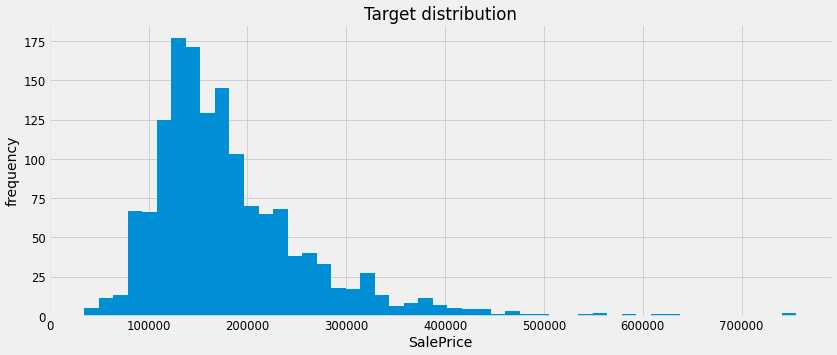

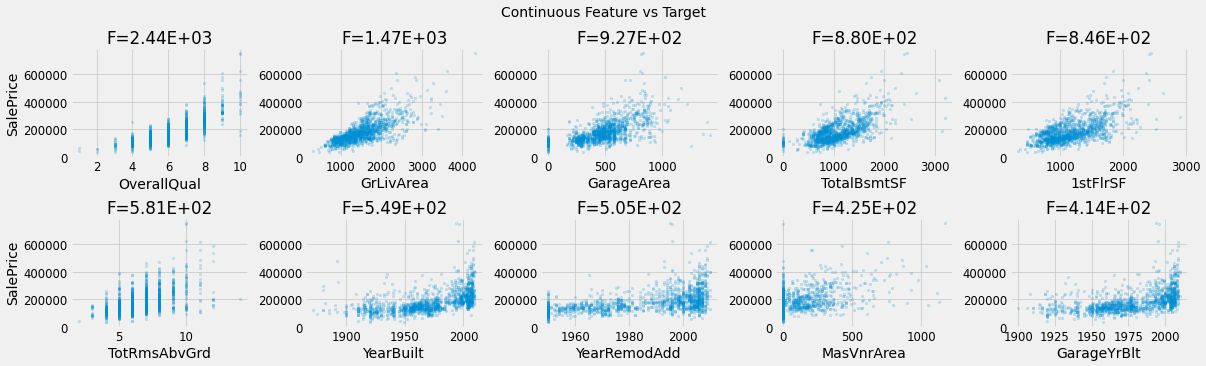

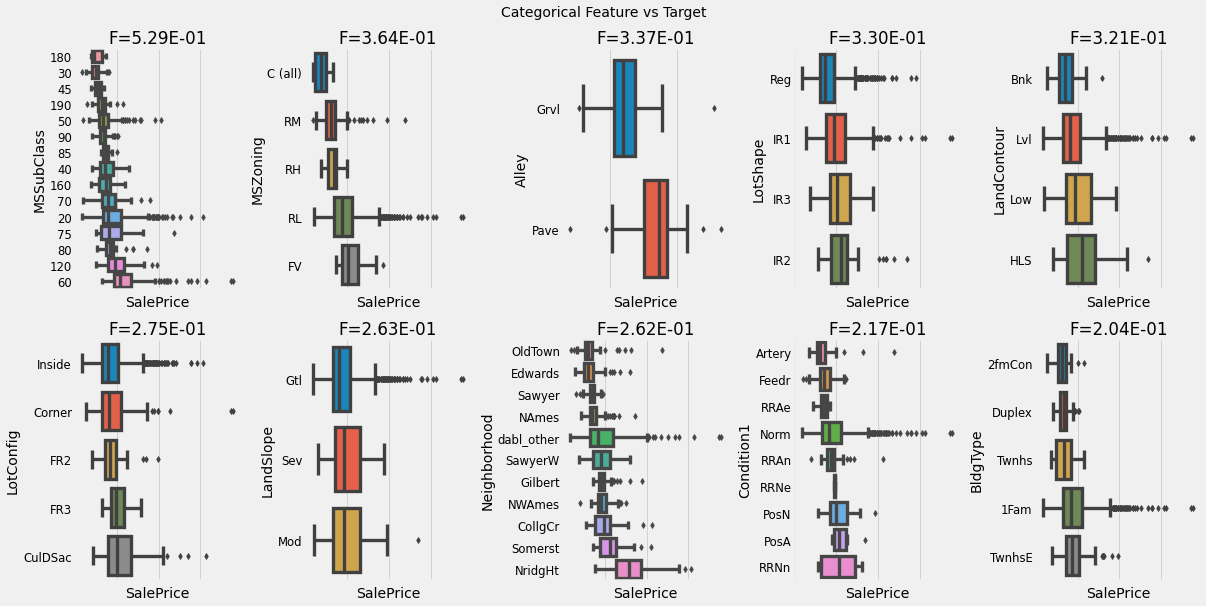

In [8]:
import dabl
dabl.plot(train, target_col = 'SalePrice')

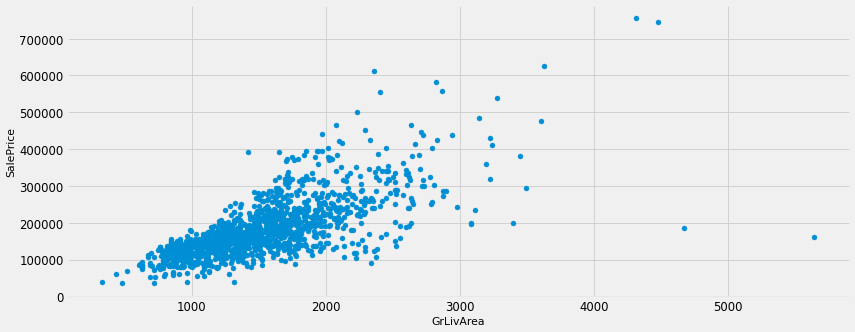

In [9]:
plot_scatter(train, 'GrLivArea', 'SalePrice')

Dropping outliers of extreme high ground living area but low sale price

In [10]:
## Delete outliers
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)

Correlation of features

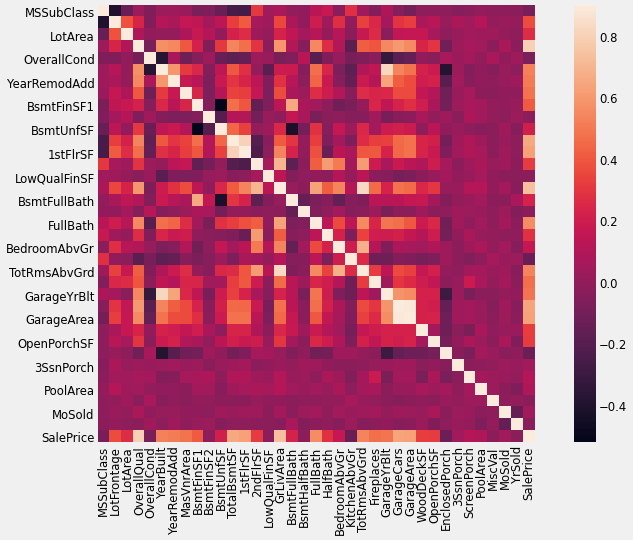

In [11]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

Top 10 important features correlated with SalePrice

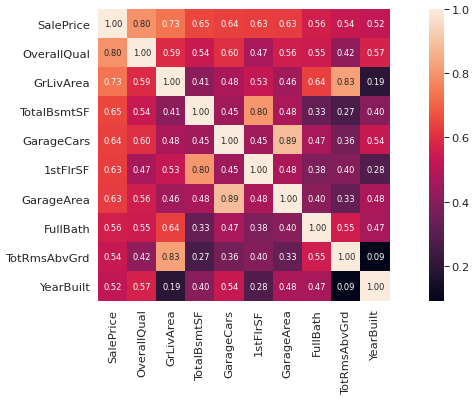

In [12]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Pairs plot of important features

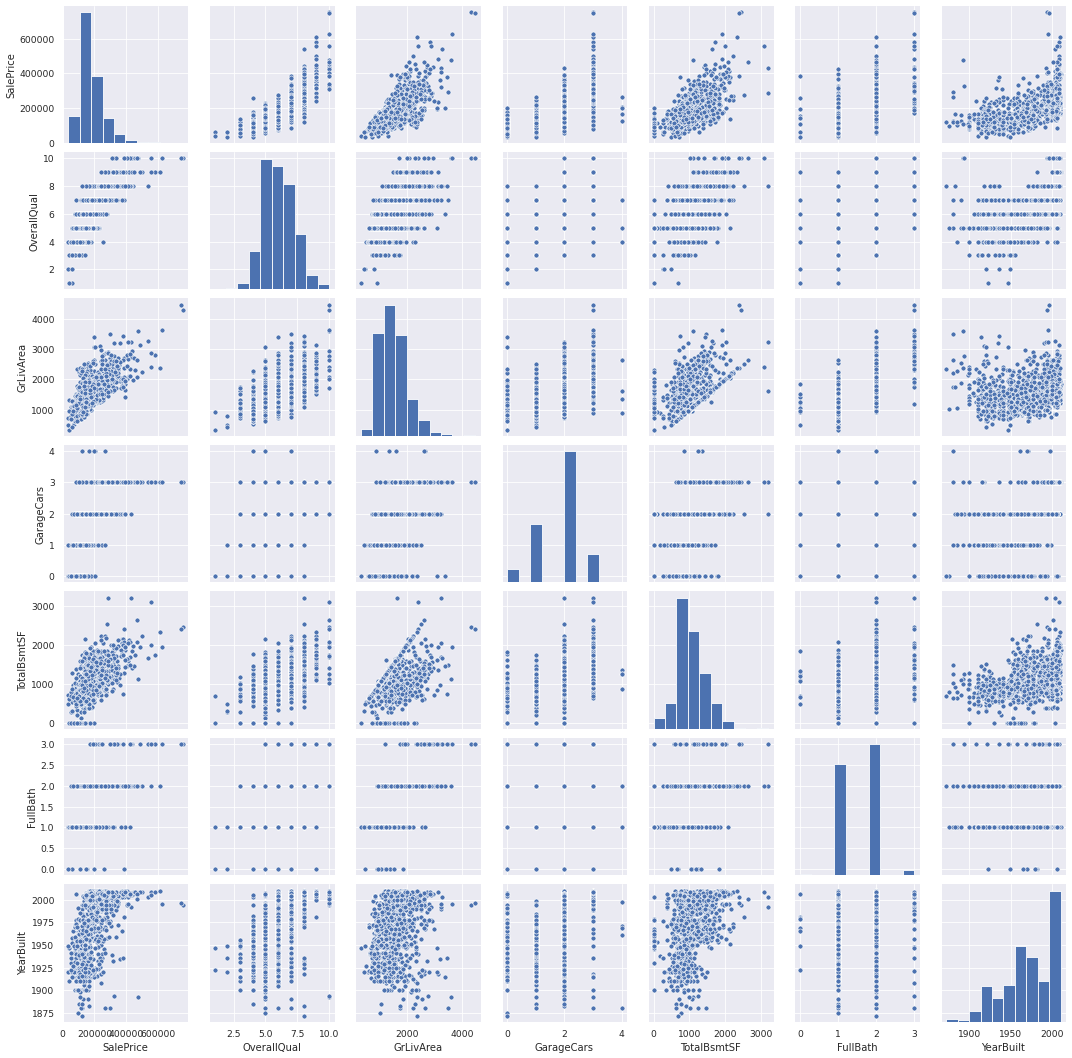

In [13]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
plot_pairs(train, cols)

---
## Data Analysis and Feature Engineering

Combining the train and test set together so that data transformation will be consistent and applied to both datasets.

It is important to note that any updates to the test set should be based on analysis or data available only in the train set.  Example, when updating column with null value in test set with the mean value observed, the mean value should be calculated based on data in the train set only and not the combined set.

However, for simplicity, all data manipulation and feature engineering done in a combined manner, assuming data in both the train and test set are consistent and similar.

In [14]:
traintest = combineTrainTest(train, test, features)
traintest.MSSubClass = traintest.MSSubClass.astype('category')
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2917 non-null category
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 

Check columns with null values

In [15]:
na_cols = traintest.columns[traintest.isna().any()].tolist()
traintest[na_cols].isnull().sum().sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

### Fixing the missing values
#### PoolQC

In [16]:
traintest.loc[(traintest.PoolQC.isnull()) & (traintest.PoolArea == 0), 'PoolQC'] = 'NA'
traintest['PoolQC'] = traintest.groupby(['OverallQual'])['PoolQC'].transform(lambda x: x.fillna(x.mode()[0]))

#### FireplaceQu

In [17]:
traintest.loc[(traintest.FireplaceQu.isnull()) & (traintest.Fireplaces == 0), 'FireplaceQu'] = 'NA'
traintest['FireplaceQu'] = traintest.groupby(['OverallQual'])['FireplaceQu'].transform(lambda x: x.fillna(x.mode()[0]))

#### MiscFeature

In [18]:
traintest.loc[(traintest.MiscFeature.isnull()), 'MiscFeature'] = 'NA'
traintest.loc[(traintest.Fence.isnull()), 'Fence'] = 'NA'
traintest.loc[(traintest.Alley.isnull()), 'Alley'] = 'NA'

#### Lot Info

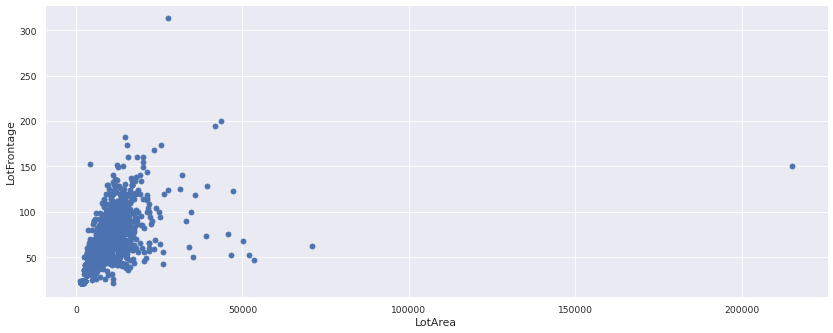

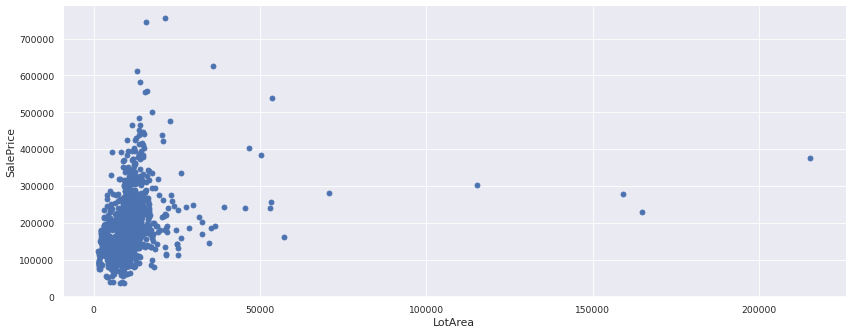

In [19]:
traintest.filter(regex='Lot').head()
plot_scatter(traintest, 'LotArea', 'LotFrontage')
plot_scatter(train, 'LotArea', 'SalePrice')

Notice the outlier.  Extremely large plot of land with with small frontage.  Winsorize the lotarea??

In [20]:
from scipy.stats.mstats import winsorize

# Check minimum sum of donations
# print(traintest["LotArea"].min())
# print(traintest["LotArea"].max())

traintest["LotArea"] = winsorize(traintest["LotArea"], limits=[0, 0.005])

In [21]:
traintest[(traintest.LotArea > 50000)].filter(regex='Lot').head()

Empty DataFrame
Columns: [LotFrontage, LotArea, LotShape, LotConfig]
Index: []

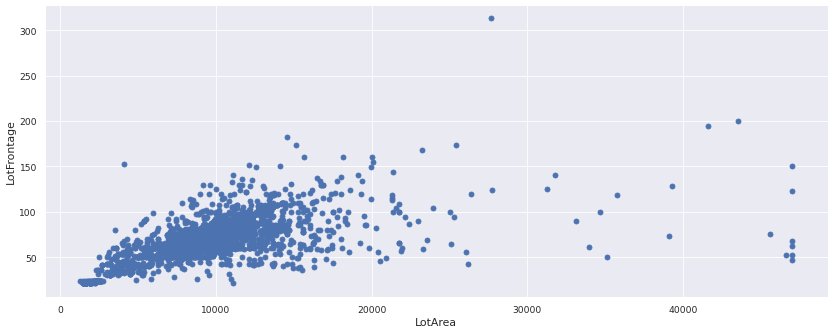

In [22]:
plot_scatter(traintest, 'LotArea', 'LotFrontage')

Create categorial features to group the lot area and then filling the missing lot frontage with respective median.

In [23]:
traintest['LotAreaGroup'] = pd.qcut(traintest['LotArea'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup','LotShape'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### Garage Info

In [24]:
traintest.loc[(traintest.GarageYrBlt.isnull()), 'GarageYrBlt'] = -1
traintest.loc[(traintest.GarageFinish.isnull()), 'GarageFinish'] = 'NA'
traintest.loc[(traintest.GarageQual.isnull()), 'GarageQual'] = 'NA'
traintest.loc[(traintest.GarageCond.isnull()), 'GarageCond'] = 'NA'
traintest.loc[(traintest.GarageType.isnull()), 'GarageType'] = 'NA'

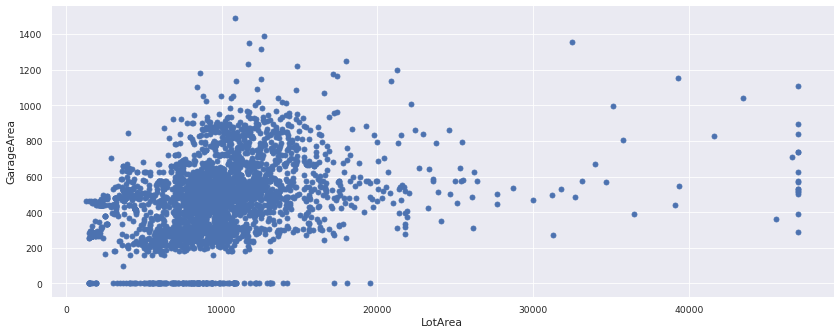

In [25]:
plot_scatter(traintest, 'LotArea', 'GarageArea')

In [26]:
traintest['GarageArea'] = traintest.groupby(['LotAreaGroup'])['GarageArea'].transform(lambda x: x.fillna(x.median()))
traintest['GarageCars'] = traintest.groupby(['LotAreaGroup'])['GarageCars'].transform(lambda x: x.fillna(x.median()))

#### Basement Info

In [27]:
traintest.loc[(traintest.BsmtCond.isnull()), 'BsmtCond'] = 'NA'
traintest.loc[(traintest.BsmtExposure.isnull()), 'BsmtExposure'] = 'NA'
traintest.loc[(traintest.BsmtQual.isnull()), 'BsmtQual'] = 'NA'
traintest.loc[(traintest.BsmtFinType1.isnull()), 'BsmtFinType1'] = 'NA'
traintest.loc[(traintest.BsmtFinType2.isnull()), 'BsmtFinType2'] = 'NA'

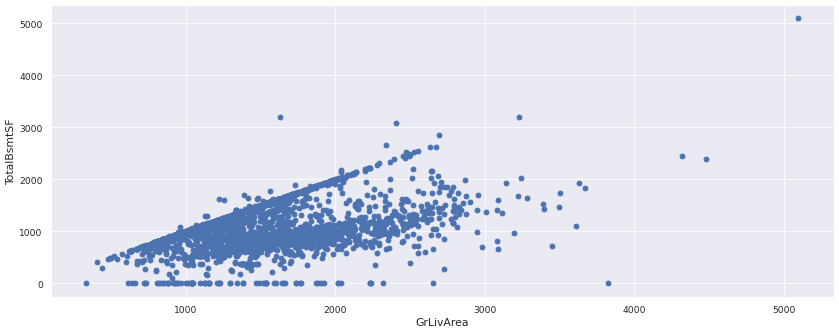

In [28]:
plot_scatter(traintest, 'GrLivArea', 'TotalBsmtSF')

In [29]:
traintest['GrLivAreaGroup'] = pd.qcut(traintest['GrLivArea'], 5, 
                                    labels=['XS','S','M','L','XL'])
traintest['TotalBsmtSF'] = traintest.groupby(['GrLivAreaGroup'])['TotalBsmtSF'].transform(lambda x: x.fillna(x.median()))

In [30]:
traintest['TotalBsmtSFGroup'] = pd.qcut(traintest['TotalBsmtSF'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['BsmtFullBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtFullBath'].transform(lambda x: x.fillna(x.median()))
traintest['BsmtHalfBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtHalfBath'].transform(lambda x: x.fillna(x.median()))


In [31]:
traintest[traintest.BsmtFinSF1.isnull()].filter(regex='Bsmt')

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
Id                                                                          
2121       NA       NA           NA           NA         NaN           NA   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  \
Id                                                                     
2121         NaN        NaN        864.0           0.0           0.0   

     TotalBsmtSFGroup  
Id                     
2121                S

This record belongs to the test data set.  Hence cannot be dropped.  Decided to drop the columns instead.

In [32]:
# traintest.loc[traintest.BsmtFinSF1.isnull(), ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
traintest = traintest.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis=1)

In [33]:
# garage = traintest.columns[traintest.columns.str.startswith('Garage')].tolist()
# basement = traintest.columns[traintest.columns.str.contains('Bsmt')].tolist()
# quality = traintest.columns[traintest.columns.str.contains('Qual')].tolist()

In [34]:
# na_cols = traintest.columns[traintest.isna().any()].tolist()
# traintest[na_cols].isnull().sum().sort_values(ascending=False)

#### MasVnrType Info

In [35]:
traintest.loc[(traintest.MasVnrType.isnull()) & (traintest.MasVnrArea.isnull()), 'MasVnrType'] = 'None'
traintest.loc[(traintest.MasVnrType == 'None') & (traintest.MasVnrArea.isnull()), 'MasVnrArea'] = 0
traintest['MasVnrType'] = traintest.groupby(['MSSubClass'])['MasVnrType'].transform(lambda x: x.fillna(x.mode()[0]))

#### Utilities Info

In [36]:
# traintest['Utilities'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Utilities'].transform(lambda x: x.fillna(x.mode()[0]))
train.Utilities.value_counts()
traintest = traintest.drop(['Utilities'], axis=1)

#### Miscellaneous Info

In [37]:
traintest['MSZoning'] = traintest.groupby(['MSSubClass','Neighborhood'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Functional'] = traintest.groupby(['OverallQual'])['Functional'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['KitchenQual'] = traintest.groupby('OverallQual')['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Electrical'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['SaleType'] = traintest['SaleType'].fillna(traintest['SaleType'].mode()[0])


### Adding potentially useful columns
1. Total Square Feet

In [38]:
traintest['TotalSF'] = traintest['1stFlrSF'] + traintest['2ndFlrSF'] + traintest['TotalBsmtSF']

# tosquare = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
#                '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
#                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
#                '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

# def genSquareColumns(data, columns):
#     for column in columns:
#         new_column = column + '_squared'
#         data[new_column] = data[column] * data[column]
#     return data
    
# traintest = genSquareColumns(traintest, tosquare)

### Dropping potentially irrelevant columns

These are categorical columns with many categories.  To drop for now so that the size of the data sets for training and test are manageable.

In [39]:
todrop = ['Neighborhood','Exterior1st','Exterior2nd']
traintest = traintest.drop(todrop, axis=1)

### Final Check

Are there any columns with missing data?

In [40]:
traintest.isnull().any().any()

False

In [41]:
traintest.describe(include=np.number)

LotFrontage       LotArea  OverallQual  OverallCond    YearBuilt  \
count   2917.00000   2917.000000  2917.000000  2917.000000  2917.000000   
mean      69.73843   9954.323620     6.086390     5.564964  1971.287967   
std       21.54500   5157.292522     1.406704     1.113414    30.286991   
min       21.00000   1300.000000     1.000000     1.000000  1872.000000   
25%       60.00000   7476.000000     5.000000     5.000000  1953.000000   
50%       70.00000   9452.000000     6.000000     5.000000  1973.000000   
75%       82.00000  11556.000000     7.000000     6.000000  2001.000000   
max      313.00000  47007.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count   2917.000000  2917.000000  2917.000000  2917.000000  2917.000000   
mean    1984.248200   100.931436  1049.263970  1157.692492   335.861502   
std       20.892257   178.032499   429.046043   385.264298   428.119663   
min     1950.000000     0.000000     0.000000   334.000000     0.000000   
25%     1965.000000     0.000000   793.000000   876.000000     0.000000   
50%     1993.000000     0.000000   988.000000  1082.000000     0.000000   
75%     2004.000000   163.000000  1302.000000  1384.000000   704.000000   
max     2010.000000  1600.000000  5095.000000  5095.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   2917.000000  2917.000000   2917.000000   2917.000000  2917.000000   
mean       4.697635  1498.251628      0.428865      0.061364     1.567364   
std       46.412570   496.908626      0.523943      0.245687     0.552465   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1126.000000      0.000000      0.000000     1.000000   
50%        0.000000  1444.000000      0.000000      0.000000     2.000000   
75%        0.000000  1743.000000      1.000000      0.000000     2.000000   
max     1064.000000  5095.000000      3.000000      2.000000     4.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  2917.000000   2917.000000   2917.000000   2917.000000  2917.000000   
mean      0.379842      2.860130      1.044566      6.448063     0.596160   
std       0.502782      0.822967      0.214532      1.564281     0.644773   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     15.000000     4.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  2917.000000  2917.000000  2917.000000  2917.000000  2917.000000   
mean   1870.215632     1.766198   472.409325    93.629414    47.280082   
std     450.052870     0.761412   214.584074   126.532643    67.118965   
min      -1.000000     0.000000     0.000000     0.000000     0.000000   
25%    1957.000000     1.000000   320.000000     0.000000     0.000000   
50%    1977.000000     2.000000   480.000000     0.000000    26.000000   
75%    2001.000000     2.000000   576.000000   168.000000    70.000000   
max    2207.000000     5.000000  1488.000000  1424.000000   742.000000   

       EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal  \
count    2917.000000  2917.000000  2917.000000  2917.000000   2917.000000   
mean       23.114158     2.604045    16.073363     2.088790     50.860816   
std        64.263424    25.196714    56.202054    34.561371    567.595198   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     0.000000      0.000000   
50%         0.000000     0.000000     0.000000     0.000000      0.000000   
75%         0.000000     0.000000     0.000000     0.000000  

In [42]:
traintest.describe(include=[np.object])

MSZoning Street Alley LotShape LandContour LotConfig LandSlope  \
count      2917   2917  2917     2917        2917      2917      2917   
unique        5      2     3        4           4         5         3   
top          RL   Pave    NA      Reg         Lvl    Inside       Gtl   
freq       2264   2905  2719     1859        2622      2132      2776   

       Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
count        2917       2917     2917       2917      2917     2917   
unique          9          8        5          8         6        7   
top          Norm       Norm     1Fam     1Story     Gable  CompShg   
freq         2511       2888     2423       1471      2310     2875   

       MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond  \
count        2917      2917      2917       2917     2917     2917   
unique          4         4         5          6        5        5   
top          None        TA        TA      PConc       TA       TA   
freq         1766      1798      2536       1306     1283     2604   

       BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir  \
count          2917         2917         2917    2917      2917       2917   
unique            5            7            7       6         5          2   
top              No          Unf          Unf    GasA        Ex          Y   
freq           1904          851         2491    2872      1491       2721   

       Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish  \
count        2917        2917       2917        2917       2917         2917   
unique          5           4          7           6          7            4   
top         SBrkr          TA        Typ          NA     Attchd          Unf   
freq         2670        1493       2716        1420       1722         1230   

       GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType  \
count        2917       2917       2917   2917  2917        2917     2917   
unique          6          6          3      4     5           5        9   
top            TA         TA          Y     NA    NA          NA       WD   
freq         2602       2652       2639   2908  2346        2812     2526   

       SaleCondition  
count           2917  
unique             6  
top           Normal  
freq            2402

## Preprocessing data for training
1. Splitting the combined dataset back to train and test set
2. One Hot Encoding for Categorical features
3. Normalising the Numerical features

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [44]:
def processStdScalar(train, test, columns):
    
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    for column in columns:
        scalar = StandardScaler()
        scalar.fit(train[[column]])
        train_scaled[column] = scalar.transform(train[[column]])
        test_scaled[column] = scalar.transform(test[[column]])
        
    return train_scaled, test_scaled

In [45]:
traintest.shape

(2917, 76)

### One-Hot Encoding

For simplicity, using Pandas get_dummies for OHE for now.  Also applying to the combined dataset so that the encoding can be consistently applied to both train and test dataset.

In [46]:
traintest = pd.get_dummies(traintest, drop_first=True)

### Splitting the combined data set back to train and test

In [47]:
Xy, X_test = splitTrainTest(traintest, train, test, target)

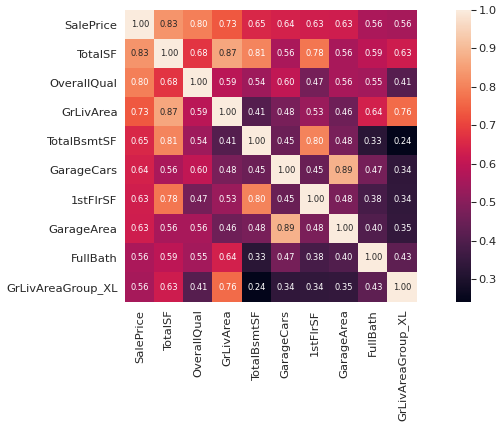

In [48]:
newcorrmat = Xy.corr()

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = newcorrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Xy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [49]:
X = Xy.drop(target, axis=1)
y = Xy[target]

### Normalise Numerical Features
Identify numerical features to normalise

In [50]:
tonormalise = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
               'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

# tonormalise = tonormalise + [col+'_squared' for col in tonormalise]
# plot_pairs(Xy, tonormalise)

Normalisation was done by fitting the scaler with training data and then transforming the train and test data respectively.

In [51]:
X, X_test, = processStdScalar(X, X_test, tonormalise)

### Normalise Target Features

In [52]:
targetScalar = StandardScaler()
targetScalar.fit(y)
y.SalePrice = targetScalar.transform(y)

### Train Test (Valid) Split
Splitting the training dataset into training and validation data set.  Purpose of the validation data set is for model evaluation later.

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=SEED)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(874, 228)
(874, 1)
(584, 228)
(584, 1)
(1459, 228)


---
## Tensorflow

In [54]:
# !pip install tensorflow
# !pip install -q git+https://github.com/tensorflow/docs

### Helper functions
1. **plot_results** - Plot training and validation data over the various epochs

In [55]:
def plot_results(data, val_data, limit=1, title='Results'):
    plt.figure()
    plt.plot(data)
    plt.plot(val_data)
    plt.ylim([0, limit])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [56]:
INPUTS = len(X_train.columns)
TRAINING_OBSERVATIONS = X_train.shape[0]
print('Number of inputs to neural network: {}'.format(INPUTS))
print('Number of training observations: {}'.format(TRAINING_OBSERVATIONS))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Number of inputs to neural network: 228
Number of training observations: 874


### Model Building Considerations:
1. Problem Identification 
    - Binary, Multiclass, Multilabel, Regression
2. Number of Dense layers
    - What is the Activation function
    - Number of Nodes in each layer
    - Any kernel_initializer?
3. Optimization function
    - learning rate and many other parameters (to explore)
4. Loss function
5. Metrics
6. Fitting Parameters
    - Optimal Batch Size
    - Training and Validation Dataset
    - Number of EPOCHS
    - EarlyStopping - patience number
    - ModelCheckpoint

Additional Considerations:
1. Normalisation layers
2. Dropout layers


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(nodes=(16,32,16), activation='relu', learning_rate=0.002, input_dropout=0.05):
    model = Sequential()

    model.add(Dense(nodes[0], input_shape=(INPUTS,), activation='relu', kernel_initializer='normal'))
    model.add(tf.keras.layers.Dropout(input_dropout))
    
    for node in nodes[1:]:
        model.add(Dense(node, activation='relu', kernel_initializer='normal'))

    # model.add(Dense(nodes[1], activation='relu', kernel_initializer='normal'))
    # model.add(tf.keras.layers.BatchNormalization())

    model.add(Dense(1))

    # optimizer = tf.keras.optimizers.RMSprop(0.03)
    # opt = 'RMSprop'
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

    return model

### Hyperparameters Search

In [93]:
import itertools

layer1 = [8]
layer2 = [16]
layer3 = [32,64]
layers = [layer1, layer2, layer3]

NODES_LIST = list(itertools.product(*layers))
ACTIVATION_LIST = ['relu', 'sigmoid'] ## 'relu', 'sigmoid', 'tanh', 'leaky_relu'
BATCHSIZE_LIST = [437, 874]
EPOCHS_LIST = [2000]
LEARNINGRATE_LIST = [0.0005]
INPUTDROPOUT_LIST = [0.05]

# Define the parameters to try out
params = {'nodes': NODES_LIST, 
          'activation': ACTIVATION_LIST, 
          'batch_size': BATCHSIZE_LIST, 
          'epochs': EPOCHS_LIST, 
          'input_dropout': INPUTDROPOUT_LIST, 
          'learning_rate': LEARNINGRATE_LIST}

print(params)

{'nodes': [(8, 16, 32), (8, 16, 64)], 'activation': ['relu', 'sigmoid'], 'batch_size': [437, 874], 'epochs': [2000], 'input_dropout': [0.05], 'learning_rate': [0.0005]}


In [94]:
# Import KerasRegressor from keras wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create a KerasRegressor
grid_buildmodel = KerasRegressor(build_fn = build_model)

grid_search = GridSearchCV(grid_buildmodel, param_grid = params, cv = 3, verbose=0, return_train_score=True)

In [95]:
%time grid_search.fit(X_train, y_train)

Epoch 1/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0953 - mae: 0.7609 - mse: 1.0953
Epoch 2/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.1403 - mae: 0.8199 - mse: 1.1403
Epoch 3/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0730 - mae: 0.7381 - mse: 1.0730
Epoch 4/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0696 - mae: 0.7280 - mse: 1.0696
Epoch 5/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0499 - mae: 0.7495 - mse: 1.0499
Epoch 6/2000
2/2 [==============================] - 0s 3ms/step - loss: 1.0330 - mae: 0.7447 - mse: 1.0330
Epoch 7/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0227 - mae: 0.7234 - mse: 1.0227
Epoch 8/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0148 - mae: 0.7137 - mse: 1.0148
Epoch 9/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.0073 - mae: 0.7135 - mse: 1.0073
Epoch 10/2000
2/2 [==================

2/2 [==============================] - 0s 2ms/step - loss: 0.8890 - mae: 0.6640 - mse: 0.8890
Epoch 76/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.8837 - mae: 0.6611 - mse: 0.8837
Epoch 77/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8812 - mae: 0.6669 - mse: 0.8812
Epoch 78/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8739 - mae: 0.6738 - mse: 0.8739
Epoch 79/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8751 - mae: 0.6726 - mse: 0.8751
Epoch 80/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.8853 - mae: 0.6523 - mse: 0.8853
Epoch 81/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8684 - mae: 0.6466 - mse: 0.8684
Epoch 82/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.8705 - mae: 0.6788 - mse: 0.8705
Epoch 83/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8736 - mae: 0.6671 - mse: 0.8736
Epoch 84/2000
2/2 [=====================

2/2 [==============================] - 0s 2ms/step - loss: 0.5725 - mae: 0.5039 - mse: 0.5725
Epoch 151/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.6048 - mae: 0.5131 - mse: 0.6048
Epoch 152/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5768 - mae: 0.5203 - mse: 0.5768
Epoch 153/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.5753 - mae: 0.5104 - mse: 0.5753
Epoch 154/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5734 - mae: 0.4886 - mse: 0.5734
Epoch 155/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5776 - mae: 0.5126 - mse: 0.5776
Epoch 156/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5788 - mae: 0.5128 - mse: 0.5788
Epoch 157/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5666 - mae: 0.4831 - mse: 0.5666
Epoch 158/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.5811 - mae: 0.5246 - mse: 0.5811
Epoch 159/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.3655 - mae: 0.3634 - mse: 0.3655
Epoch 225/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3669 - mae: 0.3620 - mse: 0.3669
Epoch 226/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4181 - mae: 0.3765 - mse: 0.4181
Epoch 227/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3618 - mae: 0.3618 - mse: 0.3618
Epoch 228/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3768 - mae: 0.3573 - mse: 0.3768
Epoch 229/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.3741 - mae: 0.3614 - mse: 0.3741
Epoch 230/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3523 - mae: 0.3608 - mse: 0.3523
Epoch 231/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.4146 - mae: 0.3779 - mse: 0.4146
Epoch 232/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4022 - mae: 0.3958 - mse: 0.4022
Epoch 233/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.3505 - mae: 0.3390 - mse: 0.3505
Epoch 299/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3272 - mae: 0.3239 - mse: 0.3272
Epoch 300/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3051 - mae: 0.3386 - mse: 0.3051
Epoch 301/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3383 - mae: 0.3383 - mse: 0.3383
Epoch 302/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3356 - mae: 0.3404 - mse: 0.3356
Epoch 303/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2956 - mae: 0.3179 - mse: 0.2956
Epoch 304/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3266 - mae: 0.3323 - mse: 0.3266
Epoch 305/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3276 - mae: 0.3577 - mse: 0.3276
Epoch 306/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3154 - mae: 0.3336 - mse: 0.3154
Epoch 307/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.2428 - mae: 0.2988 - mse: 0.2428
Epoch 373/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3048 - mae: 0.3543 - mse: 0.3048
Epoch 374/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2993 - mae: 0.3493 - mse: 0.2993
Epoch 375/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.3216 - mae: 0.3175 - mse: 0.3216
Epoch 376/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2710 - mae: 0.3294 - mse: 0.2710
Epoch 377/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3392 - mae: 0.3283 - mse: 0.3392
Epoch 378/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2612 - mae: 0.3090 - mse: 0.2612
Epoch 379/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2523 - mae: 0.3095 - mse: 0.2523
Epoch 380/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2754 - mae: 0.3057 - mse: 0.2754
Epoch 381/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2469 - mae: 0.2870 - mse: 0.2469
Epoch 447/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2001 - mae: 0.2750 - mse: 0.2001
Epoch 448/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1921 - mae: 0.2669 - mse: 0.1921
Epoch 449/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2437 - mae: 0.2824 - mse: 0.2437
Epoch 450/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2103 - mae: 0.2740 - mse: 0.2103
Epoch 451/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2231 - mae: 0.2811 - mse: 0.2231
Epoch 452/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2478 - mae: 0.2802 - mse: 0.2478
Epoch 453/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2173 - mae: 0.2778 - mse: 0.2173
Epoch 454/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2594 - mae: 0.2842 - mse: 0.2594
Epoch 455/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2139 - mae: 0.2728 - mse: 0.2139
Epoch 521/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1949 - mae: 0.2679 - mse: 0.1949
Epoch 522/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1975 - mae: 0.2707 - mse: 0.1975
Epoch 523/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.2502 - mae: 0.2772 - mse: 0.2502
Epoch 524/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1793 - mae: 0.2664 - mse: 0.1793
Epoch 525/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1716 - mae: 0.2530 - mse: 0.1716
Epoch 526/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2162 - mae: 0.2798 - mse: 0.2162
Epoch 527/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2215 - mae: 0.2758 - mse: 0.2215
Epoch 528/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1790 - mae: 0.2546 - mse: 0.1790
Epoch 529/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1822 - mae: 0.2638 - mse: 0.1822
Epoch 595/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1840 - mae: 0.2640 - mse: 0.1840
Epoch 596/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1850 - mae: 0.2513 - mse: 0.1850
Epoch 597/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1773 - mae: 0.2774 - mse: 0.1773
Epoch 598/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2239 - mae: 0.2965 - mse: 0.2239
Epoch 599/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1813 - mae: 0.2586 - mse: 0.1813
Epoch 600/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.2503 - mae: 0.2725 - mse: 0.2503
Epoch 601/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2078 - mae: 0.2596 - mse: 0.2078
Epoch 602/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1955 - mae: 0.2643 - mse: 0.1955
Epoch 603/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1658 - mae: 0.2512 - mse: 0.1658
Epoch 670/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1638 - mae: 0.2549 - mse: 0.1638
Epoch 671/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2061 - mae: 0.2628 - mse: 0.2061
Epoch 672/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1692 - mae: 0.2643 - mse: 0.1692
Epoch 673/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1894 - mae: 0.2526 - mse: 0.1894
Epoch 674/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2162 - mae: 0.2678 - mse: 0.2162
Epoch 675/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1579 - mae: 0.2506 - mse: 0.1579
Epoch 676/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1959 - mae: 0.2471 - mse: 0.1959
Epoch 677/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1413 - mae: 0.2417 - mse: 0.1413
Epoch 678/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1733 - mae: 0.2412 - mse: 0.1733
Epoch 744/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1379 - mae: 0.2321 - mse: 0.1379
Epoch 745/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1470 - mae: 0.2412 - mse: 0.1470
Epoch 746/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1489 - mae: 0.2412 - mse: 0.1489
Epoch 747/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2166 - mae: 0.2613 - mse: 0.2166
Epoch 748/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1643 - mae: 0.2570 - mse: 0.1643
Epoch 749/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1813 - mae: 0.2506 - mse: 0.1813
Epoch 750/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1635 - mae: 0.2430 - mse: 0.1635
Epoch 751/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1459 - mae: 0.2345 - mse: 0.1459
Epoch 752/2000
2/2 [==============

2/2 [==============================] - 0s 3ms/step - loss: 0.1790 - mae: 0.2481 - mse: 0.1790
Epoch 817/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1946 - mae: 0.2478 - mse: 0.1946
Epoch 818/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1693 - mae: 0.2393 - mse: 0.1693
Epoch 819/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1543 - mae: 0.2427 - mse: 0.1543
Epoch 820/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1903 - mae: 0.2511 - mse: 0.1903
Epoch 821/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1898 - mae: 0.2517 - mse: 0.1898
Epoch 822/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2032 - mae: 0.2529 - mse: 0.2032
Epoch 823/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1401 - mae: 0.2297 - mse: 0.1401
Epoch 824/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1453 - mae: 0.2377 - mse: 0.1453
Epoch 825/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1260 - mae: 0.2268 - mse: 0.1260
Epoch 892/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1611 - mae: 0.2385 - mse: 0.1611
Epoch 893/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.2242 - mse: 0.1359
Epoch 894/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1502 - mae: 0.2401 - mse: 0.1502
Epoch 895/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1662 - mae: 0.2513 - mse: 0.1662
Epoch 896/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1242 - mae: 0.2243 - mse: 0.1242
Epoch 897/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1471 - mae: 0.2308 - mse: 0.1471
Epoch 898/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.2148 - mae: 0.2422 - mse: 0.2148
Epoch 899/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1546 - mae: 0.2309 - mse: 0.1546
Epoch 900/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1442 - mae: 0.2293 - mse: 0.1442
Epoch 967/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1679 - mae: 0.2398 - mse: 0.1679
Epoch 968/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1631 - mae: 0.2600 - mse: 0.1631
Epoch 969/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1798 - mae: 0.2644 - mse: 0.1798
Epoch 970/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.1147 - mae: 0.2273 - mse: 0.1147
Epoch 971/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1910 - mae: 0.2618 - mse: 0.1910
Epoch 972/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1435 - mae: 0.2276 - mse: 0.1435
Epoch 973/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1538 - mae: 0.2311 - mse: 0.1538
Epoch 974/2000
2/2 [==============================] - ETA: 0s - loss: 0.1408 - mae: 0.2267 - mse: 0.140 - 0s 2ms/step - loss: 0.1301 - mae: 0.

2/2 [==============================] - 0s 1ms/step - loss: 0.2027 - mae: 0.2399 - mse: 0.2027
Epoch 1041/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1535 - mae: 0.2358 - mse: 0.1535
Epoch 1042/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1298 - mae: 0.2236 - mse: 0.1298
Epoch 1043/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1399 - mae: 0.2260 - mse: 0.1399
Epoch 1044/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1567 - mae: 0.2296 - mse: 0.1567
Epoch 1045/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1195 - mae: 0.2143 - mse: 0.1195
Epoch 1046/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1688 - mae: 0.2305 - mse: 0.1688
Epoch 1047/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1095 - mae: 0.2220 - mse: 0.1095
Epoch 1048/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1548 - mae: 0.2271 - mse: 0.1548
Epoch 1049/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1016 - mae: 0.2116 - mse: 0.1016
Epoch 1113/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1596 - mae: 0.2322 - mse: 0.1596
Epoch 1114/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1384 - mae: 0.2321 - mse: 0.1384
Epoch 1115/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1622 - mae: 0.2312 - mse: 0.1622
Epoch 1116/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1403 - mae: 0.2247 - mse: 0.1403
Epoch 1117/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1031 - mae: 0.2116 - mse: 0.1031
Epoch 1118/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1724 - mae: 0.2251 - mse: 0.1724
Epoch 1119/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1225 - mae: 0.2172 - mse: 0.1225
Epoch 1120/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1228 - mae: 0.2233 - mse: 0.1228
Epoch 1121/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1405 - mae: 0.2248 - mse: 0.1405
Epoch 1187/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0891 - mae: 0.2039 - mse: 0.0891
Epoch 1188/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1721 - mae: 0.2327 - mse: 0.1721
Epoch 1189/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1142 - mae: 0.2131 - mse: 0.1142
Epoch 1190/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1394 - mae: 0.2309 - mse: 0.1394
Epoch 1191/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.2214 - mse: 0.1249
Epoch 1192/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1194 - mae: 0.2158 - mse: 0.1194
Epoch 1193/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1327 - mae: 0.2154 - mse: 0.1327
Epoch 1194/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1906 - mae: 0.2310 - mse: 0.1906
Epoch 1195/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1358 - mae: 0.2101 - mse: 0.1358
Epoch 1261/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0983 - mae: 0.2048 - mse: 0.0983
Epoch 1262/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1910 - mae: 0.2330 - mse: 0.1910
Epoch 1263/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2063 - mse: 0.0943
Epoch 1264/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.2188 - mse: 0.1237
Epoch 1265/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.1724 - mae: 0.2401 - mse: 0.1724
Epoch 1266/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0872 - mae: 0.1995 - mse: 0.0872
Epoch 1267/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1647 - mae: 0.2346 - mse: 0.1647
Epoch 1268/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1476 - mae: 0.2286 - mse: 0.1476
Epoch 1269/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.1969 - mse: 0.0831
Epoch 1335/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1758 - mae: 0.2197 - mse: 0.1758
Epoch 1336/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1195 - mae: 0.2225 - mse: 0.1195
Epoch 1337/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1873 - mae: 0.2296 - mse: 0.1873
Epoch 1338/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1566 - mae: 0.2151 - mse: 0.1566
Epoch 1339/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1224 - mae: 0.2061 - mse: 0.1224
Epoch 1340/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1140 - mae: 0.2184 - mse: 0.1140
Epoch 1341/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1145 - mae: 0.2081 - mse: 0.1145
Epoch 1342/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0941 - mae: 0.2038 - mse: 0.0941
Epoch 1343/2000
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 0.1255 - mae: 0.2193 - mse: 0.1255
Epoch 1409/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0804 - mae: 0.1960 - mse: 0.0804
Epoch 1410/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1049 - mae: 0.2027 - mse: 0.1049
Epoch 1411/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1799 - mae: 0.2154 - mse: 0.1799
Epoch 1412/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1030 - mae: 0.2068 - mse: 0.1030
Epoch 1413/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.1361 - mae: 0.2206 - mse: 0.1361
Epoch 1414/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1116 - mae: 0.2063 - mse: 0.1116
Epoch 1415/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1288 - mae: 0.2164 - mse: 0.1288
Epoch 1416/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1293 - mae: 0.2133 - mse: 0.1293
Epoch 1417/2000
2/2 [====

2/2 [==============================] - 0s 20ms/step - loss: 0.1110 - mae: 0.2054 - mse: 0.1110
Epoch 1483/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1002 - mae: 0.1996 - mse: 0.1002
Epoch 1484/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1160 - mae: 0.2142 - mse: 0.1160
Epoch 1485/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1198 - mae: 0.2051 - mse: 0.1198
Epoch 1486/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1208 - mae: 0.2006 - mse: 0.1208
Epoch 1487/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1438 - mae: 0.2126 - mse: 0.1438
Epoch 1488/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0962 - mae: 0.1979 - mse: 0.0962
Epoch 1489/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1200 - mae: 0.2056 - mse: 0.1200
Epoch 1490/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1854 - mae: 0.2206 - mse: 0.1854
Epoch 1491/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0901 - mae: 0.2043 - mse: 0.0901
Epoch 1557/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2157 - mse: 0.1303
Epoch 1558/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1099 - mae: 0.2069 - mse: 0.1099
Epoch 1559/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1582 - mae: 0.2132 - mse: 0.1582
Epoch 1560/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.2076 - mse: 0.0987
Epoch 1561/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0885 - mae: 0.1949 - mse: 0.0885
Epoch 1562/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1139 - mae: 0.2138 - mse: 0.1139
Epoch 1563/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0951 - mae: 0.1972 - mse: 0.0951
Epoch 1564/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1280 - mae: 0.2160 - mse: 0.1280
Epoch 1565/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.2018 - mse: 0.0952
Epoch 1631/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0989 - mae: 0.2049 - mse: 0.0989
Epoch 1632/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0886 - mae: 0.2036 - mse: 0.0886
Epoch 1633/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0800 - mae: 0.1926 - mse: 0.0800
Epoch 1634/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1216 - mae: 0.2151 - mse: 0.1216
Epoch 1635/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1129 - mae: 0.2134 - mse: 0.1129
Epoch 1636/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0707 - mae: 0.1879 - mse: 0.0707
Epoch 1637/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1030 - mae: 0.2202 - mse: 0.1030
Epoch 1638/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1272 - mae: 0.2160 - mse: 0.1272
Epoch 1639/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1990 - mse: 0.0797
Epoch 1705/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1593 - mae: 0.2156 - mse: 0.1593
Epoch 1706/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0953 - mae: 0.1960 - mse: 0.0953
Epoch 1707/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.1983 - mse: 0.1144
Epoch 1708/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2175 - mse: 0.1086
Epoch 1709/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2055 - mse: 0.0839
Epoch 1710/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1152 - mae: 0.2150 - mse: 0.1152
Epoch 1711/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1034 - mae: 0.2034 - mse: 0.1034
Epoch 1712/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1620 - mae: 0.2159 - mse: 0.1620
Epoch 1713/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1302 - mae: 0.2248 - mse: 0.1302
Epoch 1779/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1140 - mae: 0.2095 - mse: 0.1140
Epoch 1780/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1328 - mae: 0.2122 - mse: 0.1328
Epoch 1781/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.1961 - mse: 0.0839
Epoch 1782/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1047 - mae: 0.2145 - mse: 0.1047
Epoch 1783/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2129 - mse: 0.1066
Epoch 1784/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1188 - mae: 0.1993 - mse: 0.1188
Epoch 1785/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0835 - mae: 0.2009 - mse: 0.0835
Epoch 1786/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0712 - mae: 0.1885 - mse: 0.0712
Epoch 1787/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.2165 - mae: 0.2268 - mse: 0.2165
Epoch 1853/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0753 - mae: 0.1903 - mse: 0.0753
Epoch 1854/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0872 - mae: 0.1946 - mse: 0.0872
Epoch 1855/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0834 - mae: 0.1917 - mse: 0.0834
Epoch 1856/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0918 - mae: 0.1931 - mse: 0.0918
Epoch 1857/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.1840 - mse: 0.0706
Epoch 1858/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1178 - mae: 0.2125 - mse: 0.1178
Epoch 1859/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.1957 - mse: 0.0986
Epoch 1860/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0719 - mae: 0.1859 - mse: 0.0719
Epoch 1861/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0938 - mae: 0.1946 - mse: 0.0938
Epoch 1927/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.1941 - mse: 0.0823
Epoch 1928/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0721 - mae: 0.1869 - mse: 0.0721
Epoch 1929/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2009 - mse: 0.1149
Epoch 1930/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1255 - mae: 0.2096 - mse: 0.1255
Epoch 1931/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1082 - mae: 0.2033 - mse: 0.1082
Epoch 1932/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.1966 - mse: 0.0899
Epoch 1933/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1077 - mae: 0.2058 - mse: 0.1077
Epoch 1934/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1140 - mae: 0.2060 - mse: 0.1140
Epoch 1935/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0657 - mae: 0.1862 - mse: 0.0657
Epoch 1/2000
2/2 [==============================] - 0s 2ms/step - loss: 3.4821 - mae: 1.6851 - mse: 3.4821
Epoch 2/2000
2/2 [==============================] - 0s 2ms/step - loss: 2.1283 - mae: 1.2863 - mse: 2.1283
Epoch 3/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.4370 - mae: 0.9942 - mse: 1.4370
Epoch 4/2000
2/2 [==============================] - 0s 12ms/step - loss: 1.0593 - mae: 0.7898 - mse: 1.0593
Epoch 5/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0839 - mae: 0.7379 - mse: 1.0839
Epoch 6/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0969 - mae: 0.7122 - mse: 1.0969
Epoch 7/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.1424 - mae: 0.7245 - mse: 1.1424
Epoch 8/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.1452 - mae: 0.7327 - mse: 1.1452
Epoch 9/2000
2/2 [==============================]

2/2 [==============================] - 0s 2ms/step - loss: 0.9351 - mae: 0.7086 - mse: 0.9351
Epoch 74/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9342 - mae: 0.7087 - mse: 0.9342
Epoch 75/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9336 - mae: 0.7064 - mse: 0.9336
Epoch 76/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9347 - mae: 0.7031 - mse: 0.9347
Epoch 77/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9333 - mae: 0.7008 - mse: 0.9333
Epoch 78/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9340 - mae: 0.7010 - mse: 0.9340
Epoch 79/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9329 - mae: 0.6996 - mse: 0.9329
Epoch 80/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9332 - mae: 0.6989 - mse: 0.9332
Epoch 81/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9347 - mae: 0.6994 - mse: 0.9347
Epoch 82/2000
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.8522 - mae: 0.6781 - mse: 0.8522
Epoch 149/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8468 - mae: 0.6674 - mse: 0.8468
Epoch 150/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8403 - mae: 0.6490 - mse: 0.8403
Epoch 151/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8463 - mae: 0.6530 - mse: 0.8463
Epoch 152/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8393 - mae: 0.6522 - mse: 0.8393
Epoch 153/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.8392 - mae: 0.6596 - mse: 0.8392
Epoch 154/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8333 - mae: 0.6607 - mse: 0.8333
Epoch 155/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.8219 - mae: 0.6515 - mse: 0.8219
Epoch 156/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8242 - mae: 0.6487 - mse: 0.8242
Epoch 157/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.5389 - mae: 0.5076 - mse: 0.5389
Epoch 222/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5439 - mae: 0.4934 - mse: 0.5439
Epoch 223/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.5437 - mae: 0.4689 - mse: 0.5437
Epoch 224/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5090 - mae: 0.4752 - mse: 0.5090
Epoch 225/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5490 - mae: 0.4969 - mse: 0.5490
Epoch 226/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.5309 - mae: 0.4739 - mse: 0.5309
Epoch 227/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.5211 - mae: 0.4562 - mse: 0.5211
Epoch 228/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5034 - mae: 0.4684 - mse: 0.5034
Epoch 229/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4940 - mae: 0.4664 - mse: 0.4940
Epoch 230/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.3059 - mae: 0.3483 - mse: 0.3059
Epoch 297/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2967 - mae: 0.3475 - mse: 0.2967
Epoch 298/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3400 - mae: 0.3636 - mse: 0.3400
Epoch 299/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2878 - mae: 0.3443 - mse: 0.2878
Epoch 300/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2808 - mae: 0.3278 - mse: 0.2808
Epoch 301/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2665 - mae: 0.3222 - mse: 0.2665
Epoch 302/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2587 - mae: 0.3182 - mse: 0.2587
Epoch 303/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3552 - mae: 0.3382 - mse: 0.3552
Epoch 304/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3507 - mae: 0.3506 - mse: 0.3507
Epoch 305/2000
2/2 [==============

2/2 [==============================] - 0s 3ms/step - loss: 0.2464 - mae: 0.3154 - mse: 0.2464
Epoch 372/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2278 - mae: 0.3125 - mse: 0.2278
Epoch 373/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2461 - mae: 0.3026 - mse: 0.2461
Epoch 374/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2187 - mae: 0.3230 - mse: 0.2187
Epoch 375/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3050 - mae: 0.3012 - mse: 0.3050
Epoch 376/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2346 - mae: 0.3073 - mse: 0.2346
Epoch 377/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2157 - mae: 0.3011 - mse: 0.2157
Epoch 378/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2349 - mae: 0.3041 - mse: 0.2349
Epoch 379/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2546 - mae: 0.3373 - mse: 0.2546
Epoch 380/2000
2/2 [==============

2/2 [==============================] - 0s 17ms/step - loss: 0.2775 - mae: 0.3015 - mse: 0.2775
Epoch 447/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2021 - mae: 0.2903 - mse: 0.2021
Epoch 448/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2130 - mae: 0.2948 - mse: 0.2130
Epoch 449/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1874 - mae: 0.2930 - mse: 0.1874
Epoch 450/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2490 - mae: 0.2994 - mse: 0.2490
Epoch 451/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2102 - mae: 0.2971 - mse: 0.2102
Epoch 452/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2359 - mae: 0.2980 - mse: 0.2359
Epoch 453/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2395 - mae: 0.2966 - mse: 0.2395
Epoch 454/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1928 - mae: 0.2820 - mse: 0.1928
Epoch 455/2000
2/2 [=============

2/2 [==============================] - 0s 3ms/step - loss: 0.2143 - mae: 0.2713 - mse: 0.2143
Epoch 520/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1910 - mae: 0.2820 - mse: 0.1910
Epoch 521/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1663 - mae: 0.2606 - mse: 0.1663
Epoch 522/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1768 - mae: 0.2685 - mse: 0.1768
Epoch 523/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1689 - mae: 0.2688 - mse: 0.1689
Epoch 524/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1859 - mae: 0.2720 - mse: 0.1859
Epoch 525/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1753 - mae: 0.2715 - mse: 0.1753
Epoch 526/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1732 - mae: 0.2674 - mse: 0.1732
Epoch 527/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1979 - mae: 0.2706 - mse: 0.1979
Epoch 528/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1614 - mae: 0.2551 - mse: 0.1614
Epoch 594/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1741 - mae: 0.2653 - mse: 0.1741
Epoch 595/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2351 - mae: 0.2819 - mse: 0.2351
Epoch 596/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2148 - mae: 0.2835 - mse: 0.2148
Epoch 597/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1718 - mae: 0.2624 - mse: 0.1718
Epoch 598/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1744 - mae: 0.2613 - mse: 0.1744
Epoch 599/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1495 - mae: 0.2421 - mse: 0.1495
Epoch 600/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1766 - mae: 0.2634 - mse: 0.1766
Epoch 601/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1774 - mae: 0.2608 - mse: 0.1774
Epoch 602/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.1628 - mae: 0.2475 - mse: 0.1628
Epoch 668/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1427 - mae: 0.2386 - mse: 0.1427
Epoch 669/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1854 - mae: 0.2599 - mse: 0.1854
Epoch 670/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2818 - mae: 0.2643 - mse: 0.2818
Epoch 671/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1547 - mae: 0.2523 - mse: 0.1547
Epoch 672/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1955 - mae: 0.2550 - mse: 0.1955
Epoch 673/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.1255 - mae: 0.2328 - mse: 0.1255
Epoch 674/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1653 - mae: 0.2559 - mse: 0.1653
Epoch 675/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1499 - mae: 0.2484 - mse: 0.1499
Epoch 676/2000
2/2 [=============

2/2 [==============================] - 0s 19ms/step - loss: 0.1751 - mae: 0.2591 - mse: 0.1751
Epoch 741/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1449 - mae: 0.2513 - mse: 0.1449
Epoch 742/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1306 - mae: 0.2517 - mse: 0.1306
Epoch 743/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1798 - mae: 0.2830 - mse: 0.1798
Epoch 744/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2546 - mae: 0.2850 - mse: 0.2546
Epoch 745/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1952 - mae: 0.2560 - mse: 0.1952
Epoch 746/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1873 - mae: 0.2897 - mse: 0.1873
Epoch 747/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.2266 - mae: 0.2697 - mse: 0.2266
Epoch 748/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1492 - mae: 0.2542 - mse: 0.1492
Epoch 749/2000
2/2 [============

2/2 [==============================] - 0s 3ms/step - loss: 0.1793 - mae: 0.2444 - mse: 0.1793
Epoch 815/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1668 - mae: 0.2387 - mse: 0.1668
Epoch 816/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1560 - mae: 0.2528 - mse: 0.1560
Epoch 817/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1289 - mae: 0.2284 - mse: 0.1289
Epoch 818/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1744 - mae: 0.2461 - mse: 0.1744
Epoch 819/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1495 - mae: 0.2492 - mse: 0.1495
Epoch 820/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1192 - mae: 0.2291 - mse: 0.1192
Epoch 821/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1485 - mae: 0.2390 - mse: 0.1485
Epoch 822/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2019 - mae: 0.2544 - mse: 0.2019
Epoch 823/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1869 - mae: 0.2605 - mse: 0.1869
Epoch 890/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1895 - mae: 0.2823 - mse: 0.1895
Epoch 891/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1653 - mae: 0.2589 - mse: 0.1653
Epoch 892/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1619 - mae: 0.2581 - mse: 0.1619
Epoch 893/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2481 - mae: 0.2609 - mse: 0.2481
Epoch 894/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1412 - mae: 0.2389 - mse: 0.1412
Epoch 895/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1390 - mae: 0.2416 - mse: 0.1390
Epoch 896/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1495 - mae: 0.2451 - mse: 0.1495
Epoch 897/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1154 - mae: 0.2345 - mse: 0.1154
Epoch 898/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.2275 - mae: 0.2409 - mse: 0.2275
Epoch 964/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1731 - mae: 0.2383 - mse: 0.1731
Epoch 965/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1712 - mae: 0.2520 - mse: 0.1712
Epoch 966/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1411 - mae: 0.2468 - mse: 0.1411
Epoch 967/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1626 - mae: 0.2501 - mse: 0.1626
Epoch 968/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2490 - mae: 0.2745 - mse: 0.2490
Epoch 969/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1436 - mae: 0.2385 - mse: 0.1436
Epoch 970/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2239 - mae: 0.2621 - mse: 0.2239
Epoch 971/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2696 - mae: 0.2582 - mse: 0.2696
Epoch 972/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1447 - mae: 0.2285 - mse: 0.1447
Epoch 1038/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1970 - mae: 0.2451 - mse: 0.1970
Epoch 1039/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1530 - mae: 0.2435 - mse: 0.1530
Epoch 1040/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1146 - mae: 0.2355 - mse: 0.1146
Epoch 1041/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1716 - mae: 0.2509 - mse: 0.1716
Epoch 1042/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1087 - mae: 0.2242 - mse: 0.1087
Epoch 1043/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1202 - mae: 0.2299 - mse: 0.1202
Epoch 1044/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1902 - mae: 0.2494 - mse: 0.1902
Epoch 1045/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2297 - mae: 0.2405 - mse: 0.2297
Epoch 1046/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.2385 - mae: 0.2451 - mse: 0.2385
Epoch 1112/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1428 - mae: 0.2429 - mse: 0.1428
Epoch 1113/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1497 - mae: 0.2605 - mse: 0.1497
Epoch 1114/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1573 - mae: 0.2471 - mse: 0.1573
Epoch 1115/2000
2/2 [==============================] - ETA: 0s - loss: 0.1719 - mae: 0.2823 - mse: 0.171 - 0s 2ms/step - loss: 0.1618 - mae: 0.2677 - mse: 0.1618
Epoch 1116/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1520 - mae: 0.2555 - mse: 0.1520
Epoch 1117/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1583 - mae: 0.2546 - mse: 0.1583
Epoch 1118/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2010 - mae: 0.2394 - mse: 0.2010
Epoch 1119/2000
2/2 [==============================] - ETA: 0s - loss: 0.1361 - mae:

2/2 [==============================] - 0s 2ms/step - loss: 0.1777 - mae: 0.2475 - mse: 0.1777
Epoch 1185/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1441 - mae: 0.2344 - mse: 0.1441
Epoch 1186/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1514 - mae: 0.2464 - mse: 0.1514
Epoch 1187/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1567 - mae: 0.2407 - mse: 0.1567
Epoch 1188/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1899 - mae: 0.2389 - mse: 0.1899
Epoch 1189/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1698 - mae: 0.2299 - mse: 0.1698
Epoch 1190/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1417 - mae: 0.2260 - mse: 0.1417
Epoch 1191/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1552 - mae: 0.2390 - mse: 0.1552
Epoch 1192/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1409 - mae: 0.2279 - mse: 0.1409
Epoch 1193/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.1258 - mae: 0.2195 - mse: 0.1258
Epoch 1259/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1328 - mae: 0.2294 - mse: 0.1328
Epoch 1260/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.2198 - mse: 0.1227
Epoch 1261/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1452 - mae: 0.2367 - mse: 0.1452
Epoch 1262/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1558 - mae: 0.2361 - mse: 0.1558
Epoch 1263/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1328 - mae: 0.2220 - mse: 0.1328
Epoch 1264/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1336 - mae: 0.2125 - mse: 0.1336
Epoch 1265/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.2121 - mse: 0.1009
Epoch 1266/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1386 - mae: 0.2354 - mse: 0.1386
Epoch 1267/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1258 - mae: 0.2259 - mse: 0.1258
Epoch 1332/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1394 - mae: 0.2305 - mse: 0.1394
Epoch 1333/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1324 - mae: 0.2387 - mse: 0.1324
Epoch 1334/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1231 - mae: 0.2254 - mse: 0.1231
Epoch 1335/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1528 - mae: 0.2329 - mse: 0.1528
Epoch 1336/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1174 - mae: 0.2169 - mse: 0.1174
Epoch 1337/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1166 - mae: 0.2219 - mse: 0.1166
Epoch 1338/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1339 - mae: 0.2367 - mse: 0.1339
Epoch 1339/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1511 - mae: 0.2362 - mse: 0.1511
Epoch 1340/2000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.1559 - mae: 0.2362 - mse: 0.1559
Epoch 1406/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1402 - mae: 0.2321 - mse: 0.1402
Epoch 1407/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1959 - mae: 0.2278 - mse: 0.1959
Epoch 1408/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1377 - mae: 0.2308 - mse: 0.1377
Epoch 1409/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1133 - mae: 0.2224 - mse: 0.1133
Epoch 1410/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1330 - mae: 0.2229 - mse: 0.1330
Epoch 1411/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1345 - mae: 0.2267 - mse: 0.1345
Epoch 1412/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1502 - mae: 0.2326 - mse: 0.1502
Epoch 1413/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1013 - mae: 0.2080 - mse: 0.1013
Epoch 1414/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1342 - mae: 0.2392 - mse: 0.1342
Epoch 1479/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1259 - mae: 0.2218 - mse: 0.1259
Epoch 1480/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1719 - mae: 0.2483 - mse: 0.1719
Epoch 1481/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1878 - mae: 0.2213 - mse: 0.1878
Epoch 1482/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1128 - mae: 0.2104 - mse: 0.1128
Epoch 1483/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.2246 - mse: 0.1359
Epoch 1484/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1345 - mae: 0.2286 - mse: 0.1345
Epoch 1485/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2298 - mae: 0.2393 - mse: 0.2298
Epoch 1486/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1232 - mae: 0.2258 - mse: 0.1232
Epoch 1487/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1629 - mae: 0.2421 - mse: 0.1629
Epoch 1553/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.1124 - mae: 0.2153 - mse: 0.1124
Epoch 1554/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1292 - mae: 0.2208 - mse: 0.1292
Epoch 1555/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1334 - mae: 0.2519 - mse: 0.1334
Epoch 1556/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2316 - mae: 0.2498 - mse: 0.2316
Epoch 1557/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1300 - mae: 0.2302 - mse: 0.1300
Epoch 1558/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2203 - mae: 0.2779 - mse: 0.2203
Epoch 1559/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1559 - mae: 0.2604 - mse: 0.1559
Epoch 1560/2000
2/2 [==============================] - ETA: 0s - loss: 0.1264 - mae: 0.2320 - mse: 0.126 - 0s 2ms/step - loss: 0.1266 

2/2 [==============================] - 0s 2ms/step - loss: 0.2401 - mae: 0.2669 - mse: 0.2401
Epoch 1626/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1439 - mae: 0.2427 - mse: 0.1439
Epoch 1627/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1697 - mae: 0.2308 - mse: 0.1697
Epoch 1628/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1522 - mae: 0.2377 - mse: 0.1522
Epoch 1629/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1900 - mae: 0.2389 - mse: 0.1900
Epoch 1630/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1204 - mae: 0.2186 - mse: 0.1204
Epoch 1631/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1585 - mae: 0.2298 - mse: 0.1585
Epoch 1632/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1182 - mae: 0.2177 - mse: 0.1182
Epoch 1633/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1229 - mae: 0.2149 - mse: 0.1229
Epoch 1634/2000
2/2 [=====

Epoch 1699/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1568 - mae: 0.2396 - mse: 0.1568
Epoch 1700/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1688 - mae: 0.2433 - mse: 0.1688
Epoch 1701/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1426 - mae: 0.2332 - mse: 0.1426
Epoch 1702/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1195 - mae: 0.2155 - mse: 0.1195
Epoch 1703/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1382 - mae: 0.2151 - mse: 0.1382
Epoch 1704/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1886 - mae: 0.2272 - mse: 0.1886
Epoch 1705/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1246 - mae: 0.2300 - mse: 0.1246
Epoch 1706/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2021 - mae: 0.2426 - mse: 0.2021
Epoch 1707/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2223 - mae: 0.2347 - mse: 0.2223
Epoch 170

2/2 [==============================] - 0s 2ms/step - loss: 0.1085 - mae: 0.2086 - mse: 0.1085
Epoch 1774/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2054 - mse: 0.1109
Epoch 1775/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1318 - mae: 0.2369 - mse: 0.1318
Epoch 1776/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0937 - mae: 0.2003 - mse: 0.0937
Epoch 1777/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1367 - mae: 0.2118 - mse: 0.1367
Epoch 1778/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2454 - mae: 0.2350 - mse: 0.2454
Epoch 1779/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.2190 - mse: 0.1313
Epoch 1780/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1442 - mae: 0.2323 - mse: 0.1442
Epoch 1781/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1439 - mae: 0.2162 - mse: 0.1439
Epoch 1782/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1650 - mae: 0.2304 - mse: 0.1650
Epoch 1847/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1520 - mae: 0.2369 - mse: 0.1520
Epoch 1848/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1494 - mae: 0.2347 - mse: 0.1494
Epoch 1849/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1252 - mae: 0.2251 - mse: 0.1252
Epoch 1850/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0911 - mae: 0.2009 - mse: 0.0911
Epoch 1851/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1265 - mae: 0.2173 - mse: 0.1265
Epoch 1852/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1998 - mae: 0.2656 - mse: 0.1998
Epoch 1853/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.2258 - mse: 0.1313
Epoch 1854/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1573 - mae: 0.2273 - mse: 0.1573
Epoch 1855/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1245 - mae: 0.2144 - mse: 0.1245
Epoch 1920/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1686 - mae: 0.2532 - mse: 0.1686
Epoch 1921/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1589 - mae: 0.2303 - mse: 0.1589
Epoch 1922/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1028 - mae: 0.2101 - mse: 0.1028
Epoch 1923/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1399 - mae: 0.2243 - mse: 0.1399
Epoch 1924/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1326 - mae: 0.2519 - mse: 0.1326
Epoch 1925/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.2181 - mae: 0.2843 - mse: 0.2181
Epoch 1926/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1063 - mae: 0.2220 - mse: 0.1063
Epoch 1927/2000
2/2 [==============================] - ETA: 0s - loss: 0.0899 - mae: 0.1968 - mse: 0.089 - 0s 2ms/step - loss: 0.1129 -

2/2 [==============================] - 0s 3ms/step - loss: 0.1389 - mae: 0.2199 - mse: 0.1389
Epoch 1993/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1371 - mae: 0.2159 - mse: 0.1371
Epoch 1994/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1891 - mse: 0.0745
Epoch 1995/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.1144 - mae: 0.2171 - mse: 0.1144
Epoch 1996/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1438 - mae: 0.2236 - mse: 0.1438
Epoch 1997/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1270 - mae: 0.2171 - mse: 0.1270
Epoch 1998/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1288 - mae: 0.2105 - mse: 0.1288
Epoch 1999/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1304 - mae: 0.2125 - mse: 0.1304
Epoch 2000/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0534 - mae: 0.1638 - mse: 0.0534
Epoch 1/2000
2/2 [=======

2/2 [==============================] - 0s 2ms/step - loss: 0.9268 - mae: 0.6975 - mse: 0.9268
Epoch 67/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9369 - mae: 0.6999 - mse: 0.9369
Epoch 68/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9312 - mae: 0.6936 - mse: 0.9312
Epoch 69/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9304 - mae: 0.6850 - mse: 0.9304
Epoch 70/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9383 - mae: 0.6889 - mse: 0.9383
Epoch 71/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9249 - mae: 0.6808 - mse: 0.9249
Epoch 72/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9304 - mae: 0.6910 - mse: 0.9304
Epoch 73/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9272 - mae: 0.6941 - mse: 0.9272
Epoch 74/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9369 - mae: 0.6963 - mse: 0.9369
Epoch 75/2000
2/2 [=======================

Epoch 141/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9095 - mae: 0.6774 - mse: 0.9095
Epoch 142/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9072 - mae: 0.6790 - mse: 0.9072
Epoch 143/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.9054 - mae: 0.6761 - mse: 0.9054
Epoch 144/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9042 - mae: 0.6728 - mse: 0.9042
Epoch 145/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9091 - mae: 0.6787 - mse: 0.9091
Epoch 146/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9168 - mae: 0.6903 - mse: 0.9168
Epoch 147/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9060 - mae: 0.6851 - mse: 0.9060
Epoch 148/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.8997 - mae: 0.6843 - mse: 0.8997
Epoch 149/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.9009 - mae: 0.6841 - mse: 0.9009
Epoch 150/2000
2/

2/2 [==============================] - 0s 2ms/step - loss: 0.7575 - mae: 0.6234 - mse: 0.7575
Epoch 217/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7398 - mae: 0.5925 - mse: 0.7398
Epoch 218/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7333 - mae: 0.5853 - mse: 0.7333
Epoch 219/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.7303 - mae: 0.6030 - mse: 0.7303
Epoch 220/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.7231 - mae: 0.5804 - mse: 0.7231
Epoch 221/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7401 - mae: 0.5824 - mse: 0.7401
Epoch 222/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7132 - mae: 0.5943 - mse: 0.7132
Epoch 223/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7083 - mae: 0.5966 - mse: 0.7083
Epoch 224/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7056 - mae: 0.5805 - mse: 0.7056
Epoch 225/2000
2/2 [==============

2/2 [==============================] - 0s 3ms/step - loss: 0.2584 - mae: 0.3468 - mse: 0.2584
Epoch 291/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2877 - mae: 0.3284 - mse: 0.2877
Epoch 292/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2471 - mae: 0.3139 - mse: 0.2471
Epoch 293/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2578 - mae: 0.3530 - mse: 0.2578
Epoch 294/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2804 - mae: 0.3164 - mse: 0.2804
Epoch 295/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.2458 - mae: 0.3167 - mse: 0.2458
Epoch 296/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2205 - mae: 0.3057 - mse: 0.2205
Epoch 297/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2323 - mae: 0.3028 - mse: 0.2323
Epoch 298/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2823 - mae: 0.3196 - mse: 0.2823
Epoch 299/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1910 - mae: 0.2986 - mse: 0.1910
Epoch 364/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1912 - mae: 0.2817 - mse: 0.1912
Epoch 365/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1561 - mae: 0.2679 - mse: 0.1561
Epoch 366/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1750 - mae: 0.3015 - mse: 0.1750
Epoch 367/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1545 - mae: 0.2659 - mse: 0.1545
Epoch 368/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1389 - mae: 0.2606 - mse: 0.1389
Epoch 369/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1985 - mae: 0.2718 - mse: 0.1985
Epoch 370/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1766 - mae: 0.2661 - mse: 0.1766
Epoch 371/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1411 - mae: 0.2597 - mse: 0.1411
Epoch 372/2000
2/2 [==============

2/2 [==============================] - 0s 4ms/step - loss: 0.1688 - mae: 0.2997 - mse: 0.1688
Epoch 439/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1615 - mae: 0.2829 - mse: 0.1615
Epoch 440/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1240 - mae: 0.2579 - mse: 0.1240
Epoch 441/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.1509 - mae: 0.2850 - mse: 0.1509
Epoch 442/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1886 - mae: 0.3280 - mse: 0.1886
Epoch 443/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1605 - mae: 0.3081 - mse: 0.1605
Epoch 444/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.1609 - mae: 0.2667 - mse: 0.1609
Epoch 445/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.1585 - mae: 0.2747 - mse: 0.1585
Epoch 446/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1637 - mae: 0.3138 - mse: 0.1637
Epoch 447/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1011 - mae: 0.2212 - mse: 0.1011
Epoch 513/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1198 - mae: 0.2394 - mse: 0.1198
Epoch 514/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1354 - mae: 0.2337 - mse: 0.1354
Epoch 515/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1434 - mae: 0.2465 - mse: 0.1434
Epoch 516/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1094 - mae: 0.2288 - mse: 0.1094
Epoch 517/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1044 - mae: 0.2290 - mse: 0.1044
Epoch 518/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1358 - mae: 0.2407 - mse: 0.1358
Epoch 519/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1738 - mae: 0.2400 - mse: 0.1738
Epoch 520/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1172 - mae: 0.2344 - mse: 0.1172
Epoch 521/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1012 - mae: 0.2201 - mse: 0.1012
Epoch 586/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.2259 - mse: 0.1227
Epoch 587/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2314 - mse: 0.1251
Epoch 588/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1065 - mae: 0.2278 - mse: 0.1065
Epoch 589/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1021 - mae: 0.2360 - mse: 0.1021
Epoch 590/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1070 - mae: 0.2358 - mse: 0.1070
Epoch 591/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.2193 - mse: 0.0987
Epoch 592/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1471 - mae: 0.2226 - mse: 0.1471
Epoch 593/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1016 - mae: 0.2222 - mse: 0.1016
Epoch 594/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.0795 - mae: 0.2004 - mse: 0.0795
Epoch 661/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0782 - mae: 0.1999 - mse: 0.0782
Epoch 662/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1473 - mae: 0.2213 - mse: 0.1473
Epoch 663/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.0866 - mae: 0.2031 - mse: 0.0866
Epoch 664/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1020 - mae: 0.2135 - mse: 0.1020
Epoch 665/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.1996 - mse: 0.0772
Epoch 666/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0880 - mae: 0.2152 - mse: 0.0880
Epoch 667/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.2153 - mse: 0.0947
Epoch 668/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1064 - mae: 0.2094 - mse: 0.1064
Epoch 669/2000
2/2 [============

2/2 [==============================] - 0s 2ms/step - loss: 0.1122 - mae: 0.2300 - mse: 0.1122
Epoch 736/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2223 - mse: 0.1063
Epoch 737/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0981 - mae: 0.2128 - mse: 0.0981
Epoch 738/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0761 - mae: 0.1989 - mse: 0.0761
Epoch 739/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0997 - mae: 0.2161 - mse: 0.0997
Epoch 740/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1024 - mae: 0.2102 - mse: 0.1024
Epoch 741/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0909 - mae: 0.2027 - mse: 0.0909
Epoch 742/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0722 - mae: 0.1966 - mse: 0.0722
Epoch 743/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1000 - mae: 0.2186 - mse: 0.1000
Epoch 744/2000
2/2 [==============

2/2 [==============================] - 0s 3ms/step - loss: 0.0757 - mae: 0.1916 - mse: 0.0757
Epoch 810/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0756 - mae: 0.1909 - mse: 0.0756
Epoch 811/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0745 - mae: 0.1911 - mse: 0.0745
Epoch 812/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0947 - mae: 0.1975 - mse: 0.0947
Epoch 813/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.0686 - mae: 0.1846 - mse: 0.0686
Epoch 814/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.1911 - mse: 0.0854
Epoch 815/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0953 - mae: 0.2037 - mse: 0.0953
Epoch 816/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.1975 - mse: 0.0720
Epoch 817/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.0765 - mae: 0.1989 - mse: 0.0765
Epoch 818/2000
2/2 [============

2/2 [==============================] - 0s 2ms/step - loss: 0.0997 - mae: 0.1884 - mse: 0.0997
Epoch 884/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.1918 - mse: 0.0744
Epoch 885/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0644 - mae: 0.1844 - mse: 0.0644
Epoch 886/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0757 - mae: 0.1921 - mse: 0.0757
Epoch 887/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0752 - mae: 0.1898 - mse: 0.0752
Epoch 888/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0667 - mae: 0.1873 - mse: 0.0667
Epoch 889/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0867 - mae: 0.1865 - mse: 0.0867
Epoch 890/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0818 - mae: 0.1911 - mse: 0.0818
Epoch 891/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0647 - mae: 0.1798 - mse: 0.0647
Epoch 892/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.1922 - mse: 0.0878
Epoch 958/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0938 - mae: 0.2053 - mse: 0.0938
Epoch 959/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0743 - mae: 0.2032 - mse: 0.0743
Epoch 960/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0981 - mae: 0.2238 - mse: 0.0981
Epoch 961/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1005 - mae: 0.2035 - mse: 0.1005
Epoch 962/2000
2/2 [==============================] - ETA: 0s - loss: 0.1030 - mae: 0.1920 - mse: 0.103 - 0s 1ms/step - loss: 0.0926 - mae: 0.1916 - mse: 0.0926
Epoch 963/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0782 - mae: 0.1850 - mse: 0.0782
Epoch 964/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0822 - mae: 0.1950 - mse: 0.0822
Epoch 965/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0916 - mae: 0.1

2/2 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.2084 - mse: 0.0839
Epoch 1032/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1733 - mse: 0.0585
Epoch 1033/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1785 - mse: 0.0626
Epoch 1034/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1725 - mse: 0.0553
Epoch 1035/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1851 - mse: 0.0695
Epoch 1036/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0682 - mae: 0.1911 - mse: 0.0682
Epoch 1037/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.1894 - mse: 0.0987
Epoch 1038/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1145 - mae: 0.2010 - mse: 0.1145
Epoch 1039/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1785 - mse: 0.0605
Epoch 1040/2000
2/2 [=====

2/2 [==============================] - 0s 20ms/step - loss: 0.0674 - mae: 0.1778 - mse: 0.0674
Epoch 1105/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0608 - mae: 0.1752 - mse: 0.0608
Epoch 1106/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0857 - mae: 0.1896 - mse: 0.0857
Epoch 1107/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0840 - mae: 0.2014 - mse: 0.0840
Epoch 1108/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0810 - mae: 0.2103 - mse: 0.0810
Epoch 1109/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0702 - mae: 0.1976 - mse: 0.0702
Epoch 1110/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1840 - mse: 0.0592
Epoch 1111/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0916 - mae: 0.1917 - mse: 0.0916
Epoch 1112/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1065 - mae: 0.2053 - mse: 0.1065
Epoch 1113/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0537 - mae: 0.1674 - mse: 0.0537
Epoch 1179/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0577 - mae: 0.1722 - mse: 0.0577
Epoch 1180/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0495 - mae: 0.1621 - mse: 0.0495
Epoch 1181/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0750 - mae: 0.1804 - mse: 0.0750
Epoch 1182/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.1880 - mse: 0.0720
Epoch 1183/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0862 - mae: 0.2049 - mse: 0.0862
Epoch 1184/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1963 - mse: 0.0745
Epoch 1185/2000
2/2 [==============================] - ETA: 0s - loss: 0.0597 - mae: 0.1757 - mse: 0.059 - 0s 2ms/step - loss: 0.0614 - mae: 0.1788 - mse: 0.0614
Epoch 1186/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0653 - 

2/2 [==============================] - 0s 1ms/step - loss: 0.0830 - mae: 0.1848 - mse: 0.0830
Epoch 1251/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1858 - mse: 0.0641
Epoch 1252/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.1940 - mse: 0.0871
Epoch 1253/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0723 - mae: 0.1939 - mse: 0.0723
Epoch 1254/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0886 - mae: 0.2017 - mse: 0.0886
Epoch 1255/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0671 - mae: 0.1811 - mse: 0.0671
Epoch 1256/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1814 - mse: 0.0626
Epoch 1257/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0565 - mae: 0.1750 - mse: 0.0565
Epoch 1258/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1221 - mae: 0.1849 - mse: 0.1221
Epoch 1259/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0523 - mae: 0.1671 - mse: 0.0523
Epoch 1325/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0751 - mae: 0.1813 - mse: 0.0751
Epoch 1326/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1375 - mae: 0.1967 - mse: 0.1375
Epoch 1327/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1781 - mse: 0.0733
Epoch 1328/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0611 - mae: 0.1752 - mse: 0.0611
Epoch 1329/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1725 - mse: 0.0635
Epoch 1330/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0551 - mae: 0.1637 - mse: 0.0551
Epoch 1331/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1742 - mse: 0.0626
Epoch 1332/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0647 - mae: 0.1736 - mse: 0.0647
Epoch 1333/2000
2/2 [====

2/2 [==============================] - 0s 3ms/step - loss: 0.0760 - mae: 0.2038 - mse: 0.0760
Epoch 1399/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0619 - mae: 0.1820 - mse: 0.0619
Epoch 1400/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0664 - mae: 0.1781 - mse: 0.0664
Epoch 1401/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0901 - mae: 0.2007 - mse: 0.0901
Epoch 1402/2000
2/2 [==============================] - 0s 10ms/step - loss: 0.0861 - mae: 0.2017 - mse: 0.0861
Epoch 1403/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0643 - mae: 0.1883 - mse: 0.0643
Epoch 1404/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0534 - mae: 0.1691 - mse: 0.0534
Epoch 1405/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0622 - mae: 0.1748 - mse: 0.0622
Epoch 1406/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0577 - mae: 0.1638 - mse: 0.0577
Epoch 1407/2000
2/2 [===

2/2 [==============================] - 0s 3ms/step - loss: 0.0626 - mae: 0.1793 - mse: 0.0626
Epoch 1473/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.0854 - mae: 0.1851 - mse: 0.0854
Epoch 1474/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.1785 - mse: 0.0823
Epoch 1475/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1651 - mse: 0.0584
Epoch 1476/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0639 - mae: 0.1747 - mse: 0.0639
Epoch 1477/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.1790 - mse: 0.0715
Epoch 1478/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1825 - mse: 0.0616
Epoch 1479/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1288 - mae: 0.1873 - mse: 0.1288
Epoch 1480/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0630 - mae: 0.1753 - mse: 0.0630
Epoch 1481/2000
2/2 [===

2/2 [==============================] - 0s 2ms/step - loss: 0.0563 - mae: 0.1721 - mse: 0.0563
Epoch 1547/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0522 - mae: 0.1739 - mse: 0.0522
Epoch 1548/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0643 - mae: 0.1817 - mse: 0.0643
Epoch 1549/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0499 - mae: 0.1608 - mse: 0.0499
Epoch 1550/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0605 - mae: 0.1762 - mse: 0.0605
Epoch 1551/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0730 - mae: 0.1835 - mse: 0.0730
Epoch 1552/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0759 - mae: 0.1695 - mse: 0.0759
Epoch 1553/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0529 - mae: 0.1694 - mse: 0.0529
Epoch 1554/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0525 - mae: 0.1617 - mse: 0.0525
Epoch 1555/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.1719 - mse: 0.0634
Epoch 1621/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.0656 - mae: 0.1699 - mse: 0.0656
Epoch 1622/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1752 - mse: 0.0749
Epoch 1623/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0525 - mae: 0.1613 - mse: 0.0525
Epoch 1624/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1664 - mse: 0.0631
Epoch 1625/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0508 - mae: 0.1663 - mse: 0.0508
Epoch 1626/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.1673 - mse: 0.0640
Epoch 1627/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.1673 - mse: 0.0708
Epoch 1628/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1704 - mse: 0.0631
Epoch 1629/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0483 - mae: 0.1667 - mse: 0.0483
Epoch 1694/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.0517 - mae: 0.1623 - mse: 0.0517
Epoch 1695/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0639 - mae: 0.1649 - mse: 0.0639
Epoch 1696/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0491 - mae: 0.1604 - mse: 0.0491
Epoch 1697/2000
2/2 [==============================] - ETA: 0s - loss: 0.0442 - mae: 0.1538 - mse: 0.044 - 0s 1ms/step - loss: 0.0448 - mae: 0.1555 - mse: 0.0448
Epoch 1698/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0691 - mae: 0.1722 - mse: 0.0691
Epoch 1699/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1780 - mse: 0.0695
Epoch 1700/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.1775 - mse: 0.0706
Epoch 1701/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0615 

2/2 [==============================] - 0s 1ms/step - loss: 0.0719 - mae: 0.1677 - mse: 0.0719
Epoch 1767/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0529 - mae: 0.1627 - mse: 0.0529
Epoch 1768/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0434 - mae: 0.1565 - mse: 0.0434
Epoch 1769/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0556 - mae: 0.1699 - mse: 0.0556
Epoch 1770/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0781 - mae: 0.1714 - mse: 0.0781
Epoch 1771/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.1817 - mse: 0.0947
Epoch 1772/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0659 - mae: 0.1663 - mse: 0.0659
Epoch 1773/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0449 - mae: 0.1573 - mse: 0.0449
Epoch 1774/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0485 - mae: 0.1595 - mse: 0.0485
Epoch 1775/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0533 - mae: 0.1610 - mse: 0.0533
Epoch 1841/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0615 - mae: 0.1720 - mse: 0.0615
Epoch 1842/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.1707 - mse: 0.0645
Epoch 1843/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0635 - mae: 0.1665 - mse: 0.0635
Epoch 1844/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0485 - mae: 0.1598 - mse: 0.0485
Epoch 1845/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1616 - mse: 0.0552
Epoch 1846/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0654 - mae: 0.1619 - mse: 0.0654
Epoch 1847/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0564 - mae: 0.1612 - mse: 0.0564
Epoch 1848/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0530 - mae: 0.1594 - mse: 0.0530
Epoch 1849/2000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.0517 - mae: 0.1618 - mse: 0.0517
Epoch 1915/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0576 - mae: 0.1662 - mse: 0.0576
Epoch 1916/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.0537 - mae: 0.1585 - mse: 0.0537
Epoch 1917/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1729 - mse: 0.0626
Epoch 1918/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0442 - mae: 0.1516 - mse: 0.0442
Epoch 1919/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1631 - mse: 0.0594
Epoch 1920/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0514 - mae: 0.1574 - mse: 0.0514
Epoch 1921/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0442 - mae: 0.1539 - mse: 0.0442
Epoch 1922/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0757 - mae: 0.1732 - mse: 0.0757
Epoch 1923/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0458 - mae: 0.1543 - mse: 0.0458
Epoch 1988/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0549 - mae: 0.1578 - mse: 0.0549
Epoch 1989/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1601 - mse: 0.0664
Epoch 1990/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0453 - mae: 0.1526 - mse: 0.0453
Epoch 1991/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.1645 - mse: 0.0547
Epoch 1992/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1609 - mse: 0.0553
Epoch 1993/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0732 - mae: 0.1597 - mse: 0.0732
Epoch 1994/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0666 - mae: 0.1671 - mse: 0.0666
Epoch 1995/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0494 - mae: 0.1669 - mse: 0.0494
Epoch 1996/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.8443 - mae: 0.6555 - mse: 0.8443
Epoch 62/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8423 - mae: 0.6278 - mse: 0.8423
Epoch 63/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8407 - mae: 0.6247 - mse: 0.8407
Epoch 64/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8182 - mae: 0.6480 - mse: 0.8182
Epoch 65/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8047 - mae: 0.6376 - mse: 0.8047
Epoch 66/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8305 - mae: 0.6059 - mse: 0.8305
Epoch 67/2000
2/2 [==============================] - ETA: 0s - loss: 0.8687 - mae: 0.6226 - mse: 0.868 - 0s 1ms/step - loss: 0.8073 - mae: 0.6291 - mse: 0.8073
Epoch 68/2000
2/2 [==============================] - 0s 27ms/step - loss: 0.7942 - mae: 0.6348 - mse: 0.7942
Epoch 69/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8212 - mae: 0.5904 - m

2/2 [==============================] - 0s 2ms/step - loss: 0.4352 - mae: 0.4112 - mse: 0.4352
Epoch 136/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4062 - mae: 0.3994 - mse: 0.4062
Epoch 137/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4261 - mae: 0.4059 - mse: 0.4261
Epoch 138/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4021 - mae: 0.3881 - mse: 0.4021
Epoch 139/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4053 - mae: 0.3839 - mse: 0.4053
Epoch 140/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4064 - mae: 0.4033 - mse: 0.4064
Epoch 141/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4009 - mae: 0.4045 - mse: 0.4009
Epoch 142/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.4068 - mae: 0.3902 - mse: 0.4068
Epoch 143/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3823 - mae: 0.3857 - mse: 0.3823
Epoch 144/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.2838 - mae: 0.3273 - mse: 0.2838
Epoch 209/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.2780 - mae: 0.3245 - mse: 0.2780
Epoch 210/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2754 - mae: 0.3229 - mse: 0.2754
Epoch 211/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2689 - mae: 0.3393 - mse: 0.2689
Epoch 212/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2737 - mae: 0.3222 - mse: 0.2737
Epoch 213/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2774 - mae: 0.3157 - mse: 0.2774
Epoch 214/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2956 - mae: 0.3585 - mse: 0.2956
Epoch 215/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2711 - mae: 0.3252 - mse: 0.2711
Epoch 216/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2518 - mae: 0.3171 - mse: 0.2518
Epoch 217/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1941 - mae: 0.2847 - mse: 0.1941
Epoch 282/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2067 - mae: 0.2895 - mse: 0.2067
Epoch 283/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1950 - mae: 0.2814 - mse: 0.1950
Epoch 284/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.2042 - mae: 0.2960 - mse: 0.2042
Epoch 285/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1889 - mae: 0.2793 - mse: 0.1889
Epoch 286/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1836 - mae: 0.2856 - mse: 0.1836
Epoch 287/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1899 - mae: 0.2793 - mse: 0.1899
Epoch 288/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2030 - mae: 0.2832 - mse: 0.2030
Epoch 289/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2059 - mae: 0.3053 - mse: 0.2059
Epoch 290/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1512 - mae: 0.2573 - mse: 0.1512
Epoch 356/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1442 - mae: 0.2546 - mse: 0.1442
Epoch 357/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1451 - mae: 0.2575 - mse: 0.1451
Epoch 358/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1796 - mae: 0.2671 - mse: 0.1796
Epoch 359/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1528 - mae: 0.2613 - mse: 0.1528
Epoch 360/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1678 - mae: 0.2585 - mse: 0.1678
Epoch 361/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1437 - mae: 0.2540 - mse: 0.1437
Epoch 362/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1942 - mae: 0.2964 - mse: 0.1942
Epoch 363/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1461 - mae: 0.2593 - mse: 0.1461
Epoch 364/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.1156 - mae: 0.2380 - mse: 0.1156
Epoch 431/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1371 - mae: 0.2474 - mse: 0.1371
Epoch 432/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1306 - mae: 0.2454 - mse: 0.1306
Epoch 433/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2457 - mse: 0.1454
Epoch 434/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1375 - mae: 0.2419 - mse: 0.1375
Epoch 435/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1210 - mae: 0.2358 - mse: 0.1210
Epoch 436/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1170 - mae: 0.2351 - mse: 0.1170
Epoch 437/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1263 - mae: 0.2421 - mse: 0.1263
Epoch 438/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1323 - mae: 0.2428 - mse: 0.1323
Epoch 439/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1737 - mae: 0.2471 - mse: 0.1737
Epoch 505/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1310 - mae: 0.2363 - mse: 0.1310
Epoch 506/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1114 - mae: 0.2303 - mse: 0.1114
Epoch 507/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1083 - mae: 0.2271 - mse: 0.1083
Epoch 508/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1656 - mae: 0.2537 - mse: 0.1656
Epoch 509/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1348 - mae: 0.2526 - mse: 0.1348
Epoch 510/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1131 - mae: 0.2334 - mse: 0.1131
Epoch 511/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1128 - mae: 0.2266 - mse: 0.1128
Epoch 512/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1269 - mae: 0.2401 - mse: 0.1269
Epoch 513/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1292 - mae: 0.2548 - mse: 0.1292
Epoch 579/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1099 - mae: 0.2330 - mse: 0.1099
Epoch 580/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1332 - mae: 0.2358 - mse: 0.1332
Epoch 581/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1166 - mae: 0.2356 - mse: 0.1166
Epoch 582/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1222 - mae: 0.2397 - mse: 0.1222
Epoch 583/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1357 - mae: 0.2619 - mse: 0.1357
Epoch 584/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1433 - mae: 0.2645 - mse: 0.1433
Epoch 585/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1210 - mae: 0.2474 - mse: 0.1210
Epoch 586/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0954 - mae: 0.2200 - mse: 0.0954
Epoch 587/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0977 - mae: 0.2238 - mse: 0.0977
Epoch 652/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1129 - mae: 0.2337 - mse: 0.1129
Epoch 653/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1171 - mae: 0.2221 - mse: 0.1171
Epoch 654/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1052 - mae: 0.2194 - mse: 0.1052
Epoch 655/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1041 - mae: 0.2197 - mse: 0.1041
Epoch 656/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1214 - mae: 0.2333 - mse: 0.1214
Epoch 657/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0937 - mae: 0.2214 - mse: 0.0937
Epoch 658/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1156 - mae: 0.2219 - mse: 0.1156
Epoch 659/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0963 - mae: 0.2243 - mse: 0.0963
Epoch 660/2000
2/2 [==============

2/2 [==============================] - 0s 3ms/step - loss: 0.0957 - mae: 0.2234 - mse: 0.0957
Epoch 727/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0796 - mae: 0.2030 - mse: 0.0796
Epoch 728/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0894 - mae: 0.2098 - mse: 0.0894
Epoch 729/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1181 - mae: 0.2229 - mse: 0.1181
Epoch 730/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1389 - mae: 0.2269 - mse: 0.1389
Epoch 731/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0913 - mae: 0.2154 - mse: 0.0913
Epoch 732/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0875 - mae: 0.2128 - mse: 0.0875
Epoch 733/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0793 - mae: 0.2096 - mse: 0.0793
Epoch 734/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0938 - mae: 0.2144 - mse: 0.0938
Epoch 735/2000
2/2 [=============

2/2 [==============================] - 0s 3ms/step - loss: 0.0992 - mae: 0.2186 - mse: 0.0992
Epoch 802/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1419 - mae: 0.2289 - mse: 0.1419
Epoch 803/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1230 - mae: 0.2493 - mse: 0.1230
Epoch 804/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0895 - mae: 0.2166 - mse: 0.0895
Epoch 805/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0904 - mae: 0.2140 - mse: 0.0904
Epoch 806/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0958 - mae: 0.2122 - mse: 0.0958
Epoch 807/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0828 - mae: 0.2106 - mse: 0.0828
Epoch 808/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0812 - mae: 0.2070 - mse: 0.0812
Epoch 809/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1377 - mae: 0.2208 - mse: 0.1377
Epoch 810/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.2060 - mse: 0.0941
Epoch 874/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1092 - mae: 0.2136 - mse: 0.1092
Epoch 875/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1041 - mae: 0.2091 - mse: 0.1041
Epoch 876/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0850 - mae: 0.2039 - mse: 0.0850
Epoch 877/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1199 - mae: 0.2064 - mse: 0.1199
Epoch 878/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1428 - mae: 0.2181 - mse: 0.1428
Epoch 879/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1289 - mae: 0.2117 - mse: 0.1289
Epoch 880/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1038 - mae: 0.2217 - mse: 0.1038
Epoch 881/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.2021 - mse: 0.0786
Epoch 882/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.0776 - mae: 0.1950 - mse: 0.0776
Epoch 948/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2179 - mse: 0.1303
Epoch 949/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1124 - mae: 0.2210 - mse: 0.1124
Epoch 950/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0905 - mae: 0.2081 - mse: 0.0905
Epoch 951/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0793 - mae: 0.2025 - mse: 0.0793
Epoch 952/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0871 - mae: 0.2014 - mse: 0.0871
Epoch 953/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0764 - mae: 0.1939 - mse: 0.0764
Epoch 954/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0861 - mae: 0.2067 - mse: 0.0861
Epoch 955/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0914 - mae: 0.2010 - mse: 0.0914
Epoch 956/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0794 - mae: 0.2046 - mse: 0.0794
Epoch 1023/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1131 - mae: 0.2026 - mse: 0.1131
Epoch 1024/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1461 - mae: 0.2238 - mse: 0.1461
Epoch 1025/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0946 - mae: 0.2118 - mse: 0.0946
Epoch 1026/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1119 - mae: 0.2318 - mse: 0.1119
Epoch 1027/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1160 - mae: 0.2261 - mse: 0.1160
Epoch 1028/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1157 - mae: 0.2206 - mse: 0.1157
Epoch 1029/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0989 - mae: 0.2154 - mse: 0.0989
Epoch 1030/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0841 - mae: 0.2029 - mse: 0.0841
Epoch 1031/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0750 - mae: 0.1974 - mse: 0.0750
Epoch 1097/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0712 - mae: 0.1943 - mse: 0.0712
Epoch 1098/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0644 - mae: 0.1868 - mse: 0.0644
Epoch 1099/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0827 - mae: 0.2009 - mse: 0.0827
Epoch 1100/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0717 - mae: 0.1943 - mse: 0.0717
Epoch 1101/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1078 - mae: 0.2114 - mse: 0.1078
Epoch 1102/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0754 - mae: 0.1912 - mse: 0.0754
Epoch 1103/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1018 - mae: 0.2076 - mse: 0.1018
Epoch 1104/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1152 - mae: 0.2074 - mse: 0.1152
Epoch 1105/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1036 - mae: 0.2010 - mse: 0.1036
Epoch 1171/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0755 - mae: 0.1945 - mse: 0.0755
Epoch 1172/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0649 - mae: 0.1840 - mse: 0.0649
Epoch 1173/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0764 - mae: 0.1901 - mse: 0.0764
Epoch 1174/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0850 - mae: 0.1896 - mse: 0.0850
Epoch 1175/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0823 - mae: 0.1947 - mse: 0.0823
Epoch 1176/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1224 - mae: 0.2062 - mse: 0.1224
Epoch 1177/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0919 - mae: 0.2044 - mse: 0.0919
Epoch 1178/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.1892 - mse: 0.0680
Epoch 1179/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0981 - mae: 0.1994 - mse: 0.0981
Epoch 1245/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1820 - mse: 0.0612
Epoch 1246/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0822 - mae: 0.1917 - mse: 0.0822
Epoch 1247/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0889 - mae: 0.1984 - mse: 0.0889
Epoch 1248/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0683 - mae: 0.1920 - mse: 0.0683
Epoch 1249/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.1913 - mse: 0.0720
Epoch 1250/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.1944 - mse: 0.0845
Epoch 1251/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0623 - mae: 0.1837 - mse: 0.0623
Epoch 1252/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0940 - mae: 0.1991 - mse: 0.0940
Epoch 1253/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0764 - mae: 0.1985 - mse: 0.0764
Epoch 1318/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0754 - mae: 0.1938 - mse: 0.0754
Epoch 1319/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0716 - mae: 0.1902 - mse: 0.0716
Epoch 1320/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1880 - mse: 0.0711
Epoch 1321/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0669 - mae: 0.1872 - mse: 0.0669
Epoch 1322/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1884 - mse: 0.0695
Epoch 1323/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1949 - mse: 0.0674
Epoch 1324/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0672 - mae: 0.1868 - mse: 0.0672
Epoch 1325/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1201 - mae: 0.2066 - mse: 0.1201
Epoch 1326/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1801 - mse: 0.0606
Epoch 1392/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0609 - mae: 0.1761 - mse: 0.0609
Epoch 1393/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0594 - mae: 0.1758 - mse: 0.0594
Epoch 1394/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0821 - mae: 0.1902 - mse: 0.0821
Epoch 1395/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.0668 - mae: 0.1900 - mse: 0.0668
Epoch 1396/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0763 - mae: 0.1897 - mse: 0.0763
Epoch 1397/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0761 - mae: 0.1956 - mse: 0.0761
Epoch 1398/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0809 - mae: 0.1902 - mse: 0.0809
Epoch 1399/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0601 - mae: 0.1807 - mse: 0.0601
Epoch 1400/2000
2/2 [=====

Epoch 1465/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1039 - mae: 0.1919 - mse: 0.1039
Epoch 1466/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1936 - mse: 0.0636
Epoch 1467/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0716 - mae: 0.1936 - mse: 0.0716
Epoch 1468/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0962 - mae: 0.1921 - mse: 0.0962
Epoch 1469/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1876 - mse: 0.0686
Epoch 1470/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0656 - mae: 0.1809 - mse: 0.0656
Epoch 1471/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.0623 - mae: 0.1839 - mse: 0.0623
Epoch 1472/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0582 - mae: 0.1696 - mse: 0.0582
Epoch 1473/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0643 - mae: 0.1800 - mse: 0.0643
Epoch 147

2/2 [==============================] - 0s 1ms/step - loss: 0.0795 - mae: 0.1884 - mse: 0.0795
Epoch 1540/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0717 - mae: 0.1863 - mse: 0.0717
Epoch 1541/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.1877 - mse: 0.0801
Epoch 1542/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.1779 - mse: 0.0558
Epoch 1543/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1888 - mse: 0.0686
Epoch 1544/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1919 - mse: 0.0700
Epoch 1545/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0586 - mae: 0.1772 - mse: 0.0586
Epoch 1546/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0566 - mae: 0.1723 - mse: 0.0566
Epoch 1547/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0781 - mae: 0.1967 - mse: 0.0781
Epoch 1548/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0698 - mae: 0.1806 - mse: 0.0698
Epoch 1614/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0965 - mae: 0.1901 - mse: 0.0965
Epoch 1615/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0978 - mae: 0.1902 - mse: 0.0978
Epoch 1616/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0692 - mae: 0.1803 - mse: 0.0692
Epoch 1617/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.1881 - mse: 0.0737
Epoch 1618/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.1822 - mse: 0.0658
Epoch 1619/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0664 - mae: 0.1882 - mse: 0.0664
Epoch 1620/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0628 - mae: 0.1796 - mse: 0.0628
Epoch 1621/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0993 - mae: 0.1858 - mse: 0.0993
Epoch 1622/2000
2/2 [====

2/2 [==============================] - 0s 22ms/step - loss: 0.0623 - mae: 0.1803 - mse: 0.0623
Epoch 1688/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1746 - mse: 0.0589
Epoch 1689/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1792 - mse: 0.0634
Epoch 1690/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0583 - mae: 0.1819 - mse: 0.0583
Epoch 1691/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0661 - mae: 0.1819 - mse: 0.0661
Epoch 1692/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0914 - mae: 0.1806 - mse: 0.0914
Epoch 1693/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1432 - mae: 0.1832 - mse: 0.1432
Epoch 1694/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0719 - mae: 0.1887 - mse: 0.0719
Epoch 1695/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0663 - mae: 0.1785 - mse: 0.0663
Epoch 1696/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.0758 - mae: 0.1783 - mse: 0.0758
Epoch 1761/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1745 - mse: 0.0563
Epoch 1762/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0521 - mae: 0.1665 - mse: 0.0521
Epoch 1763/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1743 - mse: 0.0625
Epoch 1764/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1717 - mse: 0.0553
Epoch 1765/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0495 - mae: 0.1666 - mse: 0.0495
Epoch 1766/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.0509 - mae: 0.1662 - mse: 0.0509
Epoch 1767/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1833 - mse: 0.0695
Epoch 1768/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0570 - mae: 0.1728 - mse: 0.0570
Epoch 1769/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1952 - mse: 0.0676
Epoch 1835/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0671 - mae: 0.1912 - mse: 0.0671
Epoch 1836/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.1822 - mse: 0.0941
Epoch 1837/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0594 - mae: 0.1761 - mse: 0.0594
Epoch 1838/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1722 - mse: 0.0584
Epoch 1839/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1797 - mse: 0.0553
Epoch 1840/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0557 - mae: 0.1768 - mse: 0.0557
Epoch 1841/2000
2/2 [==============================] - ETA: 0s - loss: 0.0639 - mae: 0.1873 - mse: 0.063 - 0s 2ms/step - loss: 0.0678 - mae: 0.1877 - mse: 0.0678
Epoch 1842/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0895 - 

2/2 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1747 - mse: 0.0592
Epoch 1908/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.1736 - mse: 0.0752
Epoch 1909/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1676 - mse: 0.0538
Epoch 1910/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0549 - mae: 0.1715 - mse: 0.0549
Epoch 1911/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1704 - mse: 0.0634
Epoch 1912/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0655 - mae: 0.1797 - mse: 0.0655
Epoch 1913/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0512 - mae: 0.1647 - mse: 0.0512
Epoch 1914/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0551 - mae: 0.1704 - mse: 0.0551
Epoch 1915/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1889 - mse: 0.0635
Epoch 1916/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0532 - mae: 0.1725 - mse: 0.0532
Epoch 1981/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0491 - mae: 0.1648 - mse: 0.0491
Epoch 1982/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0548 - mae: 0.1692 - mse: 0.0548
Epoch 1983/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1908 - mse: 0.0686
Epoch 1984/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1843 - mse: 0.0632
Epoch 1985/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0604 - mae: 0.1753 - mse: 0.0604
Epoch 1986/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0585 - mae: 0.1768 - mse: 0.0585
Epoch 1987/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1852 - mse: 0.0674
Epoch 1988/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0599 - mae: 0.1798 - mse: 0.0599
Epoch 1989/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.8949 - mae: 0.6798 - mse: 0.8949
Epoch 54/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8935 - mae: 0.6765 - mse: 0.8935
Epoch 55/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8904 - mae: 0.6730 - mse: 0.8904
Epoch 56/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8957 - mae: 0.6774 - mse: 0.8957
Epoch 57/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8910 - mae: 0.6802 - mse: 0.8910
Epoch 58/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8929 - mae: 0.6830 - mse: 0.8929
Epoch 59/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8990 - mae: 0.6873 - mse: 0.8990
Epoch 60/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8962 - mae: 0.6868 - mse: 0.8962
Epoch 61/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8992 - mae: 0.6870 - mse: 0.8992
Epoch 62/2000
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.7979 - mae: 0.6536 - mse: 0.7979
Epoch 129/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.8008 - mae: 0.6474 - mse: 0.8008
Epoch 130/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.7908 - mae: 0.6256 - mse: 0.7908
Epoch 131/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7954 - mae: 0.6274 - mse: 0.7954
Epoch 132/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7682 - mae: 0.6241 - mse: 0.7682
Epoch 133/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7812 - mae: 0.6304 - mse: 0.7812
Epoch 134/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.7747 - mae: 0.6327 - mse: 0.7747
Epoch 135/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7635 - mae: 0.6284 - mse: 0.7635
Epoch 136/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7617 - mae: 0.6104 - mse: 0.7617
Epoch 137/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.4016 - mae: 0.3752 - mse: 0.4016
Epoch 204/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3542 - mae: 0.4185 - mse: 0.3542
Epoch 205/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3643 - mae: 0.3902 - mse: 0.3643
Epoch 206/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3733 - mae: 0.3741 - mse: 0.3733
Epoch 207/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3459 - mae: 0.4002 - mse: 0.3459
Epoch 208/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3522 - mae: 0.3598 - mse: 0.3522
Epoch 209/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3710 - mae: 0.3765 - mse: 0.3710
Epoch 210/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3244 - mae: 0.3911 - mse: 0.3244
Epoch 211/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3585 - mae: 0.3684 - mse: 0.3585
Epoch 212/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2427 - mae: 0.3111 - mse: 0.2427
Epoch 278/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2032 - mae: 0.3020 - mse: 0.2032
Epoch 279/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2081 - mae: 0.2898 - mse: 0.2081
Epoch 280/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2349 - mae: 0.3175 - mse: 0.2349
Epoch 281/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2125 - mae: 0.2985 - mse: 0.2125
Epoch 282/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2719 - mae: 0.3159 - mse: 0.2719
Epoch 283/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2183 - mae: 0.3137 - mse: 0.2183
Epoch 284/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2766 - mae: 0.3047 - mse: 0.2766
Epoch 285/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2109 - mae: 0.3092 - mse: 0.2109
Epoch 286/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1980 - mae: 0.3013 - mse: 0.1980
Epoch 351/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1956 - mae: 0.2847 - mse: 0.1956
Epoch 352/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1615 - mae: 0.2591 - mse: 0.1615
Epoch 353/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2230 - mae: 0.2838 - mse: 0.2230
Epoch 354/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1671 - mae: 0.2682 - mse: 0.1671
Epoch 355/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1759 - mae: 0.2905 - mse: 0.1759
Epoch 356/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1863 - mae: 0.2671 - mse: 0.1863
Epoch 357/2000
2/2 [==============================] - ETA: 0s - loss: 0.1427 - mae: 0.2538 - mse: 0.142 - 0s 2ms/step - loss: 0.1441 - mae: 0.2522 - mse: 0.1441
Epoch 358/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1882 - mae: 0.3

2/2 [==============================] - 0s 1ms/step - loss: 0.1590 - mae: 0.2594 - mse: 0.1590
Epoch 425/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1398 - mae: 0.2532 - mse: 0.1398
Epoch 426/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1394 - mae: 0.2461 - mse: 0.1394
Epoch 427/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1224 - mae: 0.2387 - mse: 0.1224
Epoch 428/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1700 - mae: 0.2553 - mse: 0.1700
Epoch 429/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1496 - mae: 0.2472 - mse: 0.1496
Epoch 430/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1297 - mae: 0.2417 - mse: 0.1297
Epoch 431/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1290 - mae: 0.2416 - mse: 0.1290
Epoch 432/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1596 - mae: 0.2521 - mse: 0.1596
Epoch 433/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1096 - mae: 0.2430 - mse: 0.1096
Epoch 499/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1138 - mae: 0.2322 - mse: 0.1138
Epoch 500/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1189 - mae: 0.2276 - mse: 0.1189
Epoch 501/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1332 - mae: 0.2378 - mse: 0.1332
Epoch 502/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1129 - mae: 0.2315 - mse: 0.1129
Epoch 503/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1192 - mae: 0.2338 - mse: 0.1192
Epoch 504/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1038 - mae: 0.2240 - mse: 0.1038
Epoch 505/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1218 - mae: 0.2296 - mse: 0.1218
Epoch 506/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1099 - mae: 0.2319 - mse: 0.1099
Epoch 507/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.0954 - mae: 0.2212 - mse: 0.0954
Epoch 574/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1238 - mae: 0.2269 - mse: 0.1238
Epoch 575/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0977 - mae: 0.2241 - mse: 0.0977
Epoch 576/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0930 - mae: 0.2184 - mse: 0.0930
Epoch 577/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1226 - mae: 0.2261 - mse: 0.1226
Epoch 578/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0993 - mae: 0.2250 - mse: 0.0993
Epoch 579/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1069 - mae: 0.2320 - mse: 0.1069
Epoch 580/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1020 - mae: 0.2311 - mse: 0.1020
Epoch 581/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1032 - mae: 0.2201 - mse: 0.1032
Epoch 582/2000
2/2 [==============

2/2 [==============================] - 0s 21ms/step - loss: 0.0955 - mae: 0.2161 - mse: 0.0955
Epoch 648/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2209 - mse: 0.1063
Epoch 649/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1081 - mae: 0.2224 - mse: 0.1081
Epoch 650/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1076 - mae: 0.2233 - mse: 0.1076
Epoch 651/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0933 - mae: 0.2161 - mse: 0.0933
Epoch 652/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.2095 - mse: 0.0824
Epoch 653/2000
2/2 [==============================] - ETA: 0s - loss: 0.1166 - mae: 0.2316 - mse: 0.116 - 0s 1ms/step - loss: 0.1068 - mae: 0.2275 - mse: 0.1068
Epoch 654/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0868 - mae: 0.2066 - mse: 0.0868
Epoch 655/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0953 - mae: 0

2/2 [==============================] - 0s 2ms/step - loss: 0.1113 - mae: 0.2358 - mse: 0.1113
Epoch 722/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2228 - mse: 0.1109
Epoch 723/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0879 - mae: 0.2068 - mse: 0.0879
Epoch 724/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.2046 - mse: 0.0832
Epoch 725/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0977 - mae: 0.2095 - mse: 0.0977
Epoch 726/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0816 - mae: 0.2049 - mse: 0.0816
Epoch 727/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.2060 - mse: 0.0832
Epoch 728/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0848 - mae: 0.2108 - mse: 0.0848
Epoch 729/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.2065 - mse: 0.0876
Epoch 730/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1937 - mse: 0.0715
Epoch 796/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0802 - mae: 0.2005 - mse: 0.0802
Epoch 797/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.2033 - mse: 0.0854
Epoch 798/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0988 - mae: 0.2143 - mse: 0.0988
Epoch 799/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0726 - mae: 0.1983 - mse: 0.0726
Epoch 800/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0828 - mae: 0.2064 - mse: 0.0828
Epoch 801/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0724 - mae: 0.1959 - mse: 0.0724
Epoch 802/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1004 - mae: 0.2068 - mse: 0.1004
Epoch 803/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0966 - mae: 0.2119 - mse: 0.0966
Epoch 804/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.2008 - mse: 0.0865
Epoch 871/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.2043 - mse: 0.0870
Epoch 872/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.1949 - mse: 0.0740
Epoch 873/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1959 - mse: 0.0770
Epoch 874/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0874 - mae: 0.1999 - mse: 0.0874
Epoch 875/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.2028 - mse: 0.0801
Epoch 876/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0842 - mae: 0.1972 - mse: 0.0842
Epoch 877/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0793 - mae: 0.1966 - mse: 0.0793
Epoch 878/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0955 - mae: 0.1989 - mse: 0.0955
Epoch 879/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.0844 - mae: 0.2115 - mse: 0.0844
Epoch 945/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1964 - mse: 0.0768
Epoch 946/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0802 - mae: 0.2029 - mse: 0.0802
Epoch 947/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0883 - mae: 0.2029 - mse: 0.0883
Epoch 948/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0779 - mae: 0.1933 - mse: 0.0779
Epoch 949/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0746 - mae: 0.1901 - mse: 0.0746
Epoch 950/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0773 - mae: 0.1991 - mse: 0.0773
Epoch 951/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1195 - mae: 0.2049 - mse: 0.1195
Epoch 952/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.1949 - mse: 0.0865
Epoch 953/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0704 - mae: 0.1855 - mse: 0.0704
Epoch 1019/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.1920 - mse: 0.0707
Epoch 1020/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0889 - mae: 0.2013 - mse: 0.0889
Epoch 1021/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0719 - mae: 0.1933 - mse: 0.0719
Epoch 1022/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.1851 - mse: 0.0640
Epoch 1023/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0752 - mae: 0.1954 - mse: 0.0752
Epoch 1024/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0822 - mae: 0.1940 - mse: 0.0822
Epoch 1025/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0757 - mae: 0.1955 - mse: 0.0757
Epoch 1026/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.2034 - mse: 0.0768
Epoch 1027/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1911 - mse: 0.0669
Epoch 1093/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0833 - mae: 0.2060 - mse: 0.0833
Epoch 1094/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0664 - mae: 0.1884 - mse: 0.0664
Epoch 1095/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1893 - mse: 0.0656
Epoch 1096/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0671 - mae: 0.1865 - mse: 0.0671
Epoch 1097/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0743 - mae: 0.1955 - mse: 0.0743
Epoch 1098/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0666 - mae: 0.1805 - mse: 0.0666
Epoch 1099/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0662 - mae: 0.1855 - mse: 0.0662
Epoch 1100/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0660 - mae: 0.1821 - mse: 0.0660
Epoch 1101/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0907 - mae: 0.2035 - mse: 0.0907
Epoch 1166/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1936 - mse: 0.0697
Epoch 1167/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1010 - mae: 0.2074 - mse: 0.1010
Epoch 1168/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.1934 - mse: 0.0706
Epoch 1169/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.2016 - mse: 0.0839
Epoch 1170/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.1804 - mse: 0.0688
Epoch 1171/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0738 - mae: 0.1884 - mse: 0.0738
Epoch 1172/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0825 - mae: 0.2145 - mse: 0.0825
Epoch 1173/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0849 - mae: 0.2066 - mse: 0.0849
Epoch 1174/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1726 - mse: 0.0572
Epoch 1238/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1828 - mse: 0.0693
Epoch 1239/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0605 - mae: 0.1755 - mse: 0.0605
Epoch 1240/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0716 - mae: 0.1925 - mse: 0.0716
Epoch 1241/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0674 - mae: 0.1819 - mse: 0.0674
Epoch 1242/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0672 - mae: 0.1871 - mse: 0.0672
Epoch 1243/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1794 - mse: 0.0609
Epoch 1244/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0803 - mae: 0.1990 - mse: 0.0803
Epoch 1245/2000
2/2 [==============================] - 0s 23ms/step - loss: 0.0792 - mae: 0.2119 - mse: 0.0792
Epoch 1246/2000
2/2 [====

2/2 [==============================] - 0s 21ms/step - loss: 0.0695 - mae: 0.1966 - mse: 0.0695
Epoch 1311/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1754 - mse: 0.0605
Epoch 1312/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1959 - mse: 0.0759
Epoch 1313/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.1936 - mse: 0.0772
Epoch 1314/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1931 - mse: 0.0744
Epoch 1315/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1822 - mse: 0.0623
Epoch 1316/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0694 - mae: 0.1874 - mse: 0.0694
Epoch 1317/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0846 - mae: 0.2228 - mse: 0.0846
Epoch 1318/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0762 - mae: 0.1848 - mse: 0.0762
Epoch 1319/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.1960 - mse: 0.0854
Epoch 1384/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0545 - mae: 0.1729 - mse: 0.0545
Epoch 1385/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0554 - mae: 0.1684 - mse: 0.0554
Epoch 1386/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1770 - mse: 0.0636
Epoch 1387/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1713 - mse: 0.0606
Epoch 1388/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.1814 - mse: 0.0706
Epoch 1389/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0683 - mae: 0.1825 - mse: 0.0683
Epoch 1390/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0614 - mae: 0.1726 - mse: 0.0614
Epoch 1391/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.1765 - mse: 0.0707
Epoch 1392/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0544 - mae: 0.1690 - mse: 0.0544
Epoch 1458/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0518 - mae: 0.1643 - mse: 0.0518
Epoch 1459/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1742 - mse: 0.0631
Epoch 1460/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0587 - mae: 0.1703 - mse: 0.0587
Epoch 1461/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.1726 - mse: 0.0612
Epoch 1462/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1736 - mse: 0.0605
Epoch 1463/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1769 - mse: 0.0623
Epoch 1464/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1704 - mse: 0.0603
Epoch 1465/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0632 - mae: 0.1806 - mse: 0.0632
Epoch 1466/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0566 - mae: 0.1702 - mse: 0.0566
Epoch 1530/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0586 - mae: 0.1702 - mse: 0.0586
Epoch 1531/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1706 - mse: 0.0613
Epoch 1532/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0638 - mae: 0.1713 - mse: 0.0638
Epoch 1533/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.1821 - mse: 0.0752
Epoch 1534/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0561 - mae: 0.1672 - mse: 0.0561
Epoch 1535/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0516 - mae: 0.1659 - mse: 0.0516
Epoch 1536/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1730 - mse: 0.0634
Epoch 1537/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0491 - mae: 0.1628 - mse: 0.0491
Epoch 1538/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.0576 - mae: 0.1679 - mse: 0.0576
Epoch 1604/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1833 - mse: 0.0659
Epoch 1605/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1658 - mse: 0.0503
Epoch 1606/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1712 - mse: 0.0626
Epoch 1607/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0595 - mae: 0.1806 - mse: 0.0595
Epoch 1608/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0567 - mae: 0.1706 - mse: 0.0567
Epoch 1609/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0729 - mae: 0.1832 - mse: 0.0729
Epoch 1610/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1747 - mse: 0.0593
Epoch 1611/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1841 - mse: 0.0641
Epoch 1612/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0549 - mae: 0.1684 - mse: 0.0549
Epoch 1678/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0594 - mae: 0.1757 - mse: 0.0594
Epoch 1679/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1676 - mse: 0.0554
Epoch 1680/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0602 - mae: 0.1639 - mse: 0.0602
Epoch 1681/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0571 - mae: 0.1748 - mse: 0.0571
Epoch 1682/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0601 - mae: 0.1787 - mse: 0.0601
Epoch 1683/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0655 - mae: 0.1883 - mse: 0.0655
Epoch 1684/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.2035 - mse: 0.0789
Epoch 1685/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0704 - mae: 0.1977 - mse: 0.0704
Epoch 1686/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0500 - mae: 0.1651 - mse: 0.0500
Epoch 1751/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0504 - mae: 0.1617 - mse: 0.0504
Epoch 1752/2000
2/2 [==============================] - 0s 980us/step - loss: 0.0547 - mae: 0.1685 - mse: 0.0547
Epoch 1753/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1763 - mse: 0.0617
Epoch 1754/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0733 - mae: 0.1953 - mse: 0.0733
Epoch 1755/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0470 - mae: 0.1647 - mse: 0.0470
Epoch 1756/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0590 - mae: 0.1723 - mse: 0.0590
Epoch 1757/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1812 - mse: 0.0695
Epoch 1758/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0678 - mae: 0.1855 - mse: 0.0678
Epoch 1759/2000
2/2 [===

2/2 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1632 - mse: 0.0531
Epoch 1823/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0543 - mae: 0.1663 - mse: 0.0543
Epoch 1824/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1750 - mse: 0.0676
Epoch 1825/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0565 - mae: 0.1729 - mse: 0.0565
Epoch 1826/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0568 - mae: 0.1801 - mse: 0.0568
Epoch 1827/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0629 - mae: 0.1912 - mse: 0.0629
Epoch 1828/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1904 - mse: 0.0682
Epoch 1829/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.1811 - mse: 0.0612
Epoch 1830/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1893 - mse: 0.0625
Epoch 1831/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0586 - mae: 0.1775 - mse: 0.0586
Epoch 1896/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0501 - mae: 0.1620 - mse: 0.0501
Epoch 1897/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0568 - mae: 0.1722 - mse: 0.0568
Epoch 1898/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1720 - mse: 0.0797
Epoch 1899/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0550 - mae: 0.1647 - mse: 0.0550
Epoch 1900/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0527 - mae: 0.1636 - mse: 0.0527
Epoch 1901/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1670 - mse: 0.0531
Epoch 1902/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.1678 - mse: 0.0573
Epoch 1903/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0496 - mae: 0.1624 - mse: 0.0496
Epoch 1904/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0683 - mae: 0.1830 - mse: 0.0683
Epoch 1970/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0660 - mae: 0.1838 - mse: 0.0660
Epoch 1971/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0724 - mae: 0.1894 - mse: 0.0724
Epoch 1972/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0633 - mae: 0.1779 - mse: 0.0633
Epoch 1973/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0581 - mae: 0.1698 - mse: 0.0581
Epoch 1974/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0517 - mae: 0.1601 - mse: 0.0517
Epoch 1975/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1750 - mse: 0.0626
Epoch 1976/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.1644 - mse: 0.0573
Epoch 1977/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0526 - mae: 0.1618 - mse: 0.0526
Epoch 1978/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.9293 - mae: 0.6757 - mse: 0.9293
Epoch 43/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9177 - mae: 0.6682 - mse: 0.9177
Epoch 44/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.9280 - mae: 0.6764 - mse: 0.9280
Epoch 45/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9258 - mae: 0.6883 - mse: 0.9258
Epoch 46/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9262 - mae: 0.6921 - mse: 0.9262
Epoch 47/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9313 - mae: 0.6930 - mse: 0.9313
Epoch 48/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9205 - mae: 0.6858 - mse: 0.9205
Epoch 49/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9101 - mae: 0.6777 - mse: 0.9101
Epoch 50/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9147 - mae: 0.6791 - mse: 0.9147
Epoch 51/2000
2/2 [======================

2/2 [==============================] - 0s 1ms/step - loss: 0.8751 - mae: 0.6464 - mse: 0.8751
Epoch 118/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8818 - mae: 0.6689 - mse: 0.8818
Epoch 119/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8793 - mae: 0.6677 - mse: 0.8793
Epoch 120/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8804 - mae: 0.6547 - mse: 0.8804
Epoch 121/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8743 - mae: 0.6487 - mse: 0.8743
Epoch 122/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.8757 - mae: 0.6660 - mse: 0.8757
Epoch 123/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8771 - mae: 0.6806 - mse: 0.8771
Epoch 124/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8624 - mae: 0.6600 - mse: 0.8624
Epoch 125/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8709 - mae: 0.6449 - mse: 0.8709
Epoch 126/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.6011 - mae: 0.5091 - mse: 0.6011
Epoch 192/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5816 - mae: 0.5241 - mse: 0.5816
Epoch 193/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5953 - mae: 0.5541 - mse: 0.5953
Epoch 194/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5764 - mae: 0.4999 - mse: 0.5764
Epoch 195/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5556 - mae: 0.4914 - mse: 0.5556
Epoch 196/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5839 - mae: 0.5316 - mse: 0.5839
Epoch 197/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.6038 - mae: 0.4833 - mse: 0.6038
Epoch 198/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5721 - mae: 0.5466 - mse: 0.5721
Epoch 199/2000
2/2 [==============================] - ETA: 0s - loss: 0.5697 - mae: 0.5600 - mse: 0.569 - 0s 1ms/step - loss: 0.5621 - mae: 0.5

2/2 [==============================] - 0s 2ms/step - loss: 0.2665 - mae: 0.3419 - mse: 0.2665
Epoch 266/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.3213 - mae: 0.3331 - mse: 0.3213
Epoch 267/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2898 - mae: 0.3193 - mse: 0.2898
Epoch 268/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2714 - mae: 0.3379 - mse: 0.2714
Epoch 269/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2614 - mae: 0.3218 - mse: 0.2614
Epoch 270/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2694 - mae: 0.3222 - mse: 0.2694
Epoch 271/2000
2/2 [==============================] - 0s 15ms/step - loss: 0.2472 - mae: 0.3205 - mse: 0.2472
Epoch 272/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2422 - mae: 0.3018 - mse: 0.2422
Epoch 273/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2482 - mae: 0.3095 - mse: 0.2482
Epoch 274/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1880 - mae: 0.2915 - mse: 0.1880
Epoch 341/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1802 - mae: 0.2723 - mse: 0.1802
Epoch 342/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.2012 - mae: 0.2900 - mse: 0.2012
Epoch 343/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1761 - mae: 0.2720 - mse: 0.1761
Epoch 344/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1921 - mae: 0.2821 - mse: 0.1921
Epoch 345/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2587 - mae: 0.3133 - mse: 0.2587
Epoch 346/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1979 - mae: 0.2858 - mse: 0.1979
Epoch 347/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2347 - mae: 0.3056 - mse: 0.2347
Epoch 348/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1954 - mae: 0.2856 - mse: 0.1954
Epoch 349/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1358 - mae: 0.2609 - mse: 0.1358
Epoch 415/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1783 - mae: 0.2632 - mse: 0.1783
Epoch 416/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2174 - mae: 0.2677 - mse: 0.2174
Epoch 417/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1559 - mae: 0.2561 - mse: 0.1559
Epoch 418/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1607 - mae: 0.2607 - mse: 0.1607
Epoch 419/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1724 - mae: 0.2614 - mse: 0.1724
Epoch 420/2000
2/2 [==============================] - 0s 22ms/step - loss: 0.1513 - mae: 0.2546 - mse: 0.1513
Epoch 421/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1552 - mae: 0.2518 - mse: 0.1552
Epoch 422/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1611 - mae: 0.2684 - mse: 0.1611
Epoch 423/2000
2/2 [============

2/2 [==============================] - 0s 1ms/step - loss: 0.1274 - mae: 0.2436 - mse: 0.1274
Epoch 490/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1273 - mae: 0.2356 - mse: 0.1273
Epoch 491/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1679 - mae: 0.2506 - mse: 0.1679
Epoch 492/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1444 - mae: 0.2523 - mse: 0.1444
Epoch 493/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1691 - mae: 0.2478 - mse: 0.1691
Epoch 494/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1438 - mae: 0.2455 - mse: 0.1438
Epoch 495/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2233 - mae: 0.2551 - mse: 0.2233
Epoch 496/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1511 - mae: 0.2516 - mse: 0.1511
Epoch 497/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1320 - mae: 0.2464 - mse: 0.1320
Epoch 498/2000
2/2 [=============

2/2 [==============================] - 0s 16ms/step - loss: 0.1457 - mae: 0.2360 - mse: 0.1457
Epoch 565/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1609 - mae: 0.2388 - mse: 0.1609
Epoch 566/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1376 - mae: 0.2340 - mse: 0.1376
Epoch 567/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0983 - mae: 0.2223 - mse: 0.0983
Epoch 568/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1509 - mae: 0.2412 - mse: 0.1509
Epoch 569/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1127 - mae: 0.2252 - mse: 0.1127
Epoch 570/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1062 - mae: 0.2223 - mse: 0.1062
Epoch 571/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0999 - mae: 0.2148 - mse: 0.0999
Epoch 572/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1320 - mae: 0.2321 - mse: 0.1320
Epoch 573/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.1182 - mae: 0.2371 - mse: 0.1182
Epoch 638/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1019 - mae: 0.2170 - mse: 0.1019
Epoch 639/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.2081 - mse: 0.0929
Epoch 640/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.2035 - mse: 0.0987
Epoch 641/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1071 - mae: 0.2157 - mse: 0.1071
Epoch 642/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1169 - mae: 0.2256 - mse: 0.1169
Epoch 643/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.2023 - mse: 0.0847
Epoch 644/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2108 - mse: 0.0917
Epoch 645/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1004 - mae: 0.2184 - mse: 0.1004
Epoch 646/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.0902 - mae: 0.2130 - mse: 0.0902
Epoch 712/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.2150 - mse: 0.0963
Epoch 713/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0895 - mae: 0.2203 - mse: 0.0895
Epoch 714/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0984 - mae: 0.2092 - mse: 0.0984
Epoch 715/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0776 - mae: 0.1981 - mse: 0.0776
Epoch 716/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1089 - mae: 0.2158 - mse: 0.1089
Epoch 717/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0818 - mae: 0.1970 - mse: 0.0818
Epoch 718/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0781 - mae: 0.1943 - mse: 0.0781
Epoch 719/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0798 - mae: 0.1967 - mse: 0.0798
Epoch 720/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0901 - mae: 0.2233 - mse: 0.0901
Epoch 786/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0972 - mae: 0.2281 - mse: 0.0972
Epoch 787/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.2066 - mse: 0.0836
Epoch 788/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0872 - mae: 0.1990 - mse: 0.0872
Epoch 789/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1934 - mse: 0.0788
Epoch 790/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.1999 - mse: 0.1044
Epoch 791/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1887 - mse: 0.0733
Epoch 792/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0738 - mae: 0.1887 - mse: 0.0738
Epoch 793/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0696 - mae: 0.1903 - mse: 0.0696
Epoch 794/2000
2/2 [==============

2/2 [==============================] - 0s 3ms/step - loss: 0.0921 - mae: 0.2292 - mse: 0.0921
Epoch 860/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0903 - mae: 0.2291 - mse: 0.0903
Epoch 861/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1095 - mae: 0.2262 - mse: 0.1095
Epoch 862/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0657 - mae: 0.1895 - mse: 0.0657
Epoch 863/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1882 - mse: 0.0745
Epoch 864/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0869 - mae: 0.1946 - mse: 0.0869
Epoch 865/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0736 - mae: 0.1834 - mse: 0.0736
Epoch 866/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0973 - mae: 0.1932 - mse: 0.0973
Epoch 867/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.1931 - mse: 0.0737
Epoch 868/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.0868 - mae: 0.1895 - mse: 0.0868
Epoch 935/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1983 - mse: 0.0697
Epoch 936/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1036 - mae: 0.2276 - mse: 0.1036
Epoch 937/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0862 - mae: 0.2116 - mse: 0.0862
Epoch 938/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2148 - mse: 0.1109
Epoch 939/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0761 - mae: 0.1970 - mse: 0.0761
Epoch 940/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0969 - mae: 0.1997 - mse: 0.0969
Epoch 941/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0829 - mae: 0.2063 - mse: 0.0829
Epoch 942/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0691 - mae: 0.1864 - mse: 0.0691
Epoch 943/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0675 - mae: 0.1838 - mse: 0.0675
Epoch 1010/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1947 - mse: 0.0749
Epoch 1011/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.1789 - mse: 0.0801
Epoch 1012/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0656 - mae: 0.1798 - mse: 0.0656
Epoch 1013/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.1805 - mse: 0.0625
Epoch 1014/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0633 - mae: 0.1794 - mse: 0.0633
Epoch 1015/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0951 - mae: 0.1982 - mse: 0.0951
Epoch 1016/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0660 - mae: 0.1755 - mse: 0.0660
Epoch 1017/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0717 - mae: 0.1874 - mse: 0.0717
Epoch 1018/2000
2/2 [=====

Epoch 1083/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0578 - mae: 0.1687 - mse: 0.0578
Epoch 1084/2000
2/2 [==============================] - ETA: 0s - loss: 0.0493 - mae: 0.1663 - mse: 0.049 - 0s 2ms/step - loss: 0.0534 - mae: 0.1682 - mse: 0.0534
Epoch 1085/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0654 - mae: 0.1724 - mse: 0.0654
Epoch 1086/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0792 - mae: 0.1877 - mse: 0.0792
Epoch 1087/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0608 - mae: 0.1759 - mse: 0.0608
Epoch 1088/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0643 - mae: 0.1717 - mse: 0.0643
Epoch 1089/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1721 - mse: 0.0589
Epoch 1090/2000
2/2 [==============================] - ETA: 0s - loss: 0.0637 - mae: 0.1839 - mse: 0.063 - 0s 2ms/step - loss: 0.0592 - mae: 0.1774 - mse: 0.0592
Epoch 1091/2000


2/2 [==============================] - 0s 2ms/step - loss: 0.0652 - mae: 0.1763 - mse: 0.0652
Epoch 1157/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1022 - mae: 0.2225 - mse: 0.1022
Epoch 1158/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1809 - mse: 0.0641
Epoch 1159/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1743 - mse: 0.0638
Epoch 1160/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0555 - mae: 0.1686 - mse: 0.0555
Epoch 1161/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1735 - mse: 0.0607
Epoch 1162/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0639 - mae: 0.1801 - mse: 0.0639
Epoch 1163/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0729 - mae: 0.1967 - mse: 0.0729
Epoch 1164/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1809 - mse: 0.0733
Epoch 1165/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0788 - mae: 0.1974 - mse: 0.0788
Epoch 1230/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0557 - mae: 0.1727 - mse: 0.0557
Epoch 1231/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0599 - mae: 0.1737 - mse: 0.0599
Epoch 1232/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0513 - mae: 0.1624 - mse: 0.0513
Epoch 1233/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1843 - mse: 0.0733
Epoch 1234/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0537 - mae: 0.1677 - mse: 0.0537
Epoch 1235/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.1680 - mse: 0.0678
Epoch 1236/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0523 - mae: 0.1627 - mse: 0.0523
Epoch 1237/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0556 - mae: 0.1667 - mse: 0.0556
Epoch 1238/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.0522 - mae: 0.1624 - mse: 0.0522
Epoch 1304/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1694 - mse: 0.0598
Epoch 1305/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0623 - mae: 0.1670 - mse: 0.0623
Epoch 1306/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0537 - mae: 0.1679 - mse: 0.0537
Epoch 1307/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1189 - mae: 0.1799 - mse: 0.1189
Epoch 1308/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1657 - mse: 0.0553
Epoch 1309/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.1871 - mse: 0.0824
Epoch 1310/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.1669 - mse: 0.0542
Epoch 1311/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0901 - mae: 0.1830 - mse: 0.0901
Epoch 1312/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0519 - mae: 0.1653 - mse: 0.0519
Epoch 1378/2000
2/2 [==============================] - ETA: 0s - loss: 0.0587 - mae: 0.1690 - mse: 0.058 - 0s 2ms/step - loss: 0.0591 - mae: 0.1676 - mse: 0.0591
Epoch 1379/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.1697 - mse: 0.0562
Epoch 1380/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.0569 - mae: 0.1750 - mse: 0.0569
Epoch 1381/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0502 - mae: 0.1641 - mse: 0.0502
Epoch 1382/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0477 - mae: 0.1610 - mse: 0.0477
Epoch 1383/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1670 - mse: 0.0633
Epoch 1384/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0534 - mae: 0.1654 - mse: 0.0534
Epoch 1385/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0617 -

2/2 [==============================] - 0s 2ms/step - loss: 0.0561 - mae: 0.1629 - mse: 0.0561
Epoch 1451/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0591 - mae: 0.1660 - mse: 0.0591
Epoch 1452/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1697 - mse: 0.0745
Epoch 1453/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0516 - mae: 0.1614 - mse: 0.0516
Epoch 1454/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0655 - mae: 0.1666 - mse: 0.0655
Epoch 1455/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1697 - mse: 0.0682
Epoch 1456/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0579 - mae: 0.1641 - mse: 0.0579
Epoch 1457/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0478 - mae: 0.1577 - mse: 0.0478
Epoch 1458/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0642 - mae: 0.1678 - mse: 0.0642
Epoch 1459/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0901 - mae: 0.2299 - mse: 0.0901
Epoch 1525/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0906 - mae: 0.2156 - mse: 0.0906
Epoch 1526/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0953 - mae: 0.2301 - mse: 0.0953
Epoch 1527/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.2276 - mse: 0.0835
Epoch 1528/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0718 - mae: 0.2011 - mse: 0.0718
Epoch 1529/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.0701 - mae: 0.1913 - mse: 0.0701
Epoch 1530/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0755 - mae: 0.2042 - mse: 0.0755
Epoch 1531/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1725 - mse: 0.0598
Epoch 1532/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0551 - mae: 0.1642 - mse: 0.0551
Epoch 1533/2000
2/2 [====

2/2 [==============================] - 0s 3ms/step - loss: 0.0509 - mae: 0.1591 - mse: 0.0509
Epoch 1599/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0458 - mae: 0.1526 - mse: 0.0458
Epoch 1600/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0520 - mae: 0.1581 - mse: 0.0520
Epoch 1601/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0526 - mae: 0.1575 - mse: 0.0526
Epoch 1602/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0495 - mae: 0.1563 - mse: 0.0495
Epoch 1603/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0432 - mae: 0.1568 - mse: 0.0432
Epoch 1604/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.1720 - mse: 0.0658
Epoch 1605/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0460 - mae: 0.1547 - mse: 0.0460
Epoch 1606/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0532 - mae: 0.1626 - mse: 0.0532
Epoch 1607/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0532 - mae: 0.1589 - mse: 0.0532
Epoch 1672/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.0510 - mae: 0.1567 - mse: 0.0510
Epoch 1673/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1336 - mae: 0.1839 - mse: 0.1336
Epoch 1674/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1845 - mse: 0.0592
Epoch 1675/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0642 - mae: 0.1817 - mse: 0.0642
Epoch 1676/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0521 - mae: 0.1616 - mse: 0.0521
Epoch 1677/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1900 - mse: 0.0732
Epoch 1678/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0778 - mae: 0.1813 - mse: 0.0778
Epoch 1679/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0668 - mae: 0.1846 - mse: 0.0668
Epoch 1680/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0465 - mae: 0.1546 - mse: 0.0465
Epoch 1746/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0499 - mae: 0.1634 - mse: 0.0499
Epoch 1747/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0528 - mae: 0.1616 - mse: 0.0528
Epoch 1748/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0475 - mae: 0.1549 - mse: 0.0475
Epoch 1749/2000
2/2 [==============================] - ETA: 0s - loss: 0.0439 - mae: 0.1560 - mse: 0.043 - 0s 2ms/step - loss: 0.0451 - mae: 0.1535 - mse: 0.0451
Epoch 1750/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0640 - mae: 0.1574 - mse: 0.0640
Epoch 1751/2000
2/2 [==============================] - ETA: 0s - loss: 0.0558 - mae: 0.1647 - mse: 0.055 - 0s 2ms/step - loss: 0.0563 - mae: 0.1645 - mse: 0.0563
Epoch 1752/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0460 - mae: 0.1506 - mse: 0.0460
Epoch 1753/2000
2/2 [===========

2/2 [==============================] - 0s 1ms/step - loss: 0.0457 - mae: 0.1545 - mse: 0.0457
Epoch 1819/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0497 - mae: 0.1518 - mse: 0.0497
Epoch 1820/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.1619 - mse: 0.0562
Epoch 1821/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0526 - mae: 0.1587 - mse: 0.0526
Epoch 1822/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1689 - mse: 0.0641
Epoch 1823/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0796 - mae: 0.1663 - mse: 0.0796
Epoch 1824/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0465 - mae: 0.1532 - mse: 0.0465
Epoch 1825/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0544 - mae: 0.1654 - mse: 0.0544
Epoch 1826/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0534 - mae: 0.1733 - mse: 0.0534
Epoch 1827/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0900 - mae: 0.1565 - mse: 0.0900
Epoch 1893/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1653 - mse: 0.0503
Epoch 1894/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0528 - mae: 0.1636 - mse: 0.0528
Epoch 1895/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0548 - mae: 0.1667 - mse: 0.0548
Epoch 1896/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1758 - mse: 0.0560
Epoch 1897/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1715 - mse: 0.0594
Epoch 1898/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0504 - mae: 0.1653 - mse: 0.0504
Epoch 1899/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1634 - mse: 0.0554
Epoch 1900/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0439 - mae: 0.1560 - mse: 0.0439
Epoch 1901/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0517 - mae: 0.1577 - mse: 0.0517
Epoch 1967/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0710 - mae: 0.1943 - mse: 0.0710
Epoch 1968/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1854 - mse: 0.0584
Epoch 1969/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1775 - mse: 0.0622
Epoch 1970/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1963 - mse: 0.0631
Epoch 1971/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0607 - mae: 0.1753 - mse: 0.0607
Epoch 1972/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.1730 - mse: 0.0612
Epoch 1973/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1734 - mse: 0.0593
Epoch 1974/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1739 - mse: 0.0600
Epoch 1975/2000
2/2 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.9806 - mae: 0.7023 - mse: 0.9806
Epoch 40/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9811 - mae: 0.7013 - mse: 0.9811
Epoch 41/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9824 - mae: 0.7056 - mse: 0.9824
Epoch 42/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9825 - mae: 0.7115 - mse: 0.9825
Epoch 43/2000
1/1 [==============================] - ETA: 0s - loss: 0.9774 - mae: 0.7154 - mse: 0.977 - 0s 1ms/step - loss: 0.9774 - mae: 0.7154 - mse: 0.9774
Epoch 44/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9761 - mae: 0.7147 - mse: 0.9761
Epoch 45/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9750 - mae: 0.7138 - mse: 0.9750
Epoch 46/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9733 - mae: 0.7098 - mse: 0.9733
Epoch 47/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9707 - mae: 0.7083 - ms

1/1 [==============================] - 0s 2ms/step - loss: 0.9233 - mae: 0.6899 - mse: 0.9233
Epoch 115/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9341 - mae: 0.6945 - mse: 0.9341
Epoch 116/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9383 - mae: 0.6877 - mse: 0.9383
Epoch 117/2000
1/1 [==============================] - 0s 990us/step - loss: 0.9252 - mae: 0.6799 - mse: 0.9252
Epoch 118/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9338 - mae: 0.6883 - mse: 0.9338
Epoch 119/2000
1/1 [==============================] - 0s 973us/step - loss: 0.9367 - mae: 0.6924 - mse: 0.9367
Epoch 120/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9388 - mae: 0.6831 - mse: 0.9388
Epoch 121/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9256 - mae: 0.6856 - mse: 0.9256
Epoch 122/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9177 - mae: 0.6843 - mse: 0.9177
Epoch 123/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.7883 - mae: 0.6145 - mse: 0.7883
Epoch 189/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7696 - mae: 0.6044 - mse: 0.7696
Epoch 190/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7793 - mae: 0.6132 - mse: 0.7793
Epoch 191/2000
1/1 [==============================] - 0s 867us/step - loss: 0.7440 - mae: 0.6049 - mse: 0.7440
Epoch 192/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7537 - mae: 0.5852 - mse: 0.7537
Epoch 193/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.7643 - mae: 0.5938 - mse: 0.7643
Epoch 194/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7736 - mae: 0.6232 - mse: 0.7736
Epoch 195/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.7385 - mae: 0.5937 - mse: 0.7385
Epoch 196/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7473 - mae: 0.5799 - mse: 0.7473
Epoch 197/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.4854 - mae: 0.4355 - mse: 0.4854
Epoch 263/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4961 - mae: 0.4548 - mse: 0.4961
Epoch 264/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5465 - mae: 0.4418 - mse: 0.5465
Epoch 265/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4854 - mae: 0.4246 - mse: 0.4854
Epoch 266/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5174 - mae: 0.4583 - mse: 0.5174
Epoch 267/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4465 - mae: 0.4115 - mse: 0.4465
Epoch 268/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4851 - mae: 0.4348 - mse: 0.4851
Epoch 269/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4852 - mae: 0.4534 - mse: 0.4852
Epoch 270/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5273 - mae: 0.4338 - mse: 0.5273
Epoch 271/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.3236 - mae: 0.3415 - mse: 0.3236
Epoch 337/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3090 - mae: 0.3328 - mse: 0.3090
Epoch 338/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3185 - mae: 0.3499 - mse: 0.3185
Epoch 339/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3220 - mae: 0.3386 - mse: 0.3220
Epoch 340/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3421 - mae: 0.3377 - mse: 0.3421
Epoch 341/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2953 - mae: 0.3349 - mse: 0.2953
Epoch 342/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3082 - mae: 0.3333 - mse: 0.3082
Epoch 343/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3428 - mae: 0.3452 - mse: 0.3428
Epoch 344/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3125 - mae: 0.3336 - mse: 0.3125
Epoch 345/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2534 - mae: 0.3102 - mse: 0.2534
Epoch 411/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2979 - mae: 0.3231 - mse: 0.2979
Epoch 412/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2371 - mae: 0.3012 - mse: 0.2371
Epoch 413/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3106 - mae: 0.3115 - mse: 0.3106
Epoch 414/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2319 - mae: 0.3028 - mse: 0.2319
Epoch 415/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2619 - mae: 0.3040 - mse: 0.2619
Epoch 416/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2623 - mae: 0.2936 - mse: 0.2623
Epoch 417/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2520 - mae: 0.3193 - mse: 0.2520
Epoch 418/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2698 - mae: 0.2903 - mse: 0.2698
Epoch 419/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1897 - mae: 0.2819 - mse: 0.1897
Epoch 486/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2782 - mae: 0.2927 - mse: 0.2782
Epoch 487/2000
1/1 [==============================] - 0s 912us/step - loss: 0.1781 - mae: 0.2635 - mse: 0.1781
Epoch 488/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2395 - mae: 0.2984 - mse: 0.2395
Epoch 489/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1868 - mae: 0.2771 - mse: 0.1868
Epoch 490/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3350 - mae: 0.3119 - mse: 0.3350
Epoch 491/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1837 - mae: 0.2733 - mse: 0.1837
Epoch 492/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2585 - mae: 0.2807 - mse: 0.2585
Epoch 493/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1866 - mae: 0.2692 - mse: 0.1866
Epoch 494/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.2516 - mae: 0.2872 - mse: 0.2516
Epoch 560/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2626 - mae: 0.2750 - mse: 0.2626
Epoch 561/2000
1/1 [==============================] - ETA: 0s - loss: 0.2337 - mae: 0.2677 - mse: 0.233 - 0s 2ms/step - loss: 0.2337 - mae: 0.2677 - mse: 0.2337
Epoch 562/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1715 - mae: 0.2487 - mse: 0.1715
Epoch 563/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2562 - mae: 0.2894 - mse: 0.2562
Epoch 564/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1835 - mae: 0.2667 - mse: 0.1835
Epoch 565/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2089 - mae: 0.2628 - mse: 0.2089
Epoch 566/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1849 - mae: 0.2694 - mse: 0.1849
Epoch 567/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2825 - mae: 0.2

1/1 [==============================] - 0s 1ms/step - loss: 0.2004 - mae: 0.2528 - mse: 0.2004
Epoch 634/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1921 - mae: 0.2568 - mse: 0.1921
Epoch 635/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2477 - mae: 0.2706 - mse: 0.2477
Epoch 636/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1590 - mae: 0.2466 - mse: 0.1590
Epoch 637/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2033 - mae: 0.2555 - mse: 0.2033
Epoch 638/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1540 - mae: 0.2446 - mse: 0.1540
Epoch 639/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2189 - mae: 0.2664 - mse: 0.2189
Epoch 640/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1623 - mae: 0.2498 - mse: 0.1623
Epoch 641/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1505 - mae: 0.2489 - mse: 0.1505
Epoch 642/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1431 - mae: 0.2401 - mse: 0.1431
Epoch 708/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1459 - mae: 0.2357 - mse: 0.1459
Epoch 709/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1739 - mae: 0.2500 - mse: 0.1739
Epoch 710/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1617 - mae: 0.2331 - mse: 0.1617
Epoch 711/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1754 - mae: 0.2369 - mse: 0.1754
Epoch 712/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1801 - mae: 0.2373 - mse: 0.1801
Epoch 713/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1715 - mae: 0.2427 - mse: 0.1715
Epoch 714/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1695 - mae: 0.2476 - mse: 0.1695
Epoch 715/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1684 - mae: 0.2423 - mse: 0.1684
Epoch 716/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1359 - mae: 0.2338 - mse: 0.1359
Epoch 782/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1709 - mae: 0.2365 - mse: 0.1709
Epoch 783/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1925 - mae: 0.2418 - mse: 0.1925
Epoch 784/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1503 - mae: 0.2352 - mse: 0.1503
Epoch 785/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1247 - mae: 0.2338 - mse: 0.1247
Epoch 786/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1579 - mae: 0.2382 - mse: 0.1579
Epoch 787/2000
1/1 [==============================] - 0s 819us/step - loss: 0.1233 - mae: 0.2228 - mse: 0.1233
Epoch 788/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1388 - mae: 0.2254 - mse: 0.1388
Epoch 789/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2040 - mae: 0.2505 - mse: 0.2040
Epoch 790/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1457 - mae: 0.2303 - mse: 0.1457
Epoch 855/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1436 - mae: 0.2324 - mse: 0.1436
Epoch 856/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1310 - mae: 0.2237 - mse: 0.1310
Epoch 857/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.1225 - mae: 0.2222 - mse: 0.1225
Epoch 858/2000
1/1 [==============================] - 0s 960us/step - loss: 0.1319 - mae: 0.2276 - mse: 0.1319
Epoch 859/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1754 - mae: 0.2285 - mse: 0.1754
Epoch 860/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1533 - mae: 0.2301 - mse: 0.1533
Epoch 861/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1255 - mae: 0.2198 - mse: 0.1255
Epoch 862/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1768 - mae: 0.2255 - mse: 0.1768
Epoch 863/2000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.0932 - mae: 0.2065 - mse: 0.0932
Epoch 928/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1326 - mae: 0.2279 - mse: 0.1326
Epoch 929/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.1142 - mae: 0.2174 - mse: 0.1142
Epoch 930/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1008 - mae: 0.2152 - mse: 0.1008
Epoch 931/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1168 - mae: 0.2185 - mse: 0.1168
Epoch 932/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1005 - mae: 0.2113 - mse: 0.1005
Epoch 933/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1686 - mae: 0.2391 - mse: 0.1686
Epoch 934/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2206 - mse: 0.1303
Epoch 935/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1483 - mae: 0.2223 - mse: 0.1483
Epoch 936/2000
1/1 [==============

1/1 [==============================] - 0s 952us/step - loss: 0.1228 - mae: 0.2132 - mse: 0.1228
Epoch 1002/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1146 - mae: 0.2137 - mse: 0.1146
Epoch 1003/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0928 - mae: 0.2036 - mse: 0.0928
Epoch 1004/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1116 - mae: 0.2139 - mse: 0.1116
Epoch 1005/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1048 - mae: 0.2110 - mse: 0.1048
Epoch 1006/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1112 - mae: 0.2113 - mse: 0.1112
Epoch 1007/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1459 - mae: 0.2236 - mse: 0.1459
Epoch 1008/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1509 - mae: 0.2128 - mse: 0.1509
Epoch 1009/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1068 - mae: 0.2076 - mse: 0.1068
Epoch 1010/2000
1/1 [===

1/1 [==============================] - 0s 38ms/step - loss: 0.1288 - mae: 0.2395 - mse: 0.1288
Epoch 1076/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1175 - mae: 0.2125 - mse: 0.1175
Epoch 1077/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1232 - mae: 0.2355 - mse: 0.1232
Epoch 1078/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1218 - mae: 0.2307 - mse: 0.1218
Epoch 1079/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0995 - mae: 0.2073 - mse: 0.0995
Epoch 1080/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1141 - mae: 0.2328 - mse: 0.1141
Epoch 1081/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1320 - mae: 0.2148 - mse: 0.1320
Epoch 1082/2000
1/1 [==============================] - 0s 994us/step - loss: 0.0887 - mae: 0.2033 - mse: 0.0887
Epoch 1083/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1393 - mae: 0.2331 - mse: 0.1393
Epoch 1084/2000
1/1 [==

Epoch 1149/2000
1/1 [==============================] - ETA: 0s - loss: 0.1138 - mae: 0.2160 - mse: 0.113 - 0s 2ms/step - loss: 0.1138 - mae: 0.2160 - mse: 0.1138
Epoch 1150/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1075 - mae: 0.2068 - mse: 0.1075
Epoch 1151/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1159 - mae: 0.2110 - mse: 0.1159
Epoch 1152/2000
1/1 [==============================] - 0s 979us/step - loss: 0.1326 - mae: 0.2128 - mse: 0.1326
Epoch 1153/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0942 - mae: 0.2060 - mse: 0.0942
Epoch 1154/2000
1/1 [==============================] - 0s 892us/step - loss: 0.1151 - mae: 0.2208 - mse: 0.1151
Epoch 1155/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1046 - mae: 0.2116 - mse: 0.1046
Epoch 1156/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1133 - mae: 0.2126 - mse: 0.1133
Epoch 1157/2000
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 1ms/step - loss: 0.0904 - mae: 0.1990 - mse: 0.0904
Epoch 1223/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0848 - mae: 0.1971 - mse: 0.0848
Epoch 1224/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0900 - mae: 0.2034 - mse: 0.0900
Epoch 1225/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0947 - mae: 0.1979 - mse: 0.0947
Epoch 1226/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0914 - mae: 0.2021 - mse: 0.0914
Epoch 1227/2000
1/1 [==============================] - 0s 913us/step - loss: 0.0818 - mae: 0.1982 - mse: 0.0818
Epoch 1228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0923 - mae: 0.2048 - mse: 0.0923
Epoch 1229/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0827 - mae: 0.1936 - mse: 0.0827
Epoch 1230/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mae: 0.2033 - mse: 0.1048
Epoch 1231/2000
1/1 [===

Epoch 1295/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1079 - mae: 0.2136 - mse: 0.1079
Epoch 1296/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0844 - mae: 0.1992 - mse: 0.0844
Epoch 1297/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1884 - mse: 0.0728
Epoch 1298/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1778 - mae: 0.2157 - mse: 0.1778
Epoch 1299/2000
1/1 [==============================] - 0s 996us/step - loss: 0.1060 - mae: 0.2032 - mse: 0.1060
Epoch 1300/2000
1/1 [==============================] - 0s 867us/step - loss: 0.0863 - mae: 0.1950 - mse: 0.0863
Epoch 1301/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0931 - mae: 0.1984 - mse: 0.0931
Epoch 1302/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.2024 - mse: 0.0877
Epoch 1303/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0850 - mae: 0.2012 - mse: 0.0850
Epoch 

1/1 [==============================] - 0s 1ms/step - loss: 0.1109 - mae: 0.1937 - mse: 0.1109
Epoch 1368/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0765 - mae: 0.1881 - mse: 0.0765
Epoch 1369/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0854 - mae: 0.1954 - mse: 0.0854
Epoch 1370/2000
1/1 [==============================] - 0s 973us/step - loss: 0.1181 - mae: 0.2061 - mse: 0.1181
Epoch 1371/2000
1/1 [==============================] - ETA: 0s - loss: 0.0878 - mae: 0.1996 - mse: 0.087 - 0s 2ms/step - loss: 0.0878 - mae: 0.1996 - mse: 0.0878
Epoch 1372/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1913 - mse: 0.0731
Epoch 1373/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1061 - mae: 0.1944 - mse: 0.1061
Epoch 1374/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1840 - mse: 0.0687
Epoch 1375/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1081 

1/1 [==============================] - 0s 2ms/step - loss: 0.0656 - mae: 0.1857 - mse: 0.0656
Epoch 1442/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.1987 - mse: 0.0872
Epoch 1443/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0890 - mae: 0.1938 - mse: 0.0890
Epoch 1444/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1906 - mse: 0.0788
Epoch 1445/2000
1/1 [==============================] - ETA: 0s - loss: 0.0808 - mae: 0.1935 - mse: 0.080 - 0s 1ms/step - loss: 0.0808 - mae: 0.1935 - mse: 0.0808
Epoch 1446/2000
1/1 [==============================] - 0s 36ms/step - loss: 0.0927 - mae: 0.1990 - mse: 0.0927
Epoch 1447/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1913 - mse: 0.0770
Epoch 1448/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1845 - mse: 0.0682
Epoch 1449/2000
1/1 [==============================] - 0s 926us/step - loss: 0.0635

Epoch 1514/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - mae: 0.1909 - mse: 0.0840
Epoch 1515/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0642 - mae: 0.1824 - mse: 0.0642
Epoch 1516/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1866 - mse: 0.0703
Epoch 1517/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0739 - mae: 0.1849 - mse: 0.0739
Epoch 1518/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.1952 - mse: 0.0898
Epoch 1519/2000
1/1 [==============================] - 0s 997us/step - loss: 0.0692 - mae: 0.1869 - mse: 0.0692
Epoch 1520/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1157 - mae: 0.1976 - mse: 0.1157
Epoch 1521/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0694 - mae: 0.1882 - mse: 0.0694
Epoch 1522/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0741 - mae: 0.1950 - mse: 0.0741
Epoch 15

1/1 [==============================] - 0s 42ms/step - loss: 0.0731 - mae: 0.1928 - mse: 0.0731
Epoch 1589/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1851 - mae: 0.2202 - mse: 0.1851
Epoch 1590/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0788 - mae: 0.1954 - mse: 0.0788
Epoch 1591/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0834 - mae: 0.1919 - mse: 0.0834
Epoch 1592/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0793 - mae: 0.1954 - mse: 0.0793
Epoch 1593/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0961 - mae: 0.2002 - mse: 0.0961
Epoch 1594/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0829 - mae: 0.1892 - mse: 0.0829
Epoch 1595/2000
1/1 [==============================] - 0s 923us/step - loss: 0.0777 - mae: 0.1953 - mse: 0.0777
Epoch 1596/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0733 - mae: 0.1919 - mse: 0.0733
Epoch 1597/2000
1/1 [==

1/1 [==============================] - 0s 2ms/step - loss: 0.0609 - mae: 0.1792 - mse: 0.0609
Epoch 1661/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0903 - mae: 0.1984 - mse: 0.0903
Epoch 1662/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.1858 - mse: 0.0720
Epoch 1663/2000
1/1 [==============================] - 0s 843us/step - loss: 0.0943 - mae: 0.1891 - mse: 0.0943
Epoch 1664/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1844 - mse: 0.0713
Epoch 1665/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.1869 - mse: 0.0789
Epoch 1666/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0680 - mae: 0.1816 - mse: 0.0680
Epoch 1667/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0663 - mae: 0.1837 - mse: 0.0663
Epoch 1668/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0648 - mae: 0.1854 - mse: 0.0648
Epoch 1669/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0969 - mae: 0.1874 - mse: 0.0969
Epoch 1734/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0713 - mae: 0.1841 - mse: 0.0713
Epoch 1735/2000
1/1 [==============================] - 0s 904us/step - loss: 0.0715 - mae: 0.1897 - mse: 0.0715
Epoch 1736/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1851 - mse: 0.0686
Epoch 1737/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0687 - mae: 0.1861 - mse: 0.0687
Epoch 1738/2000
1/1 [==============================] - 0s 871us/step - loss: 0.0610 - mae: 0.1754 - mse: 0.0610
Epoch 1739/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1804 - mse: 0.0607
Epoch 1740/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0855 - mae: 0.1864 - mse: 0.0855
Epoch 1741/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.1881 - mse: 0.0870
Epoch 1742/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.0667 - mae: 0.1799 - mse: 0.0667
Epoch 1808/2000
1/1 [==============================] - 0s 989us/step - loss: 0.0890 - mae: 0.1871 - mse: 0.0890
Epoch 1809/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0941 - mae: 0.1887 - mse: 0.0941
Epoch 1810/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0724 - mae: 0.1846 - mse: 0.0724
Epoch 1811/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0673 - mae: 0.1851 - mse: 0.0673
Epoch 1812/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1838 - mse: 0.0679
Epoch 1813/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0575 - mae: 0.1745 - mse: 0.0575
Epoch 1814/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0868 - mae: 0.1894 - mse: 0.0868
Epoch 1815/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0732 - mae: 0.1855 - mse: 0.0732
Epoch 1816/2000
1/1 [===

Epoch 1881/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0738 - mae: 0.1877 - mse: 0.0738
Epoch 1882/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0587 - mae: 0.1754 - mse: 0.0587
Epoch 1883/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1718 - mse: 0.0600
Epoch 1884/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.1779 - mse: 0.0625
Epoch 1885/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1815 - mse: 0.0695
Epoch 1886/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1872 - mse: 0.0732
Epoch 1887/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0844 - mae: 0.1847 - mse: 0.0844
Epoch 1888/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1178 - mae: 0.1903 - mse: 0.1178
Epoch 1889/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0654 - mae: 0.1893 - mse: 0.0654
Epoch 1890

1/1 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1749 - mse: 0.0592
Epoch 1956/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0733 - mae: 0.1762 - mse: 0.0733
Epoch 1957/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1789 - mse: 0.0593
Epoch 1958/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0635 - mae: 0.1820 - mse: 0.0635
Epoch 1959/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1816 - mse: 0.0611
Epoch 1960/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0684 - mae: 0.1814 - mse: 0.0684
Epoch 1961/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1823 - mse: 0.0674
Epoch 1962/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0594 - mae: 0.1808 - mse: 0.0594
Epoch 1963/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0772 - mae: 0.1828 - mse: 0.0772
Epoch 1964/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.9478 - mae: 0.6925 - mse: 0.9478
Epoch 29/2000
1/1 [==============================] - 0s 895us/step - loss: 0.9279 - mae: 0.6917 - mse: 0.9279
Epoch 30/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9250 - mae: 0.7041 - mse: 0.9250
Epoch 31/2000
1/1 [==============================] - 0s 988us/step - loss: 0.9177 - mae: 0.7122 - mse: 0.9177
Epoch 32/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9217 - mae: 0.7226 - mse: 0.9217
Epoch 33/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9286 - mae: 0.7301 - mse: 0.9286
Epoch 34/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9539 - mae: 0.7513 - mse: 0.9539
Epoch 35/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9571 - mae: 0.7604 - mse: 0.9571
Epoch 36/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9587 - mae: 0.7626 - mse: 0.9587
Epoch 37/2000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 0.9169 - mae: 0.7016 - mse: 0.9169
Epoch 103/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9129 - mae: 0.7042 - mse: 0.9129
Epoch 104/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9038 - mae: 0.7004 - mse: 0.9038
Epoch 105/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9107 - mae: 0.7011 - mse: 0.9107
Epoch 106/2000
1/1 [==============================] - 0s 991us/step - loss: 0.9130 - mae: 0.7041 - mse: 0.9130
Epoch 107/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9102 - mae: 0.7017 - mse: 0.9102
Epoch 108/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9117 - mae: 0.7032 - mse: 0.9117
Epoch 109/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9136 - mae: 0.7057 - mse: 0.9136
Epoch 110/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9086 - mae: 0.7037 - mse: 0.9086
Epoch 111/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.8909 - mae: 0.6886 - mse: 0.8909
Epoch 178/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8787 - mae: 0.6862 - mse: 0.8787
Epoch 179/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8923 - mae: 0.6866 - mse: 0.8923
Epoch 180/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8790 - mae: 0.6806 - mse: 0.8790
Epoch 181/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8909 - mae: 0.6862 - mse: 0.8909
Epoch 182/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8828 - mae: 0.6852 - mse: 0.8828
Epoch 183/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8928 - mae: 0.6865 - mse: 0.8928
Epoch 184/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8798 - mae: 0.6871 - mse: 0.8798
Epoch 185/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8814 - mae: 0.6879 - mse: 0.8814
Epoch 186/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8118 - mae: 0.6520 - mse: 0.8118
Epoch 252/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8132 - mae: 0.6507 - mse: 0.8132
Epoch 253/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8097 - mae: 0.6461 - mse: 0.8097
Epoch 254/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8001 - mae: 0.6478 - mse: 0.8001
Epoch 255/2000
1/1 [==============================] - ETA: 0s - loss: 0.7967 - mae: 0.6386 - mse: 0.796 - 0s 1ms/step - loss: 0.7967 - mae: 0.6386 - mse: 0.7967
Epoch 256/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7957 - mae: 0.6379 - mse: 0.7957
Epoch 257/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7977 - mae: 0.6397 - mse: 0.7977
Epoch 258/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7946 - mae: 0.6412 - mse: 0.7946
Epoch 259/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7890 - mae: 0.6

1/1 [==============================] - 0s 809us/step - loss: 0.6022 - mae: 0.5481 - mse: 0.6022
Epoch 325/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6141 - mae: 0.5543 - mse: 0.6141
Epoch 326/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6050 - mae: 0.5354 - mse: 0.6050
Epoch 327/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6035 - mae: 0.5285 - mse: 0.6035
Epoch 328/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6019 - mae: 0.5335 - mse: 0.6019
Epoch 329/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5830 - mae: 0.5347 - mse: 0.5830
Epoch 330/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6030 - mae: 0.5419 - mse: 0.6030
Epoch 331/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6005 - mae: 0.5305 - mse: 0.6005
Epoch 332/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5960 - mae: 0.5112 - mse: 0.5960
Epoch 333/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.3808 - mae: 0.3790 - mse: 0.3808
Epoch 398/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3568 - mae: 0.3590 - mse: 0.3568
Epoch 399/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3833 - mae: 0.3861 - mse: 0.3833
Epoch 400/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3789 - mae: 0.3856 - mse: 0.3789
Epoch 401/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3639 - mae: 0.3793 - mse: 0.3639
Epoch 402/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3834 - mae: 0.3817 - mse: 0.3834
Epoch 403/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3637 - mae: 0.3687 - mse: 0.3637
Epoch 404/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3539 - mae: 0.3692 - mse: 0.3539
Epoch 405/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3570 - mae: 0.3698 - mse: 0.3570
Epoch 406/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.3194 - mae: 0.3402 - mse: 0.3194
Epoch 471/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2941 - mae: 0.3318 - mse: 0.2941
Epoch 472/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3307 - mae: 0.3479 - mse: 0.3307
Epoch 473/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2994 - mae: 0.3262 - mse: 0.2994
Epoch 474/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2805 - mae: 0.3247 - mse: 0.2805
Epoch 475/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2917 - mae: 0.3332 - mse: 0.2917
Epoch 476/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2921 - mae: 0.3322 - mse: 0.2921
Epoch 477/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2859 - mae: 0.3283 - mse: 0.2859
Epoch 478/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3023 - mae: 0.3428 - mse: 0.3023
Epoch 479/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2504 - mae: 0.3074 - mse: 0.2504
Epoch 544/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2554 - mae: 0.3089 - mse: 0.2554
Epoch 545/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2495 - mae: 0.3201 - mse: 0.2495
Epoch 546/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2424 - mae: 0.3076 - mse: 0.2424
Epoch 547/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3010 - mae: 0.3146 - mse: 0.3010
Epoch 548/2000
1/1 [==============================] - ETA: 0s - loss: 0.2676 - mae: 0.3083 - mse: 0.267 - 0s 1ms/step - loss: 0.2676 - mae: 0.3083 - mse: 0.2676
Epoch 549/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2722 - mae: 0.3217 - mse: 0.2722
Epoch 550/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2465 - mae: 0.2906 - mse: 0.2465
Epoch 551/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2560 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.2107 - mae: 0.2932 - mse: 0.2107
Epoch 617/2000
1/1 [==============================] - 0s 938us/step - loss: 0.2325 - mae: 0.3125 - mse: 0.2325
Epoch 618/2000
1/1 [==============================] - 0s 943us/step - loss: 0.1945 - mae: 0.2777 - mse: 0.1945
Epoch 619/2000
1/1 [==============================] - 0s 989us/step - loss: 0.2032 - mae: 0.2874 - mse: 0.2032
Epoch 620/2000
1/1 [==============================] - 0s 977us/step - loss: 0.2324 - mae: 0.3010 - mse: 0.2324
Epoch 621/2000
1/1 [==============================] - 0s 870us/step - loss: 0.2278 - mae: 0.2918 - mse: 0.2278
Epoch 622/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2251 - mae: 0.2924 - mse: 0.2251
Epoch 623/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2010 - mae: 0.2779 - mse: 0.2010
Epoch 624/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1990 - mae: 0.2833 - mse: 0.1990
Epoch 625/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.1583 - mae: 0.2545 - mse: 0.1583
Epoch 691/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2321 - mae: 0.2859 - mse: 0.2321
Epoch 692/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2208 - mae: 0.2902 - mse: 0.2208
Epoch 693/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1696 - mae: 0.2586 - mse: 0.1696
Epoch 694/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2748 - mae: 0.2987 - mse: 0.2748
Epoch 695/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1879 - mae: 0.2852 - mse: 0.1879
Epoch 696/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1591 - mae: 0.2624 - mse: 0.1591
Epoch 697/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1988 - mae: 0.2925 - mse: 0.1988
Epoch 698/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1906 - mae: 0.2835 - mse: 0.1906
Epoch 699/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1707 - mae: 0.2603 - mse: 0.1707
Epoch 764/2000
1/1 [==============================] - 0s 993us/step - loss: 0.1604 - mae: 0.2649 - mse: 0.1604
Epoch 765/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2031 - mae: 0.2683 - mse: 0.2031
Epoch 766/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1586 - mae: 0.2615 - mse: 0.1586
Epoch 767/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.1692 - mae: 0.2611 - mse: 0.1692
Epoch 768/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1874 - mae: 0.2637 - mse: 0.1874
Epoch 769/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1568 - mae: 0.2551 - mse: 0.1568
Epoch 770/2000
1/1 [==============================] - ETA: 0s - loss: 0.2067 - mae: 0.2833 - mse: 0.206 - 0s 1ms/step - loss: 0.2067 - mae: 0.2833 - mse: 0.2067
Epoch 771/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1665 - mae: 

1/1 [==============================] - 0s 1ms/step - loss: 0.1508 - mae: 0.2534 - mse: 0.1508
Epoch 837/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1780 - mae: 0.2698 - mse: 0.1780
Epoch 838/2000
1/1 [==============================] - ETA: 0s - loss: 0.1458 - mae: 0.2627 - mse: 0.145 - 0s 1ms/step - loss: 0.1458 - mae: 0.2627 - mse: 0.1458
Epoch 839/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1350 - mae: 0.2450 - mse: 0.1350
Epoch 840/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1381 - mae: 0.2504 - mse: 0.1381
Epoch 841/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1462 - mae: 0.2480 - mse: 0.1462
Epoch 842/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1725 - mae: 0.2743 - mse: 0.1725
Epoch 843/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1708 - mae: 0.2655 - mse: 0.1708
Epoch 844/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1429 - mae: 0.2

1/1 [==============================] - 0s 963us/step - loss: 0.1235 - mae: 0.2292 - mse: 0.1235
Epoch 911/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1332 - mae: 0.2420 - mse: 0.1332
Epoch 912/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1592 - mae: 0.2398 - mse: 0.1592
Epoch 913/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1405 - mae: 0.2487 - mse: 0.1405
Epoch 914/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1492 - mae: 0.2579 - mse: 0.1492
Epoch 915/2000
1/1 [==============================] - 0s 958us/step - loss: 0.1333 - mae: 0.2443 - mse: 0.1333
Epoch 916/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1603 - mae: 0.2434 - mse: 0.1603
Epoch 917/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1427 - mae: 0.2486 - mse: 0.1427
Epoch 918/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1493 - mae: 0.2421 - mse: 0.1493
Epoch 919/2000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.1198 - mae: 0.2328 - mse: 0.1198
Epoch 984/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1445 - mae: 0.2379 - mse: 0.1445
Epoch 985/2000
1/1 [==============================] - ETA: 0s - loss: 0.1837 - mae: 0.2410 - mse: 0.183 - 0s 2ms/step - loss: 0.1837 - mae: 0.2410 - mse: 0.1837
Epoch 986/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.2323 - mse: 0.1355
Epoch 987/2000
1/1 [==============================] - ETA: 0s - loss: 0.1501 - mae: 0.2391 - mse: 0.150 - 0s 1ms/step - loss: 0.1501 - mae: 0.2391 - mse: 0.1501
Epoch 988/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1218 - mae: 0.2317 - mse: 0.1218
Epoch 989/2000
1/1 [==============================] - 0s 970us/step - loss: 0.1418 - mae: 0.2365 - mse: 0.1418
Epoch 990/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1179 - mae: 0.2375 - mse: 0.1179
Epoch 991/2000
1/1 [=================

1/1 [==============================] - 0s 2ms/step - loss: 0.1634 - mae: 0.2413 - mse: 0.1634
Epoch 1057/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1080 - mae: 0.2258 - mse: 0.1080
Epoch 1058/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1172 - mae: 0.2302 - mse: 0.1172
Epoch 1059/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1185 - mae: 0.2306 - mse: 0.1185
Epoch 1060/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1056 - mae: 0.2254 - mse: 0.1056
Epoch 1061/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1008 - mae: 0.2185 - mse: 0.1008
Epoch 1062/2000
1/1 [==============================] - 0s 916us/step - loss: 0.1394 - mae: 0.2299 - mse: 0.1394
Epoch 1063/2000
1/1 [==============================] - ETA: 0s - loss: 0.1167 - mae: 0.2325 - mse: 0.116 - 0s 1ms/step - loss: 0.1167 - mae: 0.2325 - mse: 0.1167
Epoch 1064/2000
1/1 [==============================] - 0s 946us/step - loss: 0.105

Epoch 1129/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1265 - mae: 0.2228 - mse: 0.1265
Epoch 1130/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1316 - mae: 0.2247 - mse: 0.1316
Epoch 1131/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1178 - mae: 0.2253 - mse: 0.1178
Epoch 1132/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1100 - mae: 0.2195 - mse: 0.1100
Epoch 1133/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1297 - mae: 0.2241 - mse: 0.1297
Epoch 1134/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1167 - mae: 0.2293 - mse: 0.1167
Epoch 1135/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1326 - mae: 0.2233 - mse: 0.1326
Epoch 1136/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1033 - mae: 0.2209 - mse: 0.1033
Epoch 1137/2000
1/1 [==============================] - ETA: 0s - loss: 0.1798 - mae: 0.2405 - mse: 0.179 - 0s 1ms/step -

1/1 [==============================] - 0s 1ms/step - loss: 0.0991 - mae: 0.2104 - mse: 0.0991
Epoch 1202/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1076 - mae: 0.2185 - mse: 0.1076
Epoch 1203/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0935 - mae: 0.2112 - mse: 0.0935
Epoch 1204/2000
1/1 [==============================] - 0s 882us/step - loss: 0.1295 - mae: 0.2213 - mse: 0.1295
Epoch 1205/2000
1/1 [==============================] - 0s 978us/step - loss: 0.1082 - mae: 0.2189 - mse: 0.1082
Epoch 1206/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1492 - mae: 0.2225 - mse: 0.1492
Epoch 1207/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1007 - mae: 0.2133 - mse: 0.1007
Epoch 1208/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1011 - mae: 0.2129 - mse: 0.1011
Epoch 1209/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0934 - mae: 0.2106 - mse: 0.0934
Epoch 1210/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.1004 - mae: 0.2091 - mse: 0.1004
Epoch 1275/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1039 - mae: 0.2114 - mse: 0.1039
Epoch 1276/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1022 - mae: 0.2134 - mse: 0.1022
Epoch 1277/2000
1/1 [==============================] - 0s 930us/step - loss: 0.1001 - mae: 0.2164 - mse: 0.1001
Epoch 1278/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0972 - mae: 0.2125 - mse: 0.0972
Epoch 1279/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0903 - mae: 0.2071 - mse: 0.0903
Epoch 1280/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1171 - mae: 0.2312 - mse: 0.1171
Epoch 1281/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0973 - mae: 0.2080 - mse: 0.0973
Epoch 1282/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1541 - mae: 0.2173 - mse: 0.1541
Epoch 1283/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0951 - mae: 0.2097 - mse: 0.0951
Epoch 1348/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1428 - mae: 0.2095 - mse: 0.1428
Epoch 1349/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1115 - mae: 0.2071 - mse: 0.1115
Epoch 1350/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0913 - mae: 0.2023 - mse: 0.0913
Epoch 1351/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1026 - mae: 0.2126 - mse: 0.1026
Epoch 1352/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1296 - mae: 0.2040 - mse: 0.1296
Epoch 1353/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1128 - mae: 0.2153 - mse: 0.1128
Epoch 1354/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - mae: 0.2071 - mse: 0.0956
Epoch 1355/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1055 - mae: 0.2098 - mse: 0.1055
Epoch 1356/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.1028 - mae: 0.2087 - mse: 0.1028
Epoch 1421/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1307 - mae: 0.2146 - mse: 0.1307
Epoch 1422/2000
1/1 [==============================] - 0s 962us/step - loss: 0.0780 - mae: 0.1974 - mse: 0.0780
Epoch 1423/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1120 - mae: 0.2122 - mse: 0.1120
Epoch 1424/2000
1/1 [==============================] - ETA: 0s - loss: 0.0818 - mae: 0.1978 - mse: 0.081 - 0s 2ms/step - loss: 0.0818 - mae: 0.1978 - mse: 0.0818
Epoch 1425/2000
1/1 [==============================] - 0s 895us/step - loss: 0.0823 - mae: 0.2050 - mse: 0.0823
Epoch 1426/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0969 - mae: 0.2124 - mse: 0.0969
Epoch 1427/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0902 - mae: 0.2007 - mse: 0.0902
Epoch 1428/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.135

1/1 [==============================] - 0s 998us/step - loss: 0.0759 - mae: 0.1959 - mse: 0.0759
Epoch 1494/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0989 - mae: 0.2056 - mse: 0.0989
Epoch 1495/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1904 - mse: 0.0783
Epoch 1496/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1993 - mse: 0.0831
Epoch 1497/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0951 - mae: 0.1977 - mse: 0.0951
Epoch 1498/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0919 - mae: 0.2012 - mse: 0.0919
Epoch 1499/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.1999 - mse: 0.0847
Epoch 1500/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1119 - mae: 0.2078 - mse: 0.1119
Epoch 1501/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1057 - mae: 0.2050 - mse: 0.1057
Epoch 1502/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0834 - mae: 0.1945 - mse: 0.0834
Epoch 1567/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.2016 - mse: 0.0941
Epoch 1568/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.1964 - mse: 0.1063
Epoch 1569/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.1975 - mse: 0.0845
Epoch 1570/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0811 - mae: 0.1950 - mse: 0.0811
Epoch 1571/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0987 - mae: 0.2017 - mse: 0.0987
Epoch 1572/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1909 - mse: 0.0797
Epoch 1573/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0994 - mae: 0.2044 - mse: 0.0994
Epoch 1574/2000
1/1 [==============================] - 0s 833us/step - loss: 0.0828 - mae: 0.1955 - mse: 0.0828
Epoch 1575/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0971 - mae: 0.1987 - mse: 0.0971
Epoch 1640/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.1949 - mse: 0.0854
Epoch 1641/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.1892 - mse: 0.0772
Epoch 1642/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mae: 0.2001 - mse: 0.1029
Epoch 1643/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0812 - mae: 0.1884 - mse: 0.0812
Epoch 1644/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.0971 - mae: 0.1905 - mse: 0.0971
Epoch 1645/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.1924 - mse: 0.0849
Epoch 1646/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0762 - mae: 0.1896 - mse: 0.0762
Epoch 1647/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0826 - mae: 0.1963 - mse: 0.0826
Epoch 1648/2000
1/1 [====

1/1 [==============================] - 0s 2ms/step - loss: 0.0912 - mae: 0.2007 - mse: 0.0912
Epoch 1712/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.1903 - mse: 0.0847
Epoch 1713/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0897 - mae: 0.1969 - mse: 0.0897
Epoch 1714/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0993 - mae: 0.1983 - mse: 0.0993
Epoch 1715/2000
1/1 [==============================] - ETA: 0s - loss: 0.0799 - mae: 0.1911 - mse: 0.079 - 0s 1ms/step - loss: 0.0799 - mae: 0.1911 - mse: 0.0799
Epoch 1716/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0793 - mae: 0.1879 - mse: 0.0793
Epoch 1717/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1876 - mse: 0.0703
Epoch 1718/2000
1/1 [==============================] - 0s 926us/step - loss: 0.0892 - mae: 0.1954 - mse: 0.0892
Epoch 1719/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0940 

Epoch 1785/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0803 - mae: 0.1918 - mse: 0.0803
Epoch 1786/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0902 - mae: 0.1926 - mse: 0.0902
Epoch 1787/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1370 - mae: 0.1936 - mse: 0.1370
Epoch 1788/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.1955 - mse: 0.1009
Epoch 1789/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.0780 - mae: 0.1883 - mse: 0.0780
Epoch 1790/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1098 - mae: 0.2005 - mse: 0.1098
Epoch 1791/2000
1/1 [==============================] - 0s 993us/step - loss: 0.0871 - mae: 0.1942 - mse: 0.0871
Epoch 1792/2000
1/1 [==============================] - 0s 872us/step - loss: 0.1598 - mae: 0.2081 - mse: 0.1598
Epoch 1793/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2028 - mse: 0.1063
Epoch

1/1 [==============================] - 0s 2ms/step - loss: 0.0787 - mae: 0.1865 - mse: 0.0787
Epoch 1859/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1249 - mae: 0.2054 - mse: 0.1249
Epoch 1860/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1768 - mse: 0.0622
Epoch 1861/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0855 - mae: 0.1927 - mse: 0.0855
Epoch 1862/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0846 - mae: 0.1956 - mse: 0.0846
Epoch 1863/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.1954 - mse: 0.0943
Epoch 1864/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0856 - mae: 0.1942 - mse: 0.0856
Epoch 1865/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1000 - mae: 0.1990 - mse: 0.1000
Epoch 1866/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.1900 - mse: 0.0943
Epoch 1867/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0891 - mae: 0.1948 - mse: 0.0891
Epoch 1933/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0836 - mae: 0.1916 - mse: 0.0836
Epoch 1934/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1235 - mae: 0.1983 - mse: 0.1235
Epoch 1935/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0648 - mae: 0.1807 - mse: 0.0648
Epoch 1936/2000
1/1 [==============================] - 0s 800us/step - loss: 0.0754 - mae: 0.1898 - mse: 0.0754
Epoch 1937/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1887 - mse: 0.0713
Epoch 1938/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.1808 - mse: 0.0752
Epoch 1939/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1817 - mse: 0.0656
Epoch 1940/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1152 - mae: 0.2026 - mse: 0.1152
Epoch 1941/2000
1/1 [===

1/1 [==============================] - 0s 976us/step - loss: 0.9844 - mae: 0.6923 - mse: 0.9844
Epoch 5/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0054 - mae: 0.7406 - mse: 1.0054
Epoch 6/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0595 - mae: 0.7940 - mse: 1.0595
Epoch 7/2000
1/1 [==============================] - 0s 957us/step - loss: 1.0749 - mae: 0.8240 - mse: 1.0749
Epoch 8/2000
1/1 [==============================] - 0s 802us/step - loss: 1.0930 - mae: 0.8463 - mse: 1.0930
Epoch 9/2000
1/1 [==============================] - 0s 853us/step - loss: 1.0912 - mae: 0.8484 - mse: 1.0912
Epoch 10/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.1210 - mae: 0.8544 - mse: 1.1210
Epoch 11/2000
1/1 [==============================] - 0s 894us/step - loss: 1.0878 - mae: 0.8291 - mse: 1.0878
Epoch 12/2000
1/1 [==============================] - 0s 932us/step - loss: 1.0298 - mae: 0.7935 - mse: 1.0298
Epoch 13/2000
1/1 [================

1/1 [==============================] - 0s 1ms/step - loss: 0.9123 - mae: 0.6714 - mse: 0.9123
Epoch 80/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8999 - mae: 0.6735 - mse: 0.8999
Epoch 81/2000
1/1 [==============================] - 0s 891us/step - loss: 0.9125 - mae: 0.6767 - mse: 0.9125
Epoch 82/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9037 - mae: 0.6783 - mse: 0.9037
Epoch 83/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9116 - mae: 0.6812 - mse: 0.9116
Epoch 84/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9126 - mae: 0.6861 - mse: 0.9126
Epoch 85/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9019 - mae: 0.6815 - mse: 0.9019
Epoch 86/2000
1/1 [==============================] - ETA: 0s - loss: 0.8974 - mae: 0.6751 - mse: 0.897 - 0s 1ms/step - loss: 0.8974 - mae: 0.6751 - mse: 0.8974
Epoch 87/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9151 - mae: 0.6812 - 

1/1 [==============================] - 0s 1ms/step - loss: 0.8423 - mae: 0.6444 - mse: 0.8423
Epoch 154/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8470 - mae: 0.6395 - mse: 0.8470
Epoch 155/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8574 - mae: 0.6398 - mse: 0.8574
Epoch 156/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8387 - mae: 0.6500 - mse: 0.8387
Epoch 157/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8380 - mae: 0.6539 - mse: 0.8380
Epoch 158/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8543 - mae: 0.6599 - mse: 0.8543
Epoch 159/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8404 - mae: 0.6442 - mse: 0.8404
Epoch 160/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8391 - mae: 0.6480 - mse: 0.8391
Epoch 161/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8289 - mae: 0.6432 - mse: 0.8289
Epoch 162/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.6384 - mae: 0.5427 - mse: 0.6384
Epoch 227/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6233 - mae: 0.5192 - mse: 0.6233
Epoch 228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6045 - mae: 0.4990 - mse: 0.6045
Epoch 229/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6278 - mae: 0.5579 - mse: 0.6278
Epoch 230/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6138 - mae: 0.5296 - mse: 0.6138
Epoch 231/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6058 - mae: 0.4927 - mse: 0.6058
Epoch 232/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5912 - mae: 0.5048 - mse: 0.5912
Epoch 233/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5838 - mae: 0.5420 - mse: 0.5838
Epoch 234/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5699 - mae: 0.4923 - mse: 0.5699
Epoch 235/2000
1/1 [==============

1/1 [==============================] - 0s 943us/step - loss: 0.3282 - mae: 0.3478 - mse: 0.3282
Epoch 302/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3150 - mae: 0.3610 - mse: 0.3150
Epoch 303/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3166 - mae: 0.3637 - mse: 0.3166
Epoch 304/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.3392 - mae: 0.3465 - mse: 0.3392
Epoch 305/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3350 - mae: 0.3675 - mse: 0.3350
Epoch 306/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2972 - mae: 0.3587 - mse: 0.2972
Epoch 307/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3530 - mae: 0.3587 - mse: 0.3530
Epoch 308/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3213 - mae: 0.3649 - mse: 0.3213
Epoch 309/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3335 - mae: 0.3687 - mse: 0.3335
Epoch 310/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.2212 - mae: 0.3110 - mse: 0.2212
Epoch 377/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2165 - mae: 0.3018 - mse: 0.2165
Epoch 378/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2129 - mae: 0.2831 - mse: 0.2129
Epoch 379/2000
1/1 [==============================] - 0s 880us/step - loss: 0.2337 - mae: 0.3051 - mse: 0.2337
Epoch 380/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2288 - mae: 0.2944 - mse: 0.2288
Epoch 381/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2298 - mae: 0.2886 - mse: 0.2298
Epoch 382/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2162 - mae: 0.2997 - mse: 0.2162
Epoch 383/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2253 - mae: 0.2982 - mse: 0.2253
Epoch 384/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2306 - mae: 0.2806 - mse: 0.2306
Epoch 385/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2072 - mae: 0.2654 - mse: 0.2072
Epoch 451/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1879 - mae: 0.2757 - mse: 0.1879
Epoch 452/2000
1/1 [==============================] - 0s 1000us/step - loss: 0.1964 - mae: 0.2737 - mse: 0.1964
Epoch 453/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1891 - mae: 0.2728 - mse: 0.1891
Epoch 454/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1565 - mae: 0.2557 - mse: 0.1565
Epoch 455/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1574 - mae: 0.2568 - mse: 0.1574
Epoch 456/2000
1/1 [==============================] - 0s 912us/step - loss: 0.1821 - mae: 0.2658 - mse: 0.1821
Epoch 457/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2074 - mae: 0.2745 - mse: 0.2074
Epoch 458/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1763 - mae: 0.2619 - mse: 0.1763
Epoch 459/2000
1/1 [=========

1/1 [==============================] - 0s 936us/step - loss: 0.1604 - mae: 0.2577 - mse: 0.1604
Epoch 525/2000
1/1 [==============================] - 0s 769us/step - loss: 0.1419 - mae: 0.2374 - mse: 0.1419
Epoch 526/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1413 - mae: 0.2399 - mse: 0.1413
Epoch 527/2000
1/1 [==============================] - 0s 783us/step - loss: 0.1684 - mae: 0.2571 - mse: 0.1684
Epoch 528/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1441 - mae: 0.2447 - mse: 0.1441
Epoch 529/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1452 - mae: 0.2488 - mse: 0.1452
Epoch 530/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1326 - mae: 0.2410 - mse: 0.1326
Epoch 531/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1315 - mae: 0.2374 - mse: 0.1315
Epoch 532/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1671 - mae: 0.2487 - mse: 0.1671
Epoch 533/2000
1/1 [========

1/1 [==============================] - 0s 2ms/step - loss: 0.1421 - mae: 0.2369 - mse: 0.1421
Epoch 599/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2202 - mse: 0.1149
Epoch 600/2000
1/1 [==============================] - 0s 952us/step - loss: 0.1586 - mae: 0.2675 - mse: 0.1586
Epoch 601/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1577 - mae: 0.2417 - mse: 0.1577
Epoch 602/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1015 - mae: 0.2180 - mse: 0.1015
Epoch 603/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1248 - mae: 0.2534 - mse: 0.1248
Epoch 604/2000
1/1 [==============================] - 0s 974us/step - loss: 0.1321 - mae: 0.2383 - mse: 0.1321
Epoch 605/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1482 - mae: 0.2347 - mse: 0.1482
Epoch 606/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1208 - mae: 0.2459 - mse: 0.1208
Epoch 607/2000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.0955 - mae: 0.2105 - mse: 0.0955
Epoch 673/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2108 - mse: 0.0943
Epoch 674/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1012 - mae: 0.2120 - mse: 0.1012
Epoch 675/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2082 - mse: 0.0908
Epoch 676/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0991 - mae: 0.2098 - mse: 0.0991
Epoch 677/2000
1/1 [==============================] - 0s 843us/step - loss: 0.0931 - mae: 0.2064 - mse: 0.0931
Epoch 678/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0864 - mae: 0.2021 - mse: 0.0864
Epoch 679/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0985 - mae: 0.2127 - mse: 0.0985
Epoch 680/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0978 - mae: 0.2115 - mse: 0.0978
Epoch 681/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0973 - mae: 0.2068 - mse: 0.0973
Epoch 748/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2029 - mse: 0.0917
Epoch 749/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0851 - mae: 0.1954 - mse: 0.0851
Epoch 750/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0949 - mae: 0.1960 - mse: 0.0949
Epoch 751/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0918 - mae: 0.1964 - mse: 0.0918
Epoch 752/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1205 - mae: 0.2099 - mse: 0.1205
Epoch 753/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.2126 - mse: 0.1097
Epoch 754/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.1971 - mse: 0.0814
Epoch 755/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0960 - mae: 0.2073 - mse: 0.0960
Epoch 756/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.1897 - mse: 0.0841
Epoch 822/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1916 - mse: 0.0771
Epoch 823/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0859 - mae: 0.2019 - mse: 0.0859
Epoch 824/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1001 - mae: 0.2132 - mse: 0.1001
Epoch 825/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1174 - mae: 0.2081 - mse: 0.1174
Epoch 826/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0936 - mae: 0.1996 - mse: 0.0936
Epoch 827/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0872 - mae: 0.1929 - mse: 0.0872
Epoch 828/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0781 - mae: 0.1893 - mse: 0.0781
Epoch 829/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1008 - mae: 0.2053 - mse: 0.1008
Epoch 830/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.1867 - mse: 0.0720
Epoch 896/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0675 - mae: 0.1811 - mse: 0.0675
Epoch 897/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0854 - mae: 0.1908 - mse: 0.0854
Epoch 898/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1881 - mse: 0.0778
Epoch 899/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0791 - mae: 0.1856 - mse: 0.0791
Epoch 900/2000
1/1 [==============================] - 0s 914us/step - loss: 0.0659 - mae: 0.1806 - mse: 0.0659
Epoch 901/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0719 - mae: 0.1859 - mse: 0.0719
Epoch 902/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1903 - mse: 0.0711
Epoch 903/2000
1/1 [==============================] - 0s 991us/step - loss: 0.0760 - mae: 0.1950 - mse: 0.0760
Epoch 904/2000
1/1 [==========

1/1 [==============================] - 0s 3ms/step - loss: 0.0692 - mae: 0.1854 - mse: 0.0692
Epoch 969/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0948 - mae: 0.1852 - mse: 0.0948
Epoch 970/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0793 - mae: 0.1877 - mse: 0.0793
Epoch 971/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0829 - mae: 0.1998 - mse: 0.0829
Epoch 972/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0889 - mae: 0.1894 - mse: 0.0889
Epoch 973/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0847 - mae: 0.1851 - mse: 0.0847
Epoch 974/2000
1/1 [==============================] - 0s 974us/step - loss: 0.0672 - mae: 0.1877 - mse: 0.0672
Epoch 975/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0668 - mae: 0.1833 - mse: 0.0668
Epoch 976/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0741 - mae: 0.1793 - mse: 0.0741
Epoch 977/2000
1/1 [============

1/1 [==============================] - 0s 897us/step - loss: 0.1093 - mae: 0.1898 - mse: 0.1093
Epoch 1042/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0655 - mae: 0.1813 - mse: 0.0655
Epoch 1043/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0675 - mae: 0.1822 - mse: 0.0675
Epoch 1044/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1754 - mse: 0.0609
Epoch 1045/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1782 - mse: 0.0638
Epoch 1046/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1771 - mse: 0.0693
Epoch 1047/2000
1/1 [==============================] - ETA: 0s - loss: 0.0647 - mae: 0.1770 - mse: 0.064 - 0s 1ms/step - loss: 0.0647 - mae: 0.1770 - mse: 0.0647
Epoch 1048/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1804 - mse: 0.0711
Epoch 1049/2000
1/1 [==============================] - 0s 872us/step - loss: 0.064

1/1 [==============================] - 0s 1ms/step - loss: 0.0660 - mae: 0.1819 - mse: 0.0660
Epoch 1115/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1829 - mse: 0.0653
Epoch 1116/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.0568 - mae: 0.1648 - mse: 0.0568
Epoch 1117/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0627 - mae: 0.1812 - mse: 0.0627
Epoch 1118/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0596 - mae: 0.1755 - mse: 0.0596
Epoch 1119/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1681 - mse: 0.0572
Epoch 1120/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0602 - mae: 0.1772 - mse: 0.0602
Epoch 1121/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1849 - mse: 0.0632
Epoch 1122/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0623 - mae: 0.1731 - mse: 0.0623
Epoch 1123/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0604 - mae: 0.1712 - mse: 0.0604
Epoch 1189/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0635 - mae: 0.1696 - mse: 0.0635
Epoch 1190/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.1655 - mse: 0.0547
Epoch 1191/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0627 - mae: 0.1710 - mse: 0.0627
Epoch 1192/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1642 - mse: 0.0553
Epoch 1193/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0543 - mae: 0.1643 - mse: 0.0543
Epoch 1194/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1673 - mse: 0.0603
Epoch 1195/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0681 - mae: 0.1684 - mse: 0.0681
Epoch 1196/2000
1/1 [==============================] - ETA: 0s - loss: 0.0537 - mae: 0.1642 - mse: 0.053 - 0s 1ms/step - loss: 0.0537 - 

Epoch 1262/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0583 - mae: 0.1721 - mse: 0.0583
Epoch 1263/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0490 - mae: 0.1585 - mse: 0.0490
Epoch 1264/2000
1/1 [==============================] - 0s 935us/step - loss: 0.0500 - mae: 0.1613 - mse: 0.0500
Epoch 1265/2000
1/1 [==============================] - 0s 890us/step - loss: 0.0524 - mae: 0.1680 - mse: 0.0524
Epoch 1266/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0581 - mae: 0.1683 - mse: 0.0581
Epoch 1267/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0586 - mae: 0.1676 - mse: 0.0586
Epoch 1268/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0541 - mae: 0.1634 - mse: 0.0541
Epoch 1269/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0541 - mae: 0.1603 - mse: 0.0541
Epoch 1270/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0547 - mae: 0.1611 - mse: 0.0547
Epoch 

1/1 [==============================] - 0s 45ms/step - loss: 0.0473 - mae: 0.1559 - mse: 0.0473
Epoch 1337/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0550 - mae: 0.1630 - mse: 0.0550
Epoch 1338/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0627 - mae: 0.1739 - mse: 0.0627
Epoch 1339/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0525 - mae: 0.1638 - mse: 0.0525
Epoch 1340/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1629 - mse: 0.0538
Epoch 1341/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.1717 - mse: 0.0573
Epoch 1342/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0531 - mae: 0.1670 - mse: 0.0531
Epoch 1343/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0482 - mae: 0.1584 - mse: 0.0482
Epoch 1344/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0572 - mae: 0.1667 - mse: 0.0572
Epoch 1345/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0547 - mae: 0.1598 - mse: 0.0547
Epoch 1411/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0483 - mae: 0.1587 - mse: 0.0483
Epoch 1412/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0544 - mae: 0.1607 - mse: 0.0544
Epoch 1413/2000
1/1 [==============================] - 0s 870us/step - loss: 0.0442 - mae: 0.1525 - mse: 0.0442
Epoch 1414/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0477 - mae: 0.1541 - mse: 0.0477
Epoch 1415/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0474 - mae: 0.1575 - mse: 0.0474
Epoch 1416/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0486 - mae: 0.1576 - mse: 0.0486
Epoch 1417/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0596 - mae: 0.1649 - mse: 0.0596
Epoch 1418/2000
1/1 [==============================] - 0s 981us/step - loss: 0.0548 - mae: 0.1653 - mse: 0.0548
Epoch 1419/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1808 - mse: 0.0631
Epoch 1485/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0610 - mae: 0.1803 - mse: 0.0610
Epoch 1486/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0599 - mae: 0.1607 - mse: 0.0599
Epoch 1487/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0531 - mae: 0.1602 - mse: 0.0531
Epoch 1488/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0601 - mae: 0.1809 - mse: 0.0601
Epoch 1489/2000
1/1 [==============================] - 0s 965us/step - loss: 0.0592 - mae: 0.1715 - mse: 0.0592
Epoch 1490/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0485 - mae: 0.1558 - mse: 0.0485
Epoch 1491/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0477 - mae: 0.1566 - mse: 0.0477
Epoch 1492/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.1647 - mse: 0.0591
Epoch 1493/2000
1/1 [===

1/1 [==============================] - ETA: 0s - loss: 0.0582 - mae: 0.1696 - mse: 0.058 - 0s 2ms/step - loss: 0.0582 - mae: 0.1696 - mse: 0.0582
Epoch 1559/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0540 - mae: 0.1723 - mse: 0.0540
Epoch 1560/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0476 - mae: 0.1541 - mse: 0.0476
Epoch 1561/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0515 - mae: 0.1595 - mse: 0.0515
Epoch 1562/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1769 - mse: 0.0584
Epoch 1563/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1884 - mse: 0.0648
Epoch 1564/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1868 - mse: 0.0584
Epoch 1565/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1654 - mse: 0.0593
Epoch 1566/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0499 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0508 - mae: 0.1556 - mse: 0.0508
Epoch 1631/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0520 - mae: 0.1641 - mse: 0.0520
Epoch 1632/2000
1/1 [==============================] - 0s 931us/step - loss: 0.0513 - mae: 0.1610 - mse: 0.0513
Epoch 1633/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0516 - mae: 0.1580 - mse: 0.0516
Epoch 1634/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0487 - mae: 0.1585 - mse: 0.0487
Epoch 1635/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0522 - mae: 0.1601 - mse: 0.0522
Epoch 1636/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0513 - mae: 0.1601 - mse: 0.0513
Epoch 1637/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0569 - mae: 0.1604 - mse: 0.0569
Epoch 1638/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0468 - mae: 0.1541 - mse: 0.0468
Epoch 1639/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0474 - mae: 0.1533 - mse: 0.0474
Epoch 1704/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0475 - mae: 0.1529 - mse: 0.0475
Epoch 1705/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0457 - mae: 0.1513 - mse: 0.0457
Epoch 1706/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0462 - mae: 0.1532 - mse: 0.0462
Epoch 1707/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0644 - mae: 0.1581 - mse: 0.0644
Epoch 1708/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0448 - mae: 0.1519 - mse: 0.0448
Epoch 1709/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0477 - mae: 0.1519 - mse: 0.0477
Epoch 1710/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0456 - mae: 0.1590 - mse: 0.0456
Epoch 1711/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1593 - mse: 0.0503
Epoch 1712/2000
1/1 [=====

1/1 [==============================] - 0s 927us/step - loss: 0.0432 - mae: 0.1521 - mse: 0.0432
Epoch 1778/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0529 - mae: 0.1555 - mse: 0.0529
Epoch 1779/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mae: 0.1539 - mse: 0.0490
Epoch 1780/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0438 - mae: 0.1504 - mse: 0.0438
Epoch 1781/2000
1/1 [==============================] - ETA: 0s - loss: 0.0482 - mae: 0.1517 - mse: 0.048 - 0s 2ms/step - loss: 0.0482 - mae: 0.1517 - mse: 0.0482
Epoch 1782/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0418 - mae: 0.1494 - mse: 0.0418
Epoch 1783/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0501 - mae: 0.1537 - mse: 0.0501
Epoch 1784/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0536 - mae: 0.1571 - mse: 0.0536
Epoch 1785/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0641 

1/1 [==============================] - 0s 1ms/step - loss: 0.0458 - mae: 0.1569 - mse: 0.0458
Epoch 1849/2000
1/1 [==============================] - ETA: 0s - loss: 0.0475 - mae: 0.1595 - mse: 0.047 - 0s 3ms/step - loss: 0.0475 - mae: 0.1595 - mse: 0.0475
Epoch 1850/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0438 - mae: 0.1553 - mse: 0.0438
Epoch 1851/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0443 - mae: 0.1496 - mse: 0.0443
Epoch 1852/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0398 - mae: 0.1431 - mse: 0.0398
Epoch 1853/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0483 - mae: 0.1572 - mse: 0.0483
Epoch 1854/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0514 - mae: 0.1620 - mse: 0.0514
Epoch 1855/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0443 - mae: 0.1557 - mse: 0.0443
Epoch 1856/2000
1/1 [==============================] - 0s 927us/step - loss: 0.0425 

1/1 [==============================] - 0s 1ms/step - loss: 0.0399 - mae: 0.1479 - mse: 0.0399
Epoch 1922/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0454 - mae: 0.1490 - mse: 0.0454
Epoch 1923/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0487 - mae: 0.1511 - mse: 0.0487
Epoch 1924/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1540 - mse: 0.0552
Epoch 1925/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1607 - mse: 0.0622
Epoch 1926/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.1649 - mse: 0.0680
Epoch 1927/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0513 - mae: 0.1596 - mse: 0.0513
Epoch 1928/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0456 - mae: 0.1540 - mse: 0.0456
Epoch 1929/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0405 - mae: 0.1453 - mse: 0.0405
Epoch 1930/2000
1/1 [=====

Epoch 1995/2000
1/1 [==============================] - 0s 931us/step - loss: 0.0463 - mae: 0.1592 - mse: 0.0463
Epoch 1996/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0438 - mae: 0.1497 - mse: 0.0438
Epoch 1997/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0420 - mae: 0.1480 - mse: 0.0420
Epoch 1998/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0439 - mae: 0.1527 - mse: 0.0439
Epoch 1999/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0486 - mae: 0.1558 - mse: 0.0486
Epoch 2000/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0399 - mae: 0.1495 - mse: 0.0399
Epoch 1/2000
1/1 [==============================] - 0s 2ms/step - loss: 12.2836 - mae: 3.2383 - mse: 12.2836
Epoch 2/2000
1/1 [==============================] - 0s 1ms/step - loss: 9.1298 - mae: 2.7529 - mse: 9.1298
Epoch 3/2000
1/1 [==============================] - 0s 857us/step - loss: 6.3543 - mae: 2.1892 - mse: 6.3543
Epoch 4/2000


1/1 [==============================] - 0s 924us/step - loss: 0.9865 - mae: 0.7085 - mse: 0.9865
Epoch 69/2000
1/1 [==============================] - 0s 972us/step - loss: 0.9802 - mae: 0.7085 - mse: 0.9802
Epoch 70/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9841 - mae: 0.7114 - mse: 0.9841
Epoch 71/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9702 - mae: 0.7025 - mse: 0.9702
Epoch 72/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9763 - mae: 0.7113 - mse: 0.9763
Epoch 73/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0056 - mae: 0.7232 - mse: 1.0056
Epoch 74/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9847 - mae: 0.7170 - mse: 0.9847
Epoch 75/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9904 - mae: 0.7220 - mse: 0.9904
Epoch 76/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9867 - mae: 0.7140 - mse: 0.9867
Epoch 77/2000
1/1 [===================

1/1 [==============================] - 0s 1ms/step - loss: 0.9636 - mae: 0.7003 - mse: 0.9636
Epoch 142/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9726 - mae: 0.7082 - mse: 0.9726
Epoch 143/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9685 - mae: 0.7058 - mse: 0.9685
Epoch 144/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.9733 - mae: 0.7078 - mse: 0.9733
Epoch 145/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9739 - mae: 0.7086 - mse: 0.9739
Epoch 146/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9711 - mae: 0.7101 - mse: 0.9711
Epoch 147/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9624 - mae: 0.7021 - mse: 0.9624
Epoch 148/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9651 - mae: 0.7039 - mse: 0.9651
Epoch 149/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9696 - mae: 0.7068 - mse: 0.9696
Epoch 150/2000
1/1 [=============

1/1 [==============================] - 0s 41ms/step - loss: 0.9480 - mae: 0.6958 - mse: 0.9480
Epoch 216/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9435 - mae: 0.6974 - mse: 0.9435
Epoch 217/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9398 - mae: 0.6966 - mse: 0.9398
Epoch 218/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9468 - mae: 0.6967 - mse: 0.9468
Epoch 219/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9369 - mae: 0.6903 - mse: 0.9369
Epoch 220/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9393 - mae: 0.6926 - mse: 0.9393
Epoch 221/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9477 - mae: 0.6950 - mse: 0.9477
Epoch 222/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9411 - mae: 0.6921 - mse: 0.9411
Epoch 223/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9389 - mae: 0.6928 - mse: 0.9389
Epoch 224/2000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.8606 - mae: 0.6564 - mse: 0.8606
Epoch 290/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8650 - mae: 0.6707 - mse: 0.8650
Epoch 291/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8502 - mae: 0.6602 - mse: 0.8502
Epoch 292/2000
1/1 [==============================] - 0s 827us/step - loss: 0.8515 - mae: 0.6469 - mse: 0.8515
Epoch 293/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8559 - mae: 0.6448 - mse: 0.8559
Epoch 294/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8460 - mae: 0.6442 - mse: 0.8460
Epoch 295/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8494 - mae: 0.6588 - mse: 0.8494
Epoch 296/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8454 - mae: 0.6653 - mse: 0.8454
Epoch 297/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8335 - mae: 0.6485 - mse: 0.8335
Epoch 298/2000
1/1 [============

Epoch 364/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5764 - mae: 0.4860 - mse: 0.5764
Epoch 365/2000
1/1 [==============================] - 0s 900us/step - loss: 0.5632 - mae: 0.4979 - mse: 0.5632
Epoch 366/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5458 - mae: 0.4826 - mse: 0.5458
Epoch 367/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5707 - mae: 0.4733 - mse: 0.5707
Epoch 368/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5720 - mae: 0.4872 - mse: 0.5720
Epoch 369/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5498 - mae: 0.4906 - mse: 0.5498
Epoch 370/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5387 - mae: 0.4650 - mse: 0.5387
Epoch 371/2000
1/1 [==============================] - 0s 45ms/step - loss: 0.5359 - mae: 0.4828 - mse: 0.5359
Epoch 372/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5494 - mae: 0.4842 - mse: 0.5494
Epoch 373/2000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.3356 - mae: 0.3495 - mse: 0.3356
Epoch 438/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3677 - mae: 0.3701 - mse: 0.3677
Epoch 439/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4081 - mae: 0.3914 - mse: 0.4081
Epoch 440/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3682 - mae: 0.3612 - mse: 0.3682
Epoch 441/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3795 - mae: 0.3645 - mse: 0.3795
Epoch 442/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3565 - mae: 0.3826 - mse: 0.3565
Epoch 443/2000
1/1 [==============================] - 0s 880us/step - loss: 0.3743 - mae: 0.3761 - mse: 0.3743
Epoch 444/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3651 - mae: 0.3604 - mse: 0.3651
Epoch 445/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3849 - mae: 0.3758 - mse: 0.3849
Epoch 446/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.3038 - mae: 0.3746 - mse: 0.3038
Epoch 512/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3025 - mae: 0.3409 - mse: 0.3025
Epoch 513/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2949 - mae: 0.3553 - mse: 0.2949
Epoch 514/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3448 - mae: 0.3804 - mse: 0.3448
Epoch 515/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2701 - mae: 0.3253 - mse: 0.2701
Epoch 516/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2746 - mae: 0.3280 - mse: 0.2746
Epoch 517/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2663 - mae: 0.3218 - mse: 0.2663
Epoch 518/2000
1/1 [==============================] - ETA: 0s - loss: 0.3268 - mae: 0.3479 - mse: 0.326 - 0s 2ms/step - loss: 0.3268 - mae: 0.3479 - mse: 0.3268
Epoch 519/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2752 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.2698 - mae: 0.3211 - mse: 0.2698
Epoch 586/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2550 - mae: 0.3032 - mse: 0.2550
Epoch 587/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2538 - mae: 0.3067 - mse: 0.2538
Epoch 588/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.2262 - mae: 0.3067 - mse: 0.2262
Epoch 589/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2129 - mae: 0.3011 - mse: 0.2129
Epoch 590/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2279 - mae: 0.3148 - mse: 0.2279
Epoch 591/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2606 - mae: 0.3153 - mse: 0.2606
Epoch 592/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2400 - mae: 0.3085 - mse: 0.2400
Epoch 593/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2712 - mae: 0.3237 - mse: 0.2712
Epoch 594/2000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.2231 - mae: 0.2953 - mse: 0.2231
Epoch 660/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2181 - mae: 0.3016 - mse: 0.2181
Epoch 661/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1850 - mae: 0.2906 - mse: 0.1850
Epoch 662/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2131 - mae: 0.2848 - mse: 0.2131
Epoch 663/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1882 - mae: 0.2841 - mse: 0.1882
Epoch 664/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1802 - mae: 0.2630 - mse: 0.1802
Epoch 665/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1784 - mae: 0.2682 - mse: 0.1784
Epoch 666/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2178 - mae: 0.2959 - mse: 0.2178
Epoch 667/2000
1/1 [==============================] - ETA: 0s - loss: 0.1747 - mae: 0.2721 - mse: 0.174 - 0s 2ms/step - loss: 0.1747 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1957 - mae: 0.2677 - mse: 0.1957
Epoch 734/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1487 - mae: 0.2584 - mse: 0.1487
Epoch 735/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2145 - mae: 0.2647 - mse: 0.2145
Epoch 736/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1590 - mae: 0.2598 - mse: 0.1590
Epoch 737/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2047 - mae: 0.2742 - mse: 0.2047
Epoch 738/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2074 - mae: 0.2621 - mse: 0.2074
Epoch 739/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1531 - mae: 0.2589 - mse: 0.1531
Epoch 740/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1535 - mae: 0.2663 - mse: 0.1535
Epoch 741/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1867 - mae: 0.2821 - mse: 0.1867
Epoch 742/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1569 - mae: 0.2752 - mse: 0.1569
Epoch 809/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1852 - mae: 0.2776 - mse: 0.1852
Epoch 810/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1701 - mae: 0.2637 - mse: 0.1701
Epoch 811/2000
1/1 [==============================] - 0s 872us/step - loss: 0.1698 - mae: 0.2727 - mse: 0.1698
Epoch 812/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1781 - mae: 0.2564 - mse: 0.1781
Epoch 813/2000
1/1 [==============================] - 0s 903us/step - loss: 0.1361 - mae: 0.2376 - mse: 0.1361
Epoch 814/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1499 - mae: 0.2532 - mse: 0.1499
Epoch 815/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1468 - mae: 0.2549 - mse: 0.1468
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1326 - mae: 0.2468 - mse: 0.1326
Epoch 817/2000
1/1 [==========

1/1 [==============================] - 0s 925us/step - loss: 0.1670 - mae: 0.2519 - mse: 0.1670
Epoch 881/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1370 - mae: 0.2439 - mse: 0.1370
Epoch 882/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1493 - mae: 0.2589 - mse: 0.1493
Epoch 883/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1682 - mae: 0.2652 - mse: 0.1682
Epoch 884/2000
1/1 [==============================] - 0s 947us/step - loss: 0.2254 - mae: 0.2682 - mse: 0.2254
Epoch 885/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1361 - mae: 0.2466 - mse: 0.1361
Epoch 886/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1208 - mae: 0.2495 - mse: 0.1208
Epoch 887/2000
1/1 [==============================] - 0s 913us/step - loss: 0.1529 - mae: 0.2657 - mse: 0.1529
Epoch 888/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1804 - mae: 0.2970 - mse: 0.1804
Epoch 889/2000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.1980 - mae: 0.2401 - mse: 0.1980
Epoch 955/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1725 - mae: 0.2379 - mse: 0.1725
Epoch 956/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1067 - mae: 0.2295 - mse: 0.1067
Epoch 957/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1243 - mae: 0.2401 - mse: 0.1243
Epoch 958/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1172 - mae: 0.2422 - mse: 0.1172
Epoch 959/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1590 - mae: 0.2507 - mse: 0.1590
Epoch 960/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1726 - mae: 0.2450 - mse: 0.1726
Epoch 961/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1065 - mae: 0.2286 - mse: 0.1065
Epoch 962/2000
1/1 [==============================] - 0s 878us/step - loss: 0.1585 - mae: 0.2412 - mse: 0.1585
Epoch 963/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1643 - mae: 0.2477 - mse: 0.1643
Epoch 1028/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1649 - mae: 0.2654 - mse: 0.1649
Epoch 1029/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1114 - mae: 0.2309 - mse: 0.1114
Epoch 1030/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1469 - mae: 0.2440 - mse: 0.1469
Epoch 1031/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1151 - mae: 0.2447 - mse: 0.1151
Epoch 1032/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1293 - mae: 0.2454 - mse: 0.1293
Epoch 1033/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2365 - mse: 0.1086
Epoch 1034/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1089 - mae: 0.2389 - mse: 0.1089
Epoch 1035/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1235 - mae: 0.2512 - mse: 0.1235
Epoch 1036/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2299 - mse: 0.1086
Epoch 1102/2000
1/1 [==============================] - 0s 977us/step - loss: 0.1020 - mae: 0.2307 - mse: 0.1020
Epoch 1103/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1186 - mae: 0.2419 - mse: 0.1186
Epoch 1104/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.2381 - mse: 0.1401
Epoch 1105/2000
1/1 [==============================] - 0s 845us/step - loss: 0.1067 - mae: 0.2211 - mse: 0.1067
Epoch 1106/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1178 - mae: 0.2342 - mse: 0.1178
Epoch 1107/2000
1/1 [==============================] - 0s 906us/step - loss: 0.1291 - mae: 0.2413 - mse: 0.1291
Epoch 1108/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1349 - mae: 0.2456 - mse: 0.1349
Epoch 1109/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1068 - mae: 0.2354 - mse: 0.1068
Epoch 1110/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.1577 - mae: 0.2413 - mse: 0.1577
Epoch 1176/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1425 - mae: 0.2415 - mse: 0.1425
Epoch 1177/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1065 - mae: 0.2246 - mse: 0.1065
Epoch 1178/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1264 - mae: 0.2318 - mse: 0.1264
Epoch 1179/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1368 - mae: 0.2368 - mse: 0.1368
Epoch 1180/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0859 - mae: 0.2113 - mse: 0.0859
Epoch 1181/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0877 - mae: 0.2107 - mse: 0.0877
Epoch 1182/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0902 - mae: 0.2145 - mse: 0.0902
Epoch 1183/2000
1/1 [==============================] - 0s 978us/step - loss: 0.1472 - mae: 0.2296 - mse: 0.1472
Epoch 1184/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0935 - mae: 0.2180 - mse: 0.0935
Epoch 1250/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1047 - mae: 0.2297 - mse: 0.1047
Epoch 1251/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0933 - mae: 0.2176 - mse: 0.0933
Epoch 1252/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1174 - mae: 0.2327 - mse: 0.1174
Epoch 1253/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1615 - mae: 0.2328 - mse: 0.1615
Epoch 1254/2000
1/1 [==============================] - 0s 869us/step - loss: 0.0969 - mae: 0.2210 - mse: 0.0969
Epoch 1255/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1109 - mae: 0.2233 - mse: 0.1109
Epoch 1256/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2205 - mse: 0.1063
Epoch 1257/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0961 - mae: 0.2355 - mse: 0.0961
Epoch 1258/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0849 - mae: 0.2080 - mse: 0.0849
Epoch 1324/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1239 - mae: 0.2162 - mse: 0.1239
Epoch 1325/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1382 - mae: 0.2129 - mse: 0.1382
Epoch 1326/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0933 - mae: 0.2100 - mse: 0.0933
Epoch 1327/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.2109 - mse: 0.0835
Epoch 1328/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.2146 - mse: 0.1001
Epoch 1329/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0829 - mae: 0.2090 - mse: 0.0829
Epoch 1330/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0970 - mae: 0.2226 - mse: 0.0970
Epoch 1331/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0823 - mae: 0.2076 - mse: 0.0823
Epoch 1332/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0829 - mae: 0.2141 - mse: 0.0829
Epoch 1397/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0920 - mae: 0.2091 - mse: 0.0920
Epoch 1398/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.2041 - mse: 0.0831
Epoch 1399/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1003 - mae: 0.2243 - mse: 0.1003
Epoch 1400/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0837 - mae: 0.2049 - mse: 0.0837
Epoch 1401/2000
1/1 [==============================] - ETA: 0s - loss: 0.0818 - mae: 0.2068 - mse: 0.081 - 0s 1ms/step - loss: 0.0818 - mae: 0.2068 - mse: 0.0818
Epoch 1402/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0769 - mae: 0.1987 - mse: 0.0769
Epoch 1403/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.0805 - mae: 0.2048 - mse: 0.0805
Epoch 1404/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0866 -

1/1 [==============================] - 0s 945us/step - loss: 0.0803 - mae: 0.2058 - mse: 0.0803
Epoch 1470/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0864 - mae: 0.2074 - mse: 0.0864
Epoch 1471/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1124 - mae: 0.2170 - mse: 0.1124
Epoch 1472/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0811 - mae: 0.2028 - mse: 0.0811
Epoch 1473/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0856 - mae: 0.2222 - mse: 0.0856
Epoch 1474/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0894 - mae: 0.2129 - mse: 0.0894
Epoch 1475/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1410 - mae: 0.2345 - mse: 0.1410
Epoch 1476/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1434 - mae: 0.2223 - mse: 0.1434
Epoch 1477/2000
1/1 [==============================] - 0s 951us/step - loss: 0.0816 - mae: 0.2042 - mse: 0.0816
Epoch 1478/2000
1/1 [=

1/1 [==============================] - 0s 941us/step - loss: 0.1205 - mae: 0.2129 - mse: 0.1205
Epoch 1542/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.2002 - mse: 0.0841
Epoch 1543/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0966 - mae: 0.2101 - mse: 0.0966
Epoch 1544/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1132 - mae: 0.2021 - mse: 0.1132
Epoch 1545/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0675 - mae: 0.1892 - mse: 0.0675
Epoch 1546/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.1959 - mse: 0.0708
Epoch 1547/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0910 - mae: 0.2076 - mse: 0.0910
Epoch 1548/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0693 - mae: 0.1895 - mse: 0.0693
Epoch 1549/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1120 - mae: 0.2068 - mse: 0.1120
Epoch 1550/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.2066 - mse: 0.1227
Epoch 1616/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.2070 - mse: 0.0877
Epoch 1617/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0895 - mae: 0.2144 - mse: 0.0895
Epoch 1618/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0798 - mae: 0.2012 - mse: 0.0798
Epoch 1619/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0865 - mae: 0.2040 - mse: 0.0865
Epoch 1620/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.2108 - mse: 0.0876
Epoch 1621/2000
1/1 [==============================] - ETA: 0s - loss: 0.1070 - mae: 0.2103 - mse: 0.107 - 0s 981us/step - loss: 0.1070 - mae: 0.2103 - mse: 0.1070
Epoch 1622/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0858 - mae: 0.2078 - mse: 0.0858
Epoch 1623/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0681 

1/1 [==============================] - 0s 1ms/step - loss: 0.0676 - mae: 0.1889 - mse: 0.0676
Epoch 1688/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0761 - mae: 0.1976 - mse: 0.0761
Epoch 1689/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0685 - mae: 0.1966 - mse: 0.0685
Epoch 1690/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.2109 - mse: 0.0801
Epoch 1691/2000
1/1 [==============================] - 0s 900us/step - loss: 0.0762 - mae: 0.1999 - mse: 0.0762
Epoch 1692/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0820 - mae: 0.1983 - mse: 0.0820
Epoch 1693/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0724 - mae: 0.1924 - mse: 0.0724
Epoch 1694/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0935 - mae: 0.2064 - mse: 0.0935
Epoch 1695/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1078 - mae: 0.2095 - mse: 0.1078
Epoch 1696/2000
1/1 [===

1/1 [==============================] - 0s 868us/step - loss: 0.0913 - mae: 0.2289 - mse: 0.0913
Epoch 1760/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0760 - mae: 0.1996 - mse: 0.0760
Epoch 1761/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1140 - mae: 0.2029 - mse: 0.1140
Epoch 1762/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0939 - mae: 0.2244 - mse: 0.0939
Epoch 1763/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0816 - mae: 0.2079 - mse: 0.0816
Epoch 1764/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - mae: 0.2043 - mse: 0.0956
Epoch 1765/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0867 - mae: 0.2183 - mse: 0.0867
Epoch 1766/2000
1/1 [==============================] - 0s 946us/step - loss: 0.0792 - mae: 0.2070 - mse: 0.0792
Epoch 1767/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0782 - mae: 0.1939 - mse: 0.0782
Epoch 1768/2000
1/1 [=

Epoch 1833/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.1911 - mse: 0.0720
Epoch 1834/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1064 - mae: 0.2045 - mse: 0.1064
Epoch 1835/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.2156 - mse: 0.0927
Epoch 1836/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0925 - mae: 0.1979 - mse: 0.0925
Epoch 1837/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0677 - mae: 0.1895 - mse: 0.0677
Epoch 1838/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2212 - mse: 0.0917
Epoch 1839/2000
1/1 [==============================] - 0s 44ms/step - loss: 0.0821 - mae: 0.2031 - mse: 0.0821
Epoch 1840/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1878 - mse: 0.0685
Epoch 1841/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1168 - mae: 0.2151 - mse: 0.1168
Epoch 184

1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.2043 - mse: 0.0841
Epoch 1906/2000
1/1 [==============================] - ETA: 0s - loss: 0.0779 - mae: 0.1992 - mse: 0.077 - 0s 1ms/step - loss: 0.0779 - mae: 0.1992 - mse: 0.0779
Epoch 1907/2000
1/1 [==============================] - ETA: 0s - loss: 0.0698 - mae: 0.1974 - mse: 0.069 - 0s 1ms/step - loss: 0.0698 - mae: 0.1974 - mse: 0.0698
Epoch 1908/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.1942 - mse: 0.0727
Epoch 1909/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0699 - mae: 0.1864 - mse: 0.0699
Epoch 1910/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0920 - mae: 0.1946 - mse: 0.0920
Epoch 1911/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1872 - mse: 0.0664
Epoch 1912/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0884 - mae: 0.1980 - mse: 0.0884
Epoch 1913/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0579 - mae: 0.1758 - mse: 0.0579
Epoch 1979/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.0754 - mae: 0.1982 - mse: 0.0754
Epoch 1980/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0954 - mae: 0.2106 - mse: 0.0954
Epoch 1981/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1943 - mse: 0.0697
Epoch 1982/2000
1/1 [==============================] - 0s 854us/step - loss: 0.0646 - mae: 0.1877 - mse: 0.0646
Epoch 1983/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1939 - mse: 0.0692
Epoch 1984/2000
1/1 [==============================] - 0s 921us/step - loss: 0.0784 - mae: 0.2021 - mse: 0.0784
Epoch 1985/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0998 - mae: 0.2116 - mse: 0.0998
Epoch 1986/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0629 - mae: 0.1876 - mse: 0.0629
Epoch 1987/2000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.9170 - mae: 0.6796 - mse: 0.9170
Epoch 52/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9153 - mae: 0.6860 - mse: 0.9153
Epoch 53/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9068 - mae: 0.6821 - mse: 0.9068
Epoch 54/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8914 - mae: 0.6790 - mse: 0.8914
Epoch 55/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9079 - mae: 0.6962 - mse: 0.9079
Epoch 56/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8966 - mae: 0.6914 - mse: 0.8966
Epoch 57/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9087 - mae: 0.7051 - mse: 0.9087
Epoch 58/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9044 - mae: 0.6983 - mse: 0.9044
Epoch 59/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8963 - mae: 0.6936 - mse: 0.8963
Epoch 60/2000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.8752 - mae: 0.6816 - mse: 0.8752
Epoch 127/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8791 - mae: 0.6799 - mse: 0.8791
Epoch 128/2000
1/1 [==============================] - 0s 939us/step - loss: 0.8750 - mae: 0.6777 - mse: 0.8750
Epoch 129/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8727 - mae: 0.6730 - mse: 0.8727
Epoch 130/2000
1/1 [==============================] - ETA: 0s - loss: 0.8782 - mae: 0.6773 - mse: 0.878 - 0s 1ms/step - loss: 0.8782 - mae: 0.6773 - mse: 0.8782
Epoch 131/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8776 - mae: 0.6742 - mse: 0.8776
Epoch 132/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8756 - mae: 0.6747 - mse: 0.8756
Epoch 133/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8748 - mae: 0.6746 - mse: 0.8748
Epoch 134/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8682 - mae: 0

1/1 [==============================] - 0s 5ms/step - loss: 0.8115 - mae: 0.6489 - mse: 0.8115
Epoch 201/2000
1/1 [==============================] - 0s 801us/step - loss: 0.8193 - mae: 0.6531 - mse: 0.8193
Epoch 202/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8132 - mae: 0.6458 - mse: 0.8132
Epoch 203/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8118 - mae: 0.6348 - mse: 0.8118
Epoch 204/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8024 - mae: 0.6357 - mse: 0.8024
Epoch 205/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8064 - mae: 0.6483 - mse: 0.8064
Epoch 206/2000
1/1 [==============================] - 0s 921us/step - loss: 0.8127 - mae: 0.6480 - mse: 0.8127
Epoch 207/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8023 - mae: 0.6390 - mse: 0.8023
Epoch 208/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7898 - mae: 0.6372 - mse: 0.7898
Epoch 209/2000
1/1 [==========

1/1 [==============================] - 0s 911us/step - loss: 0.5185 - mae: 0.4737 - mse: 0.5185
Epoch 274/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.5267 - mae: 0.4440 - mse: 0.5267
Epoch 275/2000
1/1 [==============================] - 0s 854us/step - loss: 0.5192 - mae: 0.4951 - mse: 0.5192
Epoch 276/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5025 - mae: 0.4748 - mse: 0.5025
Epoch 277/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5220 - mae: 0.4410 - mse: 0.5220
Epoch 278/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4833 - mae: 0.4669 - mse: 0.4833
Epoch 279/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4746 - mae: 0.4649 - mse: 0.4746
Epoch 280/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.4775 - mae: 0.4342 - mse: 0.4775
Epoch 281/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4582 - mae: 0.4390 - mse: 0.4582
Epoch 282/2000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.3382 - mae: 0.3532 - mse: 0.3382
Epoch 349/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3393 - mae: 0.3464 - mse: 0.3393
Epoch 350/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3499 - mae: 0.3695 - mse: 0.3499
Epoch 351/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3132 - mae: 0.3555 - mse: 0.3132
Epoch 352/2000
1/1 [==============================] - 0s 899us/step - loss: 0.2967 - mae: 0.3386 - mse: 0.2967
Epoch 353/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3473 - mae: 0.3736 - mse: 0.3473
Epoch 354/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3421 - mae: 0.3678 - mse: 0.3421
Epoch 355/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3508 - mae: 0.3585 - mse: 0.3508
Epoch 356/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3446 - mae: 0.3695 - mse: 0.3446
Epoch 357/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.3061 - mae: 0.3461 - mse: 0.3061
Epoch 424/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3115 - mae: 0.3556 - mse: 0.3115
Epoch 425/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3095 - mae: 0.3430 - mse: 0.3095
Epoch 426/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3171 - mae: 0.3519 - mse: 0.3171
Epoch 427/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2942 - mae: 0.3519 - mse: 0.2942
Epoch 428/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3494 - mae: 0.3567 - mse: 0.3494
Epoch 429/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3106 - mae: 0.3428 - mse: 0.3106
Epoch 430/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2867 - mae: 0.3386 - mse: 0.2867
Epoch 431/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3013 - mae: 0.3401 - mse: 0.3013
Epoch 432/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2921 - mae: 0.3400 - mse: 0.2921
Epoch 498/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2905 - mae: 0.3367 - mse: 0.2905
Epoch 499/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2979 - mae: 0.3454 - mse: 0.2979
Epoch 500/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2918 - mae: 0.3359 - mse: 0.2918
Epoch 501/2000
1/1 [==============================] - 0s 889us/step - loss: 0.2911 - mae: 0.3325 - mse: 0.2911
Epoch 502/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2555 - mae: 0.3114 - mse: 0.2555
Epoch 503/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3154 - mae: 0.3518 - mse: 0.3154
Epoch 504/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2910 - mae: 0.3439 - mse: 0.2910
Epoch 505/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2716 - mae: 0.3248 - mse: 0.2716
Epoch 506/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2605 - mae: 0.3245 - mse: 0.2605
Epoch 572/2000
1/1 [==============================] - 0s 997us/step - loss: 0.2744 - mae: 0.3379 - mse: 0.2744
Epoch 573/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2830 - mae: 0.3321 - mse: 0.2830
Epoch 574/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2642 - mae: 0.3250 - mse: 0.2642
Epoch 575/2000
1/1 [==============================] - 0s 924us/step - loss: 0.2826 - mae: 0.3373 - mse: 0.2826
Epoch 576/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2695 - mae: 0.3289 - mse: 0.2695
Epoch 577/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2576 - mae: 0.3169 - mse: 0.2576
Epoch 578/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2500 - mae: 0.3154 - mse: 0.2500
Epoch 579/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2611 - mae: 0.3218 - mse: 0.2611
Epoch 580/2000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.2425 - mae: 0.3082 - mse: 0.2425
Epoch 646/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2497 - mae: 0.3201 - mse: 0.2497
Epoch 647/2000
1/1 [==============================] - 0s 943us/step - loss: 0.2544 - mae: 0.3349 - mse: 0.2544
Epoch 648/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2640 - mae: 0.3262 - mse: 0.2640
Epoch 649/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2614 - mae: 0.3201 - mse: 0.2614
Epoch 650/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2339 - mae: 0.3017 - mse: 0.2339
Epoch 651/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2420 - mae: 0.3226 - mse: 0.2420
Epoch 652/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2494 - mae: 0.3152 - mse: 0.2494
Epoch 653/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2375 - mae: 0.3114 - mse: 0.2375
Epoch 654/2000
1/1 [============

1/1 [==============================] - 0s 895us/step - loss: 0.2347 - mae: 0.3178 - mse: 0.2347
Epoch 719/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2554 - mae: 0.3193 - mse: 0.2554
Epoch 720/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2150 - mae: 0.3012 - mse: 0.2150
Epoch 721/2000
1/1 [==============================] - 0s 868us/step - loss: 0.2279 - mae: 0.3126 - mse: 0.2279
Epoch 722/2000
1/1 [==============================] - ETA: 0s - loss: 0.2584 - mae: 0.3120 - mse: 0.258 - 0s 1ms/step - loss: 0.2584 - mae: 0.3120 - mse: 0.2584
Epoch 723/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2243 - mae: 0.3084 - mse: 0.2243
Epoch 724/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2195 - mae: 0.3092 - mse: 0.2195
Epoch 725/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2214 - mae: 0.2992 - mse: 0.2214
Epoch 726/2000
1/1 [==============================] - 0s 885us/step - loss: 0.2264 - ma

1/1 [==============================] - 0s 43ms/step - loss: 0.2266 - mae: 0.3102 - mse: 0.2266
Epoch 792/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2049 - mae: 0.2914 - mse: 0.2049
Epoch 793/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2276 - mae: 0.3144 - mse: 0.2276
Epoch 794/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1988 - mae: 0.2886 - mse: 0.1988
Epoch 795/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2136 - mae: 0.3045 - mse: 0.2136
Epoch 796/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2045 - mae: 0.3061 - mse: 0.2045
Epoch 797/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1979 - mae: 0.2947 - mse: 0.1979
Epoch 798/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2315 - mae: 0.3055 - mse: 0.2315
Epoch 799/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2201 - mae: 0.3044 - mse: 0.2201
Epoch 800/2000
1/1 [=============

1/1 [==============================] - 0s 35ms/step - loss: 0.2139 - mae: 0.2909 - mse: 0.2139
Epoch 867/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1924 - mae: 0.2867 - mse: 0.1924
Epoch 868/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1909 - mae: 0.2820 - mse: 0.1909
Epoch 869/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2049 - mae: 0.2978 - mse: 0.2049
Epoch 870/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1933 - mae: 0.2991 - mse: 0.1933
Epoch 871/2000
1/1 [==============================] - ETA: 0s - loss: 0.2073 - mae: 0.2880 - mse: 0.207 - 0s 1ms/step - loss: 0.2073 - mae: 0.2880 - mse: 0.2073
Epoch 872/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1804 - mae: 0.2786 - mse: 0.1804
Epoch 873/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1807 - mae: 0.2722 - mse: 0.1807
Epoch 874/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1907 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.1782 - mae: 0.2841 - mse: 0.1782
Epoch 940/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1925 - mae: 0.2860 - mse: 0.1925
Epoch 941/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1879 - mae: 0.2808 - mse: 0.1879
Epoch 942/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1821 - mae: 0.2883 - mse: 0.1821
Epoch 943/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1870 - mae: 0.2845 - mse: 0.1870
Epoch 944/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1701 - mae: 0.2682 - mse: 0.1701
Epoch 945/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1646 - mae: 0.2664 - mse: 0.1646
Epoch 946/2000
1/1 [==============================] - 0s 984us/step - loss: 0.2049 - mae: 0.2850 - mse: 0.2049
Epoch 947/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1721 - mae: 0.2862 - mse: 0.1721
Epoch 948/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1593 - mae: 0.2601 - mse: 0.1593
Epoch 1014/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1633 - mae: 0.2646 - mse: 0.1633
Epoch 1015/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1795 - mae: 0.2831 - mse: 0.1795
Epoch 1016/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1598 - mae: 0.2612 - mse: 0.1598
Epoch 1017/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1697 - mae: 0.2617 - mse: 0.1697
Epoch 1018/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1712 - mae: 0.2852 - mse: 0.1712
Epoch 1019/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1622 - mae: 0.2633 - mse: 0.1622
Epoch 1020/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1698 - mae: 0.2707 - mse: 0.1698
Epoch 1021/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1722 - mae: 0.2791 - mse: 0.1722
Epoch 1022/2000
1/1 [=====

Epoch 1086/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1490 - mae: 0.2473 - mse: 0.1490
Epoch 1087/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1398 - mae: 0.2477 - mse: 0.1398
Epoch 1088/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1681 - mae: 0.2556 - mse: 0.1681
Epoch 1089/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1457 - mae: 0.2591 - mse: 0.1457
Epoch 1090/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1657 - mae: 0.2658 - mse: 0.1657
Epoch 1091/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1630 - mae: 0.2646 - mse: 0.1630
Epoch 1092/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1492 - mae: 0.2521 - mse: 0.1492
Epoch 1093/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1599 - mae: 0.2523 - mse: 0.1599
Epoch 1094/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1599 - mae: 0.2732 - mse: 0.1599
Epoch 1095

1/1 [==============================] - 0s 1ms/step - loss: 0.1549 - mae: 0.2555 - mse: 0.1549
Epoch 1160/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1446 - mae: 0.2487 - mse: 0.1446
Epoch 1161/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1494 - mae: 0.2602 - mse: 0.1494
Epoch 1162/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1632 - mae: 0.2620 - mse: 0.1632
Epoch 1163/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1275 - mae: 0.2408 - mse: 0.1275
Epoch 1164/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1807 - mae: 0.2674 - mse: 0.1807
Epoch 1165/2000
1/1 [==============================] - 0s 908us/step - loss: 0.1546 - mae: 0.2524 - mse: 0.1546
Epoch 1166/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1418 - mae: 0.2533 - mse: 0.1418
Epoch 1167/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1578 - mae: 0.2501 - mse: 0.1578
Epoch 1168/2000
1/1 [===

Epoch 1233/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2423 - mse: 0.1283
Epoch 1234/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1423 - mae: 0.2463 - mse: 0.1423
Epoch 1235/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.1583 - mae: 0.2568 - mse: 0.1583
Epoch 1236/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1258 - mae: 0.2317 - mse: 0.1258
Epoch 1237/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1542 - mae: 0.2461 - mse: 0.1542
Epoch 1238/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1441 - mae: 0.2634 - mse: 0.1441
Epoch 1239/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1387 - mae: 0.2456 - mse: 0.1387
Epoch 1240/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1308 - mae: 0.2364 - mse: 0.1308
Epoch 1241/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1263 - mae: 0.2341 - mse: 0.1263
Epoch 124

1/1 [==============================] - 0s 2ms/step - loss: 0.1276 - mae: 0.2364 - mse: 0.1276
Epoch 1307/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1229 - mae: 0.2295 - mse: 0.1229
Epoch 1308/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1306 - mae: 0.2330 - mse: 0.1306
Epoch 1309/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1209 - mae: 0.2247 - mse: 0.1209
Epoch 1310/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1236 - mae: 0.2268 - mse: 0.1236
Epoch 1311/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1415 - mae: 0.2393 - mse: 0.1415
Epoch 1312/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1218 - mae: 0.2300 - mse: 0.1218
Epoch 1313/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1263 - mae: 0.2317 - mse: 0.1263
Epoch 1314/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1197 - mae: 0.2389 - mse: 0.1197
Epoch 1315/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.1175 - mae: 0.2363 - mse: 0.1175
Epoch 1381/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2486 - mse: 0.1378
Epoch 1382/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1352 - mae: 0.2624 - mse: 0.1352
Epoch 1383/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1222 - mae: 0.2309 - mse: 0.1222
Epoch 1384/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1279 - mae: 0.2371 - mse: 0.1279
Epoch 1385/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1572 - mae: 0.2868 - mse: 0.1572
Epoch 1386/2000
1/1 [==============================] - 0s 835us/step - loss: 0.1663 - mae: 0.2914 - mse: 0.1663
Epoch 1387/2000
1/1 [==============================] - 0s 886us/step - loss: 0.1431 - mae: 0.2817 - mse: 0.1431
Epoch 1388/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1326 - mae: 0.2378 - mse: 0.1326
Epoch 1389/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.1151 - mae: 0.2331 - mse: 0.1151
Epoch 1454/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1174 - mae: 0.2211 - mse: 0.1174
Epoch 1455/2000
1/1 [==============================] - 0s 981us/step - loss: 0.1139 - mae: 0.2272 - mse: 0.1139
Epoch 1456/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1156 - mae: 0.2350 - mse: 0.1156
Epoch 1457/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1003 - mae: 0.2079 - mse: 0.1003
Epoch 1458/2000
1/1 [==============================] - 0s 930us/step - loss: 0.1160 - mae: 0.2214 - mse: 0.1160
Epoch 1459/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1363 - mae: 0.2465 - mse: 0.1363
Epoch 1460/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1091 - mae: 0.2127 - mse: 0.1091
Epoch 1461/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1098 - mae: 0.2276 - mse: 0.1098
Epoch 1462/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.1088 - mae: 0.2378 - mse: 0.1088
Epoch 1527/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mae: 0.2130 - mse: 0.0990
Epoch 1528/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1003 - mae: 0.2110 - mse: 0.1003
Epoch 1529/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1142 - mae: 0.2376 - mse: 0.1142
Epoch 1530/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1308 - mae: 0.2420 - mse: 0.1308
Epoch 1531/2000
1/1 [==============================] - 0s 923us/step - loss: 0.0990 - mae: 0.2229 - mse: 0.0990
Epoch 1532/2000
1/1 [==============================] - 0s 995us/step - loss: 0.1001 - mae: 0.2076 - mse: 0.1001
Epoch 1533/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1070 - mae: 0.2200 - mse: 0.1070
Epoch 1534/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1389 - mae: 0.2711 - mse: 0.1389
Epoch 1535/2000
1/1 [=

1/1 [==============================] - 0s 878us/step - loss: 0.0941 - mae: 0.2027 - mse: 0.0941
Epoch 1601/2000
1/1 [==============================] - 0s 989us/step - loss: 0.1022 - mae: 0.2201 - mse: 0.1022
Epoch 1602/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mae: 0.2094 - mse: 0.1002
Epoch 1603/2000
1/1 [==============================] - 0s 993us/step - loss: 0.1150 - mae: 0.2184 - mse: 0.1150
Epoch 1604/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0902 - mae: 0.2063 - mse: 0.0902
Epoch 1605/2000
1/1 [==============================] - 0s 948us/step - loss: 0.0896 - mae: 0.2021 - mse: 0.0896
Epoch 1606/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.2118 - mse: 0.1066
Epoch 1607/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0991 - mae: 0.2137 - mse: 0.0991
Epoch 1608/2000
1/1 [==============================] - ETA: 0s - loss: 0.0915 - mae: 0.2037 - mse: 0.091 - 0s 932us/step - loss:

1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mae: 0.2163 - mse: 0.1000
Epoch 1674/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0863 - mae: 0.2015 - mse: 0.0863
Epoch 1675/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0982 - mae: 0.2104 - mse: 0.0982
Epoch 1676/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0999 - mae: 0.2223 - mse: 0.0999
Epoch 1677/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1197 - mae: 0.2238 - mse: 0.1197
Epoch 1678/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.1091 - mae: 0.2317 - mse: 0.1091
Epoch 1679/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1046 - mae: 0.2114 - mse: 0.1046
Epoch 1680/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0968 - mae: 0.2085 - mse: 0.0968
Epoch 1681/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1104 - mae: 0.2322 - mse: 0.1104
Epoch 1682/2000
1/1 [====

Epoch 1744/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0980 - mae: 0.2184 - mse: 0.0980
Epoch 1745/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0945 - mae: 0.2076 - mse: 0.0945
Epoch 1746/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1006 - mae: 0.2317 - mse: 0.1006
Epoch 1747/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0942 - mae: 0.2028 - mse: 0.0942
Epoch 1748/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0987 - mae: 0.2034 - mse: 0.0987
Epoch 1749/2000
1/1 [==============================] - ETA: 0s - loss: 0.1087 - mae: 0.2363 - mse: 0.108 - 0s 2ms/step - loss: 0.1087 - mae: 0.2363 - mse: 0.1087
Epoch 1750/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1406 - mae: 0.2760 - mse: 0.1406
Epoch 1751/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1186 - mae: 0.2552 - mse: 0.1186
Epoch 1752/2000
1/1 [==============================] - 0s 1ms/step -

1/1 [==============================] - 0s 1ms/step - loss: 0.0928 - mae: 0.1993 - mse: 0.0928
Epoch 1818/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0960 - mae: 0.2142 - mse: 0.0960
Epoch 1819/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.2078 - mse: 0.0876
Epoch 1820/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0822 - mae: 0.1892 - mse: 0.0822
Epoch 1821/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0948 - mae: 0.2184 - mse: 0.0948
Epoch 1822/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0938 - mae: 0.2048 - mse: 0.0938
Epoch 1823/2000
1/1 [==============================] - 0s 870us/step - loss: 0.1117 - mae: 0.2109 - mse: 0.1117
Epoch 1824/2000
1/1 [==============================] - 0s 795us/step - loss: 0.1108 - mae: 0.2313 - mse: 0.1108
Epoch 1825/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1170 - mae: 0.2193 - mse: 0.1170
Epoch 1826/2000
1/1 [=

1/1 [==============================] - 0s 968us/step - loss: 0.0805 - mae: 0.1944 - mse: 0.0805
Epoch 1891/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0909 - mae: 0.2027 - mse: 0.0909
Epoch 1892/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0844 - mae: 0.2016 - mse: 0.0844
Epoch 1893/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.1941 - mse: 0.0849
Epoch 1894/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0764 - mae: 0.1903 - mse: 0.0764
Epoch 1895/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0842 - mae: 0.1971 - mse: 0.0842
Epoch 1896/2000
1/1 [==============================] - ETA: 0s - loss: 0.0825 - mae: 0.1958 - mse: 0.082 - 0s 1ms/step - loss: 0.0825 - mae: 0.1958 - mse: 0.0825
Epoch 1897/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.1926 - mse: 0.0866
Epoch 1898/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0815 

1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1877 - mse: 0.0765
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0795 - mae: 0.1891 - mse: 0.0795
Epoch 1965/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0899 - mae: 0.1976 - mse: 0.0899
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0787 - mae: 0.1853 - mse: 0.0787
Epoch 1967/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1182 - mae: 0.2082 - mse: 0.1182
Epoch 1968/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.2038 - mse: 0.0838
Epoch 1969/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.1994 - mse: 0.0831
Epoch 1970/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0914 - mae: 0.2030 - mse: 0.0914
Epoch 1971/2000
1/1 [==============================] - 0s 975us/step - loss: 0.0886 - mae: 0.2084 - mse: 0.0886
Epoch 1972/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 1.1292 - mae: 0.8756 - mse: 1.1292
Epoch 35/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.1805 - mae: 0.9066 - mse: 1.1805
Epoch 36/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2413 - mae: 0.9372 - mse: 1.2413
Epoch 37/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2446 - mae: 0.9444 - mse: 1.2446
Epoch 38/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2469 - mae: 0.9430 - mse: 1.2469
Epoch 39/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2375 - mae: 0.9312 - mse: 1.2375
Epoch 40/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.1839 - mae: 0.9095 - mse: 1.1839
Epoch 41/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.1541 - mae: 0.8908 - mse: 1.1541
Epoch 42/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.1115 - mae: 0.8596 - mse: 1.1115
Epoch 43/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9552 - mae: 0.7016 - mse: 0.9552
Epoch 109/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9489 - mae: 0.7010 - mse: 0.9489
Epoch 110/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9468 - mae: 0.6978 - mse: 0.9468
Epoch 111/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9486 - mae: 0.6966 - mse: 0.9486
Epoch 112/2000
1/1 [==============================] - 0s 900us/step - loss: 0.9465 - mae: 0.6962 - mse: 0.9465
Epoch 113/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9568 - mae: 0.6996 - mse: 0.9568
Epoch 114/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9517 - mae: 0.6966 - mse: 0.9517
Epoch 115/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9504 - mae: 0.6945 - mse: 0.9504
Epoch 116/2000
1/1 [==============================] - ETA: 0s - loss: 0.9545 - mae: 0.6958 - mse: 0.954 - 0s 2ms/step - loss: 0.9545 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.9355 - mae: 0.6915 - mse: 0.9355
Epoch 182/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9396 - mae: 0.6943 - mse: 0.9396
Epoch 183/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9364 - mae: 0.6926 - mse: 0.9364
Epoch 184/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9372 - mae: 0.6943 - mse: 0.9372
Epoch 185/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9354 - mae: 0.6931 - mse: 0.9354
Epoch 186/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.9331 - mae: 0.6900 - mse: 0.9331
Epoch 187/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9371 - mae: 0.6927 - mse: 0.9371
Epoch 188/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9284 - mae: 0.6894 - mse: 0.9284
Epoch 189/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9386 - mae: 0.6928 - mse: 0.9386
Epoch 190/2000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.9153 - mae: 0.6766 - mse: 0.9153
Epoch 255/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9247 - mae: 0.6868 - mse: 0.9247
Epoch 256/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9266 - mae: 0.6872 - mse: 0.9266
Epoch 257/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9238 - mae: 0.6876 - mse: 0.9238
Epoch 258/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9143 - mae: 0.6856 - mse: 0.9143
Epoch 259/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9107 - mae: 0.6875 - mse: 0.9107
Epoch 260/2000
1/1 [==============================] - 0s 970us/step - loss: 0.9180 - mae: 0.6876 - mse: 0.9180
Epoch 261/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9111 - mae: 0.6875 - mse: 0.9111
Epoch 262/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9195 - mae: 0.6869 - mse: 0.9195
Epoch 263/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.8887 - mae: 0.6712 - mse: 0.8887
Epoch 330/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9053 - mae: 0.6795 - mse: 0.9053
Epoch 331/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9133 - mae: 0.6783 - mse: 0.9133
Epoch 332/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8978 - mae: 0.6738 - mse: 0.8978
Epoch 333/2000
1/1 [==============================] - 0s 983us/step - loss: 0.9055 - mae: 0.6757 - mse: 0.9055
Epoch 334/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8981 - mae: 0.6712 - mse: 0.8981
Epoch 335/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8954 - mae: 0.6722 - mse: 0.8954
Epoch 336/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9104 - mae: 0.6820 - mse: 0.9104
Epoch 337/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8985 - mae: 0.6745 - mse: 0.8985
Epoch 338/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.8782 - mae: 0.6683 - mse: 0.8782
Epoch 403/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8853 - mae: 0.6707 - mse: 0.8853
Epoch 404/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8793 - mae: 0.6683 - mse: 0.8793
Epoch 405/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8752 - mae: 0.6672 - mse: 0.8752
Epoch 406/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8873 - mae: 0.6660 - mse: 0.8873
Epoch 407/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8882 - mae: 0.6656 - mse: 0.8882
Epoch 408/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8788 - mae: 0.6633 - mse: 0.8788
Epoch 409/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8756 - mae: 0.6623 - mse: 0.8756
Epoch 410/2000
1/1 [==============================] - ETA: 0s - loss: 0.8882 - mae: 0.6719 - mse: 0.888 - 0s 2ms/step - loss: 0.8882 - mae: 0.6

1/1 [==============================] - 0s 36ms/step - loss: 0.8318 - mae: 0.6483 - mse: 0.8318
Epoch 474/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8391 - mae: 0.6437 - mse: 0.8391
Epoch 475/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8431 - mae: 0.6459 - mse: 0.8431
Epoch 476/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8435 - mae: 0.6501 - mse: 0.8435
Epoch 477/2000
1/1 [==============================] - 0s 976us/step - loss: 0.8270 - mae: 0.6429 - mse: 0.8270
Epoch 478/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8224 - mae: 0.6427 - mse: 0.8224
Epoch 479/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8236 - mae: 0.6445 - mse: 0.8236
Epoch 480/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8322 - mae: 0.6444 - mse: 0.8322
Epoch 481/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8282 - mae: 0.6394 - mse: 0.8282
Epoch 482/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.7009 - mae: 0.5686 - mse: 0.7009
Epoch 546/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7109 - mae: 0.5781 - mse: 0.7109
Epoch 547/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7280 - mae: 0.5931 - mse: 0.7280
Epoch 548/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7100 - mae: 0.5898 - mse: 0.7100
Epoch 549/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6776 - mae: 0.5633 - mse: 0.6776
Epoch 550/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6936 - mae: 0.5672 - mse: 0.6936
Epoch 551/2000
1/1 [==============================] - 0s 883us/step - loss: 0.6920 - mae: 0.5727 - mse: 0.6920
Epoch 552/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6715 - mae: 0.5624 - mse: 0.6715
Epoch 553/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6767 - mae: 0.5600 - mse: 0.6767
Epoch 554/2000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.4364 - mae: 0.3975 - mse: 0.4364
Epoch 620/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4317 - mae: 0.4231 - mse: 0.4317
Epoch 621/2000
1/1 [==============================] - 0s 948us/step - loss: 0.4257 - mae: 0.4134 - mse: 0.4257
Epoch 622/2000
1/1 [==============================] - 0s 973us/step - loss: 0.4030 - mae: 0.3838 - mse: 0.4030
Epoch 623/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4065 - mae: 0.4091 - mse: 0.4065
Epoch 624/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3977 - mae: 0.3845 - mse: 0.3977
Epoch 625/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3977 - mae: 0.3952 - mse: 0.3977
Epoch 626/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4004 - mae: 0.4161 - mse: 0.4004
Epoch 627/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3923 - mae: 0.3602 - mse: 0.3923
Epoch 628/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.2375 - mae: 0.2958 - mse: 0.2375
Epoch 694/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2807 - mae: 0.3253 - mse: 0.2807
Epoch 695/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2735 - mae: 0.3113 - mse: 0.2735
Epoch 696/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2489 - mae: 0.3176 - mse: 0.2489
Epoch 697/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2764 - mae: 0.3199 - mse: 0.2764
Epoch 698/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2870 - mae: 0.3192 - mse: 0.2870
Epoch 699/2000
1/1 [==============================] - ETA: 0s - loss: 0.2560 - mae: 0.3214 - mse: 0.256 - 0s 2ms/step - loss: 0.2560 - mae: 0.3214 - mse: 0.2560
Epoch 700/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2596 - mae: 0.3113 - mse: 0.2596
Epoch 701/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2580 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.2219 - mae: 0.2896 - mse: 0.2219
Epoch 767/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2168 - mae: 0.2951 - mse: 0.2168
Epoch 768/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1936 - mae: 0.2791 - mse: 0.1936
Epoch 769/2000
1/1 [==============================] - ETA: 0s - loss: 0.2258 - mae: 0.2897 - mse: 0.225 - 0s 1ms/step - loss: 0.2258 - mae: 0.2897 - mse: 0.2258
Epoch 770/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1851 - mae: 0.2661 - mse: 0.1851
Epoch 771/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2057 - mae: 0.2829 - mse: 0.2057
Epoch 772/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2321 - mae: 0.2981 - mse: 0.2321
Epoch 773/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2076 - mae: 0.2796 - mse: 0.2076
Epoch 774/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2147 - mae: 0.2

1/1 [==============================] - 0s 3ms/step - loss: 0.1765 - mae: 0.2710 - mse: 0.1765
Epoch 839/2000
1/1 [==============================] - 0s 934us/step - loss: 0.1721 - mae: 0.2652 - mse: 0.1721
Epoch 840/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1458 - mae: 0.2598 - mse: 0.1458
Epoch 841/2000
1/1 [==============================] - ETA: 0s - loss: 0.1606 - mae: 0.2707 - mse: 0.160 - 0s 2ms/step - loss: 0.1606 - mae: 0.2707 - mse: 0.1606
Epoch 842/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1599 - mae: 0.2784 - mse: 0.1599
Epoch 843/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1382 - mae: 0.2543 - mse: 0.1382
Epoch 844/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1819 - mae: 0.2828 - mse: 0.1819
Epoch 845/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1548 - mae: 0.2666 - mse: 0.1548
Epoch 846/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1395 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.1479 - mae: 0.2422 - mse: 0.1479
Epoch 912/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1221 - mae: 0.2357 - mse: 0.1221
Epoch 913/2000
1/1 [==============================] - 0s 888us/step - loss: 0.1299 - mae: 0.2438 - mse: 0.1299
Epoch 914/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1211 - mae: 0.2373 - mse: 0.1211
Epoch 915/2000
1/1 [==============================] - 0s 958us/step - loss: 0.1157 - mae: 0.2400 - mse: 0.1157
Epoch 916/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1523 - mae: 0.2487 - mse: 0.1523
Epoch 917/2000
1/1 [==============================] - 0s 852us/step - loss: 0.1250 - mae: 0.2370 - mse: 0.1250
Epoch 918/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1392 - mae: 0.2374 - mse: 0.1392
Epoch 919/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1170 - mae: 0.2371 - mse: 0.1170
Epoch 920/2000
1/1 [========

Epoch 985/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1069 - mae: 0.2270 - mse: 0.1069
Epoch 986/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1175 - mae: 0.2334 - mse: 0.1175
Epoch 987/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.1013 - mae: 0.2218 - mse: 0.1013
Epoch 988/2000
1/1 [==============================] - 0s 938us/step - loss: 0.1261 - mae: 0.2368 - mse: 0.1261
Epoch 989/2000
1/1 [==============================] - 0s 946us/step - loss: 0.1348 - mae: 0.2326 - mse: 0.1348
Epoch 990/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1158 - mae: 0.2278 - mse: 0.1158
Epoch 991/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mae: 0.2330 - mse: 0.1048
Epoch 992/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1219 - mae: 0.2308 - mse: 0.1219
Epoch 993/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0994 - mae: 0.2212 - mse: 0.0994
Epoch 994/2000

1/1 [==============================] - 0s 1ms/step - loss: 0.1073 - mae: 0.2225 - mse: 0.1073
Epoch 1059/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1089 - mae: 0.2179 - mse: 0.1089
Epoch 1060/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0964 - mae: 0.2121 - mse: 0.0964
Epoch 1061/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.2199 - mse: 0.0995
Epoch 1062/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0953 - mae: 0.2189 - mse: 0.0953
Epoch 1063/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0945 - mae: 0.2164 - mse: 0.0945
Epoch 1064/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0934 - mae: 0.2166 - mse: 0.0934
Epoch 1065/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0958 - mae: 0.2148 - mse: 0.0958
Epoch 1066/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1136 - mae: 0.2178 - mse: 0.1136
Epoch 1067/2000
1/1 [=====

Epoch 1132/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.2055 - mse: 0.0927
Epoch 1133/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0980 - mae: 0.2071 - mse: 0.0980
Epoch 1134/2000
1/1 [==============================] - 0s 944us/step - loss: 0.0798 - mae: 0.1974 - mse: 0.0798
Epoch 1135/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0869 - mae: 0.2090 - mse: 0.0869
Epoch 1136/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0911 - mae: 0.2114 - mse: 0.0911
Epoch 1137/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.0799 - mae: 0.1996 - mse: 0.0799
Epoch 1138/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0881 - mae: 0.2042 - mse: 0.0881
Epoch 1139/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.1994 - mse: 0.0824
Epoch 1140/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.2029 - mse: 0.0849
Epoch 1

1/1 [==============================] - 0s 1ms/step - loss: 0.0784 - mae: 0.1959 - mse: 0.0784
Epoch 1204/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0952 - mae: 0.2232 - mse: 0.0952
Epoch 1205/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0902 - mae: 0.2079 - mse: 0.0902
Epoch 1206/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0814 - mae: 0.1965 - mse: 0.0814
Epoch 1207/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0813 - mae: 0.2039 - mse: 0.0813
Epoch 1208/2000
1/1 [==============================] - 0s 933us/step - loss: 0.0970 - mae: 0.2210 - mse: 0.0970
Epoch 1209/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0968 - mae: 0.2110 - mse: 0.0968
Epoch 1210/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1104 - mae: 0.2154 - mse: 0.1104
Epoch 1211/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1045 - mae: 0.2206 - mse: 0.1045
Epoch 1212/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0738 - mae: 0.1939 - mse: 0.0738
Epoch 1278/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0774 - mae: 0.1936 - mse: 0.0774
Epoch 1279/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.1937 - mse: 0.0860
Epoch 1280/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0819 - mae: 0.1968 - mse: 0.0819
Epoch 1281/2000
1/1 [==============================] - ETA: 0s - loss: 0.0794 - mae: 0.1964 - mse: 0.079 - 0s 3ms/step - loss: 0.0794 - mae: 0.1964 - mse: 0.0794
Epoch 1282/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0795 - mae: 0.1963 - mse: 0.0795
Epoch 1283/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0818 - mae: 0.1976 - mse: 0.0818
Epoch 1284/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1921 - mse: 0.0788
Epoch 1285/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0773 - 

Epoch 1350/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.1995 - mse: 0.0898
Epoch 1351/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0882 - mae: 0.1976 - mse: 0.0882
Epoch 1352/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1792 - mse: 0.0648
Epoch 1353/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.2000 - mse: 0.0947
Epoch 1354/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.2027 - mse: 0.0870
Epoch 1355/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0825 - mae: 0.1985 - mse: 0.0825
Epoch 1356/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0716 - mae: 0.1872 - mse: 0.0716
Epoch 1357/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1815 - mse: 0.0653
Epoch 1358/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0815 - mae: 0.1893 - mse: 0.0815
Epoch 1359

1/1 [==============================] - 0s 862us/step - loss: 0.0752 - mae: 0.1840 - mse: 0.0752
Epoch 1424/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0638 - mae: 0.1875 - mse: 0.0638
Epoch 1425/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1885 - mse: 0.0693
Epoch 1426/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0551 - mae: 0.1694 - mse: 0.0551
Epoch 1427/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1837 - mse: 0.0626
Epoch 1428/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0640 - mae: 0.1837 - mse: 0.0640
Epoch 1429/2000
1/1 [==============================] - 0s 966us/step - loss: 0.0703 - mae: 0.1826 - mse: 0.0703
Epoch 1430/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0812 - mae: 0.1771 - mse: 0.0812
Epoch 1431/2000
1/1 [==============================] - 0s 861us/step - loss: 0.0630 - mae: 0.1780 - mse: 0.0630
Epoch 1432/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0629 - mae: 0.1752 - mse: 0.0629
Epoch 1497/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1829 - mse: 0.0679
Epoch 1498/2000
1/1 [==============================] - ETA: 0s - loss: 0.0615 - mae: 0.1781 - mse: 0.061 - 0s 1ms/step - loss: 0.0615 - mae: 0.1781 - mse: 0.0615
Epoch 1499/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0649 - mae: 0.1749 - mse: 0.0649
Epoch 1500/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0593 - mae: 0.1728 - mse: 0.0593
Epoch 1501/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0597 - mae: 0.1767 - mse: 0.0597
Epoch 1502/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0566 - mae: 0.1712 - mse: 0.0566
Epoch 1503/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0688 - mae: 0.1792 - mse: 0.0688
Epoch 1504/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0585 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0579 - mae: 0.1777 - mse: 0.0579
Epoch 1570/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1677 - mse: 0.0669
Epoch 1571/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0649 - mae: 0.1805 - mse: 0.0649
Epoch 1572/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0566 - mae: 0.1701 - mse: 0.0566
Epoch 1573/2000
1/1 [==============================] - 0s 950us/step - loss: 0.0573 - mae: 0.1690 - mse: 0.0573
Epoch 1574/2000
1/1 [==============================] - 0s 960us/step - loss: 0.0626 - mae: 0.1761 - mse: 0.0626
Epoch 1575/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1694 - mse: 0.0583
Epoch 1576/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1748 - mse: 0.0733
Epoch 1577/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0542 - mae: 0.1697 - mse: 0.0542
Epoch 1578/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1786 - mse: 0.0692
Epoch 1642/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.1849 - mse: 0.0610
Epoch 1643/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0533 - mae: 0.1680 - mse: 0.0533
Epoch 1644/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0530 - mae: 0.1637 - mse: 0.0530
Epoch 1645/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0620 - mae: 0.1720 - mse: 0.0620
Epoch 1646/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1692 - mse: 0.0539
Epoch 1647/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0578 - mae: 0.1688 - mse: 0.0578
Epoch 1648/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0562 - mae: 0.1688 - mse: 0.0562
Epoch 1649/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0504 - mae: 0.1634 - mse: 0.0504
Epoch 1650/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0486 - mae: 0.1617 - mse: 0.0486
Epoch 1715/2000
1/1 [==============================] - 0s 989us/step - loss: 0.0540 - mae: 0.1644 - mse: 0.0540
Epoch 1716/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0845 - mae: 0.1770 - mse: 0.0845
Epoch 1717/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.1831 - mse: 0.0667
Epoch 1718/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0667 - mae: 0.1759 - mse: 0.0667
Epoch 1719/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0541 - mae: 0.1684 - mse: 0.0541
Epoch 1720/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0556 - mae: 0.1670 - mse: 0.0556
Epoch 1721/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0544 - mae: 0.1675 - mse: 0.0544
Epoch 1722/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0580 - mae: 0.1673 - mse: 0.0580
Epoch 1723/2000
1/1 [===

Epoch 1788/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0540 - mae: 0.1641 - mse: 0.0540
Epoch 1789/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0730 - mae: 0.1774 - mse: 0.0730
Epoch 1790/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0477 - mae: 0.1567 - mse: 0.0477
Epoch 1791/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0528 - mae: 0.1570 - mse: 0.0528
Epoch 1792/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0522 - mae: 0.1619 - mse: 0.0522
Epoch 1793/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0494 - mae: 0.1580 - mse: 0.0494
Epoch 1794/2000
1/1 [==============================] - 0s 881us/step - loss: 0.0509 - mae: 0.1613 - mse: 0.0509
Epoch 1795/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.0582 - mae: 0.1684 - mse: 0.0582
Epoch 1796/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1808 - mse: 0.0592
Epoch 1

1/1 [==============================] - 0s 2ms/step - loss: 0.0574 - mae: 0.1637 - mse: 0.0574
Epoch 1862/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0460 - mae: 0.1543 - mse: 0.0460
Epoch 1863/2000
1/1 [==============================] - 0s 818us/step - loss: 0.0525 - mae: 0.1579 - mse: 0.0525
Epoch 1864/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1593 - mse: 0.0560
Epoch 1865/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0848 - mae: 0.1671 - mse: 0.0848
Epoch 1866/2000
1/1 [==============================] - 0s 899us/step - loss: 0.0542 - mae: 0.1592 - mse: 0.0542
Epoch 1867/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1647 - mse: 0.0626
Epoch 1868/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0453 - mae: 0.1540 - mse: 0.0453
Epoch 1869/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0493 - mae: 0.1585 - mse: 0.0493
Epoch 1870/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0540 - mae: 0.1623 - mse: 0.0540
Epoch 1936/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mae: 0.1571 - mse: 0.0484
Epoch 1937/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1685 - mse: 0.0703
Epoch 1938/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mae: 0.1577 - mse: 0.0490
Epoch 1939/2000
1/1 [==============================] - 0s 970us/step - loss: 0.0578 - mae: 0.1590 - mse: 0.0578
Epoch 1940/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0660 - mae: 0.1661 - mse: 0.0660
Epoch 1941/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0558 - mae: 0.1628 - mse: 0.0558
Epoch 1942/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0465 - mae: 0.1556 - mse: 0.0465
Epoch 1943/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0616 - mae: 0.1617 - mse: 0.0616
Epoch 1944/2000
1/1 [===

2/2 [==============================] - 0s 1ms/step - loss: 1.1919 - mae: 0.7250 - mse: 1.1919
Epoch 8/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.2290 - mae: 0.7323 - mse: 1.2290
Epoch 9/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.2113 - mae: 0.7257 - mse: 1.2113
Epoch 10/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.1627 - mae: 0.7119 - mse: 1.1627
Epoch 11/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.1053 - mae: 0.7051 - mse: 1.1053
Epoch 12/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0464 - mae: 0.6959 - mse: 1.0464
Epoch 13/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.0148 - mae: 0.6985 - mse: 1.0148
Epoch 14/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9889 - mae: 0.7051 - mse: 0.9889
Epoch 15/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9840 - mae: 0.7183 - mse: 0.9840
Epoch 16/2000
2/2 [=========================

Epoch 83/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9876 - mae: 0.7154 - mse: 0.9876
Epoch 84/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9851 - mae: 0.7137 - mse: 0.9851
Epoch 85/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9855 - mae: 0.7127 - mse: 0.9855
Epoch 86/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9877 - mae: 0.7116 - mse: 0.9877
Epoch 87/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9884 - mae: 0.7151 - mse: 0.9884
Epoch 88/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9839 - mae: 0.7107 - mse: 0.9839
Epoch 89/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.9845 - mae: 0.7106 - mse: 0.9845
Epoch 90/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9801 - mae: 0.7032 - mse: 0.9801
Epoch 91/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9798 - mae: 0.7039 - mse: 0.9798
Epoch 92/2000
2/2 [========

2/2 [==============================] - 0s 2ms/step - loss: 0.9434 - mae: 0.7023 - mse: 0.9434
Epoch 159/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.9343 - mae: 0.6912 - mse: 0.9343
Epoch 160/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9283 - mae: 0.6843 - mse: 0.9283
Epoch 161/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9378 - mae: 0.6838 - mse: 0.9378
Epoch 162/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9243 - mae: 0.6858 - mse: 0.9243
Epoch 163/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9279 - mae: 0.6907 - mse: 0.9279
Epoch 164/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9373 - mae: 0.6882 - mse: 0.9373
Epoch 165/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9350 - mae: 0.6893 - mse: 0.9350
Epoch 166/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9216 - mae: 0.6888 - mse: 0.9216
Epoch 167/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.5068 - mae: 0.4800 - mse: 0.5068
Epoch 233/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5197 - mae: 0.4604 - mse: 0.5197
Epoch 234/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5419 - mae: 0.4429 - mse: 0.5419
Epoch 235/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4779 - mae: 0.4463 - mse: 0.4779
Epoch 236/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.4508 - mae: 0.4358 - mse: 0.4508
Epoch 237/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4559 - mae: 0.4322 - mse: 0.4559
Epoch 238/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4390 - mae: 0.4464 - mse: 0.4390
Epoch 239/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4849 - mae: 0.4160 - mse: 0.4849
Epoch 240/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4578 - mae: 0.4322 - mse: 0.4578
Epoch 241/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.3227 - mae: 0.3441 - mse: 0.3227
Epoch 305/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3200 - mae: 0.3434 - mse: 0.3200
Epoch 306/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2950 - mae: 0.3377 - mse: 0.2950
Epoch 307/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.3127 - mae: 0.3263 - mse: 0.3127
Epoch 308/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4370 - mae: 0.3692 - mse: 0.4370
Epoch 309/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4639 - mae: 0.3698 - mse: 0.4639
Epoch 310/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3596 - mae: 0.3512 - mse: 0.3596
Epoch 311/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2546 - mae: 0.3325 - mse: 0.2546
Epoch 312/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3325 - mae: 0.3418 - mse: 0.3325
Epoch 313/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.2329 - mae: 0.3082 - mse: 0.2329
Epoch 379/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3214 - mae: 0.3356 - mse: 0.3214
Epoch 380/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2677 - mae: 0.3115 - mse: 0.2677
Epoch 381/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3828 - mae: 0.3330 - mse: 0.3828
Epoch 382/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2985 - mae: 0.3151 - mse: 0.2985
Epoch 383/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2797 - mae: 0.3237 - mse: 0.2797
Epoch 384/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2278 - mae: 0.2993 - mse: 0.2278
Epoch 385/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3362 - mae: 0.3281 - mse: 0.3362
Epoch 386/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3668 - mae: 0.3308 - mse: 0.3668
Epoch 387/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.2425 - mae: 0.2997 - mse: 0.2425
Epoch 453/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2481 - mae: 0.3082 - mse: 0.2481
Epoch 454/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2266 - mae: 0.2859 - mse: 0.2266
Epoch 455/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2539 - mae: 0.3019 - mse: 0.2539
Epoch 456/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2360 - mae: 0.3152 - mse: 0.2360
Epoch 457/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3227 - mae: 0.3036 - mse: 0.3227
Epoch 458/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2939 - mae: 0.3185 - mse: 0.2939
Epoch 459/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2422 - mae: 0.3011 - mse: 0.2422
Epoch 460/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2363 - mae: 0.2993 - mse: 0.2363
Epoch 461/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2449 - mae: 0.2982 - mse: 0.2449
Epoch 527/2000
2/2 [==============================] - ETA: 0s - loss: 0.2539 - mae: 0.3090 - mse: 0.253 - 0s 1ms/step - loss: 0.2332 - mae: 0.3013 - mse: 0.2332
Epoch 528/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2639 - mae: 0.2881 - mse: 0.2639
Epoch 529/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1999 - mae: 0.2898 - mse: 0.1999
Epoch 530/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2347 - mae: 0.2943 - mse: 0.2347
Epoch 531/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2842 - mae: 0.3082 - mse: 0.2842
Epoch 532/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1877 - mae: 0.2699 - mse: 0.1877
Epoch 533/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2135 - mae: 0.2827 - mse: 0.2135
Epoch 534/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2058 - mae: 0.2

2/2 [==============================] - 0s 19ms/step - loss: 0.2899 - mae: 0.2910 - mse: 0.2899
Epoch 601/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2483 - mae: 0.3085 - mse: 0.2483
Epoch 602/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2163 - mae: 0.2947 - mse: 0.2163
Epoch 603/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1948 - mae: 0.2774 - mse: 0.1948
Epoch 604/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1895 - mae: 0.2767 - mse: 0.1895
Epoch 605/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1899 - mae: 0.2769 - mse: 0.1899
Epoch 606/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2366 - mae: 0.2800 - mse: 0.2366
Epoch 607/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2215 - mae: 0.2920 - mse: 0.2215
Epoch 608/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1454 - mae: 0.2598 - mse: 0.1454
Epoch 609/2000
2/2 [============

2/2 [==============================] - 0s 2ms/step - loss: 0.2154 - mae: 0.2871 - mse: 0.2154
Epoch 675/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2086 - mae: 0.2808 - mse: 0.2086
Epoch 676/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2069 - mae: 0.2995 - mse: 0.2069
Epoch 677/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1752 - mae: 0.2665 - mse: 0.1752
Epoch 678/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.1533 - mae: 0.2642 - mse: 0.1533
Epoch 679/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2359 - mae: 0.2891 - mse: 0.2359
Epoch 680/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2906 - mae: 0.2846 - mse: 0.2906
Epoch 681/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2519 - mae: 0.2939 - mse: 0.2519
Epoch 682/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2456 - mae: 0.2838 - mse: 0.2456
Epoch 683/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1620 - mae: 0.2629 - mse: 0.1620
Epoch 749/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1506 - mae: 0.2547 - mse: 0.1506
Epoch 750/2000
2/2 [==============================] - ETA: 0s - loss: 0.2429 - mae: 0.2798 - mse: 0.242 - 0s 1ms/step - loss: 0.2043 - mae: 0.2659 - mse: 0.2043
Epoch 751/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1908 - mae: 0.2674 - mse: 0.1908
Epoch 752/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1647 - mae: 0.2603 - mse: 0.1647
Epoch 753/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2044 - mae: 0.2892 - mse: 0.2044
Epoch 754/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1533 - mae: 0.2604 - mse: 0.1533
Epoch 755/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2293 - mae: 0.2910 - mse: 0.2293
Epoch 756/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2681 - mae: 0.3

2/2 [==============================] - 0s 18ms/step - loss: 0.1471 - mae: 0.2555 - mse: 0.1471
Epoch 823/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1714 - mae: 0.2657 - mse: 0.1714
Epoch 824/2000
2/2 [==============================] - ETA: 0s - loss: 0.1579 - mae: 0.2645 - mse: 0.157 - 0s 2ms/step - loss: 0.1674 - mae: 0.2689 - mse: 0.1674
Epoch 825/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1476 - mae: 0.2627 - mse: 0.1476
Epoch 826/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1673 - mae: 0.2681 - mse: 0.1673
Epoch 827/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1352 - mae: 0.2492 - mse: 0.1352
Epoch 828/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1547 - mae: 0.2675 - mse: 0.1547
Epoch 829/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3147 - mae: 0.2840 - mse: 0.3147
Epoch 830/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.2075 - mae: 0

2/2 [==============================] - 0s 2ms/step - loss: 0.1522 - mae: 0.2528 - mse: 0.1522
Epoch 897/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1781 - mae: 0.2635 - mse: 0.1781
Epoch 898/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2150 - mae: 0.2712 - mse: 0.2150
Epoch 899/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1869 - mae: 0.2682 - mse: 0.1869
Epoch 900/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1307 - mae: 0.2505 - mse: 0.1307
Epoch 901/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2108 - mae: 0.2665 - mse: 0.2108
Epoch 902/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1433 - mae: 0.2531 - mse: 0.1433
Epoch 903/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1510 - mae: 0.2593 - mse: 0.1510
Epoch 904/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1619 - mae: 0.2536 - mse: 0.1619
Epoch 905/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2594 - mse: 0.1291
Epoch 971/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1301 - mae: 0.2535 - mse: 0.1301
Epoch 972/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1399 - mae: 0.2486 - mse: 0.1399
Epoch 973/2000
2/2 [==============================] - ETA: 0s - loss: 0.1494 - mae: 0.2594 - mse: 0.149 - 0s 2ms/step - loss: 0.1361 - mae: 0.2478 - mse: 0.1361
Epoch 974/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1218 - mae: 0.2416 - mse: 0.1218
Epoch 975/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1441 - mae: 0.2522 - mse: 0.1441
Epoch 976/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1334 - mae: 0.2453 - mse: 0.1334
Epoch 977/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1389 - mae: 0.2387 - mse: 0.1389
Epoch 978/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1784 - mae: 0.2

2/2 [==============================] - 0s 1ms/step - loss: 0.1733 - mae: 0.2590 - mse: 0.1733
Epoch 1044/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1787 - mae: 0.2596 - mse: 0.1787
Epoch 1045/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.2168 - mae: 0.2644 - mse: 0.2168
Epoch 1046/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1834 - mae: 0.2625 - mse: 0.1834
Epoch 1047/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1317 - mae: 0.2473 - mse: 0.1317
Epoch 1048/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1496 - mae: 0.2465 - mse: 0.1496
Epoch 1049/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1855 - mae: 0.2590 - mse: 0.1855
Epoch 1050/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2097 - mae: 0.2533 - mse: 0.2097
Epoch 1051/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1607 - mae: 0.2594 - mse: 0.1607
Epoch 1052/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1336 - mae: 0.2420 - mse: 0.1336
Epoch 1118/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1463 - mae: 0.2458 - mse: 0.1463
Epoch 1119/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1783 - mae: 0.2581 - mse: 0.1783
Epoch 1120/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1392 - mae: 0.2430 - mse: 0.1392
Epoch 1121/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1522 - mae: 0.2523 - mse: 0.1522
Epoch 1122/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2459 - mse: 0.1283
Epoch 1123/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2241 - mae: 0.2614 - mse: 0.2241
Epoch 1124/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1750 - mae: 0.2523 - mse: 0.1750
Epoch 1125/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1342 - mae: 0.2393 - mse: 0.1342
Epoch 1126/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.1897 - mae: 0.2573 - mse: 0.1897
Epoch 1191/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1401 - mae: 0.2422 - mse: 0.1401
Epoch 1192/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2477 - mse: 0.1380
Epoch 1193/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1257 - mae: 0.2359 - mse: 0.1257
Epoch 1194/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1219 - mae: 0.2345 - mse: 0.1219
Epoch 1195/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1998 - mae: 0.2517 - mse: 0.1998
Epoch 1196/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1229 - mae: 0.2315 - mse: 0.1229
Epoch 1197/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1233 - mae: 0.2307 - mse: 0.1233
Epoch 1198/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1496 - mae: 0.2453 - mse: 0.1496
Epoch 1199/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1867 - mae: 0.2511 - mse: 0.1867
Epoch 1264/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1591 - mae: 0.2584 - mse: 0.1591
Epoch 1265/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1529 - mae: 0.2457 - mse: 0.1529
Epoch 1266/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1104 - mae: 0.2349 - mse: 0.1104
Epoch 1267/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1604 - mae: 0.2470 - mse: 0.1604
Epoch 1268/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1735 - mae: 0.2629 - mse: 0.1735
Epoch 1269/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1507 - mae: 0.2662 - mse: 0.1507
Epoch 1270/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1731 - mae: 0.2452 - mse: 0.1731
Epoch 1271/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1350 - mae: 0.2349 - mse: 0.1350
Epoch 1272/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1148 - mae: 0.2254 - mse: 0.1148
Epoch 1337/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1345 - mae: 0.2368 - mse: 0.1345
Epoch 1338/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1324 - mae: 0.2396 - mse: 0.1324
Epoch 1339/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1605 - mae: 0.2416 - mse: 0.1605
Epoch 1340/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1716 - mae: 0.2391 - mse: 0.1716
Epoch 1341/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1228 - mae: 0.2288 - mse: 0.1228
Epoch 1342/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1410 - mae: 0.2403 - mse: 0.1410
Epoch 1343/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.2346 - mae: 0.2460 - mse: 0.2346
Epoch 1344/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1871 - mae: 0.2432 - mse: 0.1871
Epoch 1345/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1194 - mae: 0.2269 - mse: 0.1194
Epoch 1411/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2708 - mae: 0.2520 - mse: 0.2708
Epoch 1412/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1067 - mae: 0.2216 - mse: 0.1067
Epoch 1413/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1108 - mae: 0.2264 - mse: 0.1108
Epoch 1414/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1005 - mae: 0.2290 - mse: 0.1005
Epoch 1415/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2807 - mae: 0.2542 - mse: 0.2807
Epoch 1416/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1395 - mae: 0.2332 - mse: 0.1395
Epoch 1417/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1559 - mae: 0.2558 - mse: 0.1559
Epoch 1418/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1229 - mae: 0.2347 - mse: 0.1229
Epoch 1419/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1339 - mae: 0.2483 - mse: 0.1339
Epoch 1485/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1309 - mae: 0.2345 - mse: 0.1309
Epoch 1486/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0985 - mae: 0.2217 - mse: 0.0985
Epoch 1487/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2445 - mse: 0.1378
Epoch 1488/2000
2/2 [==============================] - 0s 24ms/step - loss: 0.1316 - mae: 0.2298 - mse: 0.1316
Epoch 1489/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1319 - mae: 0.2419 - mse: 0.1319
Epoch 1490/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1567 - mae: 0.2373 - mse: 0.1567
Epoch 1491/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1952 - mae: 0.2507 - mse: 0.1952
Epoch 1492/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1436 - mae: 0.2403 - mse: 0.1436
Epoch 1493/2000
2/2 [====

2/2 [==============================] - 0s 3ms/step - loss: 0.2009 - mae: 0.2301 - mse: 0.2009
Epoch 1559/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1163 - mae: 0.2212 - mse: 0.1163
Epoch 1560/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1122 - mae: 0.2218 - mse: 0.1122
Epoch 1561/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1150 - mae: 0.2172 - mse: 0.1150
Epoch 1562/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1642 - mae: 0.2276 - mse: 0.1642
Epoch 1563/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1197 - mae: 0.2248 - mse: 0.1197
Epoch 1564/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1332 - mae: 0.2342 - mse: 0.1332
Epoch 1565/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2385 - mse: 0.1303
Epoch 1566/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1137 - mae: 0.2299 - mse: 0.1137
Epoch 1567/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.1458 - mae: 0.2364 - mse: 0.1458
Epoch 1633/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1903 - mae: 0.2369 - mse: 0.1903
Epoch 1634/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2373 - mae: 0.2431 - mse: 0.2373
Epoch 1635/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1157 - mae: 0.2168 - mse: 0.1157
Epoch 1636/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1466 - mae: 0.2317 - mse: 0.1466
Epoch 1637/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1045 - mae: 0.2238 - mse: 0.1045
Epoch 1638/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.2083 - mse: 0.0831
Epoch 1639/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1040 - mae: 0.2135 - mse: 0.1040
Epoch 1640/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1076 - mae: 0.2243 - mse: 0.1076
Epoch 1641/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.1026 - mae: 0.2194 - mse: 0.1026
Epoch 1707/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1213 - mae: 0.2276 - mse: 0.1213
Epoch 1708/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.2059 - mse: 0.0878
Epoch 1709/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1754 - mae: 0.2422 - mse: 0.1754
Epoch 1710/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1036 - mae: 0.2121 - mse: 0.1036
Epoch 1711/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1196 - mae: 0.2179 - mse: 0.1196
Epoch 1712/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1228 - mae: 0.2281 - mse: 0.1228
Epoch 1713/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1034 - mae: 0.2165 - mse: 0.1034
Epoch 1714/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1667 - mae: 0.2317 - mse: 0.1667
Epoch 1715/2000
2/2 [=====

Epoch 1780/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1016 - mae: 0.2112 - mse: 0.1016
Epoch 1781/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2302 - mae: 0.2456 - mse: 0.2302
Epoch 1782/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2107 - mae: 0.2444 - mse: 0.2107
Epoch 1783/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.2109 - mse: 0.0849
Epoch 1784/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1154 - mae: 0.2242 - mse: 0.1154
Epoch 1785/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1155 - mae: 0.2196 - mse: 0.1155
Epoch 1786/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2163 - mse: 0.1063
Epoch 1787/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1546 - mae: 0.2313 - mse: 0.1546
Epoch 1788/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1727 - mae: 0.2274 - mse: 0.1727
Epoch 1789

2/2 [==============================] - 0s 1ms/step - loss: 0.0948 - mae: 0.2026 - mse: 0.0948
Epoch 1854/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.2040 - mse: 0.0872
Epoch 1855/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1442 - mae: 0.2234 - mse: 0.1442
Epoch 1856/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1071 - mae: 0.2073 - mse: 0.1071
Epoch 1857/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3120 - mae: 0.2556 - mse: 0.3120
Epoch 1858/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2177 - mse: 0.1086
Epoch 1859/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1365 - mae: 0.2303 - mse: 0.1365
Epoch 1860/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2152 - mae: 0.2406 - mse: 0.2152
Epoch 1861/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.2196 - mse: 0.1001
Epoch 1862/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1207 - mae: 0.2262 - mse: 0.1207
Epoch 1927/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1626 - mae: 0.2353 - mse: 0.1626
Epoch 1928/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.2138 - mse: 0.0995
Epoch 1929/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1792 - mae: 0.2398 - mse: 0.1792
Epoch 1930/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.2129 - mse: 0.0929
Epoch 1931/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1228 - mae: 0.2161 - mse: 0.1228
Epoch 1932/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1248 - mae: 0.2194 - mse: 0.1248
Epoch 1933/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1512 - mae: 0.2276 - mse: 0.1512
Epoch 1934/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1222 - mae: 0.2251 - mse: 0.1222
Epoch 1935/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0664 - mae: 0.1872 - mse: 0.0664
Epoch 1/2000
2/2 [==============================] - 0s 2ms/step - loss: 49.8532 - mae: 6.8444 - mse: 49.8532
Epoch 2/2000
2/2 [==============================] - 0s 2ms/step - loss: 30.4244 - mae: 5.2963 - mse: 30.4244
Epoch 3/2000
2/2 [==============================] - 0s 1ms/step - loss: 17.3560 - mae: 3.9217 - mse: 17.3560
Epoch 4/2000
2/2 [==============================] - 0s 2ms/step - loss: 9.3032 - mae: 2.8334 - mse: 9.3032
Epoch 5/2000
2/2 [==============================] - 0s 1ms/step - loss: 4.3660 - mae: 1.8166 - mse: 4.3660
Epoch 6/2000
2/2 [==============================] - 0s 1ms/step - loss: 2.0816 - mae: 1.0537 - mse: 2.0816
Epoch 7/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.2788 - mae: 0.7933 - mse: 1.2788
Epoch 8/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.5336 - mae: 0.9787 - mse: 1.5336
Epoch 9/2000
2/2 [==========================

2/2 [==============================] - 0s 1ms/step - loss: 0.9258 - mae: 0.7063 - mse: 0.9258
Epoch 74/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9395 - mae: 0.7154 - mse: 0.9395
Epoch 75/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9307 - mae: 0.7087 - mse: 0.9307
Epoch 76/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.9313 - mae: 0.7040 - mse: 0.9313
Epoch 77/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9356 - mae: 0.6991 - mse: 0.9356
Epoch 78/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9171 - mae: 0.6955 - mse: 0.9171
Epoch 79/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9429 - mae: 0.7045 - mse: 0.9429
Epoch 80/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9243 - mae: 0.6972 - mse: 0.9243
Epoch 81/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9504 - mae: 0.7131 - mse: 0.9504
Epoch 82/2000
2/2 [======================

2/2 [==============================] - 0s 2ms/step - loss: 0.9167 - mae: 0.7054 - mse: 0.9167
Epoch 149/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8998 - mae: 0.6986 - mse: 0.8998
Epoch 150/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9267 - mae: 0.7123 - mse: 0.9267
Epoch 151/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.9013 - mae: 0.6906 - mse: 0.9013
Epoch 152/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9212 - mae: 0.6930 - mse: 0.9212
Epoch 153/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9277 - mae: 0.6900 - mse: 0.9277
Epoch 154/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9144 - mae: 0.6864 - mse: 0.9144
Epoch 155/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9179 - mae: 0.6999 - mse: 0.9179
Epoch 156/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9291 - mae: 0.7134 - mse: 0.9291
Epoch 157/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.8879 - mae: 0.6821 - mse: 0.8879
Epoch 224/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9001 - mae: 0.6854 - mse: 0.9001
Epoch 225/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8764 - mae: 0.6791 - mse: 0.8764
Epoch 226/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9048 - mae: 0.6884 - mse: 0.9048
Epoch 227/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8879 - mae: 0.6752 - mse: 0.8879
Epoch 228/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8879 - mae: 0.6706 - mse: 0.8879
Epoch 229/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9259 - mae: 0.6927 - mse: 0.9259
Epoch 230/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8886 - mae: 0.6925 - mse: 0.8886
Epoch 231/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8767 - mae: 0.6859 - mse: 0.8767
Epoch 232/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.8490 - mae: 0.6777 - mse: 0.8490
Epoch 297/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8452 - mae: 0.6397 - mse: 0.8452
Epoch 298/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8363 - mae: 0.6423 - mse: 0.8363
Epoch 299/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8542 - mae: 0.6682 - mse: 0.8542
Epoch 300/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8406 - mae: 0.6736 - mse: 0.8406
Epoch 301/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8275 - mae: 0.6523 - mse: 0.8275
Epoch 302/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8365 - mae: 0.6437 - mse: 0.8365
Epoch 303/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.8475 - mae: 0.6559 - mse: 0.8475
Epoch 304/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8485 - mae: 0.6693 - mse: 0.8485
Epoch 305/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.5815 - mae: 0.5514 - mse: 0.5815
Epoch 371/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5825 - mae: 0.5268 - mse: 0.5825
Epoch 372/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5673 - mae: 0.5304 - mse: 0.5673
Epoch 373/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5766 - mae: 0.5457 - mse: 0.5766
Epoch 374/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5431 - mae: 0.5027 - mse: 0.5431
Epoch 375/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5531 - mae: 0.4967 - mse: 0.5531
Epoch 376/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5482 - mae: 0.5159 - mse: 0.5482
Epoch 377/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5407 - mae: 0.5063 - mse: 0.5407
Epoch 378/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5294 - mae: 0.4809 - mse: 0.5294
Epoch 379/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.2737 - mae: 0.3302 - mse: 0.2737
Epoch 445/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2418 - mae: 0.3278 - mse: 0.2418
Epoch 446/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2691 - mae: 0.3233 - mse: 0.2691
Epoch 447/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2602 - mae: 0.3350 - mse: 0.2602
Epoch 448/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2231 - mae: 0.3224 - mse: 0.2231
Epoch 449/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2186 - mae: 0.3071 - mse: 0.2186
Epoch 450/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2356 - mae: 0.3282 - mse: 0.2356
Epoch 451/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2014 - mae: 0.2996 - mse: 0.2014
Epoch 452/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2375 - mae: 0.3131 - mse: 0.2375
Epoch 453/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1931 - mae: 0.2911 - mse: 0.1931
Epoch 519/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1882 - mae: 0.2949 - mse: 0.1882
Epoch 520/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2038 - mae: 0.2998 - mse: 0.2038
Epoch 521/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1814 - mae: 0.2829 - mse: 0.1814
Epoch 522/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2012 - mae: 0.3098 - mse: 0.2012
Epoch 523/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1686 - mae: 0.2842 - mse: 0.1686
Epoch 524/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1797 - mae: 0.2906 - mse: 0.1797
Epoch 525/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1654 - mae: 0.2899 - mse: 0.1654
Epoch 526/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1607 - mae: 0.2724 - mse: 0.1607
Epoch 527/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1529 - mae: 0.2657 - mse: 0.1529
Epoch 593/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1528 - mae: 0.2569 - mse: 0.1528
Epoch 594/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1452 - mae: 0.2667 - mse: 0.1452
Epoch 595/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1639 - mae: 0.2866 - mse: 0.1639
Epoch 596/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1667 - mae: 0.2861 - mse: 0.1667
Epoch 597/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1487 - mae: 0.2696 - mse: 0.1487
Epoch 598/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1596 - mae: 0.2766 - mse: 0.1596
Epoch 599/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1357 - mae: 0.2548 - mse: 0.1357
Epoch 600/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1524 - mae: 0.2687 - mse: 0.1524
Epoch 601/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.1296 - mae: 0.2431 - mse: 0.1296
Epoch 668/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1402 - mae: 0.2493 - mse: 0.1402
Epoch 669/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1298 - mae: 0.2457 - mse: 0.1298
Epoch 670/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1524 - mae: 0.2589 - mse: 0.1524
Epoch 671/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1313 - mae: 0.2512 - mse: 0.1313
Epoch 672/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1241 - mae: 0.2416 - mse: 0.1241
Epoch 673/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1227 - mae: 0.2420 - mse: 0.1227
Epoch 674/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1337 - mae: 0.2454 - mse: 0.1337
Epoch 675/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1293 - mae: 0.2472 - mse: 0.1293
Epoch 676/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1281 - mae: 0.2560 - mse: 0.1281
Epoch 743/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1378 - mae: 0.2710 - mse: 0.1378
Epoch 744/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1623 - mae: 0.2673 - mse: 0.1623
Epoch 745/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1046 - mae: 0.2313 - mse: 0.1046
Epoch 746/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1280 - mae: 0.2462 - mse: 0.1280
Epoch 747/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1187 - mae: 0.2454 - mse: 0.1187
Epoch 748/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1342 - mae: 0.2468 - mse: 0.1342
Epoch 749/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1249 - mae: 0.2446 - mse: 0.1249
Epoch 750/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2323 - mse: 0.1109
Epoch 751/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.1090 - mae: 0.2313 - mse: 0.1090
Epoch 817/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0978 - mae: 0.2163 - mse: 0.0978
Epoch 818/2000
2/2 [==============================] - ETA: 0s - loss: 0.0899 - mae: 0.2087 - mse: 0.089 - 0s 1ms/step - loss: 0.1051 - mae: 0.2187 - mse: 0.1051
Epoch 819/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1004 - mae: 0.2214 - mse: 0.1004
Epoch 820/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1049 - mae: 0.2264 - mse: 0.1049
Epoch 821/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1026 - mae: 0.2234 - mse: 0.1026
Epoch 822/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1197 - mae: 0.2372 - mse: 0.1197
Epoch 823/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1186 - mae: 0.2483 - mse: 0.1186
Epoch 824/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1307 - mae: 0.2

2/2 [==============================] - 0s 1ms/step - loss: 0.1075 - mae: 0.2284 - mse: 0.1075
Epoch 891/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0944 - mae: 0.2189 - mse: 0.0944
Epoch 892/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0903 - mae: 0.2082 - mse: 0.0903
Epoch 893/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1156 - mae: 0.2241 - mse: 0.1156
Epoch 894/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.2132 - mse: 0.0866
Epoch 895/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1084 - mae: 0.2243 - mse: 0.1084
Epoch 896/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1038 - mae: 0.2306 - mse: 0.1038
Epoch 897/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1019 - mae: 0.2281 - mse: 0.1019
Epoch 898/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1099 - mae: 0.2306 - mse: 0.1099
Epoch 899/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0887 - mae: 0.2064 - mse: 0.0887
Epoch 965/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0865 - mae: 0.2077 - mse: 0.0865
Epoch 966/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0987 - mae: 0.2187 - mse: 0.0987
Epoch 967/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0906 - mae: 0.2079 - mse: 0.0906
Epoch 968/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0926 - mae: 0.2084 - mse: 0.0926
Epoch 969/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1068 - mae: 0.2131 - mse: 0.1068
Epoch 970/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.2157 - mse: 0.0963
Epoch 971/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0975 - mae: 0.2069 - mse: 0.0975
Epoch 972/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.2066 - mse: 0.0929
Epoch 973/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.0961 - mae: 0.2132 - mse: 0.0961
Epoch 1039/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0856 - mae: 0.2095 - mse: 0.0856
Epoch 1040/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0954 - mae: 0.2196 - mse: 0.0954
Epoch 1041/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0948 - mae: 0.2176 - mse: 0.0948
Epoch 1042/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0809 - mae: 0.2005 - mse: 0.0809
Epoch 1043/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0828 - mae: 0.2028 - mse: 0.0828
Epoch 1044/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0821 - mae: 0.2055 - mse: 0.0821
Epoch 1045/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0906 - mae: 0.2131 - mse: 0.0906
Epoch 1046/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.2075 - mse: 0.0841
Epoch 1047/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0893 - mae: 0.2114 - mse: 0.0893
Epoch 1113/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.2297 - mse: 0.0963
Epoch 1114/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1014 - mae: 0.2342 - mse: 0.1014
Epoch 1115/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1024 - mae: 0.2382 - mse: 0.1024
Epoch 1116/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.2085 - mse: 0.0838
Epoch 1117/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0945 - mae: 0.2141 - mse: 0.0945
Epoch 1118/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0850 - mae: 0.2034 - mse: 0.0850
Epoch 1119/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0859 - mae: 0.2006 - mse: 0.0859
Epoch 1120/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1008 - mae: 0.2011 - mse: 0.1008
Epoch 1121/2000
2/2 [====

Epoch 1186/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0775 - mae: 0.1951 - mse: 0.0775
Epoch 1187/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0735 - mae: 0.1914 - mse: 0.0735
Epoch 1188/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.1988 - mse: 0.0772
Epoch 1189/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0759 - mae: 0.1975 - mse: 0.0759
Epoch 1190/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0723 - mae: 0.1945 - mse: 0.0723
Epoch 1191/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.2014 - mse: 0.0789
Epoch 1192/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.0774 - mae: 0.1928 - mse: 0.0774
Epoch 1193/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1906 - mse: 0.0759
Epoch 1194/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0759 - mae: 0.1912 - mse: 0.0759
Epoch 119

2/2 [==============================] - 0s 2ms/step - loss: 0.1084 - mae: 0.2039 - mse: 0.1084
Epoch 1261/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.1878 - mse: 0.0688
Epoch 1262/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.2034 - mse: 0.0839
Epoch 1263/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.1911 - mse: 0.0866
Epoch 1264/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0729 - mae: 0.1922 - mse: 0.0729
Epoch 1265/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1010 - mae: 0.2005 - mse: 0.1010
Epoch 1266/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0663 - mae: 0.1880 - mse: 0.0663
Epoch 1267/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0978 - mae: 0.2030 - mse: 0.0978
Epoch 1268/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0718 - mae: 0.1924 - mse: 0.0718
Epoch 1269/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1970 - mse: 0.0749
Epoch 1335/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0783 - mae: 0.1942 - mse: 0.0783
Epoch 1336/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0982 - mae: 0.2033 - mse: 0.0982
Epoch 1337/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.2008 - mse: 0.0801
Epoch 1338/2000
2/2 [==============================] - ETA: 0s - loss: 0.0792 - mae: 0.1907 - mse: 0.079 - 0s 1ms/step - loss: 0.0751 - mae: 0.1914 - mse: 0.0751
Epoch 1339/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0747 - mae: 0.1946 - mse: 0.0747
Epoch 1340/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0730 - mae: 0.1894 - mse: 0.0730
Epoch 1341/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.1862 - mse: 0.0671
Epoch 1342/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0795 - 

2/2 [==============================] - 0s 2ms/step - loss: 0.0725 - mae: 0.1911 - mse: 0.0725
Epoch 1409/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0609 - mae: 0.1813 - mse: 0.0609
Epoch 1410/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0723 - mae: 0.1898 - mse: 0.0723
Epoch 1411/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1842 - mse: 0.0695
Epoch 1412/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.1855 - mse: 0.0715
Epoch 1413/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0601 - mae: 0.1796 - mse: 0.0601
Epoch 1414/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1900 - mse: 0.0743
Epoch 1415/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0651 - mae: 0.1860 - mse: 0.0651
Epoch 1416/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1813 - mse: 0.0676
Epoch 1417/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1792 - mse: 0.0634
Epoch 1483/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0680 - mae: 0.1915 - mse: 0.0680
Epoch 1484/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.1827 - mse: 0.0696
Epoch 1485/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1139 - mae: 0.1896 - mse: 0.1139
Epoch 1486/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0582 - mae: 0.1735 - mse: 0.0582
Epoch 1487/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1797 - mse: 0.0676
Epoch 1488/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0578 - mae: 0.1739 - mse: 0.0578
Epoch 1489/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0600 - mae: 0.1732 - mse: 0.0600
Epoch 1490/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1805 - mse: 0.0679
Epoch 1491/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1873 - mse: 0.0789
Epoch 1557/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1785 - mse: 0.0659
Epoch 1558/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0820 - mae: 0.2095 - mse: 0.0820
Epoch 1559/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0793 - mae: 0.2070 - mse: 0.0793
Epoch 1560/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.1899 - mse: 0.0708
Epoch 1561/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1759 - mse: 0.0682
Epoch 1562/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.2238 - mse: 0.0899
Epoch 1563/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0754 - mae: 0.2053 - mse: 0.0754
Epoch 1564/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0690 - mae: 0.1895 - mse: 0.0690
Epoch 1565/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.1916 - mse: 0.0670
Epoch 1631/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0767 - mae: 0.1934 - mse: 0.0767
Epoch 1632/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0739 - mae: 0.1878 - mse: 0.0739
Epoch 1633/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0673 - mae: 0.1824 - mse: 0.0673
Epoch 1634/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1921 - mse: 0.0765
Epoch 1635/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0673 - mae: 0.1777 - mse: 0.0673
Epoch 1636/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0668 - mae: 0.1774 - mse: 0.0668
Epoch 1637/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1799 - mse: 0.0653
Epoch 1638/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0751 - mae: 0.1866 - mse: 0.0751
Epoch 1639/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0739 - mae: 0.1875 - mse: 0.0739
Epoch 1705/2000
2/2 [==============================] - ETA: 0s - loss: 0.0638 - mae: 0.1811 - mse: 0.063 - 0s 2ms/step - loss: 0.0622 - mae: 0.1818 - mse: 0.0622
Epoch 1706/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0753 - mae: 0.1931 - mse: 0.0753
Epoch 1707/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0662 - mae: 0.1831 - mse: 0.0662
Epoch 1708/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1849 - mse: 0.0657
Epoch 1709/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.1814 - mse: 0.0678
Epoch 1710/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0591 - mae: 0.1732 - mse: 0.0591
Epoch 1711/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0646 - mae: 0.1774 - mse: 0.0646
Epoch 1712/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0630 - 

2/2 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1736 - mse: 0.0592
Epoch 1779/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.1779 - mse: 0.0591
Epoch 1780/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0895 - mae: 0.1929 - mse: 0.0895
Epoch 1781/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0664 - mae: 0.1800 - mse: 0.0664
Epoch 1782/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1911 - mse: 0.0728
Epoch 1783/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.2001 - mse: 0.0671
Epoch 1784/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0714 - mae: 0.1848 - mse: 0.0714
Epoch 1785/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0643 - mae: 0.1884 - mse: 0.0643
Epoch 1786/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0665 - mae: 0.1824 - mse: 0.0665
Epoch 1787/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.1964 - mse: 0.0737
Epoch 1853/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0679 - mae: 0.1921 - mse: 0.0679
Epoch 1854/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1909 - mse: 0.0715
Epoch 1855/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1839 - mse: 0.0650
Epoch 1856/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.2024 - mse: 0.0737
Epoch 1857/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0725 - mae: 0.1995 - mse: 0.0725
Epoch 1858/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1864 - mse: 0.0622
Epoch 1859/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1826 - mse: 0.0647
Epoch 1860/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0604 - mae: 0.1800 - mse: 0.0604
Epoch 1861/2000
2/2 [=====

Epoch 1926/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0915 - mae: 0.1828 - mse: 0.0915
Epoch 1927/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.1733 - mse: 0.0624
Epoch 1928/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.1808 - mse: 0.0680
Epoch 1929/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0554 - mae: 0.1694 - mse: 0.0554
Epoch 1930/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1789 - mse: 0.0697
Epoch 1931/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0666 - mae: 0.1885 - mse: 0.0666
Epoch 1932/2000
2/2 [==============================] - ETA: 0s - loss: 0.0644 - mae: 0.1824 - mse: 0.064 - 0s 2ms/step - loss: 0.0623 - mae: 0.1801 - mse: 0.0623
Epoch 1933/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0710 - mae: 0.1930 - mse: 0.0710
Epoch 1934/2000
2/2 [==============================] - 0s 1ms/step -

Epoch 1999/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0784 - mae: 0.1802 - mse: 0.0784
Epoch 2000/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0490 - mae: 0.1574 - mse: 0.0490
Epoch 1/2000
2/2 [==============================] - 0s 2ms/step - loss: 4.6517 - mae: 1.8790 - mse: 4.6517
Epoch 2/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.5259 - mae: 0.8573 - mse: 1.5259
Epoch 3/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.2185 - mae: 0.8734 - mse: 1.2185
Epoch 4/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.6246 - mae: 1.1015 - mse: 1.6246
Epoch 5/2000
2/2 [==============================] - 0s 2ms/step - loss: 1.6676 - mae: 1.1252 - mse: 1.6676
Epoch 6/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.3313 - mae: 0.9757 - mse: 1.3313
Epoch 7/2000
2/2 [==============================] - 0s 1ms/step - loss: 1.1364 - mae: 0.8391 - mse: 1.1364
Epoch 8/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.9197 - mae: 0.7036 - mse: 0.9197
Epoch 73/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9224 - mae: 0.6965 - mse: 0.9224
Epoch 74/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9329 - mae: 0.6848 - mse: 0.9329
Epoch 75/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9184 - mae: 0.6664 - mse: 0.9184
Epoch 76/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9142 - mae: 0.6693 - mse: 0.9142
Epoch 77/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9224 - mae: 0.6924 - mse: 0.9224
Epoch 78/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9273 - mae: 0.7074 - mse: 0.9273
Epoch 79/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9210 - mae: 0.7091 - mse: 0.9210
Epoch 80/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9105 - mae: 0.6894 - mse: 0.9105
Epoch 81/2000
2/2 [=======================

2/2 [==============================] - 0s 2ms/step - loss: 0.8240 - mae: 0.6307 - mse: 0.8240
Epoch 147/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8545 - mae: 0.6392 - mse: 0.8545
Epoch 148/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8483 - mae: 0.6795 - mse: 0.8483
Epoch 149/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8107 - mae: 0.6654 - mse: 0.8107
Epoch 150/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8383 - mae: 0.6231 - mse: 0.8383
Epoch 151/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8276 - mae: 0.6303 - mse: 0.8276
Epoch 152/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8216 - mae: 0.6718 - mse: 0.8216
Epoch 153/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8167 - mae: 0.6384 - mse: 0.8167
Epoch 154/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8061 - mae: 0.6224 - mse: 0.8061
Epoch 155/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.4749 - mae: 0.4167 - mse: 0.4749
Epoch 221/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4445 - mae: 0.4530 - mse: 0.4445
Epoch 222/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4401 - mae: 0.4240 - mse: 0.4401
Epoch 223/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4178 - mae: 0.4303 - mse: 0.4178
Epoch 224/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4647 - mae: 0.4225 - mse: 0.4647
Epoch 225/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3913 - mae: 0.3994 - mse: 0.3913
Epoch 226/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3894 - mae: 0.4100 - mse: 0.3894
Epoch 227/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3916 - mae: 0.4120 - mse: 0.3916
Epoch 228/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3730 - mae: 0.3984 - mse: 0.3730
Epoch 229/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.2237 - mae: 0.3020 - mse: 0.2237
Epoch 296/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2000 - mae: 0.2851 - mse: 0.2000
Epoch 297/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1851 - mae: 0.2887 - mse: 0.1851
Epoch 298/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2731 - mae: 0.3064 - mse: 0.2731
Epoch 299/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2295 - mae: 0.3091 - mse: 0.2295
Epoch 300/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1818 - mae: 0.2790 - mse: 0.1818
Epoch 301/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2070 - mae: 0.2767 - mse: 0.2070
Epoch 302/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2252 - mae: 0.2976 - mse: 0.2252
Epoch 303/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2386 - mae: 0.2895 - mse: 0.2386
Epoch 304/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.1762 - mae: 0.2733 - mse: 0.1762
Epoch 370/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1711 - mae: 0.2624 - mse: 0.1711
Epoch 371/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1433 - mae: 0.2529 - mse: 0.1433
Epoch 372/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1680 - mae: 0.2742 - mse: 0.1680
Epoch 373/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1995 - mae: 0.2814 - mse: 0.1995
Epoch 374/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1749 - mae: 0.2864 - mse: 0.1749
Epoch 375/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1744 - mae: 0.2870 - mse: 0.1744
Epoch 376/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1726 - mae: 0.2996 - mse: 0.1726
Epoch 377/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1583 - mae: 0.2631 - mse: 0.1583
Epoch 378/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1793 - mae: 0.2779 - mse: 0.1793
Epoch 445/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1414 - mae: 0.2624 - mse: 0.1414
Epoch 446/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1290 - mae: 0.2401 - mse: 0.1290
Epoch 447/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1676 - mae: 0.2684 - mse: 0.1676
Epoch 448/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1625 - mae: 0.2550 - mse: 0.1625
Epoch 449/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2479 - mse: 0.1303
Epoch 450/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1394 - mae: 0.2457 - mse: 0.1394
Epoch 451/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1606 - mae: 0.2493 - mse: 0.1606
Epoch 452/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1481 - mae: 0.2445 - mse: 0.1481
Epoch 453/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1394 - mae: 0.2449 - mse: 0.1394
Epoch 519/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1739 - mae: 0.2490 - mse: 0.1739
Epoch 520/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1327 - mae: 0.2420 - mse: 0.1327
Epoch 521/2000
2/2 [==============================] - 0s 14ms/step - loss: 0.1364 - mae: 0.2473 - mse: 0.1364
Epoch 522/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1443 - mae: 0.2431 - mse: 0.1443
Epoch 523/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1374 - mae: 0.2460 - mse: 0.1374
Epoch 524/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1335 - mae: 0.2381 - mse: 0.1335
Epoch 525/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1316 - mae: 0.2544 - mse: 0.1316
Epoch 526/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1229 - mae: 0.2452 - mse: 0.1229
Epoch 527/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1738 - mae: 0.2722 - mse: 0.1738
Epoch 593/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1281 - mae: 0.2251 - mse: 0.1281
Epoch 594/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1238 - mae: 0.2369 - mse: 0.1238
Epoch 595/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1410 - mae: 0.2473 - mse: 0.1410
Epoch 596/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1369 - mae: 0.2384 - mse: 0.1369
Epoch 597/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1376 - mae: 0.2725 - mse: 0.1376
Epoch 598/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1310 - mae: 0.2311 - mse: 0.1310
Epoch 599/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1140 - mae: 0.2315 - mse: 0.1140
Epoch 600/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1200 - mae: 0.2433 - mse: 0.1200
Epoch 601/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1103 - mae: 0.2292 - mse: 0.1103
Epoch 667/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1190 - mae: 0.2291 - mse: 0.1190
Epoch 668/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1413 - mae: 0.2297 - mse: 0.1413
Epoch 669/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1041 - mae: 0.2152 - mse: 0.1041
Epoch 670/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1078 - mae: 0.2262 - mse: 0.1078
Epoch 671/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1204 - mae: 0.2352 - mse: 0.1204
Epoch 672/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1311 - mae: 0.2464 - mse: 0.1311
Epoch 673/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1318 - mae: 0.2503 - mse: 0.1318
Epoch 674/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1342 - mae: 0.2318 - mse: 0.1342
Epoch 675/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1182 - mae: 0.2322 - mse: 0.1182
Epoch 741/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.2400 - mse: 0.1249
Epoch 742/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1301 - mae: 0.2307 - mse: 0.1301
Epoch 743/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1163 - mae: 0.2280 - mse: 0.1163
Epoch 744/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1161 - mae: 0.2323 - mse: 0.1161
Epoch 745/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1483 - mae: 0.2453 - mse: 0.1483
Epoch 746/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1035 - mae: 0.2162 - mse: 0.1035
Epoch 747/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1080 - mae: 0.2156 - mse: 0.1080
Epoch 748/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1189 - mae: 0.2266 - mse: 0.1189
Epoch 749/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1206 - mae: 0.2272 - mse: 0.1206
Epoch 815/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1377 - mae: 0.2300 - mse: 0.1377
Epoch 816/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2045 - mse: 0.0908
Epoch 817/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1117 - mae: 0.2216 - mse: 0.1117
Epoch 818/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1180 - mae: 0.2140 - mse: 0.1180
Epoch 819/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0993 - mae: 0.2175 - mse: 0.0993
Epoch 820/2000
2/2 [==============================] - 0s 13ms/step - loss: 0.1069 - mae: 0.2201 - mse: 0.1069
Epoch 821/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2148 - mse: 0.1109
Epoch 822/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0940 - mae: 0.2061 - mse: 0.0940
Epoch 823/2000
2/2 [=============

2/2 [==============================] - 0s 18ms/step - loss: 0.0960 - mae: 0.2131 - mse: 0.0960
Epoch 889/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1121 - mae: 0.2149 - mse: 0.1121
Epoch 890/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1231 - mae: 0.2260 - mse: 0.1231
Epoch 891/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0887 - mae: 0.2033 - mse: 0.0887
Epoch 892/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1120 - mae: 0.2173 - mse: 0.1120
Epoch 893/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1109 - mae: 0.2342 - mse: 0.1109
Epoch 894/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1115 - mae: 0.2426 - mse: 0.1115
Epoch 895/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1178 - mae: 0.2392 - mse: 0.1178
Epoch 896/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1196 - mae: 0.2472 - mse: 0.1196
Epoch 897/2000
2/2 [============

2/2 [==============================] - 0s 2ms/step - loss: 0.1220 - mae: 0.2239 - mse: 0.1220
Epoch 964/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1582 - mae: 0.2437 - mse: 0.1582
Epoch 965/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1111 - mae: 0.2196 - mse: 0.1111
Epoch 966/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0974 - mae: 0.2065 - mse: 0.0974
Epoch 967/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1306 - mae: 0.2101 - mse: 0.1306
Epoch 968/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.1926 - mse: 0.0841
Epoch 969/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1253 - mae: 0.2203 - mse: 0.1253
Epoch 970/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1199 - mae: 0.2128 - mse: 0.1199
Epoch 971/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.2098 - mse: 0.0947
Epoch 972/2000
2/2 [==============

Epoch 1037/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0852 - mae: 0.1920 - mse: 0.0852
Epoch 1038/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1517 - mae: 0.2293 - mse: 0.1517
Epoch 1039/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0861 - mae: 0.1951 - mse: 0.0861
Epoch 1040/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.2024 - mse: 0.0865
Epoch 1041/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.1034 - mae: 0.2266 - mse: 0.1034
Epoch 1042/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.2124 - mse: 0.0995
Epoch 1043/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1300 - mae: 0.2429 - mse: 0.1300
Epoch 1044/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1286 - mae: 0.2688 - mse: 0.1286
Epoch 1045/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2095 - mse: 0.0917
Epoch 104

2/2 [==============================] - 0s 2ms/step - loss: 0.1195 - mae: 0.2139 - mse: 0.1195
Epoch 1112/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1138 - mae: 0.2100 - mse: 0.1138
Epoch 1113/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0864 - mae: 0.1964 - mse: 0.0864
Epoch 1114/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0867 - mae: 0.2043 - mse: 0.0867
Epoch 1115/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0906 - mae: 0.2037 - mse: 0.0906
Epoch 1116/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1816 - mse: 0.0743
Epoch 1117/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0864 - mae: 0.1968 - mse: 0.0864
Epoch 1118/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0787 - mae: 0.1898 - mse: 0.0787
Epoch 1119/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0882 - mae: 0.1952 - mse: 0.0882
Epoch 1120/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0993 - mae: 0.2278 - mse: 0.0993
Epoch 1186/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0936 - mae: 0.2216 - mse: 0.0936
Epoch 1187/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0905 - mae: 0.2136 - mse: 0.0905
Epoch 1188/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1020 - mae: 0.2298 - mse: 0.1020
Epoch 1189/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0992 - mae: 0.2163 - mse: 0.0992
Epoch 1190/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0887 - mae: 0.1909 - mse: 0.0887
Epoch 1191/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1004 - mae: 0.2009 - mse: 0.1004
Epoch 1192/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.1904 - mse: 0.0860
Epoch 1193/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1111 - mae: 0.2120 - mse: 0.1111
Epoch 1194/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2181 - mse: 0.1454
Epoch 1259/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0909 - mae: 0.2089 - mse: 0.0909
Epoch 1260/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0732 - mae: 0.1860 - mse: 0.0732
Epoch 1261/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0874 - mae: 0.1912 - mse: 0.0874
Epoch 1262/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0934 - mae: 0.2037 - mse: 0.0934
Epoch 1263/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0863 - mae: 0.1950 - mse: 0.0863
Epoch 1264/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.1926 - mse: 0.0878
Epoch 1265/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0818 - mae: 0.1911 - mse: 0.0818
Epoch 1266/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0888 - mae: 0.1951 - mse: 0.0888
Epoch 1267/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.0905 - mae: 0.1973 - mse: 0.0905
Epoch 1332/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.1942 - mse: 0.0814
Epoch 1333/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.1892 - mse: 0.0786
Epoch 1334/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0817 - mae: 0.1950 - mse: 0.0817
Epoch 1335/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1836 - mse: 0.0797
Epoch 1336/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0840 - mae: 0.1898 - mse: 0.0840
Epoch 1337/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0987 - mae: 0.2000 - mse: 0.0987
Epoch 1338/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0861 - mae: 0.2034 - mse: 0.0861
Epoch 1339/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1000 - mae: 0.2005 - mse: 0.1000
Epoch 1340/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1834 - mse: 0.0731
Epoch 1406/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0779 - mae: 0.1902 - mse: 0.0779
Epoch 1407/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.1889 - mse: 0.0814
Epoch 1408/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1810 - mse: 0.0695
Epoch 1409/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0742 - mae: 0.1883 - mse: 0.0742
Epoch 1410/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.2016 - mse: 0.0871
Epoch 1411/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0885 - mae: 0.1969 - mse: 0.0885
Epoch 1412/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1020 - mae: 0.2242 - mse: 0.1020
Epoch 1413/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1023 - mae: 0.2392 - mse: 0.1023
Epoch 1414/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.1808 - mse: 0.0801
Epoch 1480/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1892 - mse: 0.0744
Epoch 1481/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.1841 - mse: 0.0720
Epoch 1482/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0736 - mae: 0.1828 - mse: 0.0736
Epoch 1483/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1811 - mse: 0.0697
Epoch 1484/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1803 - mse: 0.0700
Epoch 1485/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0779 - mae: 0.1867 - mse: 0.0779
Epoch 1486/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1225 - mae: 0.1912 - mse: 0.1225
Epoch 1487/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0689 - mae: 0.1795 - mse: 0.0689
Epoch 1488/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0627 - mae: 0.1746 - mse: 0.0627
Epoch 1554/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1739 - mse: 0.0606
Epoch 1555/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1689 - mse: 0.0617
Epoch 1556/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0630 - mae: 0.1719 - mse: 0.0630
Epoch 1557/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0705 - mae: 0.1921 - mse: 0.0705
Epoch 1558/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0745 - mae: 0.1901 - mse: 0.0745
Epoch 1559/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0836 - mae: 0.2106 - mse: 0.0836
Epoch 1560/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.1872 - mse: 0.0670
Epoch 1561/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.1911 - mse: 0.0870
Epoch 1562/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.0762 - mae: 0.1798 - mse: 0.0762
Epoch 1628/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0721 - mae: 0.1883 - mse: 0.0721
Epoch 1629/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0892 - mae: 0.1825 - mse: 0.0892
Epoch 1630/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1786 - mse: 0.0653
Epoch 1631/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.1749 - mse: 0.0630
Epoch 1632/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0685 - mae: 0.1760 - mse: 0.0685
Epoch 1633/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1711 - mse: 0.0600
Epoch 1634/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.1702 - mse: 0.0591
Epoch 1635/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0821 - mae: 0.1781 - mse: 0.0821
Epoch 1636/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1700 - mse: 0.0606
Epoch 1701/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0607 - mae: 0.1696 - mse: 0.0607
Epoch 1702/2000
2/2 [==============================] - 0s 4ms/step - loss: 0.0588 - mae: 0.1713 - mse: 0.0588
Epoch 1703/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0636 - mae: 0.1747 - mse: 0.0636
Epoch 1704/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1746 - mse: 0.0733
Epoch 1705/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.1862 - mse: 0.0700
Epoch 1706/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0659 - mae: 0.1834 - mse: 0.0659
Epoch 1707/2000
2/2 [==============================] - ETA: 0s - loss: 0.0626 - mae: 0.1836 - mse: 0.062 - 0s 18ms/step - loss: 0.0621 - mae: 0.1791 - mse: 0.0621
Epoch 1708/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0566 -

2/2 [==============================] - 0s 2ms/step - loss: 0.0627 - mae: 0.1782 - mse: 0.0627
Epoch 1774/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1785 - mse: 0.0618
Epoch 1775/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.1821 - mse: 0.0692
Epoch 1776/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0627 - mae: 0.1834 - mse: 0.0627
Epoch 1777/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1837 - mse: 0.0612
Epoch 1778/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0632 - mae: 0.1815 - mse: 0.0632
Epoch 1779/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0657 - mae: 0.1840 - mse: 0.0657
Epoch 1780/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1896 - mse: 0.0648
Epoch 1781/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0645 - mae: 0.1843 - mse: 0.0645
Epoch 1782/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1699 - mse: 0.0617
Epoch 1848/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0726 - mae: 0.1876 - mse: 0.0726
Epoch 1849/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.1850 - mse: 0.0680
Epoch 1850/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1969 - mse: 0.0653
Epoch 1851/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0590 - mae: 0.1761 - mse: 0.0590
Epoch 1852/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0815 - mae: 0.1907 - mse: 0.0815
Epoch 1853/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1943 - mse: 0.0731
Epoch 1854/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0747 - mae: 0.1894 - mse: 0.0747
Epoch 1855/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0614 - mae: 0.1852 - mse: 0.0614
Epoch 1856/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0487 - mae: 0.1562 - mse: 0.0487
Epoch 1922/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.1758 - mse: 0.0882
Epoch 1923/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0536 - mae: 0.1633 - mse: 0.0536
Epoch 1924/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0566 - mae: 0.1652 - mse: 0.0566
Epoch 1925/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.1633 - mse: 0.0625
Epoch 1926/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.1677 - mse: 0.0562
Epoch 1927/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1646 - mse: 0.0531
Epoch 1928/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0609 - mae: 0.1699 - mse: 0.0609
Epoch 1929/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0538 - mae: 0.1648 - mse: 0.0538
Epoch 1930/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1818 - mse: 0.0687
Epoch 1996/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1741 - mse: 0.0617
Epoch 1997/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0619 - mae: 0.1701 - mse: 0.0619
Epoch 1998/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0513 - mae: 0.1573 - mse: 0.0513
Epoch 1999/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0556 - mae: 0.1698 - mse: 0.0556
Epoch 2000/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0448 - mae: 0.1524 - mse: 0.0448
Epoch 1/2000
2/2 [==============================] - 0s 2ms/step - loss: 3.2201 - mae: 1.4680 - mse: 3.2201
Epoch 2/2000
2/2 [==============================] - 0s 2ms/step - loss: 2.5406 - mae: 1.2408 - mse: 2.5406
Epoch 3/2000
2/2 [==============================] - 0s 1ms/step - loss: 2.0546 - mae: 1.0463 - mse: 2.0546
Epoch 4/2000
2/2 [=================

2/2 [==============================] - 0s 19ms/step - loss: 0.9790 - mae: 0.6960 - mse: 0.9790
Epoch 70/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9723 - mae: 0.6907 - mse: 0.9723
Epoch 71/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9744 - mae: 0.6976 - mse: 0.9744
Epoch 72/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9704 - mae: 0.6977 - mse: 0.9704
Epoch 73/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9713 - mae: 0.7021 - mse: 0.9713
Epoch 74/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9598 - mae: 0.6973 - mse: 0.9598
Epoch 75/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9754 - mae: 0.6977 - mse: 0.9754
Epoch 76/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9638 - mae: 0.6898 - mse: 0.9638
Epoch 77/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9587 - mae: 0.6913 - mse: 0.9587
Epoch 78/2000
2/2 [======================

2/2 [==============================] - 0s 2ms/step - loss: 0.5368 - mae: 0.4854 - mse: 0.5368
Epoch 145/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5513 - mae: 0.4624 - mse: 0.5513
Epoch 146/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5654 - mae: 0.4435 - mse: 0.5654
Epoch 147/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5037 - mae: 0.4582 - mse: 0.5037
Epoch 148/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5515 - mae: 0.4688 - mse: 0.5515
Epoch 149/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5670 - mae: 0.4568 - mse: 0.5670
Epoch 150/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.5245 - mae: 0.4446 - mse: 0.5245
Epoch 151/2000
2/2 [==============================] - ETA: 0s - loss: 0.4755 - mae: 0.4409 - mse: 0.475 - 0s 1ms/step - loss: 0.5100 - mae: 0.4406 - mse: 0.5100
Epoch 152/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.5130 - mae: 0.4

2/2 [==============================] - 0s 20ms/step - loss: 0.3941 - mae: 0.3746 - mse: 0.3941
Epoch 218/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4154 - mae: 0.3783 - mse: 0.4154
Epoch 219/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4380 - mae: 0.3909 - mse: 0.4380
Epoch 220/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4520 - mae: 0.3894 - mse: 0.4520
Epoch 221/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4775 - mae: 0.4064 - mse: 0.4775
Epoch 222/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4490 - mae: 0.4053 - mse: 0.4490
Epoch 223/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4090 - mae: 0.3696 - mse: 0.4090
Epoch 224/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.4363 - mae: 0.3801 - mse: 0.4363
Epoch 225/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4235 - mae: 0.3725 - mse: 0.4235
Epoch 226/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.4426 - mae: 0.3542 - mse: 0.4426
Epoch 292/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3625 - mae: 0.3429 - mse: 0.3625
Epoch 293/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3822 - mae: 0.3447 - mse: 0.3822
Epoch 294/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4086 - mae: 0.3577 - mse: 0.4086
Epoch 295/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4024 - mae: 0.3633 - mse: 0.4024
Epoch 296/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3534 - mae: 0.3343 - mse: 0.3534
Epoch 297/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4032 - mae: 0.3645 - mse: 0.4032
Epoch 298/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4689 - mae: 0.3848 - mse: 0.4689
Epoch 299/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.3955 - mae: 0.3560 - mse: 0.3955
Epoch 300/2000
2/2 [=============

2/2 [==============================] - 0s 19ms/step - loss: 0.4022 - mae: 0.3395 - mse: 0.4022
Epoch 366/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3862 - mae: 0.3355 - mse: 0.3862
Epoch 367/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3502 - mae: 0.3249 - mse: 0.3502
Epoch 368/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3767 - mae: 0.3351 - mse: 0.3767
Epoch 369/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4373 - mae: 0.3594 - mse: 0.4373
Epoch 370/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3735 - mae: 0.3358 - mse: 0.3735
Epoch 371/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3989 - mae: 0.3499 - mse: 0.3989
Epoch 372/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3530 - mae: 0.3206 - mse: 0.3530
Epoch 373/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4244 - mae: 0.3562 - mse: 0.4244
Epoch 374/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.3175 - mae: 0.3036 - mse: 0.3175
Epoch 441/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3676 - mae: 0.3328 - mse: 0.3676
Epoch 442/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3697 - mae: 0.3247 - mse: 0.3697
Epoch 443/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3650 - mae: 0.3257 - mse: 0.3650
Epoch 444/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3545 - mae: 0.3192 - mse: 0.3545
Epoch 445/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3139 - mae: 0.3139 - mse: 0.3139
Epoch 446/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3588 - mae: 0.3239 - mse: 0.3588
Epoch 447/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3426 - mae: 0.3178 - mse: 0.3426
Epoch 448/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3448 - mae: 0.3246 - mse: 0.3448
Epoch 449/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.3129 - mae: 0.3123 - mse: 0.3129
Epoch 514/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2894 - mae: 0.2943 - mse: 0.2894
Epoch 515/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3144 - mae: 0.3155 - mse: 0.3144
Epoch 516/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3010 - mae: 0.3019 - mse: 0.3010
Epoch 517/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2827 - mae: 0.3028 - mse: 0.2827
Epoch 518/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2790 - mae: 0.3111 - mse: 0.2790
Epoch 519/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3044 - mae: 0.3175 - mse: 0.3044
Epoch 520/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2949 - mae: 0.3004 - mse: 0.2949
Epoch 521/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2744 - mae: 0.2888 - mse: 0.2744
Epoch 522/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2588 - mae: 0.2859 - mse: 0.2588
Epoch 588/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2842 - mae: 0.2995 - mse: 0.2842
Epoch 589/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2134 - mae: 0.2754 - mse: 0.2134
Epoch 590/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2648 - mae: 0.2888 - mse: 0.2648
Epoch 591/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2565 - mae: 0.2902 - mse: 0.2565
Epoch 592/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2798 - mae: 0.3155 - mse: 0.2798
Epoch 593/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2865 - mae: 0.3080 - mse: 0.2865
Epoch 594/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2555 - mae: 0.2912 - mse: 0.2555
Epoch 595/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2431 - mae: 0.2953 - mse: 0.2431
Epoch 596/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2242 - mae: 0.2724 - mse: 0.2242
Epoch 662/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2016 - mae: 0.2739 - mse: 0.2016
Epoch 663/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1955 - mae: 0.2757 - mse: 0.1955
Epoch 664/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2401 - mae: 0.2853 - mse: 0.2401
Epoch 665/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2180 - mae: 0.2825 - mse: 0.2180
Epoch 666/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1871 - mae: 0.2732 - mse: 0.1871
Epoch 667/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2343 - mae: 0.2960 - mse: 0.2343
Epoch 668/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2499 - mae: 0.2786 - mse: 0.2499
Epoch 669/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1966 - mae: 0.2971 - mse: 0.1966
Epoch 670/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2012 - mae: 0.2666 - mse: 0.2012
Epoch 735/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1467 - mae: 0.2604 - mse: 0.1467
Epoch 736/2000
2/2 [==============================] - 0s 15ms/step - loss: 0.1853 - mae: 0.2660 - mse: 0.1853
Epoch 737/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1652 - mae: 0.2650 - mse: 0.1652
Epoch 738/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2127 - mae: 0.2809 - mse: 0.2127
Epoch 739/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1325 - mae: 0.2475 - mse: 0.1325
Epoch 740/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1522 - mae: 0.2557 - mse: 0.1522
Epoch 741/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1851 - mae: 0.2684 - mse: 0.1851
Epoch 742/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1794 - mae: 0.2726 - mse: 0.1794
Epoch 743/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1437 - mae: 0.2538 - mse: 0.1437
Epoch 810/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1334 - mae: 0.2461 - mse: 0.1334
Epoch 811/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1318 - mae: 0.2393 - mse: 0.1318
Epoch 812/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1250 - mae: 0.2374 - mse: 0.1250
Epoch 813/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2064 - mae: 0.2543 - mse: 0.2064
Epoch 814/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1714 - mae: 0.2510 - mse: 0.1714
Epoch 815/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1491 - mae: 0.2519 - mse: 0.1491
Epoch 816/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1957 - mae: 0.2708 - mse: 0.1957
Epoch 817/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1501 - mae: 0.2604 - mse: 0.1501
Epoch 818/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1386 - mae: 0.2431 - mse: 0.1386
Epoch 885/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1495 - mae: 0.2529 - mse: 0.1495
Epoch 886/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1275 - mae: 0.2395 - mse: 0.1275
Epoch 887/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1742 - mae: 0.2557 - mse: 0.1742
Epoch 888/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2656 - mse: 0.1454
Epoch 889/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1524 - mae: 0.2519 - mse: 0.1524
Epoch 890/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1459 - mae: 0.2745 - mse: 0.1459
Epoch 891/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.2510 - mse: 0.1359
Epoch 892/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1560 - mae: 0.2498 - mse: 0.1560
Epoch 893/2000
2/2 [==============

2/2 [==============================] - 0s 20ms/step - loss: 0.1101 - mae: 0.2335 - mse: 0.1101
Epoch 959/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1143 - mae: 0.2295 - mse: 0.1143
Epoch 960/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2386 - mse: 0.1251
Epoch 961/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1400 - mae: 0.2587 - mse: 0.1400
Epoch 962/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1208 - mae: 0.2356 - mse: 0.1208
Epoch 963/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1527 - mae: 0.2410 - mse: 0.1527
Epoch 964/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1376 - mae: 0.2423 - mse: 0.1376
Epoch 965/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1197 - mae: 0.2314 - mse: 0.1197
Epoch 966/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1301 - mae: 0.2329 - mse: 0.1301
Epoch 967/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.2078 - mae: 0.2396 - mse: 0.2078
Epoch 1033/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1200 - mae: 0.2260 - mse: 0.1200
Epoch 1034/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1112 - mae: 0.2247 - mse: 0.1112
Epoch 1035/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1047 - mae: 0.2215 - mse: 0.1047
Epoch 1036/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2130 - mae: 0.2541 - mse: 0.2130
Epoch 1037/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1648 - mae: 0.2335 - mse: 0.1648
Epoch 1038/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1093 - mae: 0.2201 - mse: 0.1093
Epoch 1039/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.2196 - mse: 0.1110
Epoch 1040/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0997 - mae: 0.2114 - mse: 0.0997
Epoch 1041/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1056 - mae: 0.2208 - mse: 0.1056
Epoch 1107/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1027 - mae: 0.2210 - mse: 0.1027
Epoch 1108/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1389 - mae: 0.2297 - mse: 0.1389
Epoch 1109/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1214 - mae: 0.2290 - mse: 0.1214
Epoch 1110/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1310 - mae: 0.2212 - mse: 0.1310
Epoch 1111/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1047 - mae: 0.2153 - mse: 0.1047
Epoch 1112/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1186 - mae: 0.2210 - mse: 0.1186
Epoch 1113/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1060 - mae: 0.2230 - mse: 0.1060
Epoch 1114/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1265 - mae: 0.2256 - mse: 0.1265
Epoch 1115/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1049 - mae: 0.2218 - mse: 0.1049
Epoch 1181/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1424 - mae: 0.2254 - mse: 0.1424
Epoch 1182/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1083 - mae: 0.2147 - mse: 0.1083
Epoch 1183/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1404 - mae: 0.2260 - mse: 0.1404
Epoch 1184/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0902 - mae: 0.2109 - mse: 0.0902
Epoch 1185/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0925 - mae: 0.2101 - mse: 0.0925
Epoch 1186/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1475 - mae: 0.2309 - mse: 0.1475
Epoch 1187/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1268 - mae: 0.2242 - mse: 0.1268
Epoch 1188/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2322 - mae: 0.2454 - mse: 0.2322
Epoch 1189/2000
2/2 [====

2/2 [==============================] - 0s 3ms/step - loss: 0.0840 - mae: 0.2039 - mse: 0.0840
Epoch 1255/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1019 - mae: 0.2150 - mse: 0.1019
Epoch 1256/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0981 - mae: 0.2265 - mse: 0.0981
Epoch 1257/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.2034 - mse: 0.0859
Epoch 1258/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1193 - mae: 0.2292 - mse: 0.1193
Epoch 1259/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2169 - mse: 0.0896
Epoch 1260/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1248 - mae: 0.2212 - mse: 0.1248
Epoch 1261/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0848 - mae: 0.2068 - mse: 0.0848
Epoch 1262/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.1008 - mae: 0.2136 - mse: 0.1008
Epoch 1263/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0993 - mae: 0.2038 - mse: 0.0993
Epoch 1328/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.1912 - mse: 0.0715
Epoch 1329/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0872 - mae: 0.2058 - mse: 0.0872
Epoch 1330/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0984 - mae: 0.2055 - mse: 0.0984
Epoch 1331/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0967 - mae: 0.2047 - mse: 0.0967
Epoch 1332/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1022 - mae: 0.2136 - mse: 0.1022
Epoch 1333/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0848 - mae: 0.2042 - mse: 0.0848
Epoch 1334/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0883 - mae: 0.2011 - mse: 0.0883
Epoch 1335/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0716 - mae: 0.1911 - mse: 0.0716
Epoch 1336/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0826 - mae: 0.2135 - mse: 0.0826
Epoch 1402/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.1909 - mse: 0.0733
Epoch 1403/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1229 - mae: 0.2054 - mse: 0.1229
Epoch 1404/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1128 - mae: 0.2437 - mse: 0.1128
Epoch 1405/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0954 - mae: 0.2163 - mse: 0.0954
Epoch 1406/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1058 - mae: 0.2255 - mse: 0.1058
Epoch 1407/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.2023 - mse: 0.0860
Epoch 1408/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0856 - mae: 0.2076 - mse: 0.0856
Epoch 1409/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1178 - mae: 0.2102 - mse: 0.1178
Epoch 1410/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0990 - mae: 0.1991 - mse: 0.0990
Epoch 1476/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.0851 - mae: 0.1893 - mse: 0.0851
Epoch 1477/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0668 - mae: 0.1875 - mse: 0.0668
Epoch 1478/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0867 - mae: 0.2065 - mse: 0.0867
Epoch 1479/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.1953 - mse: 0.0824
Epoch 1480/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2002 - mae: 0.2203 - mse: 0.2002
Epoch 1481/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1096 - mae: 0.2209 - mse: 0.1096
Epoch 1482/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1332 - mae: 0.2145 - mse: 0.1332
Epoch 1483/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0795 - mae: 0.1942 - mse: 0.0795
Epoch 1484/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0790 - mae: 0.1932 - mse: 0.0790
Epoch 1549/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0768 - mae: 0.1894 - mse: 0.0768
Epoch 1550/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0969 - mae: 0.2003 - mse: 0.0969
Epoch 1551/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1938 - mse: 0.0770
Epoch 1552/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1239 - mae: 0.1998 - mse: 0.1239
Epoch 1553/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0856 - mae: 0.1885 - mse: 0.0856
Epoch 1554/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1874 - mse: 0.0695
Epoch 1555/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1247 - mae: 0.2019 - mse: 0.1247
Epoch 1556/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1120 - mae: 0.2084 - mse: 0.1120
Epoch 1557/2000
2/2 [=====

Epoch 1622/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1771 - mse: 0.0631
Epoch 1623/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0693 - mae: 0.1845 - mse: 0.0693
Epoch 1624/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.1818 - mse: 0.0801
Epoch 1625/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1763 - mse: 0.0617
Epoch 1626/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.0786 - mae: 0.1898 - mse: 0.0786
Epoch 1627/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.1841 - mse: 0.0706
Epoch 1628/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0642 - mae: 0.1779 - mse: 0.0642
Epoch 1629/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0680 - mae: 0.1792 - mse: 0.0680
Epoch 1630/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1060 - mae: 0.1937 - mse: 0.1060
Epoch 163

Epoch 1696/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1129 - mae: 0.1974 - mse: 0.1129
Epoch 1697/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1008 - mae: 0.1960 - mse: 0.1008
Epoch 1698/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0767 - mae: 0.1889 - mse: 0.0767
Epoch 1699/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.1979 - mse: 0.0876
Epoch 1700/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0731 - mae: 0.1813 - mse: 0.0731
Epoch 1701/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0959 - mae: 0.1931 - mse: 0.0959
Epoch 1702/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0738 - mae: 0.1903 - mse: 0.0738
Epoch 1703/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1781 - mse: 0.0635
Epoch 1704/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0784 - mae: 0.1836 - mse: 0.0784
Epoch 1705

2/2 [==============================] - 0s 1ms/step - loss: 0.1584 - mae: 0.1858 - mse: 0.1584
Epoch 1771/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0929 - mae: 0.1767 - mse: 0.0929
Epoch 1772/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0564 - mae: 0.1722 - mse: 0.0564
Epoch 1773/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0602 - mae: 0.1746 - mse: 0.0602
Epoch 1774/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1823 - mse: 0.0669
Epoch 1775/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0925 - mae: 0.1864 - mse: 0.0925
Epoch 1776/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0679 - mae: 0.1813 - mse: 0.0679
Epoch 1777/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1802 - mse: 0.0703
Epoch 1778/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0815 - mae: 0.1916 - mse: 0.0815
Epoch 1779/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0777 - mae: 0.1878 - mse: 0.0777
Epoch 1845/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1887 - mse: 0.0674
Epoch 1846/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1773 - mse: 0.0648
Epoch 1847/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0752 - mae: 0.1842 - mse: 0.0752
Epoch 1848/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1628 - mae: 0.1871 - mse: 0.1628
Epoch 1849/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.1905 - mse: 0.0832
Epoch 1850/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0694 - mae: 0.1860 - mse: 0.0694
Epoch 1851/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.1819 - mse: 0.0670
Epoch 1852/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.1675 - mse: 0.0542
Epoch 1853/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.2248 - mae: 0.2089 - mse: 0.2248
Epoch 1919/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.1748 - mse: 0.0658
Epoch 1920/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1828 - mse: 0.0669
Epoch 1921/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0725 - mae: 0.1851 - mse: 0.0725
Epoch 1922/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1699 - mse: 0.0585
Epoch 1923/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0583 - mae: 0.1711 - mse: 0.0583
Epoch 1924/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0603 - mae: 0.1756 - mse: 0.0603
Epoch 1925/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.1851 - mse: 0.0727
Epoch 1926/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2351 - mae: 0.2141 - mse: 0.2351
Epoch 1927/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0529 - mae: 0.1649 - mse: 0.0529
Epoch 1991/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1766 - mse: 0.0653
Epoch 1992/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.1740 - mse: 0.0671
Epoch 1993/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1688 - mse: 0.0552
Epoch 1994/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0623 - mae: 0.1744 - mse: 0.0623
Epoch 1995/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1756 - mse: 0.0583
Epoch 1996/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1334 - mae: 0.1946 - mse: 0.1334
Epoch 1997/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0590 - mae: 0.1739 - mse: 0.0590
Epoch 1998/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.1795 - mse: 0.1009
Epoch 1999/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.9059 - mae: 0.6870 - mse: 0.9059
Epoch 63/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8896 - mae: 0.6817 - mse: 0.8896
Epoch 64/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8990 - mae: 0.6856 - mse: 0.8990
Epoch 65/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9031 - mae: 0.6898 - mse: 0.9031
Epoch 66/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8997 - mae: 0.6894 - mse: 0.8997
Epoch 67/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8958 - mae: 0.6896 - mse: 0.8958
Epoch 68/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9051 - mae: 0.6923 - mse: 0.9051
Epoch 69/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8997 - mae: 0.6893 - mse: 0.8997
Epoch 70/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9013 - mae: 0.6859 - mse: 0.9013
Epoch 71/2000
2/2 [=======================

2/2 [==============================] - 0s 1ms/step - loss: 0.8652 - mae: 0.6743 - mse: 0.8652
Epoch 138/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8573 - mae: 0.6656 - mse: 0.8573
Epoch 139/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8442 - mae: 0.6631 - mse: 0.8442
Epoch 140/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8571 - mae: 0.6726 - mse: 0.8571
Epoch 141/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8629 - mae: 0.6712 - mse: 0.8629
Epoch 142/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8506 - mae: 0.6657 - mse: 0.8506
Epoch 143/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8536 - mae: 0.6650 - mse: 0.8536
Epoch 144/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8495 - mae: 0.6555 - mse: 0.8495
Epoch 145/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8563 - mae: 0.6548 - mse: 0.8563
Epoch 146/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.7698 - mae: 0.6265 - mse: 0.7698
Epoch 212/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7622 - mae: 0.6190 - mse: 0.7622
Epoch 213/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7679 - mae: 0.6273 - mse: 0.7679
Epoch 214/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7685 - mae: 0.6436 - mse: 0.7685
Epoch 215/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7530 - mae: 0.6307 - mse: 0.7530
Epoch 216/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7759 - mae: 0.6275 - mse: 0.7759
Epoch 217/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.7677 - mae: 0.6233 - mse: 0.7677
Epoch 218/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7545 - mae: 0.6279 - mse: 0.7545
Epoch 219/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.7482 - mae: 0.6288 - mse: 0.7482
Epoch 220/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.5108 - mae: 0.4615 - mse: 0.5108
Epoch 285/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4942 - mae: 0.4412 - mse: 0.4942
Epoch 286/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4602 - mae: 0.4528 - mse: 0.4602
Epoch 287/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4648 - mae: 0.4518 - mse: 0.4648
Epoch 288/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4730 - mae: 0.4368 - mse: 0.4730
Epoch 289/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4657 - mae: 0.4520 - mse: 0.4657
Epoch 290/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.4539 - mae: 0.4353 - mse: 0.4539
Epoch 291/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4505 - mae: 0.4299 - mse: 0.4505
Epoch 292/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4244 - mae: 0.4167 - mse: 0.4244
Epoch 293/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.2956 - mae: 0.3370 - mse: 0.2956
Epoch 360/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3037 - mae: 0.3377 - mse: 0.3037
Epoch 361/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3014 - mae: 0.3275 - mse: 0.3014
Epoch 362/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.3138 - mae: 0.3443 - mse: 0.3138
Epoch 363/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3287 - mae: 0.3672 - mse: 0.3287
Epoch 364/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.3564 - mae: 0.3470 - mse: 0.3564
Epoch 365/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2690 - mae: 0.3206 - mse: 0.2690
Epoch 366/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3068 - mae: 0.3688 - mse: 0.3068
Epoch 367/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.3151 - mae: 0.3576 - mse: 0.3151
Epoch 368/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.2706 - mae: 0.3189 - mse: 0.2706
Epoch 434/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2243 - mae: 0.2917 - mse: 0.2243
Epoch 435/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2373 - mae: 0.3032 - mse: 0.2373
Epoch 436/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2741 - mae: 0.3259 - mse: 0.2741
Epoch 437/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2528 - mae: 0.3174 - mse: 0.2528
Epoch 438/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2690 - mae: 0.3352 - mse: 0.2690
Epoch 439/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2470 - mae: 0.3128 - mse: 0.2470
Epoch 440/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2440 - mae: 0.3137 - mse: 0.2440
Epoch 441/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2506 - mae: 0.3205 - mse: 0.2506
Epoch 442/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.2359 - mae: 0.3041 - mse: 0.2359
Epoch 508/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2550 - mae: 0.3010 - mse: 0.2550
Epoch 509/2000
2/2 [==============================] - 0s 23ms/step - loss: 0.2103 - mae: 0.2925 - mse: 0.2103
Epoch 510/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2200 - mae: 0.3078 - mse: 0.2200
Epoch 511/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2000 - mae: 0.2839 - mse: 0.2000
Epoch 512/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2058 - mae: 0.2944 - mse: 0.2058
Epoch 513/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2176 - mae: 0.2950 - mse: 0.2176
Epoch 514/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2118 - mae: 0.2837 - mse: 0.2118
Epoch 515/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1933 - mae: 0.2806 - mse: 0.1933
Epoch 516/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.1747 - mae: 0.2613 - mse: 0.1747
Epoch 582/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1697 - mae: 0.2613 - mse: 0.1697
Epoch 583/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1790 - mae: 0.2570 - mse: 0.1790
Epoch 584/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1627 - mae: 0.2567 - mse: 0.1627
Epoch 585/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1585 - mae: 0.2558 - mse: 0.1585
Epoch 586/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1527 - mae: 0.2527 - mse: 0.1527
Epoch 587/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.1930 - mae: 0.2818 - mse: 0.1930
Epoch 588/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1647 - mae: 0.2546 - mse: 0.1647
Epoch 589/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1597 - mae: 0.2571 - mse: 0.1597
Epoch 590/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1292 - mae: 0.2344 - mse: 0.1292
Epoch 655/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1453 - mae: 0.2438 - mse: 0.1453
Epoch 656/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1496 - mae: 0.2430 - mse: 0.1496
Epoch 657/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1522 - mae: 0.2476 - mse: 0.1522
Epoch 658/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1666 - mae: 0.2520 - mse: 0.1666
Epoch 659/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1399 - mae: 0.2376 - mse: 0.1399
Epoch 660/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1384 - mae: 0.2387 - mse: 0.1384
Epoch 661/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1422 - mae: 0.2369 - mse: 0.1422
Epoch 662/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1946 - mae: 0.2556 - mse: 0.1946
Epoch 663/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1457 - mae: 0.2391 - mse: 0.1457
Epoch 729/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1303 - mae: 0.2360 - mse: 0.1303
Epoch 730/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1315 - mae: 0.2383 - mse: 0.1315
Epoch 731/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1348 - mae: 0.2389 - mse: 0.1348
Epoch 732/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1396 - mae: 0.2517 - mse: 0.1396
Epoch 733/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1108 - mae: 0.2252 - mse: 0.1108
Epoch 734/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1310 - mae: 0.2373 - mse: 0.1310
Epoch 735/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1362 - mae: 0.2388 - mse: 0.1362
Epoch 736/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1336 - mae: 0.2605 - mse: 0.1336
Epoch 737/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1182 - mae: 0.2226 - mse: 0.1182
Epoch 803/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1268 - mae: 0.2204 - mse: 0.1268
Epoch 804/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1091 - mae: 0.2149 - mse: 0.1091
Epoch 805/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1071 - mae: 0.2235 - mse: 0.1071
Epoch 806/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1260 - mae: 0.2271 - mse: 0.1260
Epoch 807/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2278 - mse: 0.1251
Epoch 808/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1153 - mae: 0.2209 - mse: 0.1153
Epoch 809/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1066 - mae: 0.2157 - mse: 0.1066
Epoch 810/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1096 - mae: 0.2219 - mse: 0.1096
Epoch 811/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.2243 - mse: 0.1401
Epoch 877/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1111 - mae: 0.2148 - mse: 0.1111
Epoch 878/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1127 - mae: 0.2130 - mse: 0.1127
Epoch 879/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1206 - mae: 0.2193 - mse: 0.1206
Epoch 880/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0955 - mae: 0.2079 - mse: 0.0955
Epoch 881/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1137 - mae: 0.2090 - mse: 0.1137
Epoch 882/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0935 - mae: 0.2024 - mse: 0.0935
Epoch 883/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1160 - mae: 0.2177 - mse: 0.1160
Epoch 884/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1064 - mae: 0.2117 - mse: 0.1064
Epoch 885/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.1005 - mae: 0.2065 - mse: 0.1005
Epoch 951/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1631 - mae: 0.2134 - mse: 0.1631
Epoch 952/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1075 - mae: 0.2071 - mse: 0.1075
Epoch 953/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1404 - mae: 0.2083 - mse: 0.1404
Epoch 954/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1117 - mae: 0.2096 - mse: 0.1117
Epoch 955/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2049 - mse: 0.0896
Epoch 956/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1364 - mae: 0.2171 - mse: 0.1364
Epoch 957/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1214 - mae: 0.2097 - mse: 0.1214
Epoch 958/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1256 - mae: 0.2172 - mse: 0.1256
Epoch 959/2000
2/2 [==============

2/2 [==============================] - 0s 21ms/step - loss: 0.1221 - mae: 0.2379 - mse: 0.1221
Epoch 1026/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1050 - mae: 0.2197 - mse: 0.1050
Epoch 1027/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.2180 - mse: 0.1144
Epoch 1028/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0954 - mae: 0.2111 - mse: 0.0954
Epoch 1029/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1005 - mae: 0.2094 - mse: 0.1005
Epoch 1030/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1100 - mae: 0.2158 - mse: 0.1100
Epoch 1031/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1255 - mae: 0.2253 - mse: 0.1255
Epoch 1032/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1250 - mae: 0.2246 - mse: 0.1250
Epoch 1033/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1398 - mae: 0.2092 - mse: 0.1398
Epoch 1034/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0989 - mae: 0.2055 - mse: 0.0989
Epoch 1100/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0812 - mae: 0.1946 - mse: 0.0812
Epoch 1101/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0842 - mae: 0.1977 - mse: 0.0842
Epoch 1102/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0996 - mae: 0.2059 - mse: 0.0996
Epoch 1103/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1399 - mae: 0.2072 - mse: 0.1399
Epoch 1104/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0764 - mae: 0.1944 - mse: 0.0764
Epoch 1105/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0846 - mae: 0.2005 - mse: 0.0846
Epoch 1106/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1177 - mae: 0.2158 - mse: 0.1177
Epoch 1107/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1183 - mae: 0.2127 - mse: 0.1183
Epoch 1108/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1102 - mae: 0.2218 - mse: 0.1102
Epoch 1174/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1225 - mae: 0.2134 - mse: 0.1225
Epoch 1175/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0798 - mae: 0.1911 - mse: 0.0798
Epoch 1176/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0787 - mae: 0.1967 - mse: 0.0787
Epoch 1177/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1116 - mae: 0.1995 - mse: 0.1116
Epoch 1178/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1292 - mae: 0.2153 - mse: 0.1292
Epoch 1179/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0954 - mae: 0.2017 - mse: 0.0954
Epoch 1180/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0874 - mae: 0.1977 - mse: 0.0874
Epoch 1181/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1081 - mae: 0.2095 - mse: 0.1081
Epoch 1182/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.1077 - mae: 0.2085 - mse: 0.1077
Epoch 1248/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0826 - mae: 0.1992 - mse: 0.0826
Epoch 1249/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1204 - mae: 0.2107 - mse: 0.1204
Epoch 1250/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0861 - mae: 0.1983 - mse: 0.0861
Epoch 1251/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1033 - mae: 0.2115 - mse: 0.1033
Epoch 1252/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0805 - mae: 0.1936 - mse: 0.0805
Epoch 1253/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0985 - mae: 0.2010 - mse: 0.0985
Epoch 1254/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0883 - mae: 0.1972 - mse: 0.0883
Epoch 1255/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1617 - mae: 0.2114 - mse: 0.1617
Epoch 1256/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.1333 - mae: 0.2171 - mse: 0.1333
Epoch 1322/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0716 - mae: 0.1896 - mse: 0.0716
Epoch 1323/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0855 - mae: 0.1934 - mse: 0.0855
Epoch 1324/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.2103 - mse: 0.1227
Epoch 1325/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.1909 - mse: 0.0744
Epoch 1326/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1008 - mae: 0.2023 - mse: 0.1008
Epoch 1327/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0881 - mae: 0.2034 - mse: 0.0881
Epoch 1328/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0970 - mae: 0.2046 - mse: 0.0970
Epoch 1329/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0948 - mae: 0.2178 - mse: 0.0948
Epoch 1330/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0838 - mae: 0.1942 - mse: 0.0838
Epoch 1395/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.1817 - mse: 0.0667
Epoch 1396/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.1522 - mae: 0.2118 - mse: 0.1522
Epoch 1397/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.1919 - mse: 0.0979
Epoch 1398/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0982 - mae: 0.2287 - mse: 0.0982
Epoch 1399/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.2020 - mse: 0.0845
Epoch 1400/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2115 - mse: 0.0908
Epoch 1401/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1196 - mae: 0.2189 - mse: 0.1196
Epoch 1402/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0777 - mae: 0.1982 - mse: 0.0777
Epoch 1403/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0860 - mae: 0.2009 - mse: 0.0860
Epoch 1469/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0847 - mae: 0.2015 - mse: 0.0847
Epoch 1470/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2023 - mse: 0.1378
Epoch 1471/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1283 - mae: 0.2140 - mse: 0.1283
Epoch 1472/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.0919 - mae: 0.2086 - mse: 0.0919
Epoch 1473/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1136 - mae: 0.2104 - mse: 0.1136
Epoch 1474/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0936 - mae: 0.2012 - mse: 0.0936
Epoch 1475/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0949 - mae: 0.1992 - mse: 0.0949
Epoch 1476/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1262 - mae: 0.2184 - mse: 0.1262
Epoch 1477/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0900 - mae: 0.1905 - mse: 0.0900
Epoch 1543/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.1894 - mse: 0.1237
Epoch 1544/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1862 - mse: 0.0674
Epoch 1545/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.1923 - mse: 0.0917
Epoch 1546/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0677 - mae: 0.1824 - mse: 0.0677
Epoch 1547/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.1930 - mse: 0.0841
Epoch 1548/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0706 - mae: 0.1822 - mse: 0.0706
Epoch 1549/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0919 - mae: 0.1965 - mse: 0.0919
Epoch 1550/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0846 - mae: 0.1971 - mse: 0.0846
Epoch 1551/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1639 - mae: 0.2206 - mse: 0.1639
Epoch 1616/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0817 - mae: 0.1902 - mse: 0.0817
Epoch 1617/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1034 - mae: 0.2009 - mse: 0.1034
Epoch 1618/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.0743 - mae: 0.1839 - mse: 0.0743
Epoch 1619/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0793 - mae: 0.1943 - mse: 0.0793
Epoch 1620/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0672 - mae: 0.1803 - mse: 0.0672
Epoch 1621/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0850 - mae: 0.1985 - mse: 0.0850
Epoch 1622/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1202 - mae: 0.1891 - mse: 0.1202
Epoch 1623/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1917 - mse: 0.0831
Epoch 1624/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.1978 - mse: 0.0854
Epoch 1690/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1994 - mse: 0.0783
Epoch 1691/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.1938 - mse: 0.0878
Epoch 1692/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0766 - mae: 0.1911 - mse: 0.0766
Epoch 1693/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1968 - mse: 0.0797
Epoch 1694/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0763 - mae: 0.1940 - mse: 0.0763
Epoch 1695/2000
2/2 [==============================] - ETA: 0s - loss: 0.1715 - mae: 0.2045 - mse: 0.171 - 0s 2ms/step - loss: 0.1445 - mae: 0.1987 - mse: 0.1445
Epoch 1696/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1411 - mae: 0.2087 - mse: 0.1411
Epoch 1697/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0799 - 

2/2 [==============================] - 0s 2ms/step - loss: 0.1125 - mae: 0.1983 - mse: 0.1125
Epoch 1764/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0753 - mae: 0.1829 - mse: 0.0753
Epoch 1765/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1385 - mae: 0.1909 - mse: 0.1385
Epoch 1766/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0825 - mae: 0.1867 - mse: 0.0825
Epoch 1767/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1524 - mae: 0.2010 - mse: 0.1524
Epoch 1768/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1839 - mse: 0.0665
Epoch 1769/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1928 - mse: 0.0692
Epoch 1770/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0922 - mae: 0.2052 - mse: 0.0922
Epoch 1771/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0864 - mae: 0.1919 - mse: 0.0864
Epoch 1772/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0879 - mae: 0.1873 - mse: 0.0879
Epoch 1838/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0570 - mae: 0.1717 - mse: 0.0570
Epoch 1839/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1742 - mse: 0.0743
Epoch 1840/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0803 - mae: 0.1853 - mse: 0.0803
Epoch 1841/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.1853 - mse: 0.0744
Epoch 1842/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0725 - mae: 0.1885 - mse: 0.0725
Epoch 1843/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1029 - mae: 0.1978 - mse: 0.1029
Epoch 1844/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0998 - mae: 0.2077 - mse: 0.0998
Epoch 1845/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0555 - mae: 0.1695 - mse: 0.0555
Epoch 1846/2000
2/2 [====

2/2 [==============================] - 0s 1ms/step - loss: 0.0867 - mae: 0.1774 - mse: 0.0867
Epoch 1912/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.1801 - mse: 0.0690
Epoch 1913/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1093 - mae: 0.1955 - mse: 0.1093
Epoch 1914/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.2011 - mse: 0.0720
Epoch 1915/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.1868 - mse: 0.0737
Epoch 1916/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0740 - mae: 0.1892 - mse: 0.0740
Epoch 1917/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0886 - mae: 0.1903 - mse: 0.0886
Epoch 1918/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0673 - mae: 0.1825 - mse: 0.0673
Epoch 1919/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1021 - mae: 0.1857 - mse: 0.1021
Epoch 1920/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1780 - mse: 0.0695
Epoch 1986/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.1836 - mse: 0.1401
Epoch 1987/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1364 - mae: 0.1940 - mse: 0.1364
Epoch 1988/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0725 - mae: 0.1826 - mse: 0.0725
Epoch 1989/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1822 - mse: 0.0697
Epoch 1990/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.1804 - mse: 0.0630
Epoch 1991/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0663 - mae: 0.1824 - mse: 0.0663
Epoch 1992/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.1852 - mse: 0.0789
Epoch 1993/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0917 - mae: 0.2089 - mse: 0.0917
Epoch 1994/2000
2/2 [=====

Epoch 59/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9451 - mae: 0.7081 - mse: 0.9451
Epoch 60/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9477 - mae: 0.7176 - mse: 0.9477
Epoch 61/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9415 - mae: 0.7086 - mse: 0.9415
Epoch 62/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9322 - mae: 0.6885 - mse: 0.9322
Epoch 63/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9407 - mae: 0.6865 - mse: 0.9407
Epoch 64/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9287 - mae: 0.6885 - mse: 0.9287
Epoch 65/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9309 - mae: 0.7057 - mse: 0.9309
Epoch 66/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9313 - mae: 0.7076 - mse: 0.9313
Epoch 67/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9392 - mae: 0.7020 - mse: 0.9392
Epoch 68/2000
2/2 [=========

2/2 [==============================] - 0s 2ms/step - loss: 0.9140 - mae: 0.6823 - mse: 0.9140
Epoch 135/2000
2/2 [==============================] - 0s 3ms/step - loss: 0.9119 - mae: 0.6744 - mse: 0.9119
Epoch 136/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.9149 - mae: 0.6712 - mse: 0.9149
Epoch 137/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9107 - mae: 0.6627 - mse: 0.9107
Epoch 138/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9136 - mae: 0.6654 - mse: 0.9136
Epoch 139/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9090 - mae: 0.6839 - mse: 0.9090
Epoch 140/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9091 - mae: 0.6761 - mse: 0.9091
Epoch 141/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.9123 - mae: 0.6688 - mse: 0.9123
Epoch 142/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.9096 - mae: 0.6760 - mse: 0.9096
Epoch 143/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.8074 - mae: 0.6399 - mse: 0.8074
Epoch 209/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8170 - mae: 0.6529 - mse: 0.8170
Epoch 210/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8141 - mae: 0.5953 - mse: 0.8141
Epoch 211/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8192 - mae: 0.6520 - mse: 0.8192
Epoch 212/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.8175 - mae: 0.6660 - mse: 0.8175
Epoch 213/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.8139 - mae: 0.6102 - mse: 0.8139
Epoch 214/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.7932 - mae: 0.6317 - mse: 0.7932
Epoch 215/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.8136 - mae: 0.6604 - mse: 0.8136
Epoch 216/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.7991 - mae: 0.6228 - mse: 0.7991
Epoch 217/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.4977 - mae: 0.4839 - mse: 0.4977
Epoch 284/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.5001 - mae: 0.4201 - mse: 0.5001
Epoch 285/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4947 - mae: 0.5320 - mse: 0.4947
Epoch 286/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4439 - mae: 0.4249 - mse: 0.4439
Epoch 287/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4624 - mae: 0.4314 - mse: 0.4624
Epoch 288/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4770 - mae: 0.5126 - mse: 0.4770
Epoch 289/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.4855 - mae: 0.4188 - mse: 0.4855
Epoch 290/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.4562 - mae: 0.4678 - mse: 0.4562
Epoch 291/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.5034 - mae: 0.4776 - mse: 0.5034
Epoch 292/2000
2/2 [============

2/2 [==============================] - 0s 1ms/step - loss: 0.2465 - mae: 0.3260 - mse: 0.2465
Epoch 358/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2481 - mae: 0.3124 - mse: 0.2481
Epoch 359/2000
2/2 [==============================] - ETA: 0s - loss: 0.2829 - mae: 0.3199 - mse: 0.282 - 0s 2ms/step - loss: 0.2838 - mae: 0.3237 - mse: 0.2838
Epoch 360/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2337 - mae: 0.3132 - mse: 0.2337
Epoch 361/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2678 - mae: 0.3115 - mse: 0.2678
Epoch 362/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2493 - mae: 0.3074 - mse: 0.2493
Epoch 363/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2861 - mae: 0.3420 - mse: 0.2861
Epoch 364/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.2581 - mae: 0.3085 - mse: 0.2581
Epoch 365/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2384 - mae: 0.3

2/2 [==============================] - 0s 2ms/step - loss: 0.1804 - mae: 0.2865 - mse: 0.1804
Epoch 432/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1740 - mae: 0.2709 - mse: 0.1740
Epoch 433/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2135 - mae: 0.2998 - mse: 0.2135
Epoch 434/2000
2/2 [==============================] - ETA: 0s - loss: 0.1985 - mae: 0.2852 - mse: 0.198 - 0s 2ms/step - loss: 0.2021 - mae: 0.2839 - mse: 0.2021
Epoch 435/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1933 - mae: 0.2869 - mse: 0.1933
Epoch 436/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1802 - mae: 0.2801 - mse: 0.1802
Epoch 437/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1963 - mae: 0.2861 - mse: 0.1963
Epoch 438/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2522 - mae: 0.3576 - mse: 0.2522
Epoch 439/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.2187 - mae: 0.3

2/2 [==============================] - 0s 2ms/step - loss: 0.1618 - mae: 0.2593 - mse: 0.1618
Epoch 506/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1532 - mae: 0.2527 - mse: 0.1532
Epoch 507/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1332 - mae: 0.2510 - mse: 0.1332
Epoch 508/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1480 - mae: 0.2559 - mse: 0.1480
Epoch 509/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1483 - mae: 0.2585 - mse: 0.1483
Epoch 510/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1402 - mae: 0.2513 - mse: 0.1402
Epoch 511/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1751 - mae: 0.2722 - mse: 0.1751
Epoch 512/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1301 - mae: 0.2362 - mse: 0.1301
Epoch 513/2000
2/2 [==============================] - ETA: 0s - loss: 0.1502 - mae: 0.2692 - mse: 0.150 - 0s 2ms/step - loss: 0.1624 - mae: 0.2

2/2 [==============================] - 0s 1ms/step - loss: 0.1127 - mae: 0.2307 - mse: 0.1127
Epoch 580/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1542 - mae: 0.2538 - mse: 0.1542
Epoch 581/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1296 - mae: 0.2362 - mse: 0.1296
Epoch 582/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1370 - mae: 0.2495 - mse: 0.1370
Epoch 583/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1037 - mae: 0.2239 - mse: 0.1037
Epoch 584/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1181 - mae: 0.2475 - mse: 0.1181
Epoch 585/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2286 - mse: 0.1086
Epoch 586/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1189 - mae: 0.2381 - mse: 0.1189
Epoch 587/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1493 - mae: 0.2629 - mse: 0.1493
Epoch 588/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2307 - mse: 0.1093
Epoch 654/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1105 - mae: 0.2292 - mse: 0.1105
Epoch 655/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.1304 - mae: 0.2266 - mse: 0.1304
Epoch 656/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.2204 - mse: 0.0987
Epoch 657/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1199 - mae: 0.2368 - mse: 0.1199
Epoch 658/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1271 - mae: 0.2381 - mse: 0.1271
Epoch 659/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1143 - mae: 0.2400 - mse: 0.1143
Epoch 660/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1100 - mae: 0.2404 - mse: 0.1100
Epoch 661/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0971 - mae: 0.2203 - mse: 0.0971
Epoch 662/2000
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 0.1219 - mae: 0.2426 - mse: 0.1219
Epoch 728/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.2263 - mse: 0.1009
Epoch 729/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0975 - mae: 0.2232 - mse: 0.0975
Epoch 730/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1100 - mae: 0.2327 - mse: 0.1100
Epoch 731/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1256 - mae: 0.2510 - mse: 0.1256
Epoch 732/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1146 - mae: 0.2464 - mse: 0.1146
Epoch 733/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1059 - mae: 0.2286 - mse: 0.1059
Epoch 734/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.1022 - mae: 0.2348 - mse: 0.1022
Epoch 735/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1065 - mae: 0.2283 - mse: 0.1065
Epoch 736/2000
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 0.0834 - mae: 0.2043 - mse: 0.0834
Epoch 802/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0959 - mae: 0.2262 - mse: 0.0959
Epoch 803/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0949 - mae: 0.2189 - mse: 0.0949
Epoch 804/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1077 - mae: 0.2243 - mse: 0.1077
Epoch 805/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.2114 - mse: 0.0979
Epoch 806/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0967 - mae: 0.2177 - mse: 0.0967
Epoch 807/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0940 - mae: 0.2185 - mse: 0.0940
Epoch 808/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0993 - mae: 0.2200 - mse: 0.0993
Epoch 809/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0855 - mae: 0.2045 - mse: 0.0855
Epoch 810/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.1033 - mae: 0.2207 - mse: 0.1033
Epoch 877/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0865 - mae: 0.2063 - mse: 0.0865
Epoch 878/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0919 - mae: 0.2058 - mse: 0.0919
Epoch 879/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.2107 - mse: 0.0876
Epoch 880/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0922 - mae: 0.2142 - mse: 0.0922
Epoch 881/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0775 - mae: 0.2019 - mse: 0.0775
Epoch 882/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.1949 - mse: 0.0740
Epoch 883/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0903 - mae: 0.2105 - mse: 0.0903
Epoch 884/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0763 - mae: 0.1977 - mse: 0.0763
Epoch 885/2000
2/2 [==============

2/2 [==============================] - 0s 1ms/step - loss: 0.1025 - mae: 0.2290 - mse: 0.1025
Epoch 951/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0857 - mae: 0.2140 - mse: 0.0857
Epoch 952/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1968 - mse: 0.0778
Epoch 953/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0892 - mae: 0.1996 - mse: 0.0892
Epoch 954/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0815 - mae: 0.2038 - mse: 0.0815
Epoch 955/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.1140 - mae: 0.2104 - mse: 0.1140
Epoch 956/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2139 - mse: 0.0943
Epoch 957/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0825 - mae: 0.2003 - mse: 0.0825
Epoch 958/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1945 - mse: 0.0800
Epoch 959/2000
2/2 [==============

2/2 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.1883 - mse: 0.0692
Epoch 1025/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0890 - mae: 0.2235 - mse: 0.0890
Epoch 1026/2000
2/2 [==============================] - 0s 20ms/step - loss: 0.1479 - mae: 0.2387 - mse: 0.1479
Epoch 1027/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0826 - mae: 0.2123 - mse: 0.0826
Epoch 1028/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0897 - mae: 0.2206 - mse: 0.0897
Epoch 1029/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1994 - mse: 0.0749
Epoch 1030/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0780 - mae: 0.1968 - mse: 0.0780
Epoch 1031/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0822 - mae: 0.2080 - mse: 0.0822
Epoch 1032/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1874 - mse: 0.0682
Epoch 1033/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0818 - mae: 0.1922 - mse: 0.0818
Epoch 1099/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0981 - mae: 0.2310 - mse: 0.0981
Epoch 1100/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.2006 - mse: 0.0836
Epoch 1101/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1837 - mse: 0.0636
Epoch 1102/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0881 - mae: 0.1957 - mse: 0.0881
Epoch 1103/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0661 - mae: 0.1874 - mse: 0.0661
Epoch 1104/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0781 - mae: 0.2031 - mse: 0.0781
Epoch 1105/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0699 - mae: 0.1891 - mse: 0.0699
Epoch 1106/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0795 - mae: 0.2007 - mse: 0.0795
Epoch 1107/2000
2/2 [=====

Epoch 1172/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0739 - mae: 0.1907 - mse: 0.0739
Epoch 1173/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0723 - mae: 0.1930 - mse: 0.0723
Epoch 1174/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.1897 - mse: 0.0770
Epoch 1175/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.1880 - mse: 0.0705
Epoch 1176/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0725 - mae: 0.1914 - mse: 0.0725
Epoch 1177/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0735 - mae: 0.1937 - mse: 0.0735
Epoch 1178/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0706 - mae: 0.1960 - mse: 0.0706
Epoch 1179/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0850 - mae: 0.2077 - mse: 0.0850
Epoch 1180/2000
2/2 [==============================] - ETA: 0s - loss: 0.0657 - mae: 0.1881 - mse: 0.065 - 0s 3ms/step -

2/2 [==============================] - 0s 2ms/step - loss: 0.1131 - mae: 0.1911 - mse: 0.1131
Epoch 1245/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0649 - mae: 0.1833 - mse: 0.0649
Epoch 1246/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0747 - mae: 0.1891 - mse: 0.0747
Epoch 1247/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0828 - mae: 0.1926 - mse: 0.0828
Epoch 1248/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0655 - mae: 0.1815 - mse: 0.0655
Epoch 1249/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.2238 - mse: 0.0878
Epoch 1250/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.1929 - mse: 0.0680
Epoch 1251/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0683 - mae: 0.1922 - mse: 0.0683
Epoch 1252/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1926 - mse: 0.0732
Epoch 1253/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0673 - mae: 0.1910 - mse: 0.0673
Epoch 1319/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0833 - mae: 0.2021 - mse: 0.0833
Epoch 1320/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.1963 - mse: 0.0690
Epoch 1321/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1813 - mse: 0.0638
Epoch 1322/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.1841 - mse: 0.0671
Epoch 1323/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1819 - mse: 0.0715
Epoch 1324/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1904 - mse: 0.0665
Epoch 1325/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1822 - mse: 0.0657
Epoch 1326/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0796 - mae: 0.1982 - mse: 0.0796
Epoch 1327/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.1815 - mse: 0.0680
Epoch 1393/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0767 - mae: 0.1909 - mse: 0.0767
Epoch 1394/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0661 - mae: 0.1851 - mse: 0.0661
Epoch 1395/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0729 - mae: 0.1852 - mse: 0.0729
Epoch 1396/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.1956 - mse: 0.0838
Epoch 1397/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.2052 - mse: 0.0752
Epoch 1398/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0743 - mae: 0.1945 - mse: 0.0743
Epoch 1399/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.2047 - mse: 0.0898
Epoch 1400/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0829 - mae: 0.2132 - mse: 0.0829
Epoch 1401/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1742 - mse: 0.0611
Epoch 1467/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0796 - mae: 0.1799 - mse: 0.0796
Epoch 1468/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1833 - mse: 0.0669
Epoch 1469/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0754 - mae: 0.1818 - mse: 0.0754
Epoch 1470/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0672 - mae: 0.1864 - mse: 0.0672
Epoch 1471/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0775 - mae: 0.2037 - mse: 0.0775
Epoch 1472/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0763 - mae: 0.1970 - mse: 0.0763
Epoch 1473/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0694 - mae: 0.1835 - mse: 0.0694
Epoch 1474/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0713 - mae: 0.1819 - mse: 0.0713
Epoch 1475/2000
2/2 [=====

2/2 [==============================] - 0s 19ms/step - loss: 0.0607 - mae: 0.1779 - mse: 0.0607
Epoch 1541/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0689 - mae: 0.1880 - mse: 0.0689
Epoch 1542/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0637 - mae: 0.1772 - mse: 0.0637
Epoch 1543/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1765 - mse: 0.0641
Epoch 1544/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1799 - mse: 0.0676
Epoch 1545/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0889 - mae: 0.1975 - mse: 0.0889
Epoch 1546/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0713 - mae: 0.2010 - mse: 0.0713
Epoch 1547/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.0680 - mae: 0.1951 - mse: 0.0680
Epoch 1548/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2167 - mse: 0.0896
Epoch 1549/2000
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 0.0564 - mae: 0.1756 - mse: 0.0564
Epoch 1615/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1821 - mse: 0.0676
Epoch 1616/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0628 - mae: 0.1827 - mse: 0.0628
Epoch 1617/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1832 - mse: 0.0622
Epoch 1618/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0528 - mae: 0.1677 - mse: 0.0528
Epoch 1619/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.1738 - mse: 0.0573
Epoch 1620/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0628 - mae: 0.1794 - mse: 0.0628
Epoch 1621/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0629 - mae: 0.1820 - mse: 0.0629
Epoch 1622/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0798 - mae: 0.1964 - mse: 0.0798
Epoch 1623/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1897 - mse: 0.0612
Epoch 1689/2000
2/2 [==============================] - ETA: 0s - loss: 0.0697 - mae: 0.1931 - mse: 0.069 - 0s 2ms/step - loss: 0.0659 - mae: 0.1896 - mse: 0.0659
Epoch 1690/2000
2/2 [==============================] - ETA: 0s - loss: 0.0668 - mae: 0.1961 - mse: 0.066 - 0s 2ms/step - loss: 0.0672 - mae: 0.1950 - mse: 0.0672
Epoch 1691/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0750 - mae: 0.2073 - mse: 0.0750
Epoch 1692/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0811 - mae: 0.2175 - mse: 0.0811
Epoch 1693/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0718 - mae: 0.2045 - mse: 0.0718
Epoch 1694/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1831 - mse: 0.0679
Epoch 1695/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.0622 - mae: 0.1796 - mse: 0.0622
Epoch 1696/2000
2/2 [==========

2/2 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1757 - mse: 0.0616
Epoch 1761/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0694 - mae: 0.1986 - mse: 0.0694
Epoch 1762/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.2194 - mse: 0.0916
Epoch 1763/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0791 - mae: 0.2144 - mse: 0.0791
Epoch 1764/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0681 - mae: 0.1882 - mse: 0.0681
Epoch 1765/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.1870 - mse: 0.0610
Epoch 1766/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0599 - mae: 0.1739 - mse: 0.0599
Epoch 1767/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1689 - mse: 0.0560
Epoch 1768/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1719 - mse: 0.0616
Epoch 1769/2000
2/2 [=====

2/2 [==============================] - 0s 1ms/step - loss: 0.0519 - mae: 0.1647 - mse: 0.0519
Epoch 1834/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.1862 - mse: 0.0610
Epoch 1835/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0859 - mae: 0.1770 - mse: 0.0859
Epoch 1836/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0607 - mae: 0.1701 - mse: 0.0607
Epoch 1837/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0586 - mae: 0.1775 - mse: 0.0586
Epoch 1838/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0628 - mae: 0.1748 - mse: 0.0628
Epoch 1839/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0717 - mae: 0.1720 - mse: 0.0717
Epoch 1840/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1822 - mse: 0.0607
Epoch 1841/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0793 - mae: 0.2111 - mse: 0.0793
Epoch 1842/2000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1844 - mse: 0.0607
Epoch 1907/2000
2/2 [==============================] - 0s 16ms/step - loss: 0.0575 - mae: 0.1771 - mse: 0.0575
Epoch 1908/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0545 - mae: 0.1681 - mse: 0.0545
Epoch 1909/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0545 - mae: 0.1728 - mse: 0.0545
Epoch 1910/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1723 - mse: 0.0589
Epoch 1911/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0512 - mae: 0.1682 - mse: 0.0512
Epoch 1912/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1697 - mse: 0.0585
Epoch 1913/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0546 - mae: 0.1684 - mse: 0.0546
Epoch 1914/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0497 - mae: 0.1618 - mse: 0.0497
Epoch 1915/2000
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.0580 - mae: 0.1698 - mse: 0.0580
Epoch 1981/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0582 - mae: 0.1707 - mse: 0.0582
Epoch 1982/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0576 - mae: 0.1704 - mse: 0.0576
Epoch 1983/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0493 - mae: 0.1679 - mse: 0.0493
Epoch 1984/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0547 - mae: 0.1655 - mse: 0.0547
Epoch 1985/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0521 - mae: 0.1626 - mse: 0.0521
Epoch 1986/2000
2/2 [==============================] - 0s 2ms/step - loss: 0.0481 - mae: 0.1630 - mse: 0.0481
Epoch 1987/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0577 - mae: 0.1724 - mse: 0.0577
Epoch 1988/2000
2/2 [==============================] - 0s 1ms/step - loss: 0.0498 - mae: 0.1603 - mse: 0.0498
Epoch 1989/2000
2/2 [=====

Epoch 53/2000
1/1 [==============================] - 0s 3ms/step - loss: 1.0325 - mae: 0.7099 - mse: 1.0325
Epoch 54/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0301 - mae: 0.7129 - mse: 1.0301
Epoch 55/2000
1/1 [==============================] - 0s 3ms/step - loss: 1.0191 - mae: 0.7084 - mse: 1.0191
Epoch 56/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0247 - mae: 0.7147 - mse: 1.0247
Epoch 57/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0067 - mae: 0.7122 - mse: 1.0067
Epoch 58/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0276 - mae: 0.7164 - mse: 1.0276
Epoch 59/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0255 - mae: 0.7216 - mse: 1.0255
Epoch 60/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0230 - mae: 0.7274 - mse: 1.0230
Epoch 61/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0408 - mae: 0.7329 - mse: 1.0408
Epoch 62/2000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.9998 - mae: 0.7171 - mse: 0.9998
Epoch 128/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0032 - mae: 0.7228 - mse: 1.0032
Epoch 129/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9935 - mae: 0.7199 - mse: 0.9935
Epoch 130/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9992 - mae: 0.7183 - mse: 0.9992
Epoch 131/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0139 - mae: 0.7280 - mse: 1.0139
Epoch 132/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0017 - mae: 0.7188 - mse: 1.0017
Epoch 133/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9904 - mae: 0.7175 - mse: 0.9904
Epoch 134/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9785 - mae: 0.7141 - mse: 0.9785
Epoch 135/2000
1/1 [==============================] - 0s 996us/step - loss: 0.9920 - mae: 0.7178 - mse: 0.9920
Epoch 136/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.9881 - mae: 0.7114 - mse: 0.9881
Epoch 202/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9847 - mae: 0.7087 - mse: 0.9847
Epoch 203/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9793 - mae: 0.7080 - mse: 0.9793
Epoch 204/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9863 - mae: 0.7092 - mse: 0.9863
Epoch 205/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9985 - mae: 0.7191 - mse: 0.9985
Epoch 206/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9912 - mae: 0.7162 - mse: 0.9912
Epoch 207/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9812 - mae: 0.7174 - mse: 0.9812
Epoch 208/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9793 - mae: 0.7194 - mse: 0.9793
Epoch 209/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9763 - mae: 0.7181 - mse: 0.9763
Epoch 210/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.9532 - mae: 0.6930 - mse: 0.9532
Epoch 277/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9543 - mae: 0.6949 - mse: 0.9543
Epoch 278/2000
1/1 [==============================] - 0s 875us/step - loss: 0.9445 - mae: 0.6938 - mse: 0.9445
Epoch 279/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9534 - mae: 0.7030 - mse: 0.9534
Epoch 280/2000
1/1 [==============================] - 0s 921us/step - loss: 0.9520 - mae: 0.7011 - mse: 0.9520
Epoch 281/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9426 - mae: 0.6953 - mse: 0.9426
Epoch 282/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9557 - mae: 0.6982 - mse: 0.9557
Epoch 283/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9473 - mae: 0.6910 - mse: 0.9473
Epoch 284/2000
1/1 [==============================] - 0s 915us/step - loss: 0.9465 - mae: 0.6899 - mse: 0.9465
Epoch 285/2000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.8840 - mae: 0.6605 - mse: 0.8840
Epoch 351/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8800 - mae: 0.6519 - mse: 0.8800
Epoch 352/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8780 - mae: 0.6553 - mse: 0.8780
Epoch 353/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8497 - mae: 0.6594 - mse: 0.8497
Epoch 354/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8754 - mae: 0.6749 - mse: 0.8754
Epoch 355/2000
1/1 [==============================] - 0s 44ms/step - loss: 0.8668 - mae: 0.6664 - mse: 0.8668
Epoch 356/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8905 - mae: 0.6603 - mse: 0.8905
Epoch 357/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8680 - mae: 0.6528 - mse: 0.8680
Epoch 358/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8717 - mae: 0.6599 - mse: 0.8717
Epoch 359/2000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.7201 - mae: 0.5630 - mse: 0.7201
Epoch 426/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7136 - mae: 0.5720 - mse: 0.7136
Epoch 427/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7041 - mae: 0.5851 - mse: 0.7041
Epoch 428/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7129 - mae: 0.5818 - mse: 0.7129
Epoch 429/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6959 - mae: 0.5611 - mse: 0.6959
Epoch 430/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.6874 - mae: 0.5618 - mse: 0.6874
Epoch 431/2000
1/1 [==============================] - 0s 903us/step - loss: 0.7289 - mae: 0.5971 - mse: 0.7289
Epoch 432/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7051 - mae: 0.5944 - mse: 0.7051
Epoch 433/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7136 - mae: 0.5770 - mse: 0.7136
Epoch 434/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.4758 - mae: 0.4148 - mse: 0.4758
Epoch 499/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5021 - mae: 0.4437 - mse: 0.5021
Epoch 500/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4567 - mae: 0.4597 - mse: 0.4567
Epoch 501/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4612 - mae: 0.4285 - mse: 0.4612
Epoch 502/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4801 - mae: 0.4196 - mse: 0.4801
Epoch 503/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4665 - mae: 0.4456 - mse: 0.4665
Epoch 504/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5385 - mae: 0.4489 - mse: 0.5385
Epoch 505/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4818 - mae: 0.4162 - mse: 0.4818
Epoch 506/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4345 - mae: 0.4210 - mse: 0.4345
Epoch 507/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.3304 - mae: 0.3577 - mse: 0.3304
Epoch 573/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3537 - mae: 0.3562 - mse: 0.3537
Epoch 574/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3079 - mae: 0.3346 - mse: 0.3079
Epoch 575/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3082 - mae: 0.3627 - mse: 0.3082
Epoch 576/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3054 - mae: 0.3631 - mse: 0.3054
Epoch 577/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3834 - mae: 0.3603 - mse: 0.3834
Epoch 578/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3707 - mae: 0.3620 - mse: 0.3707
Epoch 579/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3577 - mae: 0.3606 - mse: 0.3577
Epoch 580/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3551 - mae: 0.3719 - mse: 0.3551
Epoch 581/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.3124 - mae: 0.3249 - mse: 0.3124
Epoch 647/2000
1/1 [==============================] - 0s 907us/step - loss: 0.3210 - mae: 0.3365 - mse: 0.3210
Epoch 648/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2781 - mae: 0.3462 - mse: 0.2781
Epoch 649/2000
1/1 [==============================] - 0s 895us/step - loss: 0.2982 - mae: 0.3408 - mse: 0.2982
Epoch 650/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2528 - mae: 0.3265 - mse: 0.2528
Epoch 651/2000
1/1 [==============================] - ETA: 0s - loss: 0.2531 - mae: 0.3244 - mse: 0.253 - 0s 42ms/step - loss: 0.2531 - mae: 0.3244 - mse: 0.2531
Epoch 652/2000
1/1 [==============================] - 0s 834us/step - loss: 0.3132 - mae: 0.3347 - mse: 0.3132
Epoch 653/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2851 - mae: 0.3302 - mse: 0.2851
Epoch 654/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2459 - m

1/1 [==============================] - 0s 1ms/step - loss: 0.2466 - mae: 0.3317 - mse: 0.2466
Epoch 720/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2837 - mae: 0.3320 - mse: 0.2837
Epoch 721/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2853 - mae: 0.3368 - mse: 0.2853
Epoch 722/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2820 - mae: 0.3472 - mse: 0.2820
Epoch 723/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2379 - mae: 0.3100 - mse: 0.2379
Epoch 724/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2777 - mae: 0.3170 - mse: 0.2777
Epoch 725/2000
1/1 [==============================] - 0s 942us/step - loss: 0.2617 - mae: 0.3301 - mse: 0.2617
Epoch 726/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3039 - mae: 0.3381 - mse: 0.3039
Epoch 727/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2167 - mae: 0.3054 - mse: 0.2167
Epoch 728/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.2309 - mae: 0.3104 - mse: 0.2309
Epoch 794/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2435 - mae: 0.3182 - mse: 0.2435
Epoch 795/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2473 - mae: 0.3186 - mse: 0.2473
Epoch 796/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2256 - mae: 0.3094 - mse: 0.2256
Epoch 797/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2639 - mae: 0.3142 - mse: 0.2639
Epoch 798/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2006 - mae: 0.3039 - mse: 0.2006
Epoch 799/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2586 - mae: 0.3140 - mse: 0.2586
Epoch 800/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2796 - mae: 0.3134 - mse: 0.2796
Epoch 801/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2139 - mae: 0.3123 - mse: 0.2139
Epoch 802/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2344 - mae: 0.2894 - mse: 0.2344
Epoch 868/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2319 - mae: 0.2883 - mse: 0.2319
Epoch 869/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.2008 - mae: 0.2915 - mse: 0.2008
Epoch 870/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2186 - mae: 0.2893 - mse: 0.2186
Epoch 871/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1947 - mae: 0.2915 - mse: 0.1947
Epoch 872/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2386 - mae: 0.3060 - mse: 0.2386
Epoch 873/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2318 - mae: 0.2923 - mse: 0.2318
Epoch 874/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2314 - mae: 0.2833 - mse: 0.2314
Epoch 875/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2406 - mae: 0.3202 - mse: 0.2406
Epoch 876/2000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1948 - mae: 0.2762 - mse: 0.1948
Epoch 942/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1532 - mae: 0.2728 - mse: 0.1532
Epoch 943/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2361 - mae: 0.2925 - mse: 0.2361
Epoch 944/2000
1/1 [==============================] - 0s 829us/step - loss: 0.1806 - mae: 0.2861 - mse: 0.1806
Epoch 945/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1413 - mae: 0.2631 - mse: 0.1413
Epoch 946/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1962 - mae: 0.2902 - mse: 0.1962
Epoch 947/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1815 - mae: 0.2871 - mse: 0.1815
Epoch 948/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2057 - mae: 0.2893 - mse: 0.2057
Epoch 949/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2051 - mae: 0.2810 - mse: 0.2051
Epoch 950/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1740 - mae: 0.2615 - mse: 0.1740
Epoch 1015/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1763 - mae: 0.2590 - mse: 0.1763
Epoch 1016/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1422 - mae: 0.2560 - mse: 0.1422
Epoch 1017/2000
1/1 [==============================] - 0s 873us/step - loss: 0.1569 - mae: 0.2680 - mse: 0.1569
Epoch 1018/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1580 - mae: 0.2622 - mse: 0.1580
Epoch 1019/2000
1/1 [==============================] - 0s 863us/step - loss: 0.1688 - mae: 0.2643 - mse: 0.1688
Epoch 1020/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1505 - mae: 0.2587 - mse: 0.1505
Epoch 1021/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1501 - mae: 0.2517 - mse: 0.1501
Epoch 1022/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1467 - mae: 0.2522 - mse: 0.1467
Epoch 1023/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.2045 - mae: 0.2640 - mse: 0.2045
Epoch 1088/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1346 - mae: 0.2385 - mse: 0.1346
Epoch 1089/2000
1/1 [==============================] - 0s 873us/step - loss: 0.1963 - mae: 0.2642 - mse: 0.1963
Epoch 1090/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1462 - mae: 0.2480 - mse: 0.1462
Epoch 1091/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1444 - mae: 0.2487 - mse: 0.1444
Epoch 1092/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1787 - mae: 0.2507 - mse: 0.1787
Epoch 1093/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1586 - mae: 0.2462 - mse: 0.1586
Epoch 1094/2000
1/1 [==============================] - 0s 989us/step - loss: 0.1316 - mae: 0.2352 - mse: 0.1316
Epoch 1095/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.2302 - mse: 0.1144
Epoch 1096/2000
1/1 [=

1/1 [==============================] - 0s 996us/step - loss: 0.1212 - mae: 0.2340 - mse: 0.1212
Epoch 1161/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1153 - mae: 0.2267 - mse: 0.1153
Epoch 1162/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1465 - mae: 0.2334 - mse: 0.1465
Epoch 1163/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1274 - mae: 0.2370 - mse: 0.1274
Epoch 1164/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1470 - mae: 0.2436 - mse: 0.1470
Epoch 1165/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1965 - mae: 0.2431 - mse: 0.1965
Epoch 1166/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1923 - mae: 0.2410 - mse: 0.1923
Epoch 1167/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1403 - mae: 0.2454 - mse: 0.1403
Epoch 1168/2000
1/1 [==============================] - ETA: 0s - loss: 0.1528 - mae: 0.2453 - mse: 0.152 - 0s 997us/step - loss: 0.152

1/1 [==============================] - 0s 1ms/step - loss: 0.1156 - mae: 0.2288 - mse: 0.1156
Epoch 1233/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1314 - mae: 0.2384 - mse: 0.1314
Epoch 1234/2000
1/1 [==============================] - 0s 986us/step - loss: 0.1478 - mae: 0.2484 - mse: 0.1478
Epoch 1235/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1450 - mae: 0.2463 - mse: 0.1450
Epoch 1236/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1315 - mae: 0.2381 - mse: 0.1315
Epoch 1237/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1771 - mae: 0.2416 - mse: 0.1771
Epoch 1238/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1746 - mae: 0.2426 - mse: 0.1746
Epoch 1239/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.2277 - mse: 0.1144
Epoch 1240/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1115 - mae: 0.2251 - mse: 0.1115
Epoch 1241/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0999 - mae: 0.2201 - mse: 0.0999
Epoch 1306/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1314 - mae: 0.2321 - mse: 0.1314
Epoch 1307/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1105 - mae: 0.2264 - mse: 0.1105
Epoch 1308/2000
1/1 [==============================] - 0s 918us/step - loss: 0.1318 - mae: 0.2285 - mse: 0.1318
Epoch 1309/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1136 - mae: 0.2247 - mse: 0.1136
Epoch 1310/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1271 - mae: 0.2339 - mse: 0.1271
Epoch 1311/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.1446 - mae: 0.2292 - mse: 0.1446
Epoch 1312/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1103 - mae: 0.2248 - mse: 0.1103
Epoch 1313/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1877 - mae: 0.2545 - mse: 0.1877
Epoch 1314/2000
1/1 [==

1/1 [==============================] - 0s 1ms/step - loss: 0.1675 - mae: 0.2375 - mse: 0.1675
Epoch 1379/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1468 - mae: 0.2315 - mse: 0.1468
Epoch 1380/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1046 - mae: 0.2224 - mse: 0.1046
Epoch 1381/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1043 - mae: 0.2199 - mse: 0.1043
Epoch 1382/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1524 - mae: 0.2321 - mse: 0.1524
Epoch 1383/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1780 - mae: 0.2354 - mse: 0.1780
Epoch 1384/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1098 - mae: 0.2236 - mse: 0.1098
Epoch 1385/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1461 - mae: 0.2355 - mse: 0.1461
Epoch 1386/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1552 - mae: 0.2327 - mse: 0.1552
Epoch 1387/2000
1/1 [=====

1/1 [==============================] - 0s 917us/step - loss: 0.1488 - mae: 0.2226 - mse: 0.1488
Epoch 1453/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1281 - mae: 0.2295 - mse: 0.1281
Epoch 1454/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1057 - mae: 0.2275 - mse: 0.1057
Epoch 1455/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.1331 - mae: 0.2428 - mse: 0.1331
Epoch 1456/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1060 - mae: 0.2302 - mse: 0.1060
Epoch 1457/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1033 - mae: 0.2216 - mse: 0.1033
Epoch 1458/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.2173 - mse: 0.0995
Epoch 1459/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1456 - mae: 0.2318 - mse: 0.1456
Epoch 1460/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1006 - mae: 0.2206 - mse: 0.1006
Epoch 1461/2000
1/1 [==

1/1 [==============================] - 0s 2ms/step - loss: 0.1049 - mae: 0.2166 - mse: 0.1049
Epoch 1525/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0936 - mae: 0.2111 - mse: 0.0936
Epoch 1526/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1050 - mae: 0.2175 - mse: 0.1050
Epoch 1527/2000
1/1 [==============================] - 0s 917us/step - loss: 0.0999 - mae: 0.2147 - mse: 0.0999
Epoch 1528/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0934 - mae: 0.2098 - mse: 0.0934
Epoch 1529/2000
1/1 [==============================] - 0s 933us/step - loss: 0.0896 - mae: 0.2101 - mse: 0.0896
Epoch 1530/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0944 - mae: 0.2083 - mse: 0.0944
Epoch 1531/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1103 - mae: 0.2160 - mse: 0.1103
Epoch 1532/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1050 - mae: 0.2147 - mse: 0.1050
Epoch 1533/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.2072 - mse: 0.0883
Epoch 1599/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0949 - mae: 0.2056 - mse: 0.0949
Epoch 1600/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0821 - mae: 0.1997 - mse: 0.0821
Epoch 1601/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.0897 - mae: 0.2136 - mse: 0.0897
Epoch 1602/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1131 - mae: 0.2135 - mse: 0.1131
Epoch 1603/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1824 - mae: 0.2213 - mse: 0.1824
Epoch 1604/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2089 - mse: 0.0896
Epoch 1605/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0983 - mae: 0.2256 - mse: 0.0983
Epoch 1606/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0946 - mae: 0.2204 - mse: 0.0946
Epoch 1607/2000
1/1 [====

1/1 [==============================] - 0s 2ms/step - loss: 0.0925 - mae: 0.2010 - mse: 0.0925
Epoch 1672/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0854 - mae: 0.1994 - mse: 0.0854
Epoch 1673/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0931 - mae: 0.2070 - mse: 0.0931
Epoch 1674/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1352 - mae: 0.2101 - mse: 0.1352
Epoch 1675/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.2021 - mse: 0.0824
Epoch 1676/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0845 - mae: 0.1995 - mse: 0.0845
Epoch 1677/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0922 - mae: 0.2032 - mse: 0.0922
Epoch 1678/2000
1/1 [==============================] - 0s 992us/step - loss: 0.0766 - mae: 0.2024 - mse: 0.0766
Epoch 1679/2000
1/1 [==============================] - 0s 926us/step - loss: 0.0838 - mae: 0.2035 - mse: 0.0838
Epoch 1680/2000
1/1 [=

Epoch 1745/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2033 - mse: 0.0839
Epoch 1746/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0763 - mae: 0.1976 - mse: 0.0763
Epoch 1747/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0743 - mae: 0.1943 - mse: 0.0743
Epoch 1748/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0826 - mae: 0.1965 - mse: 0.0826
Epoch 1749/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1075 - mae: 0.2014 - mse: 0.1075
Epoch 1750/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0745 - mae: 0.1924 - mse: 0.0745
Epoch 1751/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0783 - mae: 0.1945 - mse: 0.0783
Epoch 1752/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0963 - mae: 0.2071 - mse: 0.0963
Epoch 1753/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1141 - mae: 0.2131 - mse: 0.1141
Epoch 1754

1/1 [==============================] - 0s 3ms/step - loss: 0.0717 - mae: 0.1913 - mse: 0.0717
Epoch 1818/2000
1/1 [==============================] - 0s 912us/step - loss: 0.1043 - mae: 0.2049 - mse: 0.1043
Epoch 1819/2000
1/1 [==============================] - 0s 926us/step - loss: 0.1197 - mae: 0.2088 - mse: 0.1197
Epoch 1820/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0873 - mae: 0.2065 - mse: 0.0873
Epoch 1821/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1300 - mae: 0.2113 - mse: 0.1300
Epoch 1822/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.1941 - mse: 0.0838
Epoch 1823/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1151 - mae: 0.2057 - mse: 0.1151
Epoch 1824/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.1976 - mse: 0.0839
Epoch 1825/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0755 - mae: 0.1908 - mse: 0.0755
Epoch 1826/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0890 - mae: 0.2005 - mse: 0.0890
Epoch 1890/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1377 - mae: 0.2083 - mse: 0.1377
Epoch 1891/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.1106 - mae: 0.2187 - mse: 0.1106
Epoch 1892/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0836 - mae: 0.2219 - mse: 0.0836
Epoch 1893/2000
1/1 [==============================] - 0s 848us/step - loss: 0.0808 - mae: 0.1983 - mse: 0.0808
Epoch 1894/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1159 - mae: 0.2040 - mse: 0.1159
Epoch 1895/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1973 - mse: 0.0797
Epoch 1896/2000
1/1 [==============================] - 0s 849us/step - loss: 0.1061 - mae: 0.2053 - mse: 0.1061
Epoch 1897/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0785 - mae: 0.1960 - mse: 0.0785
Epoch 1898/2000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.0762 - mae: 0.1974 - mse: 0.0762
Epoch 1964/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.2032 - mse: 0.0883
Epoch 1965/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0948 - mae: 0.2011 - mse: 0.0948
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0808 - mae: 0.1904 - mse: 0.0808
Epoch 1967/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.1875 - mse: 0.0707
Epoch 1968/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0689 - mae: 0.1831 - mse: 0.0689
Epoch 1969/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0953 - mae: 0.1960 - mse: 0.0953
Epoch 1970/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0775 - mae: 0.1992 - mse: 0.0775
Epoch 1971/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0714 - mae: 0.1948 - mse: 0.0714
Epoch 1972/2000
1/1 [=====

1/1 [==============================] - 0s 982us/step - loss: 0.9056 - mae: 0.7009 - mse: 0.9056
Epoch 36/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8954 - mae: 0.6892 - mse: 0.8954
Epoch 37/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8992 - mae: 0.6894 - mse: 0.8992
Epoch 38/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9132 - mae: 0.6921 - mse: 0.9132
Epoch 39/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9072 - mae: 0.6908 - mse: 0.9072
Epoch 40/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8935 - mae: 0.6806 - mse: 0.8935
Epoch 41/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9099 - mae: 0.6877 - mse: 0.9099
Epoch 42/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9066 - mae: 0.6840 - mse: 0.9066
Epoch 43/2000
1/1 [==============================] - 0s 838us/step - loss: 0.9124 - mae: 0.6845 - mse: 0.9124
Epoch 44/2000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 0.7732 - mae: 0.6237 - mse: 0.7732
Epoch 111/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7697 - mae: 0.6193 - mse: 0.7697
Epoch 112/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7672 - mae: 0.6178 - mse: 0.7672
Epoch 113/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7804 - mae: 0.6237 - mse: 0.7804
Epoch 114/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7576 - mae: 0.6046 - mse: 0.7576
Epoch 115/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7693 - mae: 0.6119 - mse: 0.7693
Epoch 116/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7557 - mae: 0.6135 - mse: 0.7557
Epoch 117/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7557 - mae: 0.6017 - mse: 0.7557
Epoch 118/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7552 - mae: 0.6061 - mse: 0.7552
Epoch 119/2000
1/1 [==============

1/1 [==============================] - 0s 34ms/step - loss: 0.4368 - mae: 0.4119 - mse: 0.4368
Epoch 186/2000
1/1 [==============================] - 0s 905us/step - loss: 0.4316 - mae: 0.3980 - mse: 0.4316
Epoch 187/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3878 - mae: 0.3827 - mse: 0.3878
Epoch 188/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4347 - mae: 0.4057 - mse: 0.4347
Epoch 189/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4021 - mae: 0.3962 - mse: 0.4021
Epoch 190/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4249 - mae: 0.4313 - mse: 0.4249
Epoch 191/2000
1/1 [==============================] - 0s 934us/step - loss: 0.4309 - mae: 0.4019 - mse: 0.4309
Epoch 192/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4010 - mae: 0.4028 - mse: 0.4010
Epoch 193/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4076 - mae: 0.3898 - mse: 0.4076
Epoch 194/2000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.3349 - mae: 0.3615 - mse: 0.3349
Epoch 261/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3239 - mae: 0.3558 - mse: 0.3239
Epoch 262/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3392 - mae: 0.3775 - mse: 0.3392
Epoch 263/2000
1/1 [==============================] - 0s 940us/step - loss: 0.3535 - mae: 0.3721 - mse: 0.3535
Epoch 264/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3778 - mae: 0.3800 - mse: 0.3778
Epoch 265/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3368 - mae: 0.3629 - mse: 0.3368
Epoch 266/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3360 - mae: 0.3732 - mse: 0.3360
Epoch 267/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3342 - mae: 0.3570 - mse: 0.3342
Epoch 268/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3028 - mae: 0.3352 - mse: 0.3028
Epoch 269/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.3252 - mae: 0.3254 - mse: 0.3252
Epoch 335/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2909 - mae: 0.3264 - mse: 0.2909
Epoch 336/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3079 - mae: 0.3419 - mse: 0.3079
Epoch 337/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2492 - mae: 0.3021 - mse: 0.2492
Epoch 338/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2717 - mae: 0.3301 - mse: 0.2717
Epoch 339/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3040 - mae: 0.3231 - mse: 0.3040
Epoch 340/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2587 - mae: 0.3062 - mse: 0.2587
Epoch 341/2000
1/1 [==============================] - 0s 848us/step - loss: 0.2284 - mae: 0.2984 - mse: 0.2284
Epoch 342/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2578 - mae: 0.3163 - mse: 0.2578
Epoch 343/2000
1/1 [============

1/1 [==============================] - 0s 836us/step - loss: 0.1968 - mae: 0.2859 - mse: 0.1968
Epoch 410/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2172 - mae: 0.3001 - mse: 0.2172
Epoch 411/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2394 - mae: 0.3013 - mse: 0.2394
Epoch 412/2000
1/1 [==============================] - 0s 982us/step - loss: 0.2229 - mae: 0.2955 - mse: 0.2229
Epoch 413/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2296 - mae: 0.2864 - mse: 0.2296
Epoch 414/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1942 - mae: 0.2769 - mse: 0.1942
Epoch 415/2000
1/1 [==============================] - 0s 810us/step - loss: 0.1920 - mae: 0.2755 - mse: 0.1920
Epoch 416/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2139 - mae: 0.2755 - mse: 0.2139
Epoch 417/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1927 - mae: 0.2772 - mse: 0.1927
Epoch 418/2000
1/1 [========

1/1 [==============================] - 0s 2ms/step - loss: 0.1908 - mae: 0.2761 - mse: 0.1908
Epoch 484/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2246 - mae: 0.2876 - mse: 0.2246
Epoch 485/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1785 - mae: 0.2686 - mse: 0.1785
Epoch 486/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2059 - mae: 0.2794 - mse: 0.2059
Epoch 487/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2610 - mae: 0.2800 - mse: 0.2610
Epoch 488/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1895 - mae: 0.2712 - mse: 0.1895
Epoch 489/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2177 - mae: 0.2583 - mse: 0.2177
Epoch 490/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2292 - mae: 0.2881 - mse: 0.2292
Epoch 491/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1754 - mae: 0.2705 - mse: 0.1754
Epoch 492/2000
1/1 [==============

Epoch 558/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2801 - mae: 0.2783 - mse: 0.2801
Epoch 559/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1600 - mae: 0.2565 - mse: 0.1600
Epoch 560/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1594 - mae: 0.2525 - mse: 0.1594
Epoch 561/2000
1/1 [==============================] - 0s 981us/step - loss: 0.1513 - mae: 0.2541 - mse: 0.1513
Epoch 562/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1535 - mae: 0.2581 - mse: 0.1535
Epoch 563/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1562 - mae: 0.2591 - mse: 0.1562
Epoch 564/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1582 - mae: 0.2614 - mse: 0.1582
Epoch 565/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1589 - mae: 0.2627 - mse: 0.1589
Epoch 566/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1654 - mae: 0.2558 - mse: 0.1654
Epoch 567/2000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.1969 - mae: 0.2634 - mse: 0.1969
Epoch 632/2000
1/1 [==============================] - 0s 957us/step - loss: 0.1398 - mae: 0.2388 - mse: 0.1398
Epoch 633/2000
1/1 [==============================] - 0s 962us/step - loss: 0.1564 - mae: 0.2604 - mse: 0.1564
Epoch 634/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1464 - mae: 0.2490 - mse: 0.1464
Epoch 635/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306 - mae: 0.2425 - mse: 0.1306
Epoch 636/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1340 - mae: 0.2471 - mse: 0.1340
Epoch 637/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2308 - mse: 0.1380
Epoch 638/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1523 - mae: 0.2488 - mse: 0.1523
Epoch 639/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1256 - mae: 0.2346 - mse: 0.1256
Epoch 640/2000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.1481 - mae: 0.2453 - mse: 0.1481
Epoch 706/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1211 - mae: 0.2365 - mse: 0.1211
Epoch 707/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1348 - mae: 0.2420 - mse: 0.1348
Epoch 708/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2392 - mse: 0.1378
Epoch 709/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1435 - mae: 0.2426 - mse: 0.1435
Epoch 710/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1296 - mae: 0.2461 - mse: 0.1296
Epoch 711/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1291 - mae: 0.2326 - mse: 0.1291
Epoch 712/2000
1/1 [==============================] - 0s 819us/step - loss: 0.1589 - mae: 0.2526 - mse: 0.1589
Epoch 713/2000
1/1 [==============================] - 0s 32ms/step - loss: 0.1494 - mae: 0.2443 - mse: 0.1494
Epoch 714/2000
1/1 [===========

1/1 [==============================] - 0s 941us/step - loss: 0.1387 - mae: 0.2370 - mse: 0.1387
Epoch 781/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2017 - mae: 0.2484 - mse: 0.2017
Epoch 782/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1255 - mae: 0.2338 - mse: 0.1255
Epoch 783/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1287 - mae: 0.2383 - mse: 0.1287
Epoch 784/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.2372 - mse: 0.1401
Epoch 785/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1136 - mae: 0.2283 - mse: 0.1136
Epoch 786/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1071 - mae: 0.2300 - mse: 0.1071
Epoch 787/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1189 - mae: 0.2299 - mse: 0.1189
Epoch 788/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1743 - mae: 0.2467 - mse: 0.1743
Epoch 789/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1167 - mae: 0.2327 - mse: 0.1167
Epoch 855/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1050 - mae: 0.2250 - mse: 0.1050
Epoch 856/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1390 - mae: 0.2295 - mse: 0.1390
Epoch 857/2000
1/1 [==============================] - 0s 994us/step - loss: 0.1128 - mae: 0.2300 - mse: 0.1128
Epoch 858/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1051 - mae: 0.2207 - mse: 0.1051
Epoch 859/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1693 - mae: 0.2246 - mse: 0.1693
Epoch 860/2000
1/1 [==============================] - 0s 984us/step - loss: 0.1206 - mae: 0.2313 - mse: 0.1206
Epoch 861/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1194 - mae: 0.2221 - mse: 0.1194
Epoch 862/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0969 - mae: 0.2172 - mse: 0.0969
Epoch 863/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.1838 - mae: 0.2290 - mse: 0.1838
Epoch 930/2000
1/1 [==============================] - 0s 909us/step - loss: 0.1258 - mae: 0.2295 - mse: 0.1258
Epoch 931/2000
1/1 [==============================] - 0s 44ms/step - loss: 0.1015 - mae: 0.2196 - mse: 0.1015
Epoch 932/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1145 - mae: 0.2264 - mse: 0.1145
Epoch 933/2000
1/1 [==============================] - 0s 906us/step - loss: 0.1121 - mae: 0.2227 - mse: 0.1121
Epoch 934/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0991 - mae: 0.2190 - mse: 0.0991
Epoch 935/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0983 - mae: 0.2127 - mse: 0.0983
Epoch 936/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2215 - mse: 0.1086
Epoch 937/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.2091 - mse: 0.0929
Epoch 938/2000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 0.1107 - mae: 0.2190 - mse: 0.1107
Epoch 1004/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1173 - mae: 0.2209 - mse: 0.1173
Epoch 1005/2000
1/1 [==============================] - 0s 996us/step - loss: 0.0810 - mae: 0.2046 - mse: 0.0810
Epoch 1006/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1089 - mae: 0.2204 - mse: 0.1089
Epoch 1007/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1051 - mae: 0.2117 - mse: 0.1051
Epoch 1008/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1237 - mae: 0.2137 - mse: 0.1237
Epoch 1009/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0984 - mae: 0.2039 - mse: 0.0984
Epoch 1010/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1086 - mae: 0.2201 - mse: 0.1086
Epoch 1011/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1137 - mae: 0.2176 - mse: 0.1137
Epoch 1012/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0819 - mae: 0.2037 - mse: 0.0819
Epoch 1077/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0945 - mae: 0.2146 - mse: 0.0945
Epoch 1078/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0972 - mae: 0.2089 - mse: 0.0972
Epoch 1079/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0835 - mae: 0.2057 - mse: 0.0835
Epoch 1080/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mae: 0.2124 - mse: 0.0990
Epoch 1081/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1082 - mae: 0.2146 - mse: 0.1082
Epoch 1082/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.2076 - mse: 0.0878
Epoch 1083/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1047 - mae: 0.2142 - mse: 0.1047
Epoch 1084/2000
1/1 [==============================] - 0s 975us/step - loss: 0.1080 - mae: 0.2174 - mse: 0.1080
Epoch 1085/2000
1/1 [===

Epoch 1150/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0791 - mae: 0.1973 - mse: 0.0791
Epoch 1151/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.2094 - mse: 0.1081
Epoch 1152/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.2283 - mse: 0.0979
Epoch 1153/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1300 - mae: 0.2370 - mse: 0.1300
Epoch 1154/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1156 - mae: 0.2144 - mse: 0.1156
Epoch 1155/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.2207 - mse: 0.0898
Epoch 1156/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1199 - mae: 0.2322 - mse: 0.1199
Epoch 1157/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0937 - mae: 0.2038 - mse: 0.0937
Epoch 1158/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0931 - mae: 0.2097 - mse: 0.0931
Epoch 1159

1/1 [==============================] - 0s 1ms/step - loss: 0.0750 - mae: 0.1955 - mse: 0.0750
Epoch 1224/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0742 - mae: 0.1947 - mse: 0.0742
Epoch 1225/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0903 - mae: 0.2009 - mse: 0.0903
Epoch 1226/2000
1/1 [==============================] - ETA: 0s - loss: 0.0871 - mae: 0.2018 - mse: 0.087 - 0s 1ms/step - loss: 0.0871 - mae: 0.2018 - mse: 0.0871
Epoch 1227/2000
1/1 [==============================] - ETA: 0s - loss: 0.0871 - mae: 0.2000 - mse: 0.087 - 0s 1ms/step - loss: 0.0871 - mae: 0.2000 - mse: 0.0871
Epoch 1228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0977 - mae: 0.2058 - mse: 0.0977
Epoch 1229/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0935 - mae: 0.2104 - mse: 0.0935
Epoch 1230/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0847 - mae: 0.1999 - mse: 0.0847
Epoch 1231/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1089 - mae: 0.2088 - mse: 0.1089
Epoch 1296/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0945 - mae: 0.1942 - mse: 0.0945
Epoch 1297/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1676 - mae: 0.2148 - mse: 0.1676
Epoch 1298/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1438 - mae: 0.2162 - mse: 0.1438
Epoch 1299/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0908 - mae: 0.2025 - mse: 0.0908
Epoch 1300/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0809 - mae: 0.1972 - mse: 0.0809
Epoch 1301/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0758 - mae: 0.1941 - mse: 0.0758
Epoch 1302/2000
1/1 [==============================] - 0s 961us/step - loss: 0.1118 - mae: 0.2107 - mse: 0.1118
Epoch 1303/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2033 - mse: 0.0917
Epoch 1304/2000
1/1 [==

Epoch 1369/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0853 - mae: 0.1955 - mse: 0.0853
Epoch 1370/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0971 - mae: 0.2087 - mse: 0.0971
Epoch 1371/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0856 - mae: 0.1930 - mse: 0.0856
Epoch 1372/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1492 - mae: 0.2121 - mse: 0.1492
Epoch 1373/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - mae: 0.2074 - mse: 0.0956
Epoch 1374/2000
1/1 [==============================] - 0s 850us/step - loss: 0.0788 - mae: 0.1930 - mse: 0.0788
Epoch 1375/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.1969 - mse: 0.0859
Epoch 1376/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0782 - mae: 0.1981 - mse: 0.0782
Epoch 1377/2000
1/1 [==============================] - 0s 920us/step - loss: 0.0848 - mae: 0.2015 - mse: 0.0848
Epoch 

1/1 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.2022 - mse: 0.0836
Epoch 1443/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0934 - mae: 0.2035 - mse: 0.0934
Epoch 1444/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1558 - mae: 0.2090 - mse: 0.1558
Epoch 1445/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0896 - mae: 0.2025 - mse: 0.0896
Epoch 1446/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0914 - mae: 0.1930 - mse: 0.0914
Epoch 1447/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0992 - mae: 0.1985 - mse: 0.0992
Epoch 1448/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0796 - mae: 0.1926 - mse: 0.0796
Epoch 1449/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1888 - mse: 0.0732
Epoch 1450/2000
1/1 [==============================] - ETA: 0s - loss: 0.0900 - mae: 0.2048 - mse: 0.090 - 0s 1ms/step - loss: 0.0900 - 

Epoch 1516/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0820 - mae: 0.2004 - mse: 0.0820
Epoch 1517/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0827 - mae: 0.1991 - mse: 0.0827
Epoch 1518/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0667 - mae: 0.1853 - mse: 0.0667
Epoch 1519/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0764 - mae: 0.1880 - mse: 0.0764
Epoch 1520/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.1939 - mse: 0.0727
Epoch 1521/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.1852 - mse: 0.0670
Epoch 1522/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0769 - mae: 0.1959 - mse: 0.0769
Epoch 1523/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.1987 - mse: 0.0849
Epoch 1524/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0734 - mae: 0.1921 - mse: 0.0734
Epoch 1525

1/1 [==============================] - 0s 1ms/step - loss: 0.0977 - mae: 0.2005 - mse: 0.0977
Epoch 1591/2000
1/1 [==============================] - ETA: 0s - loss: 0.0798 - mae: 0.1933 - mse: 0.079 - 0s 2ms/step - loss: 0.0798 - mae: 0.1933 - mse: 0.0798
Epoch 1592/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.1931 - mse: 0.0866
Epoch 1593/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.1867 - mse: 0.0756
Epoch 1594/2000
1/1 [==============================] - 0s 953us/step - loss: 0.1243 - mae: 0.1892 - mse: 0.1243
Epoch 1595/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.1983 - mse: 0.0838
Epoch 1596/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0938 - mae: 0.1946 - mse: 0.0938
Epoch 1597/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0957 - mae: 0.2001 - mse: 0.0957
Epoch 1598/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 

1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.2000 - mse: 0.0841
Epoch 1665/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0944 - mae: 0.2000 - mse: 0.0944
Epoch 1666/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0773 - mae: 0.1913 - mse: 0.0773
Epoch 1667/2000
1/1 [==============================] - 0s 981us/step - loss: 0.0773 - mae: 0.1933 - mse: 0.0773
Epoch 1668/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0755 - mae: 0.1950 - mse: 0.0755
Epoch 1669/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1049 - mae: 0.2046 - mse: 0.1049
Epoch 1670/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1007 - mae: 0.1995 - mse: 0.1007
Epoch 1671/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.1939 - mse: 0.0708
Epoch 1672/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1041 - mae: 0.2029 - mse: 0.1041
Epoch 1673/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0747 - mae: 0.1906 - mse: 0.0747
Epoch 1739/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0640 - mae: 0.1876 - mse: 0.0640
Epoch 1740/2000
1/1 [==============================] - 0s 921us/step - loss: 0.0735 - mae: 0.1843 - mse: 0.0735
Epoch 1741/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1877 - mse: 0.0757
Epoch 1742/2000
1/1 [==============================] - 0s 903us/step - loss: 0.1029 - mae: 0.2085 - mse: 0.1029
Epoch 1743/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0628 - mae: 0.1810 - mse: 0.0628
Epoch 1744/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1826 - mse: 0.0647
Epoch 1745/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0777 - mae: 0.1989 - mse: 0.0777
Epoch 1746/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0712 - mae: 0.1785 - mse: 0.0712
Epoch 1747/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.0784 - mae: 0.1904 - mse: 0.0784
Epoch 1812/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1687 - mae: 0.2026 - mse: 0.1687
Epoch 1813/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.1881 - mse: 0.0824
Epoch 1814/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1250 - mae: 0.1914 - mse: 0.1250
Epoch 1815/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1768 - mse: 0.0636
Epoch 1816/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0734 - mae: 0.1848 - mse: 0.0734
Epoch 1817/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1877 - mse: 0.0778
Epoch 1818/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0791 - mae: 0.1892 - mse: 0.0791
Epoch 1819/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0750 - mae: 0.1919 - mse: 0.0750
Epoch 1820/2000
1/1 [=====

Epoch 1885/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1887 - mse: 0.0797
Epoch 1886/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.1847 - mse: 0.0832
Epoch 1887/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - mae: 0.1955 - mse: 0.0840
Epoch 1888/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.1863 - mse: 0.0744
Epoch 1889/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1806 - mse: 0.0648
Epoch 1890/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0780 - mae: 0.1972 - mse: 0.0780
Epoch 1891/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1040 - mae: 0.2019 - mse: 0.1040
Epoch 1892/2000
1/1 [==============================] - 0s 994us/step - loss: 0.0649 - mae: 0.1799 - mse: 0.0649
Epoch 1893/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0901 - mae: 0.1912 - mse: 0.0901
Epoch 18

1/1 [==============================] - 0s 2ms/step - loss: 0.0819 - mae: 0.1866 - mse: 0.0819
Epoch 1959/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.0758 - mae: 0.1811 - mse: 0.0758
Epoch 1960/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1748 - mse: 0.0592
Epoch 1961/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.1950 - mse: 0.1237
Epoch 1962/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0645 - mae: 0.1815 - mse: 0.0645
Epoch 1963/2000
1/1 [==============================] - 0s 923us/step - loss: 0.0724 - mae: 0.1837 - mse: 0.0724
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0710 - mae: 0.1866 - mse: 0.0710
Epoch 1965/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1410 - mae: 0.1953 - mse: 0.1410
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1235 - mae: 0.1894 - mse: 0.1235
Epoch 1967/2000
1/1 [==

1/1 [==============================] - 0s 1ms/step - loss: 0.9154 - mae: 0.6904 - mse: 0.9154
Epoch 32/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9094 - mae: 0.6793 - mse: 0.9094
Epoch 33/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9246 - mae: 0.6798 - mse: 0.9246
Epoch 34/2000
1/1 [==============================] - 0s 982us/step - loss: 0.9179 - mae: 0.6714 - mse: 0.9179
Epoch 35/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9075 - mae: 0.6713 - mse: 0.9075
Epoch 36/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9215 - mae: 0.6829 - mse: 0.9215
Epoch 37/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9093 - mae: 0.6831 - mse: 0.9093
Epoch 38/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9101 - mae: 0.6860 - mse: 0.9101
Epoch 39/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9142 - mae: 0.6851 - mse: 0.9142
Epoch 40/2000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.7731 - mae: 0.6060 - mse: 0.7731
Epoch 107/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7827 - mae: 0.6119 - mse: 0.7827
Epoch 108/2000
1/1 [==============================] - 0s 871us/step - loss: 0.7895 - mae: 0.6199 - mse: 0.7895
Epoch 109/2000
1/1 [==============================] - 0s 875us/step - loss: 0.7686 - mae: 0.6137 - mse: 0.7686
Epoch 110/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7635 - mae: 0.5966 - mse: 0.7635
Epoch 111/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7526 - mae: 0.6051 - mse: 0.7526
Epoch 112/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7617 - mae: 0.6129 - mse: 0.7617
Epoch 113/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7498 - mae: 0.5986 - mse: 0.7498
Epoch 114/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7461 - mae: 0.6053 - mse: 0.7461
Epoch 115/2000
1/1 [==========

1/1 [==============================] - 0s 43ms/step - loss: 0.4622 - mae: 0.4357 - mse: 0.4622
Epoch 182/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4704 - mae: 0.4310 - mse: 0.4704
Epoch 183/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.4479 - mae: 0.3988 - mse: 0.4479
Epoch 184/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5010 - mae: 0.4716 - mse: 0.5010
Epoch 185/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4506 - mae: 0.4065 - mse: 0.4506
Epoch 186/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4452 - mae: 0.4212 - mse: 0.4452
Epoch 187/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4444 - mae: 0.4232 - mse: 0.4444
Epoch 188/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4717 - mae: 0.4159 - mse: 0.4717
Epoch 189/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.4693 - mae: 0.4456 - mse: 0.4693
Epoch 190/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.3496 - mae: 0.3713 - mse: 0.3496
Epoch 256/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3352 - mae: 0.3696 - mse: 0.3352
Epoch 257/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3217 - mae: 0.3572 - mse: 0.3217
Epoch 258/2000
1/1 [==============================] - 0s 977us/step - loss: 0.3056 - mae: 0.3433 - mse: 0.3056
Epoch 259/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3309 - mae: 0.3815 - mse: 0.3309
Epoch 260/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3021 - mae: 0.3458 - mse: 0.3021
Epoch 261/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2996 - mae: 0.3402 - mse: 0.2996
Epoch 262/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2851 - mae: 0.3409 - mse: 0.2851
Epoch 263/2000
1/1 [==============================] - 0s 903us/step - loss: 0.3364 - mae: 0.3581 - mse: 0.3364
Epoch 264/2000
1/1 [==========

Epoch 329/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2028 - mae: 0.2808 - mse: 0.2028
Epoch 330/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2310 - mae: 0.2947 - mse: 0.2310
Epoch 331/2000
1/1 [==============================] - ETA: 0s - loss: 0.2323 - mae: 0.2950 - mse: 0.232 - 0s 1ms/step - loss: 0.2323 - mae: 0.2950 - mse: 0.2323
Epoch 332/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2241 - mae: 0.2987 - mse: 0.2241
Epoch 333/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2431 - mae: 0.2967 - mse: 0.2431
Epoch 334/2000
1/1 [==============================] - 0s 902us/step - loss: 0.2303 - mae: 0.2982 - mse: 0.2303
Epoch 335/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2402 - mae: 0.2831 - mse: 0.2402
Epoch 336/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2611 - mae: 0.2982 - mse: 0.2611
Epoch 337/2000
1/1 [==============================] - 0s 961us/step - loss

1/1 [==============================] - 0s 1ms/step - loss: 0.2181 - mae: 0.2836 - mse: 0.2181
Epoch 404/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1644 - mae: 0.2630 - mse: 0.1644
Epoch 405/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1988 - mae: 0.2790 - mse: 0.1988
Epoch 406/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.1984 - mae: 0.2690 - mse: 0.1984
Epoch 407/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2372 - mae: 0.2748 - mse: 0.2372
Epoch 408/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1860 - mae: 0.2702 - mse: 0.1860
Epoch 409/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2254 - mae: 0.2832 - mse: 0.2254
Epoch 410/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2000 - mae: 0.2741 - mse: 0.2000
Epoch 411/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2161 - mae: 0.2864 - mse: 0.2161
Epoch 412/2000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1577 - mae: 0.2515 - mse: 0.1577
Epoch 479/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1588 - mae: 0.2520 - mse: 0.1588
Epoch 480/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1758 - mae: 0.2689 - mse: 0.1758
Epoch 481/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1679 - mae: 0.2534 - mse: 0.1679
Epoch 482/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1581 - mae: 0.2568 - mse: 0.1581
Epoch 483/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1714 - mae: 0.2642 - mse: 0.1714
Epoch 484/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1629 - mae: 0.2521 - mse: 0.1629
Epoch 485/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2198 - mae: 0.2725 - mse: 0.2198
Epoch 486/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1786 - mae: 0.2714 - mse: 0.1786
Epoch 487/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1543 - mae: 0.2535 - mse: 0.1543
Epoch 552/2000
1/1 [==============================] - 0s 915us/step - loss: 0.1523 - mae: 0.2368 - mse: 0.1523
Epoch 553/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1663 - mae: 0.2431 - mse: 0.1663
Epoch 554/2000
1/1 [==============================] - 0s 965us/step - loss: 0.1571 - mae: 0.2531 - mse: 0.1571
Epoch 555/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1817 - mae: 0.2436 - mse: 0.1817
Epoch 556/2000
1/1 [==============================] - 0s 901us/step - loss: 0.1587 - mae: 0.2458 - mse: 0.1587
Epoch 557/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1498 - mae: 0.2502 - mse: 0.1498
Epoch 558/2000
1/1 [==============================] - 0s 869us/step - loss: 0.1460 - mae: 0.2507 - mse: 0.1460
Epoch 559/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1347 - mae: 0.2468 - mse: 0.1347
Epoch 560/2000
1/1 [======

1/1 [==============================] - 0s 988us/step - loss: 0.1171 - mae: 0.2249 - mse: 0.1171
Epoch 626/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1180 - mae: 0.2296 - mse: 0.1180
Epoch 627/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1332 - mae: 0.2428 - mse: 0.1332
Epoch 628/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1391 - mae: 0.2297 - mse: 0.1391
Epoch 629/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1132 - mae: 0.2326 - mse: 0.1132
Epoch 630/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1369 - mae: 0.2358 - mse: 0.1369
Epoch 631/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.1366 - mae: 0.2306 - mse: 0.1366
Epoch 632/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.2363 - mse: 0.1359
Epoch 633/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1358 - mae: 0.2430 - mse: 0.1358
Epoch 634/2000
1/1 [===========

Epoch 700/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1315 - mae: 0.2232 - mse: 0.1315
Epoch 701/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1017 - mae: 0.2175 - mse: 0.1017
Epoch 702/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1087 - mae: 0.2209 - mse: 0.1087
Epoch 703/2000
1/1 [==============================] - 0s 910us/step - loss: 0.1245 - mae: 0.2201 - mse: 0.1245
Epoch 704/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1326 - mae: 0.2284 - mse: 0.1326
Epoch 705/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1216 - mae: 0.2297 - mse: 0.1216
Epoch 706/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1565 - mae: 0.2475 - mse: 0.1565
Epoch 707/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1172 - mae: 0.2203 - mse: 0.1172
Epoch 708/2000
1/1 [==============================] - 0s 894us/step - loss: 0.1403 - mae: 0.2406 - mse: 0.1403
Epoch 709/2000


1/1 [==============================] - 0s 1ms/step - loss: 0.1094 - mae: 0.2172 - mse: 0.1094
Epoch 775/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1019 - mae: 0.2073 - mse: 0.1019
Epoch 776/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1109 - mae: 0.2085 - mse: 0.1109
Epoch 777/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.2062 - mse: 0.0952
Epoch 778/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0971 - mae: 0.2078 - mse: 0.0971
Epoch 779/2000
1/1 [==============================] - 0s 905us/step - loss: 0.1266 - mae: 0.2091 - mse: 0.1266
Epoch 780/2000
1/1 [==============================] - 0s 949us/step - loss: 0.0923 - mae: 0.1997 - mse: 0.0923
Epoch 781/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1003 - mae: 0.2060 - mse: 0.1003
Epoch 782/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1078 - mae: 0.2021 - mse: 0.1078
Epoch 783/2000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.0890 - mae: 0.2049 - mse: 0.0890
Epoch 849/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0884 - mae: 0.2016 - mse: 0.0884
Epoch 850/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0942 - mae: 0.2025 - mse: 0.0942
Epoch 851/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1972 - mse: 0.0789
Epoch 852/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0790 - mae: 0.1939 - mse: 0.0790
Epoch 853/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.0793 - mae: 0.1998 - mse: 0.0793
Epoch 854/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0768 - mae: 0.2011 - mse: 0.0768
Epoch 855/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.1994 - mse: 0.0803
Epoch 856/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.2034 - mse: 0.1237
Epoch 857/2000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mae: 0.1985 - mse: 0.1016
Epoch 922/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1079 - mae: 0.2035 - mse: 0.1079
Epoch 923/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.1983 - mse: 0.1044
Epoch 924/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1106 - mae: 0.2077 - mse: 0.1106
Epoch 925/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0806 - mae: 0.1992 - mse: 0.0806
Epoch 926/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0942 - mae: 0.1939 - mse: 0.0942
Epoch 927/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0754 - mae: 0.1904 - mse: 0.0754
Epoch 928/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0867 - mae: 0.1964 - mse: 0.0867
Epoch 929/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0898 - mae: 0.1936 - mse: 0.0898
Epoch 930/2000
1/1 [==============

1/1 [==============================] - 0s 994us/step - loss: 0.1002 - mae: 0.1980 - mse: 0.1002
Epoch 996/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0748 - mae: 0.1863 - mse: 0.0748
Epoch 997/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0723 - mae: 0.1815 - mse: 0.0723
Epoch 998/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0704 - mae: 0.1851 - mse: 0.0704
Epoch 999/2000
1/1 [==============================] - 0s 907us/step - loss: 0.0979 - mae: 0.1958 - mse: 0.0979
Epoch 1000/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0788 - mae: 0.1819 - mse: 0.0788
Epoch 1001/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0778 - mae: 0.1795 - mse: 0.0778
Epoch 1002/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0755 - mae: 0.1825 - mse: 0.0755
Epoch 1003/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mae: 0.1971 - mse: 0.1020
Epoch 1004/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1779 - mse: 0.0676
Epoch 1068/2000
1/1 [==============================] - 0s 824us/step - loss: 0.0955 - mae: 0.1947 - mse: 0.0955
Epoch 1069/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0746 - mae: 0.1894 - mse: 0.0746
Epoch 1070/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0792 - mae: 0.1862 - mse: 0.0792
Epoch 1071/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0758 - mae: 0.1838 - mse: 0.0758
Epoch 1072/2000
1/1 [==============================] - 0s 924us/step - loss: 0.0932 - mae: 0.1955 - mse: 0.0932
Epoch 1073/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0629 - mae: 0.1794 - mse: 0.0629
Epoch 1074/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0684 - mae: 0.1839 - mse: 0.0684
Epoch 1075/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0569 - mae: 0.1749 - mse: 0.0569
Epoch 1076/2000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.0622 - mae: 0.1732 - mse: 0.0622
Epoch 1142/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0661 - mae: 0.1805 - mse: 0.0661
Epoch 1143/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0888 - mae: 0.1829 - mse: 0.0888
Epoch 1144/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0787 - mae: 0.1802 - mse: 0.0787
Epoch 1145/2000
1/1 [==============================] - ETA: 0s - loss: 0.0926 - mae: 0.1881 - mse: 0.092 - 0s 2ms/step - loss: 0.0926 - mae: 0.1881 - mse: 0.0926
Epoch 1146/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0687 - mae: 0.1800 - mse: 0.0687
Epoch 1147/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.1123 - mae: 0.2058 - mse: 0.1123
Epoch 1148/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.1862 - mse: 0.0870
Epoch 1149/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0668 -

1/1 [==============================] - 0s 1ms/step - loss: 0.0808 - mae: 0.1815 - mse: 0.0808
Epoch 1215/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1728 - mse: 0.0789
Epoch 1216/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1699 - mse: 0.0598
Epoch 1217/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.1815 - mse: 0.0707
Epoch 1218/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1765 - mse: 0.0685
Epoch 1219/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0593 - mae: 0.1760 - mse: 0.0593
Epoch 1220/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1780 - mse: 0.0609
Epoch 1221/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mae: 0.1854 - mse: 0.0990
Epoch 1222/2000
1/1 [==============================] - 0s 874us/step - loss: 0.0534 - mae: 0.1672 - mse: 0.0534
Epoch 1223/2000
1/1 [===

Epoch 1288/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0718 - mae: 0.1806 - mse: 0.0718
Epoch 1289/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.1860 - mse: 0.0801
Epoch 1290/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0567 - mae: 0.1636 - mse: 0.0567
Epoch 1291/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0537 - mae: 0.1618 - mse: 0.0537
Epoch 1292/2000
1/1 [==============================] - 0s 997us/step - loss: 0.0940 - mae: 0.1850 - mse: 0.0940
Epoch 1293/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0925 - mae: 0.1814 - mse: 0.0925
Epoch 1294/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 0.1811 - mse: 0.1144
Epoch 1295/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1068 - mae: 0.1898 - mse: 0.1068
Epoch 1296/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1724 - mse: 0.0744
Epoch 12

1/1 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1722 - mse: 0.0646
Epoch 1362/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0794 - mae: 0.1752 - mse: 0.0794
Epoch 1363/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.1727 - mse: 0.0667
Epoch 1364/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0586 - mae: 0.1622 - mse: 0.0586
Epoch 1365/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0603 - mae: 0.1660 - mse: 0.0603
Epoch 1366/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.1700 - mse: 0.0562
Epoch 1367/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1659 - mse: 0.0685
Epoch 1368/2000
1/1 [==============================] - 0s 981us/step - loss: 0.0608 - mae: 0.1658 - mse: 0.0608
Epoch 1369/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0561 - mae: 0.1654 - mse: 0.0561
Epoch 1370/2000
1/1 [===

1/1 [==============================] - 0s 958us/step - loss: 0.0496 - mae: 0.1605 - mse: 0.0496
Epoch 1435/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0762 - mae: 0.1752 - mse: 0.0762
Epoch 1436/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0567 - mae: 0.1669 - mse: 0.0567
Epoch 1437/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0532 - mae: 0.1637 - mse: 0.0532
Epoch 1438/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0784 - mae: 0.1693 - mse: 0.0784
Epoch 1439/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0604 - mae: 0.1647 - mse: 0.0604
Epoch 1440/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0526 - mae: 0.1654 - mse: 0.0526
Epoch 1441/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mae: 0.1539 - mse: 0.0515
Epoch 1442/2000
1/1 [==============================] - ETA: 0s - loss: 0.0491 - mae: 0.1563 - mse: 0.049 - 0s 3ms/step - loss: 0.0491 

1/1 [==============================] - 0s 1ms/step - loss: 0.0661 - mae: 0.1709 - mse: 0.0661
Epoch 1508/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0687 - mae: 0.1644 - mse: 0.0687
Epoch 1509/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1670 - mse: 0.0659
Epoch 1510/2000
1/1 [==============================] - 0s 971us/step - loss: 0.0732 - mae: 0.1669 - mse: 0.0732
Epoch 1511/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0568 - mae: 0.1627 - mse: 0.0568
Epoch 1512/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0534 - mae: 0.1614 - mse: 0.0534
Epoch 1513/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0637 - mae: 0.1636 - mse: 0.0637
Epoch 1514/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0614 - mae: 0.1595 - mse: 0.0614
Epoch 1515/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1664 - mse: 0.0552
Epoch 1516/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.1663 - mse: 0.0692
Epoch 1582/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1609 - mse: 0.0641
Epoch 1583/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1810 - mse: 0.0703
Epoch 1584/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0522 - mae: 0.1760 - mse: 0.0522
Epoch 1585/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0550 - mae: 0.1599 - mse: 0.0550
Epoch 1586/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0890 - mae: 0.1803 - mse: 0.0890
Epoch 1587/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0524 - mae: 0.1683 - mse: 0.0524
Epoch 1588/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1683 - mse: 0.0623
Epoch 1589/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1670 - mse: 0.0560
Epoch 1590/2000
1/1 [=====

Epoch 1655/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0624 - mae: 0.1616 - mse: 0.0624
Epoch 1656/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 - mae: 0.1827 - mse: 0.0843
Epoch 1657/2000
1/1 [==============================] - ETA: 0s - loss: 0.0726 - mae: 0.1757 - mse: 0.072 - 0s 1ms/step - loss: 0.0726 - mae: 0.1757 - mse: 0.0726
Epoch 1658/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1607 - mse: 0.0554
Epoch 1659/2000
1/1 [==============================] - ETA: 0s - loss: 0.0625 - mae: 0.1581 - mse: 0.062 - 0s 38ms/step - loss: 0.0625 - mae: 0.1581 - mse: 0.0625
Epoch 1660/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0537 - mae: 0.1628 - mse: 0.0537
Epoch 1661/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mae: 0.1713 - mse: 0.0515
Epoch 1662/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0710 - mae: 0.1590 - mse: 0.0710
Epoch 1663/2000

1/1 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.1558 - mse: 0.0645
Epoch 1727/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mae: 0.1623 - mse: 0.0485
Epoch 1728/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0542 - mae: 0.1534 - mse: 0.0542
Epoch 1729/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0569 - mae: 0.1573 - mse: 0.0569
Epoch 1730/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0569 - mae: 0.1642 - mse: 0.0569
Epoch 1731/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0472 - mae: 0.1522 - mse: 0.0472
Epoch 1732/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0421 - mae: 0.1498 - mse: 0.0421
Epoch 1733/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0458 - mae: 0.1602 - mse: 0.0458
Epoch 1734/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0628 - mae: 0.1629 - mse: 0.0628
Epoch 1735/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0558 - mae: 0.1589 - mse: 0.0558
Epoch 1800/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0589 - mae: 0.1599 - mse: 0.0589
Epoch 1801/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0900 - mae: 0.1733 - mse: 0.0900
Epoch 1802/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0448 - mae: 0.1522 - mse: 0.0448
Epoch 1803/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mae: 0.1554 - mse: 0.0482
Epoch 1804/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0552 - mae: 0.1618 - mse: 0.0552
Epoch 1805/2000
1/1 [==============================] - 0s 950us/step - loss: 0.0829 - mae: 0.1658 - mse: 0.0829
Epoch 1806/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0615 - mae: 0.1522 - mse: 0.0615
Epoch 1807/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1574 - mse: 0.0623
Epoch 1808/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0549 - mae: 0.1575 - mse: 0.0549
Epoch 1874/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0579 - mae: 0.1637 - mse: 0.0579
Epoch 1875/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.1622 - mse: 0.0612
Epoch 1876/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1612 - mse: 0.0585
Epoch 1877/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0466 - mae: 0.1485 - mse: 0.0466
Epoch 1878/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0466 - mae: 0.1555 - mse: 0.0466
Epoch 1879/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0467 - mae: 0.1554 - mse: 0.0467
Epoch 1880/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0402 - mae: 0.1452 - mse: 0.0402
Epoch 1881/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0777 - mae: 0.1642 - mse: 0.0777
Epoch 1882/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 0.0482 - mae: 0.1503 - mse: 0.0482
Epoch 1947/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0420 - mae: 0.1451 - mse: 0.0420
Epoch 1948/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0587 - mae: 0.1504 - mse: 0.0587
Epoch 1949/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0379 - mae: 0.1448 - mse: 0.0379
Epoch 1950/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1569 - mse: 0.0606
Epoch 1951/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0472 - mae: 0.1484 - mse: 0.0472
Epoch 1952/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0804 - mae: 0.1658 - mse: 0.0804
Epoch 1953/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0438 - mae: 0.1432 - mse: 0.0438
Epoch 1954/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0479 - mae: 0.1465 - mse: 0.0479
Epoch 1955/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 2.3521 - mae: 1.3638 - mse: 2.3521
Epoch 19/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.1799 - mae: 1.3026 - mse: 2.1799
Epoch 20/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.0921 - mae: 1.2680 - mse: 2.0921
Epoch 21/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.8409 - mae: 1.1776 - mse: 1.8409
Epoch 22/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.6794 - mae: 1.1125 - mse: 1.6794
Epoch 23/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.5105 - mae: 1.0206 - mse: 1.5105
Epoch 24/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.3441 - mae: 0.9621 - mse: 1.3441
Epoch 25/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2067 - mae: 0.8763 - mse: 1.2067
Epoch 26/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.1344 - mae: 0.8328 - mse: 1.1344
Epoch 27/2000
1/1 [=======================

1/1 [==============================] - 0s 941us/step - loss: 0.9876 - mae: 0.7122 - mse: 0.9876
Epoch 94/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9824 - mae: 0.7074 - mse: 0.9824
Epoch 95/2000
1/1 [==============================] - 0s 917us/step - loss: 0.9798 - mae: 0.7081 - mse: 0.9798
Epoch 96/2000
1/1 [==============================] - 0s 962us/step - loss: 0.9878 - mae: 0.7112 - mse: 0.9878
Epoch 97/2000
1/1 [==============================] - 0s 906us/step - loss: 0.9910 - mae: 0.7106 - mse: 0.9910
Epoch 98/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9847 - mae: 0.7082 - mse: 0.9847
Epoch 99/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9923 - mae: 0.7116 - mse: 0.9923
Epoch 100/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9851 - mae: 0.7057 - mse: 0.9851
Epoch 101/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9858 - mae: 0.7104 - mse: 0.9858
Epoch 102/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.9586 - mae: 0.7022 - mse: 0.9586
Epoch 169/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9586 - mae: 0.6991 - mse: 0.9586
Epoch 170/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9592 - mae: 0.7021 - mse: 0.9592
Epoch 171/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9656 - mae: 0.7019 - mse: 0.9656
Epoch 172/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9449 - mae: 0.6968 - mse: 0.9449
Epoch 173/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9490 - mae: 0.6978 - mse: 0.9490
Epoch 174/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9572 - mae: 0.7026 - mse: 0.9572
Epoch 175/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9560 - mae: 0.7016 - mse: 0.9560
Epoch 176/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9670 - mae: 0.7046 - mse: 0.9670
Epoch 177/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.9105 - mae: 0.6818 - mse: 0.9105
Epoch 243/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9216 - mae: 0.6855 - mse: 0.9216
Epoch 244/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9082 - mae: 0.6784 - mse: 0.9082
Epoch 245/2000
1/1 [==============================] - ETA: 0s - loss: 0.9138 - mae: 0.6809 - mse: 0.913 - 0s 1ms/step - loss: 0.9138 - mae: 0.6809 - mse: 0.9138
Epoch 246/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9120 - mae: 0.6856 - mse: 0.9120
Epoch 247/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9164 - mae: 0.6840 - mse: 0.9164
Epoch 248/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9222 - mae: 0.6849 - mse: 0.9222
Epoch 249/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9140 - mae: 0.6802 - mse: 0.9140
Epoch 250/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9033 - mae: 0.6

1/1 [==============================] - 0s 2ms/step - loss: 0.8068 - mae: 0.6436 - mse: 0.8068
Epoch 316/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8278 - mae: 0.6394 - mse: 0.8278
Epoch 317/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8163 - mae: 0.6344 - mse: 0.8163
Epoch 318/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7968 - mae: 0.6222 - mse: 0.7968
Epoch 319/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7954 - mae: 0.6277 - mse: 0.7954
Epoch 320/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8039 - mae: 0.6361 - mse: 0.8039
Epoch 321/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7874 - mae: 0.6283 - mse: 0.7874
Epoch 322/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8114 - mae: 0.6244 - mse: 0.8114
Epoch 323/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8121 - mae: 0.6272 - mse: 0.8121
Epoch 324/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.5190 - mae: 0.4918 - mse: 0.5190
Epoch 389/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5083 - mae: 0.4761 - mse: 0.5083
Epoch 390/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5107 - mae: 0.4676 - mse: 0.5107
Epoch 391/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5123 - mae: 0.4854 - mse: 0.5123
Epoch 392/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5107 - mae: 0.4859 - mse: 0.5107
Epoch 393/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5289 - mae: 0.4780 - mse: 0.5289
Epoch 394/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.5546 - mae: 0.4718 - mse: 0.5546
Epoch 395/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4968 - mae: 0.4611 - mse: 0.4968
Epoch 396/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4984 - mae: 0.4814 - mse: 0.4984
Epoch 397/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2765 - mae: 0.3168 - mse: 0.2765
Epoch 464/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2771 - mae: 0.3281 - mse: 0.2771
Epoch 465/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2818 - mae: 0.3273 - mse: 0.2818
Epoch 466/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.2338 - mae: 0.3106 - mse: 0.2338
Epoch 467/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3145 - mae: 0.3373 - mse: 0.3145
Epoch 468/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2481 - mae: 0.3246 - mse: 0.2481
Epoch 469/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2635 - mae: 0.3164 - mse: 0.2635
Epoch 470/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2569 - mae: 0.3203 - mse: 0.2569
Epoch 471/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2477 - mae: 0.3274 - mse: 0.2477
Epoch 472/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.2149 - mae: 0.3054 - mse: 0.2149
Epoch 539/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1917 - mae: 0.2825 - mse: 0.1917
Epoch 540/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2044 - mae: 0.2752 - mse: 0.2044
Epoch 541/2000
1/1 [==============================] - 0s 958us/step - loss: 0.1941 - mae: 0.2849 - mse: 0.1941
Epoch 542/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1822 - mae: 0.2796 - mse: 0.1822
Epoch 543/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1950 - mae: 0.2759 - mse: 0.1950
Epoch 544/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.1836 - mae: 0.2782 - mse: 0.1836
Epoch 545/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1737 - mae: 0.2723 - mse: 0.1737
Epoch 546/2000
1/1 [==============================] - 0s 892us/step - loss: 0.1800 - mae: 0.2769 - mse: 0.1800
Epoch 547/2000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.1518 - mae: 0.2576 - mse: 0.1518
Epoch 613/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1474 - mae: 0.2598 - mse: 0.1474
Epoch 614/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1765 - mae: 0.2587 - mse: 0.1765
Epoch 615/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1469 - mae: 0.2578 - mse: 0.1469
Epoch 616/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1407 - mae: 0.2561 - mse: 0.1407
Epoch 617/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1560 - mae: 0.2664 - mse: 0.1560
Epoch 618/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1479 - mae: 0.2589 - mse: 0.1479
Epoch 619/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1467 - mae: 0.2635 - mse: 0.1467
Epoch 620/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1535 - mae: 0.2628 - mse: 0.1535
Epoch 621/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1310 - mae: 0.2514 - mse: 0.1310
Epoch 688/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1441 - mae: 0.2482 - mse: 0.1441
Epoch 689/2000
1/1 [==============================] - 0s 929us/step - loss: 0.1286 - mae: 0.2449 - mse: 0.1286
Epoch 690/2000
1/1 [==============================] - ETA: 0s - loss: 0.1404 - mae: 0.2457 - mse: 0.140 - 0s 2ms/step - loss: 0.1404 - mae: 0.2457 - mse: 0.1404
Epoch 691/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1346 - mae: 0.2556 - mse: 0.1346
Epoch 692/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1720 - mae: 0.2607 - mse: 0.1720
Epoch 693/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1387 - mae: 0.2528 - mse: 0.1387
Epoch 694/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1268 - mae: 0.2455 - mse: 0.1268
Epoch 695/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1340 - mae: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.1259 - mae: 0.2392 - mse: 0.1259
Epoch 762/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1197 - mae: 0.2428 - mse: 0.1197
Epoch 763/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1286 - mae: 0.2407 - mse: 0.1286
Epoch 764/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.1368 - mae: 0.2438 - mse: 0.1368
Epoch 765/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1277 - mae: 0.2404 - mse: 0.1277
Epoch 766/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1200 - mae: 0.2353 - mse: 0.1200
Epoch 767/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1494 - mae: 0.2367 - mse: 0.1494
Epoch 768/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1193 - mae: 0.2334 - mse: 0.1193
Epoch 769/2000
1/1 [==============================] - 0s 852us/step - loss: 0.1486 - mae: 0.2401 - mse: 0.1486
Epoch 770/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1120 - mae: 0.2267 - mse: 0.1120
Epoch 836/2000
1/1 [==============================] - 0s 987us/step - loss: 0.1029 - mae: 0.2174 - mse: 0.1029
Epoch 837/2000
1/1 [==============================] - 0s 924us/step - loss: 0.1060 - mae: 0.2243 - mse: 0.1060
Epoch 838/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1020 - mae: 0.2244 - mse: 0.1020
Epoch 839/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1114 - mae: 0.2273 - mse: 0.1114
Epoch 840/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.1067 - mae: 0.2279 - mse: 0.1067
Epoch 841/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1088 - mae: 0.2257 - mse: 0.1088
Epoch 842/2000
1/1 [==============================] - ETA: 0s - loss: 0.1012 - mae: 0.2173 - mse: 0.101 - 0s 1ms/step - loss: 0.1012 - mae: 0.2173 - mse: 0.1012
Epoch 843/2000
1/1 [==============================] - 0s 982us/step - loss: 0.1117 - m

1/1 [==============================] - 0s 3ms/step - loss: 0.0965 - mae: 0.2147 - mse: 0.0965
Epoch 909/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.2115 - mse: 0.0941
Epoch 910/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0894 - mae: 0.2106 - mse: 0.0894
Epoch 911/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0927 - mae: 0.2209 - mse: 0.0927
Epoch 912/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0915 - mae: 0.2125 - mse: 0.0915
Epoch 913/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0966 - mae: 0.2143 - mse: 0.0966
Epoch 914/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.2147 - mse: 0.0941
Epoch 915/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1132 - mae: 0.2168 - mse: 0.1132
Epoch 916/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.2124 - mse: 0.0995
Epoch 917/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1126 - mae: 0.2096 - mse: 0.1126
Epoch 982/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0917 - mae: 0.2077 - mse: 0.0917
Epoch 983/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0855 - mae: 0.2056 - mse: 0.0855
Epoch 984/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0830 - mae: 0.2035 - mse: 0.0830
Epoch 985/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0975 - mae: 0.2150 - mse: 0.0975
Epoch 986/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0852 - mae: 0.2044 - mse: 0.0852
Epoch 987/2000
1/1 [==============================] - 0s 928us/step - loss: 0.0829 - mae: 0.2041 - mse: 0.0829
Epoch 988/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1108 - mae: 0.2215 - mse: 0.1108
Epoch 989/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.2108 - mse: 0.0866
Epoch 990/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.2075 - mse: 0.1097
Epoch 1055/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0812 - mae: 0.2075 - mse: 0.0812
Epoch 1056/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.2031 - mse: 0.0786
Epoch 1057/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0802 - mae: 0.1995 - mse: 0.0802
Epoch 1058/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0895 - mae: 0.2044 - mse: 0.0895
Epoch 1059/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0791 - mae: 0.2023 - mse: 0.0791
Epoch 1060/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0800 - mae: 0.2028 - mse: 0.0800
Epoch 1061/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0973 - mae: 0.2079 - mse: 0.0973
Epoch 1062/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.2003 - mse: 0.0771
Epoch 1063/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0857 - mae: 0.2005 - mse: 0.0857
Epoch 1129/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.2057 - mse: 0.0786
Epoch 1130/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0826 - mae: 0.2014 - mse: 0.0826
Epoch 1131/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0808 - mae: 0.1990 - mse: 0.0808
Epoch 1132/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1980 - mse: 0.0743
Epoch 1133/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0986 - mae: 0.2036 - mse: 0.0986
Epoch 1134/2000
1/1 [==============================] - 0s 997us/step - loss: 0.0706 - mae: 0.1897 - mse: 0.0706
Epoch 1135/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0763 - mae: 0.1996 - mse: 0.0763
Epoch 1136/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.1908 - mse: 0.0696
Epoch 1137/2000
1/1 [===

1/1 [==============================] - 0s 3ms/step - loss: 0.0786 - mae: 0.1952 - mse: 0.0786
Epoch 1203/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0680 - mae: 0.1920 - mse: 0.0680
Epoch 1204/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0734 - mae: 0.1963 - mse: 0.0734
Epoch 1205/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0672 - mae: 0.1880 - mse: 0.0672
Epoch 1206/2000
1/1 [==============================] - 0s 940us/step - loss: 0.0683 - mae: 0.1884 - mse: 0.0683
Epoch 1207/2000
1/1 [==============================] - ETA: 0s - loss: 0.0708 - mae: 0.1882 - mse: 0.070 - 0s 1ms/step - loss: 0.0708 - mae: 0.1882 - mse: 0.0708
Epoch 1208/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0706 - mae: 0.1925 - mse: 0.0706
Epoch 1209/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0730 - mae: 0.1945 - mse: 0.0730
Epoch 1210/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0700

1/1 [==============================] - 0s 2ms/step - loss: 0.0675 - mae: 0.1887 - mse: 0.0675
Epoch 1276/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0607 - mae: 0.1788 - mse: 0.0607
Epoch 1277/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0894 - mae: 0.1946 - mse: 0.0894
Epoch 1278/2000
1/1 [==============================] - ETA: 0s - loss: 0.0961 - mae: 0.2031 - mse: 0.096 - 0s 1ms/step - loss: 0.0961 - mae: 0.2031 - mse: 0.0961
Epoch 1279/2000
1/1 [==============================] - 0s 803us/step - loss: 0.0784 - mae: 0.2059 - mse: 0.0784
Epoch 1280/2000
1/1 [==============================] - 0s 913us/step - loss: 0.0718 - mae: 0.1911 - mse: 0.0718
Epoch 1281/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0721 - mae: 0.1950 - mse: 0.0721
Epoch 1282/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mae: 0.2141 - mse: 0.1021
Epoch 1283/2000
1/1 [==============================] - 0s 982us/step - loss: 0.0

1/1 [==============================] - 0s 901us/step - loss: 0.0651 - mae: 0.1836 - mse: 0.0651
Epoch 1348/2000
1/1 [==============================] - 0s 984us/step - loss: 0.0568 - mae: 0.1758 - mse: 0.0568
Epoch 1349/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1814 - mse: 0.0613
Epoch 1350/2000
1/1 [==============================] - 0s 830us/step - loss: 0.0633 - mae: 0.1825 - mse: 0.0633
Epoch 1351/2000
1/1 [==============================] - 0s 845us/step - loss: 0.0707 - mae: 0.1873 - mse: 0.0707
Epoch 1352/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0680 - mae: 0.1874 - mse: 0.0680
Epoch 1353/2000
1/1 [==============================] - 0s 822us/step - loss: 0.0679 - mae: 0.1811 - mse: 0.0679
Epoch 1354/2000
1/1 [==============================] - 0s 872us/step - loss: 0.0782 - mae: 0.1898 - mse: 0.0782
Epoch 1355/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1881 - mse: 0.0679
Epoch 1356/200

1/1 [==============================] - 0s 2ms/step - loss: 0.0747 - mae: 0.1860 - mse: 0.0747
Epoch 1420/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0682 - mae: 0.1915 - mse: 0.0682
Epoch 1421/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0720 - mae: 0.1877 - mse: 0.0720
Epoch 1422/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0702 - mae: 0.1869 - mse: 0.0702
Epoch 1423/2000
1/1 [==============================] - ETA: 0s - loss: 0.0638 - mae: 0.1807 - mse: 0.063 - 0s 949us/step - loss: 0.0638 - mae: 0.1807 - mse: 0.0638
Epoch 1424/2000
1/1 [==============================] - ETA: 0s - loss: 0.0649 - mae: 0.1824 - mse: 0.064 - 0s 1ms/step - loss: 0.0649 - mae: 0.1824 - mse: 0.0649
Epoch 1425/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1824 - mse: 0.0665
Epoch 1426/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0605 - mae: 0.1782 - mse: 0.0605
Epoch 1427/2000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1863 - mse: 0.0641
Epoch 1492/2000
1/1 [==============================] - ETA: 0s - loss: 0.0692 - mae: 0.1845 - mse: 0.069 - 0s 2ms/step - loss: 0.0692 - mae: 0.1845 - mse: 0.0692
Epoch 1493/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0796 - mae: 0.1908 - mse: 0.0796
Epoch 1494/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.1805 - mse: 0.0645
Epoch 1495/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1820 - mse: 0.0664
Epoch 1496/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.1837 - mse: 0.0877
Epoch 1497/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1910 - mse: 0.0674
Epoch 1498/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0730 - mae: 0.2096 - mse: 0.0730
Epoch 1499/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0717 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.1864 - mse: 0.0824
Epoch 1563/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1764 - mse: 0.0594
Epoch 1564/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1792 - mse: 0.0603
Epoch 1565/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0731 - mae: 0.1896 - mse: 0.0731
Epoch 1566/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0596 - mae: 0.1769 - mse: 0.0596
Epoch 1567/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0661 - mae: 0.1830 - mse: 0.0661
Epoch 1568/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.1882 - mse: 0.0700
Epoch 1569/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0593 - mae: 0.1827 - mse: 0.0593
Epoch 1570/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0723 - mae: 0.1806 - mse: 0.0723
Epoch 1571/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0580 - mae: 0.1749 - mse: 0.0580
Epoch 1636/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0785 - mae: 0.1781 - mse: 0.0785
Epoch 1637/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0551 - mae: 0.1724 - mse: 0.0551
Epoch 1638/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.0601 - mae: 0.1730 - mse: 0.0601
Epoch 1639/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1777 - mse: 0.0584
Epoch 1640/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1743 - mse: 0.0606
Epoch 1641/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0569 - mae: 0.1707 - mse: 0.0569
Epoch 1642/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0596 - mae: 0.1757 - mse: 0.0596
Epoch 1643/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0618 - mae: 0.1826 - mse: 0.0618
Epoch 1644/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1698 - mse: 0.0531
Epoch 1709/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0536 - mae: 0.1743 - mse: 0.0536
Epoch 1710/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0517 - mae: 0.1657 - mse: 0.0517
Epoch 1711/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.1739 - mse: 0.0624
Epoch 1712/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 0.1718 - mse: 0.0575
Epoch 1713/2000
1/1 [==============================] - 0s 969us/step - loss: 0.0530 - mae: 0.1700 - mse: 0.0530
Epoch 1714/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1741 - mse: 0.0605
Epoch 1715/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0588 - mae: 0.1724 - mse: 0.0588
Epoch 1716/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0590 - mae: 0.1810 - mse: 0.0590
Epoch 1717/2000
1/1 [===

Epoch 1782/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0512 - mae: 0.1696 - mse: 0.0512
Epoch 1783/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1693 - mse: 0.0583
Epoch 1784/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1729 - mse: 0.0592
Epoch 1785/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0565 - mae: 0.1740 - mse: 0.0565
Epoch 1786/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0623 - mae: 0.1771 - mse: 0.0623
Epoch 1787/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0561 - mae: 0.1715 - mse: 0.0561
Epoch 1788/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1692 - mse: 0.0572
Epoch 1789/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0713 - mae: 0.1764 - mse: 0.0713
Epoch 1790/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0568 - mae: 0.1799 - mse: 0.0568
Epoch 179

1/1 [==============================] - 0s 1ms/step - loss: 0.0737 - mae: 0.1846 - mse: 0.0737
Epoch 1857/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0523 - mae: 0.1678 - mse: 0.0523
Epoch 1858/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0655 - mae: 0.1749 - mse: 0.0655
Epoch 1859/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0674 - mae: 0.1846 - mse: 0.0674
Epoch 1860/2000
1/1 [==============================] - 0s 863us/step - loss: 0.0658 - mae: 0.1763 - mse: 0.0658
Epoch 1861/2000
1/1 [==============================] - 0s 880us/step - loss: 0.0496 - mae: 0.1629 - mse: 0.0496
Epoch 1862/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0526 - mae: 0.1666 - mse: 0.0526
Epoch 1863/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0550 - mae: 0.1701 - mse: 0.0550
Epoch 1864/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0541 - mae: 0.1680 - mse: 0.0541
Epoch 1865/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.0497 - mae: 0.1665 - mse: 0.0497
Epoch 1931/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0555 - mae: 0.1684 - mse: 0.0555
Epoch 1932/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0582 - mae: 0.1691 - mse: 0.0582
Epoch 1933/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0514 - mae: 0.1653 - mse: 0.0514
Epoch 1934/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0619 - mae: 0.1725 - mse: 0.0619
Epoch 1935/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0789 - mae: 0.1794 - mse: 0.0789
Epoch 1936/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0595 - mae: 0.1701 - mse: 0.0595
Epoch 1937/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0477 - mae: 0.1630 - mse: 0.0477
Epoch 1938/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0541 - mae: 0.1681 - mse: 0.0541
Epoch 1939/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 16.2543 - mae: 3.8747 - mse: 16.2543
Epoch 2/2000
1/1 [==============================] - 0s 1ms/step - loss: 9.9066 - mae: 2.9571 - mse: 9.9066
Epoch 3/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.7289 - mae: 2.1766 - mse: 5.7289
Epoch 4/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.7632 - mae: 1.4324 - mse: 2.7632
Epoch 5/2000
1/1 [==============================] - 0s 875us/step - loss: 1.5741 - mae: 0.9746 - mse: 1.5741
Epoch 6/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.5879 - mae: 0.8850 - mse: 1.5879
Epoch 7/2000
1/1 [==============================] - 0s 870us/step - loss: 2.2246 - mae: 1.1319 - mse: 2.2246
Epoch 8/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.9019 - mae: 1.3652 - mse: 2.9019
Epoch 9/2000
1/1 [==============================] - 0s 962us/step - loss: 3.4593 - mae: 1.5422 - mse: 3.4593
Epoch 10/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.9399 - mae: 0.7043 - mse: 0.9399
Epoch 77/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9242 - mae: 0.7044 - mse: 0.9242
Epoch 78/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9174 - mae: 0.7007 - mse: 0.9174
Epoch 79/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9217 - mae: 0.7036 - mse: 0.9217
Epoch 80/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9227 - mae: 0.7029 - mse: 0.9227
Epoch 81/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9349 - mae: 0.7117 - mse: 0.9349
Epoch 82/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9137 - mae: 0.7000 - mse: 0.9137
Epoch 83/2000
1/1 [==============================] - 0s 923us/step - loss: 0.9153 - mae: 0.6992 - mse: 0.9153
Epoch 84/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9143 - mae: 0.6999 - mse: 0.9143
Epoch 85/2000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.8824 - mae: 0.6798 - mse: 0.8824
Epoch 152/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8799 - mae: 0.6788 - mse: 0.8799
Epoch 153/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8822 - mae: 0.6764 - mse: 0.8822
Epoch 154/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8853 - mae: 0.6813 - mse: 0.8853
Epoch 155/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8791 - mae: 0.6788 - mse: 0.8791
Epoch 156/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8757 - mae: 0.6772 - mse: 0.8757
Epoch 157/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8821 - mae: 0.6811 - mse: 0.8821
Epoch 158/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8779 - mae: 0.6772 - mse: 0.8779
Epoch 159/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8783 - mae: 0.6774 - mse: 0.8783
Epoch 160/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8007 - mae: 0.6521 - mse: 0.8007
Epoch 227/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7992 - mae: 0.6439 - mse: 0.7992
Epoch 228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7965 - mae: 0.6348 - mse: 0.7965
Epoch 229/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8012 - mae: 0.6375 - mse: 0.8012
Epoch 230/2000
1/1 [==============================] - ETA: 0s - loss: 0.7955 - mae: 0.6383 - mse: 0.795 - 0s 1ms/step - loss: 0.7955 - mae: 0.6383 - mse: 0.7955
Epoch 231/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7914 - mae: 0.6383 - mse: 0.7914
Epoch 232/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7935 - mae: 0.6416 - mse: 0.7935
Epoch 233/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7848 - mae: 0.6357 - mse: 0.7848
Epoch 234/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7846 - mae: 0.6

1/1 [==============================] - 0s 2ms/step - loss: 0.5264 - mae: 0.4901 - mse: 0.5264
Epoch 300/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5374 - mae: 0.4787 - mse: 0.5374
Epoch 301/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5328 - mae: 0.4601 - mse: 0.5328
Epoch 302/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5265 - mae: 0.4757 - mse: 0.5265
Epoch 303/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5081 - mae: 0.4466 - mse: 0.5081
Epoch 304/2000
1/1 [==============================] - 0s 959us/step - loss: 0.4971 - mae: 0.4453 - mse: 0.4971
Epoch 305/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5260 - mae: 0.4768 - mse: 0.5260
Epoch 306/2000
1/1 [==============================] - 0s 933us/step - loss: 0.4935 - mae: 0.4307 - mse: 0.4935
Epoch 307/2000
1/1 [==============================] - 0s 895us/step - loss: 0.5087 - mae: 0.4778 - mse: 0.5087
Epoch 308/2000
1/1 [========

1/1 [==============================] - 0s 3ms/step - loss: 0.3759 - mae: 0.3735 - mse: 0.3759
Epoch 374/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3649 - mae: 0.3581 - mse: 0.3649
Epoch 375/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3306 - mae: 0.3446 - mse: 0.3306
Epoch 376/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3915 - mae: 0.3843 - mse: 0.3915
Epoch 377/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3716 - mae: 0.3575 - mse: 0.3716
Epoch 378/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3529 - mae: 0.3611 - mse: 0.3529
Epoch 379/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3177 - mae: 0.3384 - mse: 0.3177
Epoch 380/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3906 - mae: 0.3571 - mse: 0.3906
Epoch 381/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3648 - mae: 0.3718 - mse: 0.3648
Epoch 382/2000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.3096 - mae: 0.3294 - mse: 0.3096
Epoch 448/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2468 - mae: 0.3113 - mse: 0.2468
Epoch 449/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2530 - mae: 0.3021 - mse: 0.2530
Epoch 450/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2569 - mae: 0.3001 - mse: 0.2569
Epoch 451/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2518 - mae: 0.3186 - mse: 0.2518
Epoch 452/2000
1/1 [==============================] - 0s 951us/step - loss: 0.2506 - mae: 0.3027 - mse: 0.2506
Epoch 453/2000
1/1 [==============================] - 0s 923us/step - loss: 0.2815 - mae: 0.3204 - mse: 0.2815
Epoch 454/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2416 - mae: 0.3189 - mse: 0.2416
Epoch 455/2000
1/1 [==============================] - 0s 931us/step - loss: 0.2208 - mae: 0.2923 - mse: 0.2208
Epoch 456/2000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.1797 - mae: 0.2761 - mse: 0.1797
Epoch 522/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2183 - mae: 0.2856 - mse: 0.2183
Epoch 523/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1871 - mae: 0.2920 - mse: 0.1871
Epoch 524/2000
1/1 [==============================] - 0s 986us/step - loss: 0.1926 - mae: 0.2663 - mse: 0.1926
Epoch 525/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1849 - mae: 0.2668 - mse: 0.1849
Epoch 526/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1912 - mae: 0.2988 - mse: 0.1912
Epoch 527/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.1880 - mae: 0.2708 - mse: 0.1880
Epoch 528/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1947 - mae: 0.2846 - mse: 0.1947
Epoch 529/2000
1/1 [==============================] - 0s 977us/step - loss: 0.1844 - mae: 0.2596 - mse: 0.1844
Epoch 530/2000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 0.1558 - mae: 0.2575 - mse: 0.1558
Epoch 597/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1671 - mae: 0.2748 - mse: 0.1671
Epoch 598/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1531 - mae: 0.2531 - mse: 0.1531
Epoch 599/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1815 - mae: 0.2497 - mse: 0.1815
Epoch 600/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1413 - mae: 0.2557 - mse: 0.1413
Epoch 601/2000
1/1 [==============================] - 0s 974us/step - loss: 0.1582 - mae: 0.2573 - mse: 0.1582
Epoch 602/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1395 - mae: 0.2490 - mse: 0.1395
Epoch 603/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1431 - mae: 0.2445 - mse: 0.1431
Epoch 604/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1286 - mae: 0.2341 - mse: 0.1286
Epoch 605/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1285 - mae: 0.2360 - mse: 0.1285
Epoch 670/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1461 - mae: 0.2373 - mse: 0.1461
Epoch 671/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1543 - mae: 0.2409 - mse: 0.1543
Epoch 672/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.1242 - mae: 0.2413 - mse: 0.1242
Epoch 673/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1359 - mae: 0.2384 - mse: 0.1359
Epoch 674/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1494 - mae: 0.2612 - mse: 0.1494
Epoch 675/2000
1/1 [==============================] - 0s 920us/step - loss: 0.1423 - mae: 0.2507 - mse: 0.1423
Epoch 676/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1350 - mae: 0.2396 - mse: 0.1350
Epoch 677/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1243 - mae: 0.2324 - mse: 0.1243
Epoch 678/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1220 - mae: 0.2340 - mse: 0.1220
Epoch 745/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mae: 0.2229 - mse: 0.1021
Epoch 746/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1778 - mae: 0.2542 - mse: 0.1778
Epoch 747/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1215 - mae: 0.2481 - mse: 0.1215
Epoch 748/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1434 - mae: 0.2527 - mse: 0.1434
Epoch 749/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1056 - mae: 0.2212 - mse: 0.1056
Epoch 750/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1326 - mae: 0.2528 - mse: 0.1326
Epoch 751/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1385 - mae: 0.2536 - mse: 0.1385
Epoch 752/2000
1/1 [==============================] - 0s 941us/step - loss: 0.1406 - mae: 0.2434 - mse: 0.1406
Epoch 753/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1143 - mae: 0.2231 - mse: 0.1143
Epoch 819/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.2200 - mse: 0.1081
Epoch 820/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1304 - mae: 0.2314 - mse: 0.1304
Epoch 821/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1426 - mae: 0.2302 - mse: 0.1426
Epoch 822/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1603 - mae: 0.2269 - mse: 0.1603
Epoch 823/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.2265 - mse: 0.1097
Epoch 824/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1361 - mae: 0.2314 - mse: 0.1361
Epoch 825/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1125 - mae: 0.2264 - mse: 0.1125
Epoch 826/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1522 - mae: 0.2328 - mse: 0.1522
Epoch 827/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1069 - mae: 0.2207 - mse: 0.1069
Epoch 893/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1333 - mae: 0.2292 - mse: 0.1333
Epoch 894/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1093 - mae: 0.2251 - mse: 0.1093
Epoch 895/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1149 - mae: 0.2199 - mse: 0.1149
Epoch 896/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0887 - mae: 0.2060 - mse: 0.0887
Epoch 897/2000
1/1 [==============================] - 0s 879us/step - loss: 0.1110 - mae: 0.2269 - mse: 0.1110
Epoch 898/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1251 - mae: 0.2336 - mse: 0.1251
Epoch 899/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.0930 - mae: 0.2112 - mse: 0.0930
Epoch 900/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1032 - mae: 0.2183 - mse: 0.1032
Epoch 901/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1463 - mae: 0.2241 - mse: 0.1463
Epoch 967/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1130 - mae: 0.2217 - mse: 0.1130
Epoch 968/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1045 - mae: 0.2110 - mse: 0.1045
Epoch 969/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1332 - mae: 0.2180 - mse: 0.1332
Epoch 970/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0923 - mae: 0.2055 - mse: 0.0923
Epoch 971/2000
1/1 [==============================] - ETA: 0s - loss: 0.0991 - mae: 0.2160 - mse: 0.099 - 0s 2ms/step - loss: 0.0991 - mae: 0.2160 - mse: 0.0991
Epoch 972/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0805 - mae: 0.2036 - mse: 0.0805
Epoch 973/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1188 - mae: 0.2207 - mse: 0.1188
Epoch 974/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0936 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.2186 - mse: 0.1249
Epoch 1040/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0955 - mae: 0.2052 - mse: 0.0955
Epoch 1041/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1014 - mae: 0.2154 - mse: 0.1014
Epoch 1042/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0982 - mae: 0.2154 - mse: 0.0982
Epoch 1043/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1464 - mae: 0.2192 - mse: 0.1464
Epoch 1044/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2033 - mse: 0.0839
Epoch 1045/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.2166 - mse: 0.1001
Epoch 1046/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0965 - mae: 0.2100 - mse: 0.0965
Epoch 1047/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0903 - mae: 0.2023 - mse: 0.0903
Epoch 1048/2000
1/1 [=====

1/1 [==============================] - 0s 893us/step - loss: 0.1116 - mae: 0.2088 - mse: 0.1116
Epoch 1112/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0754 - mae: 0.1933 - mse: 0.0754
Epoch 1113/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0873 - mae: 0.2038 - mse: 0.0873
Epoch 1114/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0896 - mae: 0.2050 - mse: 0.0896
Epoch 1115/2000
1/1 [==============================] - 0s 980us/step - loss: 0.0790 - mae: 0.1988 - mse: 0.0790
Epoch 1116/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0965 - mae: 0.2118 - mse: 0.0965
Epoch 1117/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1384 - mae: 0.2133 - mse: 0.1384
Epoch 1118/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0928 - mae: 0.2077 - mse: 0.0928
Epoch 1119/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1106 - mae: 0.2217 - mse: 0.1106
Epoch 1120/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1946 - mse: 0.0771
Epoch 1186/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0772 - mae: 0.1932 - mse: 0.0772
Epoch 1187/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0974 - mae: 0.2048 - mse: 0.0974
Epoch 1188/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0856 - mae: 0.1988 - mse: 0.0856
Epoch 1189/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0871 - mae: 0.2035 - mse: 0.0871
Epoch 1190/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0781 - mae: 0.1959 - mse: 0.0781
Epoch 1191/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1962 - mse: 0.0743
Epoch 1192/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1044 - mae: 0.2092 - mse: 0.1044
Epoch 1193/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0833 - mae: 0.2033 - mse: 0.0833
Epoch 1194/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0995 - mae: 0.2062 - mse: 0.0995
Epoch 1260/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.2021 - mse: 0.0757
Epoch 1261/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1106 - mae: 0.2208 - mse: 0.1106
Epoch 1262/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.1965 - mse: 0.0824
Epoch 1263/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0976 - mae: 0.2066 - mse: 0.0976
Epoch 1264/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0730 - mae: 0.1939 - mse: 0.0730
Epoch 1265/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1128 - mae: 0.2127 - mse: 0.1128
Epoch 1266/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0988 - mae: 0.1996 - mse: 0.0988
Epoch 1267/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0854 - mae: 0.2064 - mse: 0.0854
Epoch 1268/2000
1/1 [=====

Epoch 1332/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0687 - mae: 0.1871 - mse: 0.0687
Epoch 1333/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0712 - mae: 0.1869 - mse: 0.0712
Epoch 1334/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0693 - mae: 0.1879 - mse: 0.0693
Epoch 1335/2000
1/1 [==============================] - 0s 949us/step - loss: 0.0833 - mae: 0.1932 - mse: 0.0833
Epoch 1336/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0683 - mae: 0.1814 - mse: 0.0683
Epoch 1337/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1052 - mae: 0.2034 - mse: 0.1052
Epoch 1338/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0842 - mae: 0.1946 - mse: 0.0842
Epoch 1339/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0908 - mae: 0.1924 - mse: 0.0908
Epoch 1340/2000
1/1 [==============================] - 0s 872us/step - loss: 0.0886 - mae: 0.2026 - mse: 0.0886
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 0.0752 - mae: 0.1947 - mse: 0.0752
Epoch 1405/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0689 - mae: 0.1915 - mse: 0.0689
Epoch 1406/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0886 - mae: 0.2128 - mse: 0.0886
Epoch 1407/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.2042 - mse: 0.0770
Epoch 1408/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0730 - mae: 0.1920 - mse: 0.0730
Epoch 1409/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1876 - mse: 0.0687
Epoch 1410/2000
1/1 [==============================] - ETA: 0s - loss: 0.0884 - mae: 0.1999 - mse: 0.088 - 0s 1ms/step - loss: 0.0884 - mae: 0.1999 - mse: 0.0884
Epoch 1411/2000
1/1 [==============================] - ETA: 0s - loss: 0.0727 - mae: 0.1923 - mse: 0.072 - 0s 1ms/step - loss: 0.0727 - mae: 0.1923 - mse: 0.0727
Epoch 1412/2000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.0678 - mae: 0.1896 - mse: 0.0678
Epoch 1478/2000
1/1 [==============================] - 0s 998us/step - loss: 0.0706 - mae: 0.1904 - mse: 0.0706
Epoch 1479/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0869 - mae: 0.1981 - mse: 0.0869
Epoch 1480/2000
1/1 [==============================] - 0s 971us/step - loss: 0.0725 - mae: 0.1907 - mse: 0.0725
Epoch 1481/2000
1/1 [==============================] - 0s 873us/step - loss: 0.0652 - mae: 0.1868 - mse: 0.0652
Epoch 1482/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0743 - mae: 0.1896 - mse: 0.0743
Epoch 1483/2000
1/1 [==============================] - 0s 946us/step - loss: 0.0602 - mae: 0.1742 - mse: 0.0602
Epoch 1484/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 0.1734 - mse: 0.0575
Epoch 1485/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.1905 - mse: 0.0832
Epoch 1486/2000
1/

Epoch 1550/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0827 - mae: 0.1933 - mse: 0.0827
Epoch 1551/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.1897 - mse: 0.0667
Epoch 1552/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0813 - mae: 0.2120 - mse: 0.0813
Epoch 1553/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.2055 - mse: 0.0786
Epoch 1554/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0661 - mae: 0.1807 - mse: 0.0661
Epoch 1555/2000
1/1 [==============================] - 0s 956us/step - loss: 0.0980 - mae: 0.1989 - mse: 0.0980
Epoch 1556/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0758 - mae: 0.2059 - mse: 0.0758
Epoch 1557/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0714 - mae: 0.2046 - mse: 0.0714
Epoch 1558/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1838 - mse: 0.0685
Epoch 15

1/1 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1810 - mse: 0.0697
Epoch 1625/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0565 - mae: 0.1725 - mse: 0.0565
Epoch 1626/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1757 - mse: 0.0631
Epoch 1627/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0960 - mae: 0.1932 - mse: 0.0960
Epoch 1628/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0758 - mae: 0.2065 - mse: 0.0758
Epoch 1629/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0842 - mae: 0.2114 - mse: 0.0842
Epoch 1630/2000
1/1 [==============================] - 0s 957us/step - loss: 0.0629 - mae: 0.1820 - mse: 0.0629
Epoch 1631/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.1894 - mse: 0.0871
Epoch 1632/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0628 - mae: 0.1814 - mse: 0.0628
Epoch 1633/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0764 - mae: 0.1820 - mse: 0.0764
Epoch 1698/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0711 - mae: 0.1822 - mse: 0.0711
Epoch 1699/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1743 - mse: 0.0626
Epoch 1700/2000
1/1 [==============================] - 0s 941us/step - loss: 0.0562 - mae: 0.1749 - mse: 0.0562
Epoch 1701/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.1749 - mse: 0.0610
Epoch 1702/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1805 - mse: 0.0607
Epoch 1703/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0689 - mae: 0.1800 - mse: 0.0689
Epoch 1704/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1771 - mse: 0.0647
Epoch 1705/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0642 - mae: 0.1745 - mse: 0.0642
Epoch 1706/2000
1/1 [===

1/1 [==============================] - 0s 963us/step - loss: 0.0593 - mae: 0.1725 - mse: 0.0593
Epoch 1771/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0576 - mae: 0.1726 - mse: 0.0576
Epoch 1772/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0767 - mae: 0.1850 - mse: 0.0767
Epoch 1773/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1748 - mse: 0.0633
Epoch 1774/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0537 - mae: 0.1713 - mse: 0.0537
Epoch 1775/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1900 - mse: 0.0692
Epoch 1776/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0595 - mae: 0.1762 - mse: 0.0595
Epoch 1777/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0589 - mae: 0.1722 - mse: 0.0589
Epoch 1778/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0570 - mae: 0.1737 - mse: 0.0570
Epoch 1779/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0521 - mae: 0.1650 - mse: 0.0521
Epoch 1844/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0518 - mae: 0.1647 - mse: 0.0518
Epoch 1845/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0534 - mae: 0.1691 - mse: 0.0534
Epoch 1846/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0578 - mae: 0.1694 - mse: 0.0578
Epoch 1847/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mae: 0.1654 - mse: 0.0519
Epoch 1848/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0588 - mae: 0.1742 - mse: 0.0588
Epoch 1849/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0634 - mae: 0.1783 - mse: 0.0634
Epoch 1850/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0499 - mae: 0.1653 - mse: 0.0499
Epoch 1851/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1680 - mse: 0.0539
Epoch 1852/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0879 - mae: 0.1788 - mse: 0.0879
Epoch 1917/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.1718 - mse: 0.0634
Epoch 1918/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1635 - mse: 0.0503
Epoch 1919/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0588 - mae: 0.1725 - mse: 0.0588
Epoch 1920/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0525 - mae: 0.1666 - mse: 0.0525
Epoch 1921/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1647 - mse: 0.0609
Epoch 1922/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mae: 0.1676 - mse: 0.0519
Epoch 1923/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1752 - mse: 0.0650
Epoch 1924/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0572 - mae: 0.1683 - mse: 0.0572
Epoch 1925/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0491 - mae: 0.1602 - mse: 0.0491
Epoch 1991/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mae: 0.1622 - mse: 0.0506
Epoch 1992/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0504 - mae: 0.1652 - mse: 0.0504
Epoch 1993/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0525 - mae: 0.1625 - mse: 0.0525
Epoch 1994/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.0493 - mae: 0.1621 - mse: 0.0493
Epoch 1995/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0476 - mae: 0.1629 - mse: 0.0476
Epoch 1996/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1697 - mse: 0.0611
Epoch 1997/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0561 - mae: 0.1712 - mse: 0.0561
Epoch 1998/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0647 - mae: 0.1697 - mse: 0.0647
Epoch 1999/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.9386 - mae: 0.6966 - mse: 0.9386
Epoch 64/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.9404 - mae: 0.6921 - mse: 0.9404
Epoch 65/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9300 - mae: 0.6890 - mse: 0.9300
Epoch 66/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9409 - mae: 0.6927 - mse: 0.9409
Epoch 67/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9381 - mae: 0.6939 - mse: 0.9381
Epoch 68/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9319 - mae: 0.6846 - mse: 0.9319
Epoch 69/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9281 - mae: 0.6849 - mse: 0.9281
Epoch 70/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9232 - mae: 0.6873 - mse: 0.9232
Epoch 71/2000
1/1 [==============================] - 0s 945us/step - loss: 0.9266 - mae: 0.6868 - mse: 0.9266
Epoch 72/2000
1/1 [====================

1/1 [==============================] - 0s 2ms/step - loss: 0.9207 - mae: 0.6892 - mse: 0.9207
Epoch 138/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9213 - mae: 0.6855 - mse: 0.9213
Epoch 139/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9193 - mae: 0.6783 - mse: 0.9193
Epoch 140/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9257 - mae: 0.6787 - mse: 0.9257
Epoch 141/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9126 - mae: 0.6819 - mse: 0.9126
Epoch 142/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9119 - mae: 0.6859 - mse: 0.9119
Epoch 143/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9157 - mae: 0.6886 - mse: 0.9157
Epoch 144/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9034 - mae: 0.6806 - mse: 0.9034
Epoch 145/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9122 - mae: 0.6763 - mse: 0.9122
Epoch 146/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.8919 - mae: 0.6717 - mse: 0.8919
Epoch 212/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8858 - mae: 0.6619 - mse: 0.8858
Epoch 213/2000
1/1 [==============================] - 0s 961us/step - loss: 0.8925 - mae: 0.6708 - mse: 0.8925
Epoch 214/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.8831 - mae: 0.6727 - mse: 0.8831
Epoch 215/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8872 - mae: 0.6723 - mse: 0.8872
Epoch 216/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8855 - mae: 0.6660 - mse: 0.8855
Epoch 217/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8786 - mae: 0.6622 - mse: 0.8786
Epoch 218/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8747 - mae: 0.6685 - mse: 0.8747
Epoch 219/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8731 - mae: 0.6726 - mse: 0.8731
Epoch 220/2000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.7916 - mae: 0.6124 - mse: 0.7916
Epoch 285/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7828 - mae: 0.6261 - mse: 0.7828
Epoch 286/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7772 - mae: 0.6402 - mse: 0.7772
Epoch 287/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7720 - mae: 0.6102 - mse: 0.7720
Epoch 288/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7812 - mae: 0.6103 - mse: 0.7812
Epoch 289/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7816 - mae: 0.6244 - mse: 0.7816
Epoch 290/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7732 - mae: 0.6162 - mse: 0.7732
Epoch 291/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7738 - mae: 0.5983 - mse: 0.7738
Epoch 292/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7625 - mae: 0.6069 - mse: 0.7625
Epoch 293/2000
1/1 [==============

1/1 [==============================] - 0s 32ms/step - loss: 0.4893 - mae: 0.4809 - mse: 0.4893
Epoch 360/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4721 - mae: 0.4581 - mse: 0.4721
Epoch 361/2000
1/1 [==============================] - 0s 877us/step - loss: 0.4832 - mae: 0.4231 - mse: 0.4832
Epoch 362/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4722 - mae: 0.4670 - mse: 0.4722
Epoch 363/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4731 - mae: 0.4493 - mse: 0.4731
Epoch 364/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4811 - mae: 0.4289 - mse: 0.4811
Epoch 365/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4447 - mae: 0.4261 - mse: 0.4447
Epoch 366/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4569 - mae: 0.4598 - mse: 0.4569
Epoch 367/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4483 - mae: 0.4075 - mse: 0.4483
Epoch 368/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.2926 - mae: 0.3413 - mse: 0.2926
Epoch 435/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3195 - mae: 0.3373 - mse: 0.3195
Epoch 436/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3106 - mae: 0.3437 - mse: 0.3106
Epoch 437/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2675 - mae: 0.3253 - mse: 0.2675
Epoch 438/2000
1/1 [==============================] - 0s 830us/step - loss: 0.3097 - mae: 0.3443 - mse: 0.3097
Epoch 439/2000
1/1 [==============================] - 0s 823us/step - loss: 0.3021 - mae: 0.3349 - mse: 0.3021
Epoch 440/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2765 - mae: 0.3385 - mse: 0.2765
Epoch 441/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2654 - mae: 0.3155 - mse: 0.2654
Epoch 442/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2845 - mae: 0.3263 - mse: 0.2845
Epoch 443/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.2241 - mae: 0.3045 - mse: 0.2241
Epoch 508/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2349 - mae: 0.3103 - mse: 0.2349
Epoch 509/2000
1/1 [==============================] - ETA: 0s - loss: 0.2081 - mae: 0.2829 - mse: 0.208 - 0s 2ms/step - loss: 0.2081 - mae: 0.2829 - mse: 0.2081
Epoch 510/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2403 - mae: 0.3153 - mse: 0.2403
Epoch 511/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2350 - mae: 0.3086 - mse: 0.2350
Epoch 512/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2233 - mae: 0.3028 - mse: 0.2233
Epoch 513/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2014 - mae: 0.2840 - mse: 0.2014
Epoch 514/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2154 - mae: 0.2930 - mse: 0.2154
Epoch 515/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2227 - mae: 0.3

1/1 [==============================] - 0s 781us/step - loss: 0.2178 - mae: 0.3179 - mse: 0.2178
Epoch 582/2000
1/1 [==============================] - 0s 829us/step - loss: 0.2152 - mae: 0.2963 - mse: 0.2152
Epoch 583/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2073 - mae: 0.3143 - mse: 0.2073
Epoch 584/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1973 - mae: 0.2973 - mse: 0.1973
Epoch 585/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1891 - mae: 0.2835 - mse: 0.1891
Epoch 586/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2017 - mae: 0.3127 - mse: 0.2017
Epoch 587/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2102 - mae: 0.2946 - mse: 0.2102
Epoch 588/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1910 - mae: 0.2937 - mse: 0.1910
Epoch 589/2000
1/1 [==============================] - 0s 29ms/step - loss: 0.1820 - mae: 0.2854 - mse: 0.1820
Epoch 590/2000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 0.1765 - mae: 0.2730 - mse: 0.1765
Epoch 656/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1801 - mae: 0.2898 - mse: 0.1801
Epoch 657/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1714 - mae: 0.2841 - mse: 0.1714
Epoch 658/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1698 - mae: 0.2795 - mse: 0.1698
Epoch 659/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1664 - mae: 0.2787 - mse: 0.1664
Epoch 660/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1720 - mae: 0.2768 - mse: 0.1720
Epoch 661/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1765 - mae: 0.2797 - mse: 0.1765
Epoch 662/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1838 - mae: 0.2886 - mse: 0.1838
Epoch 663/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1533 - mae: 0.2624 - mse: 0.1533
Epoch 664/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1404 - mae: 0.2516 - mse: 0.1404
Epoch 730/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1719 - mae: 0.2693 - mse: 0.1719
Epoch 731/2000
1/1 [==============================] - ETA: 0s - loss: 0.1362 - mae: 0.2569 - mse: 0.136 - 0s 2ms/step - loss: 0.1362 - mae: 0.2569 - mse: 0.1362
Epoch 732/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1442 - mae: 0.2554 - mse: 0.1442
Epoch 733/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1490 - mae: 0.2573 - mse: 0.1490
Epoch 734/2000
1/1 [==============================] - 0s 939us/step - loss: 0.1560 - mae: 0.2756 - mse: 0.1560
Epoch 735/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1424 - mae: 0.2585 - mse: 0.1424
Epoch 736/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1525 - mae: 0.2564 - mse: 0.1525
Epoch 737/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1402 - mae: 0

1/1 [==============================] - 0s 3ms/step - loss: 0.1286 - mae: 0.2490 - mse: 0.1286
Epoch 804/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1301 - mae: 0.2403 - mse: 0.1301
Epoch 805/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1357 - mae: 0.2480 - mse: 0.1357
Epoch 806/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1312 - mae: 0.2436 - mse: 0.1312
Epoch 807/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1348 - mae: 0.2524 - mse: 0.1348
Epoch 808/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1296 - mae: 0.2475 - mse: 0.1296
Epoch 809/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1262 - mae: 0.2442 - mse: 0.1262
Epoch 810/2000
1/1 [==============================] - 0s 923us/step - loss: 0.1371 - mae: 0.2548 - mse: 0.1371
Epoch 811/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1399 - mae: 0.2477 - mse: 0.1399
Epoch 812/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1206 - mae: 0.2331 - mse: 0.1206
Epoch 878/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1238 - mae: 0.2374 - mse: 0.1238
Epoch 879/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1214 - mae: 0.2459 - mse: 0.1214
Epoch 880/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1256 - mae: 0.2451 - mse: 0.1256
Epoch 881/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1233 - mae: 0.2335 - mse: 0.1233
Epoch 882/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mae: 0.2225 - mse: 0.1029
Epoch 883/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1247 - mae: 0.2339 - mse: 0.1247
Epoch 884/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1217 - mae: 0.2304 - mse: 0.1217
Epoch 885/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1206 - mae: 0.2387 - mse: 0.1206
Epoch 886/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1368 - mae: 0.2474 - mse: 0.1368
Epoch 951/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1005 - mae: 0.2274 - mse: 0.1005
Epoch 952/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mae: 0.2231 - mse: 0.1029
Epoch 953/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0977 - mae: 0.2266 - mse: 0.0977
Epoch 954/2000
1/1 [==============================] - 0s 977us/step - loss: 0.0950 - mae: 0.2178 - mse: 0.0950
Epoch 955/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1024 - mae: 0.2173 - mse: 0.1024
Epoch 956/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1041 - mae: 0.2276 - mse: 0.1041
Epoch 957/2000
1/1 [==============================] - 0s 903us/step - loss: 0.1114 - mae: 0.2352 - mse: 0.1114
Epoch 958/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1124 - mae: 0.2361 - mse: 0.1124
Epoch 959/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.1020 - mae: 0.2206 - mse: 0.1020
Epoch 1023/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.2052 - mse: 0.0916
Epoch 1024/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1069 - mae: 0.2232 - mse: 0.1069
Epoch 1025/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0919 - mae: 0.2161 - mse: 0.0919
Epoch 1026/2000
1/1 [==============================] - 0s 982us/step - loss: 0.1281 - mae: 0.2202 - mse: 0.1281
Epoch 1027/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.2194 - mse: 0.1009
Epoch 1028/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1127 - mae: 0.2288 - mse: 0.1127
Epoch 1029/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0925 - mae: 0.2124 - mse: 0.0925
Epoch 1030/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1250 - mae: 0.2209 - mse: 0.1250
Epoch 1031/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0983 - mae: 0.2108 - mse: 0.0983
Epoch 1096/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1098 - mae: 0.2391 - mse: 0.1098
Epoch 1097/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0977 - mae: 0.2168 - mse: 0.0977
Epoch 1098/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1034 - mae: 0.2217 - mse: 0.1034
Epoch 1099/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1028 - mae: 0.2274 - mse: 0.1028
Epoch 1100/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1087 - mae: 0.2173 - mse: 0.1087
Epoch 1101/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1065 - mae: 0.2174 - mse: 0.1065
Epoch 1102/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0921 - mae: 0.2190 - mse: 0.0921
Epoch 1103/2000
1/1 [==============================] - 0s 929us/step - loss: 0.0934 - mae: 0.2087 - mse: 0.0934
Epoch 1104/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0864 - mae: 0.2157 - mse: 0.0864
Epoch 1168/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1201 - mae: 0.2270 - mse: 0.1201
Epoch 1169/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0890 - mae: 0.2074 - mse: 0.0890
Epoch 1170/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0963 - mae: 0.2237 - mse: 0.0963
Epoch 1171/2000
1/1 [==============================] - ETA: 0s - loss: 0.0822 - mae: 0.2077 - mse: 0.082 - 0s 2ms/step - loss: 0.0822 - mae: 0.2077 - mse: 0.0822
Epoch 1172/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1084 - mae: 0.2044 - mse: 0.1084
Epoch 1173/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0855 - mae: 0.2101 - mse: 0.0855
Epoch 1174/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2199 - mse: 0.0908
Epoch 1175/2000
1/1 [==============================] - 0s 993us/step - loss: 0.0833 

1/1 [==============================] - 0s 2ms/step - loss: 0.0712 - mae: 0.1894 - mse: 0.0712
Epoch 1241/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1899 - mse: 0.0778
Epoch 1242/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1069 - mae: 0.2000 - mse: 0.1069
Epoch 1243/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0799 - mae: 0.1996 - mse: 0.0799
Epoch 1244/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mae: 0.1928 - mse: 0.1000
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0792 - mae: 0.1880 - mse: 0.0792
Epoch 1246/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 - mae: 0.1978 - mse: 0.0843
Epoch 1247/2000
1/1 [==============================] - 0s 910us/step - loss: 0.0833 - mae: 0.1940 - mse: 0.0833
Epoch 1248/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.1963 - mse: 0.0916
Epoch 1249/2000
1/1 [===

Epoch 1314/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1876 - mse: 0.0693
Epoch 1315/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1880 - mse: 0.0687
Epoch 1316/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1873 - mse: 0.0687
Epoch 1317/2000
1/1 [==============================] - 0s 860us/step - loss: 0.0759 - mae: 0.1840 - mse: 0.0759
Epoch 1318/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0740 - mae: 0.1914 - mse: 0.0740
Epoch 1319/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1055 - mae: 0.1955 - mse: 0.1055
Epoch 1320/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0721 - mae: 0.1847 - mse: 0.0721
Epoch 1321/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0730 - mae: 0.1838 - mse: 0.0730
Epoch 1322/2000
1/1 [==============================] - ETA: 0s - loss: 0.0822 - mae: 0.1909 - mse: 0.082 - 0s 1ms/step

1/1 [==============================] - 0s 1ms/step - loss: 0.0619 - mae: 0.1782 - mse: 0.0619
Epoch 1387/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1907 - mse: 0.0728
Epoch 1388/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0709 - mae: 0.1884 - mse: 0.0709
Epoch 1389/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0909 - mae: 0.1873 - mse: 0.0909
Epoch 1390/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0742 - mae: 0.1869 - mse: 0.0742
Epoch 1391/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0932 - mae: 0.1877 - mse: 0.0932
Epoch 1392/2000
1/1 [==============================] - ETA: 0s - loss: 0.0670 - mae: 0.1793 - mse: 0.067 - 0s 2ms/step - loss: 0.0670 - mae: 0.1793 - mse: 0.0670
Epoch 1393/2000
1/1 [==============================] - ETA: 0s - loss: 0.0923 - mae: 0.1881 - mse: 0.092 - 0s 2ms/step - loss: 0.0923 - mae: 0.1881 - mse: 0.0923
Epoch 1394/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0602 - mae: 0.1839 - mse: 0.0602
Epoch 1460/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0701 - mae: 0.1868 - mse: 0.0701
Epoch 1461/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.2106 - mse: 0.0786
Epoch 1462/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0751 - mae: 0.2052 - mse: 0.0751
Epoch 1463/2000
1/1 [==============================] - 0s 956us/step - loss: 0.0862 - mae: 0.1783 - mse: 0.0862
Epoch 1464/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0790 - mae: 0.1957 - mse: 0.0790
Epoch 1465/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0729 - mae: 0.2052 - mse: 0.0729
Epoch 1466/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0628 - mae: 0.1772 - mse: 0.0628
Epoch 1467/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1860 - mse: 0.0757
Epoch 1468/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0710 - mae: 0.1951 - mse: 0.0710
Epoch 1534/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0736 - mae: 0.1827 - mse: 0.0736
Epoch 1535/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0818 - mae: 0.1836 - mse: 0.0818
Epoch 1536/2000
1/1 [==============================] - 0s 900us/step - loss: 0.0671 - mae: 0.1873 - mse: 0.0671
Epoch 1537/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1930 - mse: 0.0635
Epoch 1538/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0747 - mae: 0.1774 - mse: 0.0747
Epoch 1539/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.1899 - mse: 0.0814
Epoch 1540/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0694 - mae: 0.1873 - mse: 0.0694
Epoch 1541/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0646 - mae: 0.1785 - mse: 0.0646
Epoch 1542/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1731 - mse: 0.0600
Epoch 1607/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0739 - mae: 0.1784 - mse: 0.0739
Epoch 1608/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1684 - mse: 0.0563
Epoch 1609/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1825 - mse: 0.0592
Epoch 1610/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.1834 - mse: 0.0744
Epoch 1611/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.1910 - mse: 0.0874
Epoch 1612/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.2007 - mse: 0.0708
Epoch 1613/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1806 - mse: 0.0646
Epoch 1614/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1655 - mse: 0.0538
Epoch 1615/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0530 - mae: 0.1655 - mse: 0.0530
Epoch 1680/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1753 - mse: 0.0636
Epoch 1681/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.1724 - mse: 0.0542
Epoch 1682/2000
1/1 [==============================] - 0s 919us/step - loss: 0.0583 - mae: 0.1758 - mse: 0.0583
Epoch 1683/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1793 - mse: 0.0595
Epoch 1684/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0784 - mae: 0.1808 - mse: 0.0784
Epoch 1685/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0576 - mae: 0.1651 - mse: 0.0576
Epoch 1686/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0546 - mae: 0.1694 - mse: 0.0546
Epoch 1687/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0628 - mae: 0.1736 - mse: 0.0628
Epoch 1688/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.1851 - mse: 0.0789
Epoch 1753/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0533 - mae: 0.1655 - mse: 0.0533
Epoch 1754/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0773 - mae: 0.1734 - mse: 0.0773
Epoch 1755/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0705 - mae: 0.1721 - mse: 0.0705
Epoch 1756/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0522 - mae: 0.1661 - mse: 0.0522
Epoch 1757/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0738 - mae: 0.1804 - mse: 0.0738
Epoch 1758/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0613 - mae: 0.1603 - mse: 0.0613
Epoch 1759/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0493 - mae: 0.1610 - mse: 0.0493
Epoch 1760/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0715 - mae: 0.1819 - mse: 0.0715
Epoch 1761/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0556 - mae: 0.1686 - mse: 0.0556
Epoch 1826/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.1680 - mse: 0.0547
Epoch 1827/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0555 - mae: 0.1705 - mse: 0.0555
Epoch 1828/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0528 - mae: 0.1631 - mse: 0.0528
Epoch 1829/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0552 - mae: 0.1639 - mse: 0.0552
Epoch 1830/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0546 - mae: 0.1625 - mse: 0.0546
Epoch 1831/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0662 - mae: 0.1685 - mse: 0.0662
Epoch 1832/2000
1/1 [==============================] - 0s 978us/step - loss: 0.0735 - mae: 0.1720 - mse: 0.0735
Epoch 1833/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0550 - mae: 0.1650 - mse: 0.0550
Epoch 1834/2000
1/1 [==

1/1 [==============================] - 0s 1ms/step - loss: 0.0526 - mae: 0.1649 - mse: 0.0526
Epoch 1899/2000
1/1 [==============================] - 0s 876us/step - loss: 0.0604 - mae: 0.1886 - mse: 0.0604
Epoch 1900/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0512 - mae: 0.1632 - mse: 0.0512
Epoch 1901/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0528 - mae: 0.1620 - mse: 0.0528
Epoch 1902/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0797 - mae: 0.1976 - mse: 0.0797
Epoch 1903/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0643 - mae: 0.1652 - mse: 0.0643
Epoch 1904/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0604 - mae: 0.1766 - mse: 0.0604
Epoch 1905/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0672 - mae: 0.1883 - mse: 0.0672
Epoch 1906/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0500 - mae: 0.1615 - mse: 0.0500
Epoch 1907/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0518 - mae: 0.1598 - mse: 0.0518
Epoch 1973/2000
1/1 [==============================] - 0s 959us/step - loss: 0.0470 - mae: 0.1584 - mse: 0.0470
Epoch 1974/2000
1/1 [==============================] - 0s 903us/step - loss: 0.0516 - mae: 0.1626 - mse: 0.0516
Epoch 1975/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0415 - mae: 0.1534 - mse: 0.0415
Epoch 1976/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0484 - mae: 0.1588 - mse: 0.0484
Epoch 1977/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0713 - mae: 0.1657 - mse: 0.0713
Epoch 1978/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0693 - mae: 0.1625 - mse: 0.0693
Epoch 1979/2000
1/1 [==============================] - 0s 973us/step - loss: 0.0498 - mae: 0.1592 - mse: 0.0498
Epoch 1980/2000
1/1 [==============================] - 0s 904us/step - loss: 0.0485 - mae: 0.1585 - mse: 0.0485
Epoch 1981/2000
1/

1/1 [==============================] - 0s 1ms/step - loss: 0.9577 - mae: 0.6831 - mse: 0.9577
Epoch 46/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9582 - mae: 0.6822 - mse: 0.9582
Epoch 47/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9564 - mae: 0.6852 - mse: 0.9564
Epoch 48/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9559 - mae: 0.6873 - mse: 0.9559
Epoch 49/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9515 - mae: 0.6927 - mse: 0.9515
Epoch 50/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9504 - mae: 0.6956 - mse: 0.9504
Epoch 51/2000
1/1 [==============================] - 0s 887us/step - loss: 0.9448 - mae: 0.7038 - mse: 0.9448
Epoch 52/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9435 - mae: 0.7114 - mse: 0.9435
Epoch 53/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9546 - mae: 0.7156 - mse: 0.9546
Epoch 54/2000
1/1 [=====================

1/1 [==============================] - 0s 1ms/step - loss: 0.8905 - mae: 0.6777 - mse: 0.8905
Epoch 121/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8944 - mae: 0.6798 - mse: 0.8944
Epoch 122/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8918 - mae: 0.6733 - mse: 0.8918
Epoch 123/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8949 - mae: 0.6817 - mse: 0.8949
Epoch 124/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9100 - mae: 0.6853 - mse: 0.9100
Epoch 125/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8916 - mae: 0.6770 - mse: 0.8916
Epoch 126/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8880 - mae: 0.6768 - mse: 0.8880
Epoch 127/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8894 - mae: 0.6758 - mse: 0.8894
Epoch 128/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8830 - mae: 0.6734 - mse: 0.8830
Epoch 129/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.7765 - mae: 0.6139 - mse: 0.7765
Epoch 196/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7718 - mae: 0.6121 - mse: 0.7718
Epoch 197/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7937 - mae: 0.6300 - mse: 0.7937
Epoch 198/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7676 - mae: 0.6153 - mse: 0.7676
Epoch 199/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7747 - mae: 0.6207 - mse: 0.7747
Epoch 200/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7787 - mae: 0.6137 - mse: 0.7787
Epoch 201/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7538 - mae: 0.6047 - mse: 0.7538
Epoch 202/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7536 - mae: 0.6012 - mse: 0.7536
Epoch 203/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.7520 - mae: 0.6130 - mse: 0.7520
Epoch 204/2000
1/1 [=============

Epoch 270/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4676 - mae: 0.4294 - mse: 0.4676
Epoch 271/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4488 - mae: 0.4490 - mse: 0.4488
Epoch 272/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4616 - mae: 0.4463 - mse: 0.4616
Epoch 273/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4508 - mae: 0.4178 - mse: 0.4508
Epoch 274/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4444 - mae: 0.4551 - mse: 0.4444
Epoch 275/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4326 - mae: 0.4224 - mse: 0.4326
Epoch 276/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4468 - mae: 0.4173 - mse: 0.4468
Epoch 277/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4373 - mae: 0.4445 - mse: 0.4373
Epoch 278/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4254 - mae: 0.4148 - mse: 0.4254
Epoch 279/2000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.2669 - mae: 0.3230 - mse: 0.2669
Epoch 344/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2693 - mae: 0.3201 - mse: 0.2693
Epoch 345/2000
1/1 [==============================] - ETA: 0s - loss: 0.2874 - mae: 0.3415 - mse: 0.287 - 0s 2ms/step - loss: 0.2874 - mae: 0.3415 - mse: 0.2874
Epoch 346/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2911 - mae: 0.3284 - mse: 0.2911
Epoch 347/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3038 - mae: 0.3517 - mse: 0.3038
Epoch 348/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2790 - mae: 0.3274 - mse: 0.2790
Epoch 349/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2818 - mae: 0.3326 - mse: 0.2818
Epoch 350/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3011 - mae: 0.3509 - mse: 0.3011
Epoch 351/2000
1/1 [==============================] - 0s 840us/step - loss: 0.2943 - mae: 0

Epoch 417/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1970 - mae: 0.2844 - mse: 0.1970
Epoch 418/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2173 - mae: 0.2857 - mse: 0.2173
Epoch 419/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2155 - mae: 0.2914 - mse: 0.2155
Epoch 420/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1873 - mae: 0.2812 - mse: 0.1873
Epoch 421/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1883 - mae: 0.2760 - mse: 0.1883
Epoch 422/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1969 - mae: 0.2819 - mse: 0.1969
Epoch 423/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2219 - mae: 0.2918 - mse: 0.2219
Epoch 424/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2010 - mae: 0.2858 - mse: 0.2010
Epoch 425/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2156 - mae: 0.2860 - mse: 0.2156
Epoch 426/2000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.1650 - mae: 0.2573 - mse: 0.1650
Epoch 492/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1986 - mae: 0.2777 - mse: 0.1986
Epoch 493/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1749 - mae: 0.2657 - mse: 0.1749
Epoch 494/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1650 - mae: 0.2669 - mse: 0.1650
Epoch 495/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1938 - mae: 0.2787 - mse: 0.1938
Epoch 496/2000
1/1 [==============================] - ETA: 0s - loss: 0.1558 - mae: 0.2569 - mse: 0.155 - 0s 1ms/step - loss: 0.1558 - mae: 0.2569 - mse: 0.1558
Epoch 497/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1557 - mae: 0.2575 - mse: 0.1557
Epoch 498/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2494 - mse: 0.1454
Epoch 499/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1589 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1556 - mae: 0.2462 - mse: 0.1556
Epoch 565/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1575 - mae: 0.2524 - mse: 0.1575
Epoch 566/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1511 - mae: 0.2489 - mse: 0.1511
Epoch 567/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1689 - mae: 0.2516 - mse: 0.1689
Epoch 568/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1420 - mae: 0.2452 - mse: 0.1420
Epoch 569/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1493 - mae: 0.2556 - mse: 0.1493
Epoch 570/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1575 - mae: 0.2618 - mse: 0.1575
Epoch 571/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1555 - mae: 0.2478 - mse: 0.1555
Epoch 572/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1493 - mae: 0.2625 - mse: 0.1493
Epoch 573/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1233 - mae: 0.2332 - mse: 0.1233
Epoch 636/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2318 - mse: 0.1283
Epoch 637/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1322 - mae: 0.2285 - mse: 0.1322
Epoch 638/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.2320 - mse: 0.1401
Epoch 639/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1178 - mae: 0.2232 - mse: 0.1178
Epoch 640/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1309 - mae: 0.2299 - mse: 0.1309
Epoch 641/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1264 - mae: 0.2374 - mse: 0.1264
Epoch 642/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1211 - mae: 0.2337 - mse: 0.1211
Epoch 643/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1316 - mae: 0.2357 - mse: 0.1316
Epoch 644/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mae: 0.2145 - mse: 0.1013
Epoch 710/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1094 - mae: 0.2235 - mse: 0.1094
Epoch 711/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1252 - mae: 0.2300 - mse: 0.1252
Epoch 712/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - mae: 0.2200 - mse: 0.1014
Epoch 713/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1072 - mae: 0.2190 - mse: 0.1072
Epoch 714/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.1120 - mae: 0.2283 - mse: 0.1120
Epoch 715/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1098 - mae: 0.2205 - mse: 0.1098
Epoch 716/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1130 - mae: 0.2180 - mse: 0.1130
Epoch 717/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1106 - mae: 0.2242 - mse: 0.1106
Epoch 718/2000
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.0991 - mae: 0.2141 - mse: 0.0991
Epoch 785/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0936 - mae: 0.2082 - mse: 0.0936
Epoch 786/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0953 - mae: 0.2081 - mse: 0.0953
Epoch 787/2000
1/1 [==============================] - ETA: 0s - loss: 0.0936 - mae: 0.2101 - mse: 0.093 - 0s 2ms/step - loss: 0.0936 - mae: 0.2101 - mse: 0.0936
Epoch 788/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0916 - mae: 0.2069 - mse: 0.0916
Epoch 789/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1096 - mae: 0.2180 - mse: 0.1096
Epoch 790/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.1010 - mae: 0.2183 - mse: 0.1010
Epoch 791/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1234 - mae: 0.2286 - mse: 0.1234
Epoch 792/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0882 - mae: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.0862 - mae: 0.2019 - mse: 0.0862
Epoch 859/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0909 - mae: 0.2028 - mse: 0.0909
Epoch 860/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0857 - mae: 0.1996 - mse: 0.0857
Epoch 861/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0959 - mae: 0.2088 - mse: 0.0959
Epoch 862/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0873 - mae: 0.2064 - mse: 0.0873
Epoch 863/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0940 - mae: 0.2092 - mse: 0.0940
Epoch 864/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0897 - mae: 0.2069 - mse: 0.0897
Epoch 865/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.2016 - mse: 0.0882
Epoch 866/2000
1/1 [==============================] - 0s 880us/step - loss: 0.0904 - mae: 0.2034 - mse: 0.0904
Epoch 867/2000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 0.0859 - mae: 0.2063 - mse: 0.0859
Epoch 933/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1970 - mse: 0.0765
Epoch 934/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0845 - mae: 0.2020 - mse: 0.0845
Epoch 935/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - mae: 0.2120 - mse: 0.1010
Epoch 936/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0888 - mae: 0.2009 - mse: 0.0888
Epoch 937/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0897 - mae: 0.2042 - mse: 0.0897
Epoch 938/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0925 - mae: 0.2060 - mse: 0.0925
Epoch 939/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1067 - mae: 0.2075 - mse: 0.1067
Epoch 940/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.0796 - mae: 0.1968 - mse: 0.0796
Epoch 941/2000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.1005 - mae: 0.2142 - mse: 0.1005
Epoch 1007/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0902 - mae: 0.2256 - mse: 0.0902
Epoch 1008/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0833 - mae: 0.2002 - mse: 0.0833
Epoch 1009/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1948 - mse: 0.0759
Epoch 1010/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mae: 0.2231 - mse: 0.1017
Epoch 1011/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0895 - mae: 0.2121 - mse: 0.0895
Epoch 1012/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0780 - mae: 0.1921 - mse: 0.0780
Epoch 1013/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0892 - mae: 0.2219 - mse: 0.0892
Epoch 1014/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0855 - mae: 0.1983 - mse: 0.0855
Epoch 1015/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.1916 - mse: 0.0786
Epoch 1080/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0790 - mae: 0.1884 - mse: 0.0790
Epoch 1081/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0931 - mae: 0.1962 - mse: 0.0931
Epoch 1082/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0857 - mae: 0.1903 - mse: 0.0857
Epoch 1083/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0752 - mae: 0.1882 - mse: 0.0752
Epoch 1084/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0705 - mae: 0.1884 - mse: 0.0705
Epoch 1085/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0750 - mae: 0.1886 - mse: 0.0750
Epoch 1086/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0896 - mae: 0.1947 - mse: 0.0896
Epoch 1087/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0804 - mae: 0.1912 - mse: 0.0804
Epoch 1088/2000
1/1 [=====

1/1 [==============================] - 0s 938us/step - loss: 0.0747 - mae: 0.1877 - mse: 0.0747
Epoch 1153/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.1970 - mse: 0.0786
Epoch 1154/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0747 - mae: 0.1861 - mse: 0.0747
Epoch 1155/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0756 - mae: 0.1895 - mse: 0.0756
Epoch 1156/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.2005 - mse: 0.0839
Epoch 1157/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0714 - mae: 0.1898 - mse: 0.0714
Epoch 1158/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.1765 - mse: 0.0612
Epoch 1159/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0717 - mae: 0.1953 - mse: 0.0717
Epoch 1160/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0710 - mae: 0.1829 - mse: 0.0710
Epoch 1161/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0698 - mae: 0.1856 - mse: 0.0698
Epoch 1226/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1801 - mse: 0.0650
Epoch 1227/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1776 - mse: 0.0636
Epoch 1228/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0662 - mae: 0.1807 - mse: 0.0662
Epoch 1229/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1775 - mse: 0.0653
Epoch 1230/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0661 - mae: 0.1831 - mse: 0.0661
Epoch 1231/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.1825 - mse: 0.0690
Epoch 1232/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0812 - mae: 0.1894 - mse: 0.0812
Epoch 1233/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1814 - mse: 0.0665
Epoch 1234/2000
1/1 [=====

1/1 [==============================] - 0s 901us/step - loss: 0.0696 - mae: 0.1816 - mse: 0.0696
Epoch 1300/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1776 - mse: 0.0641
Epoch 1301/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0676 - mae: 0.1803 - mse: 0.0676
Epoch 1302/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1866 - mse: 0.0744
Epoch 1303/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0710 - mae: 0.1819 - mse: 0.0710
Epoch 1304/2000
1/1 [==============================] - 0s 909us/step - loss: 0.0647 - mae: 0.1792 - mse: 0.0647
Epoch 1305/2000
1/1 [==============================] - 0s 917us/step - loss: 0.0578 - mae: 0.1720 - mse: 0.0578
Epoch 1306/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1815 - mse: 0.0743
Epoch 1307/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.1863 - mse: 0.0727
Epoch 1308/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1758 - mse: 0.0616
Epoch 1373/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1727 - mse: 0.0572
Epoch 1374/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1806 - mse: 0.0617
Epoch 1375/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0640 - mae: 0.1792 - mse: 0.0640
Epoch 1376/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1792 - mse: 0.0647
Epoch 1377/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0779 - mae: 0.1848 - mse: 0.0779
Epoch 1378/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0656 - mae: 0.1781 - mse: 0.0656
Epoch 1379/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0682 - mae: 0.1914 - mse: 0.0682
Epoch 1380/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.1935 - mse: 0.0740
Epoch 1381/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.1848 - mse: 0.0674
Epoch 1447/2000
1/1 [==============================] - 0s 909us/step - loss: 0.0643 - mae: 0.1812 - mse: 0.0643
Epoch 1448/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0584 - mae: 0.1735 - mse: 0.0584
Epoch 1449/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0605 - mae: 0.1766 - mse: 0.0605
Epoch 1450/2000
1/1 [==============================] - ETA: 0s - loss: 0.0603 - mae: 0.1755 - mse: 0.060 - 0s 41ms/step - loss: 0.0603 - mae: 0.1755 - mse: 0.0603
Epoch 1451/2000
1/1 [==============================] - 0s 992us/step - loss: 0.0621 - mae: 0.1759 - mse: 0.0621
Epoch 1452/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0562 - mae: 0.1696 - mse: 0.0562
Epoch 1453/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.1789 - mse: 0.0624
Epoch 1454/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.05

1/1 [==============================] - 0s 1ms/step - loss: 0.0644 - mae: 0.1849 - mse: 0.0644
Epoch 1520/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0582 - mae: 0.1751 - mse: 0.0582
Epoch 1521/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0701 - mae: 0.1773 - mse: 0.0701
Epoch 1522/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0569 - mae: 0.1733 - mse: 0.0569
Epoch 1523/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1740 - mse: 0.0611
Epoch 1524/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0605 - mae: 0.1747 - mse: 0.0605
Epoch 1525/2000
1/1 [==============================] - 0s 851us/step - loss: 0.0642 - mae: 0.1753 - mse: 0.0642
Epoch 1526/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0570 - mae: 0.1717 - mse: 0.0570
Epoch 1527/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1779 - mse: 0.0631
Epoch 1528/2000
1/1 [===

1/1 [==============================] - 0s 44ms/step - loss: 0.0563 - mae: 0.1673 - mse: 0.0563
Epoch 1594/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1719 - mse: 0.0611
Epoch 1595/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0586 - mae: 0.1737 - mse: 0.0586
Epoch 1596/2000
1/1 [==============================] - ETA: 0s - loss: 0.0609 - mae: 0.1826 - mse: 0.060 - 0s 2ms/step - loss: 0.0609 - mae: 0.1826 - mse: 0.0609
Epoch 1597/2000
1/1 [==============================] - ETA: 0s - loss: 0.0691 - mae: 0.1802 - mse: 0.069 - 0s 2ms/step - loss: 0.0691 - mae: 0.1802 - mse: 0.0691
Epoch 1598/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0674 - mae: 0.1828 - mse: 0.0674
Epoch 1599/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0583 - mae: 0.1700 - mse: 0.0583
Epoch 1600/2000
1/1 [==============================] - 0s 913us/step - loss: 0.0601 - mae: 0.1749 - mse: 0.0601
Epoch 1601/2000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1716 - mse: 0.0634
Epoch 1666/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0557 - mae: 0.1688 - mse: 0.0557
Epoch 1667/2000
1/1 [==============================] - 0s 945us/step - loss: 0.0755 - mae: 0.1880 - mse: 0.0755
Epoch 1668/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0649 - mae: 0.1828 - mse: 0.0649
Epoch 1669/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0568 - mae: 0.1689 - mse: 0.0568
Epoch 1670/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.0524 - mae: 0.1671 - mse: 0.0524
Epoch 1671/2000
1/1 [==============================] - 0s 894us/step - loss: 0.0560 - mae: 0.1684 - mse: 0.0560
Epoch 1672/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0620 - mae: 0.1697 - mse: 0.0620
Epoch 1673/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0718 - mae: 0.1787 - mse: 0.0718
Epoch 1674/2000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.0678 - mae: 0.1742 - mse: 0.0678
Epoch 1740/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0587 - mae: 0.1725 - mse: 0.0587
Epoch 1741/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1743 - mse: 0.0600
Epoch 1742/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1660 - mse: 0.0539
Epoch 1743/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.0560 - mae: 0.1664 - mse: 0.0560
Epoch 1744/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0602 - mae: 0.1740 - mse: 0.0602
Epoch 1745/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1758 - mse: 0.0611
Epoch 1746/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0587 - mae: 0.1731 - mse: 0.0587
Epoch 1747/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0680 - mae: 0.1713 - mse: 0.0680
Epoch 1748/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1677 - mse: 0.0563
Epoch 1814/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0681 - mae: 0.1715 - mse: 0.0681
Epoch 1815/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0570 - mae: 0.1672 - mse: 0.0570
Epoch 1816/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1757 - mse: 0.0560
Epoch 1817/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0595 - mae: 0.1716 - mse: 0.0595
Epoch 1818/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.1680 - mse: 0.0558
Epoch 1819/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0607 - mae: 0.1688 - mse: 0.0607
Epoch 1820/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.1774 - mse: 0.0624
Epoch 1821/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1761 - mse: 0.0617
Epoch 1822/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.1757 - mse: 0.0591
Epoch 1887/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0541 - mae: 0.1664 - mse: 0.0541
Epoch 1888/2000
1/1 [==============================] - 0s 880us/step - loss: 0.0737 - mae: 0.1734 - mse: 0.0737
Epoch 1889/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0510 - mae: 0.1644 - mse: 0.0510
Epoch 1890/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0513 - mae: 0.1656 - mse: 0.0513
Epoch 1891/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0533 - mae: 0.1625 - mse: 0.0533
Epoch 1892/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0504 - mae: 0.1618 - mse: 0.0504
Epoch 1893/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0535 - mae: 0.1643 - mse: 0.0535
Epoch 1894/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0502 - mae: 0.1634 - mse: 0.0502
Epoch 1895/2000
1/1 [===

1/1 [==============================] - 0s 3ms/step - loss: 0.0600 - mae: 0.1659 - mse: 0.0600
Epoch 1961/2000
1/1 [==============================] - 0s 941us/step - loss: 0.0525 - mae: 0.1655 - mse: 0.0525
Epoch 1962/2000
1/1 [==============================] - 0s 944us/step - loss: 0.0504 - mae: 0.1648 - mse: 0.0504
Epoch 1963/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0559 - mae: 0.1662 - mse: 0.0559
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1694 - mse: 0.0636
Epoch 1965/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0567 - mae: 0.1645 - mse: 0.0567
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0541 - mae: 0.1657 - mse: 0.0541
Epoch 1967/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1652 - mse: 0.0632
Epoch 1968/2000
1/1 [==============================] - 0s 38ms/step - loss: 0.0564 - mae: 0.1658 - mse: 0.0564
Epoch 1969/2000
1/1 [

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7efc2764e970>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'batch_size': [437, 874], 'epochs': [2000],
                         'input_dropout': [0.05], 'learning_rate': [0.0005],
                         'nodes': [(8, 16, 32), (8, 16, 64)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [83]:
print('The optimal parameters: {}'.format(grid_search.best_params_))

The optimal parameters: {'activation': 'sigmoid', 'batch_size': 874, 'epochs': 2000, 'input_dropout': 0.05, 'learning_rate': 0.0005, 'nodes': (8, 16, 64)}


### Building the model with optimal parameters

In [84]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow_docs.modeling import EpochDots

NODES = (8,16,64)
LR = 0.0005
ACTIVATION = 'sigmoid'
EPOCHS = 2000
BATCH_SIZE = 874
INPUT_DROPOUT = 0.05
PATIENCE = int(EPOCHS * 0.2)

# Define a callback to monitor val_mse
monitor_val_mse = EarlyStopping(monitor='val_mse', patience=PATIENCE, restore_best_weights=True)
# Save the best model
save_model_chkpt = ModelCheckpoint('../model/best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

CALLBACKS = [save_model_chkpt, monitor_val_mse, EpochDots()]

model = build_model(nodes=NODES, activation=ACTIVATION, learning_rate=LR, input_dropout=INPUT_DROPOUT)
model.summary()

Model: "sequential_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1172 (Dense)           (None, 8)                 1832      
_________________________________________________________________
dropout_293 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_1173 (Dense)           (None, 16)                144       
_________________________________________________________________
dense_1174 (Dense)           (None, 64)                1088      
_________________________________________________________________
dense_1175 (Dense)           (None, 1)                 65        
Total params: 3,129
Trainable params: 3,129
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [85]:
history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=BATCH_SIZE, verbose=0,
                    callbacks=CALLBACKS)


Epoch: 0, loss:5.6987,  mae:2.1332,  mse:5.6987,  val_loss:3.2116,  val_mae:1.5062,  val_mse:3.2116,  
....................................................................................................
Epoch: 100, loss:0.9179,  mae:0.6884,  mse:0.9179,  val_loss:0.9250,  val_mae:0.6816,  val_mse:0.9250,  
....................................................................................................
Epoch: 200, loss:0.8586,  mae:0.6579,  mse:0.8586,  val_loss:0.8688,  val_mae:0.6575,  val_mse:0.8688,  
....................................................................................................
Epoch: 300, loss:0.5056,  mae:0.4666,  mse:0.5056,  val_loss:0.4921,  val_mae:0.4604,  val_mse:0.4921,  
....................................................................................................
Epoch: 400, loss:0.2447,  mae:0.3156,  mse:0.2447,  val_loss:0.2226,  val_mae:0.2886,  val_mse:0.2226,  
........................................................................

### Training Performance

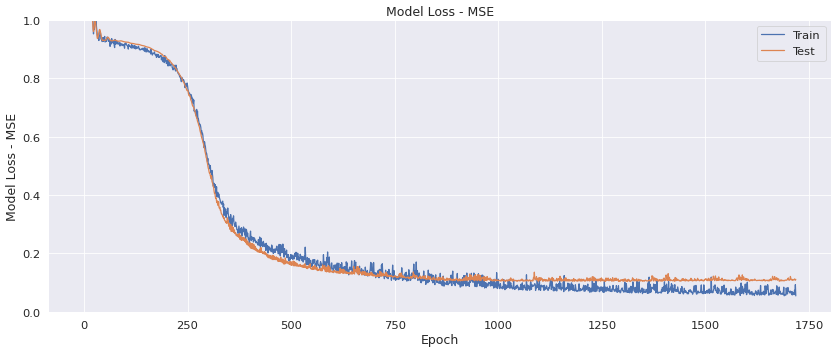

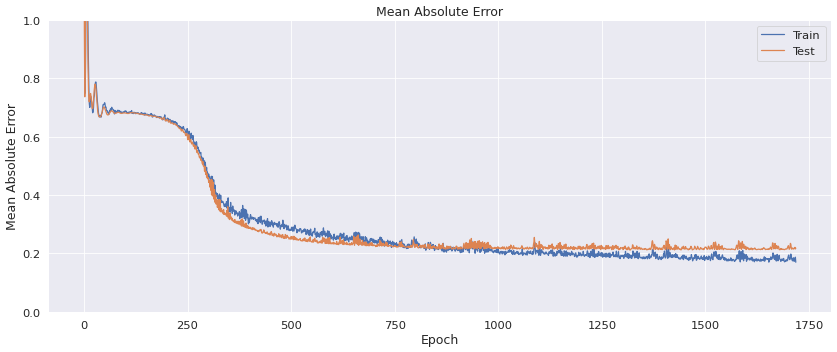

In [86]:
# Plot train vs test loss during training
plot_results(history.history['loss'], history.history['val_loss'], 1, 'Model Loss - MSE')

# Plot train vs test accuracy during training
plot_results(history.history['mae'], history.history['val_mae'], 1, 'Mean Absolute Error')

In [87]:
print('Model Evaluation Loss: {:.3f}'.format(model.evaluate(X_valid, y_valid)[0]))

19/19 [==============================] - 0s 980us/step - loss: 0.1036 - mae: 0.2116 - mse: 0.1036
Model Evaluation Loss: 0.104


Load the weights if no earlystopping

In [88]:
model.load_weights('../model/best_model.hdf5')
model.evaluate(X_valid, y_valid)

19/19 [==============================] - 0s 1000us/step - loss: 0.1036 - mae: 0.2116 - mse: 0.1036


[0.10358171910047531, 0.21155065298080444, 0.10358171910047531]

### Preparing Kaggle Submission file

In [89]:
predict_features = np.array(X_test)
y_test = targetScalar.inverse_transform(model.predict(predict_features))

In [90]:
submission.SalePrice = y_test.flatten()
submission.to_csv('../output/submission.csv', index=False) 

---
## Peer Comparison
Checking against data submission found here:
- https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/output?select=submission_regression1.csv

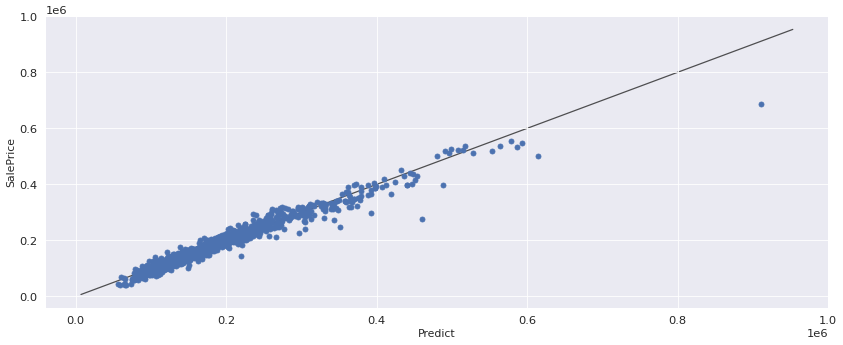

In [91]:
check = pd.read_csv(DATA_FOLDER + 'results.csv')
check['Predict'] = submission.SalePrice
plot_check(check, 'Predict', 'SalePrice')

In [92]:
from sklearn.metrics import mean_squared_error 
realVals = check.SalePrice
predictedVals = check.Predict
rmse = mean_squared_error(realVals, predictedVals, squared = False)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

print('VALIDATION_ERROR: {}'.format(hist.val_mse.min()))
print('NODES: {}'.format(NODES))
print('LR: {}'.format(LR))
print('ACTIVATION: {}'.format(ACTIVATION))
print('BATCH_SIZE: {}'.format(BATCH_SIZE))
print('INPUT_DROPOUT: {}'.format(INPUT_DROPOUT))
print('EPOCHS: {}'.format(EPOCHS))
print('MAX EPOCHS: {}'.format(hist.epoch.max() + 1))
print('BEST EPOCHS: {}'.format(int(hist.iloc[hist.val_loss.idxmin()].epoch)))
print('EARLY STOPPED: {}'.format(hist.epoch.max() + 1 < EPOCHS))
print('PATIENCE: {}'.format(PATIENCE))
print('RMSE: {}'.format(rmse))

VALIDATION_ERROR: 0.10358171910047531
NODES: (8, 16, 64)
LR: 0.0005
ACTIVATION: sigmoid
BATCH_SIZE: 874
INPUT_DROPOUT: 0.05
EPOCHS: 2000
MAX EPOCHS: 1719
BEST EPOCHS: 1318
EARLY STOPPED: True
PATIENCE: 400
RMSE: 16660.581904678584


### Hyperparameter search on peer comparison data

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error 

check = pd.read_csv(DATA_FOLDER + 'results.csv')

results = []

NODES_LIST = [(8, 16, 32), (16, 32, 64)]
LRs = [0.0005, 0.001, 0.002]
ACTIVATIONs = ['relu','sigmoid']
EPOCHS_LIST = [2000]
INPUTDROPOUT_LIST = [0, 0.05]
PATIENCE = 2000

for NODE in tqdm(NODES_LIST):
    for LR in LRs:
        for ACTIVATION in ACTIVATIONs:
            for EPOCHS in EPOCHS_LIST:
                for INPUT_DROPOUT in INPUTDROPOUT_LIST:
                    result = {}

                    PATIENCE = int(EPOCHS * 0.2)
                    
                    bestmodel_earlystop = EarlyStopping(monitor='val_mse', 
                                                    patience=PATIENCE, 
                                                    restore_best_weights=True)

                    #'model-{epoch:03d}-{loss:03f}-{val_loss:03f}.hdf5'
                    bestmodel_chkpt = ModelCheckpoint('../model/search_best_model.hdf5', 
                                                           monitor='val_loss', 
                                                           save_best_only=True, mode='min')
                    
                    CALLBACKS = [bestmodel_chkpt, bestmodel_earlystop]

                    model = build_model(nodes=NODE, activation=ACTIVATION, 
                                        learning_rate=LR, input_dropout=INPUT_DROPOUT)
                    history = model.fit(X_train, y_train, epochs=EPOCHS, 
                                        validation_data=(X_valid, y_valid), 
                                        batch_size=BATCH_SIZE, verbose=0, 
                                        callbacks=CALLBACKS)

                    hist = pd.DataFrame(history.history)
                    hist['epoch'] = history.epoch

                    result['node'] = NODE
                    result['learningrate'] = LR
                    result['activation'] = ACTIVATION
                    result['batchsize'] = BATCH_SIZE
                    result['inputdropout'] = INPUT_DROPOUT
                    result['epochs'] = EPOCHS
                    result['loss'] = hist.val_mse.min()
                    result['maxepoch'] = hist.epoch.max() + 1
                    result['bestepoch'] = int(hist.iloc[hist.val_mse.idxmin()].epoch)
                    result['earlystopped'] = hist.epoch.max() + 1 < EPOCHS

#                     try:
#                         model.load_weights('../model/search_best_model.hdf5')
#                     except:
#                         print('No Saved Model!')
#                         pass

                    y_predict = targetScalar.inverse_transform(model.predict(np.array(X_test))).flatten()
                    result['rmse'] = mean_squared_error(check.SalePrice, y_predict, squared = False)

                    results.append(result)

In [ ]:
pd.DataFrame(results).sort_values('rmse')